In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from glob import glob
import time

### Question 1 : Find matches between two partially overlapped images using any feature detector and descriptor

In [2]:
def find_matching_points(image1, image2, num_points=500):
    orb = cv2.xfeatures2d.SIFT_create(nfeatures=num_points)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    #keypoints and descriptors 
    kp1, desc1 = orb.detectAndCompute(image1, None)    
    kp2, desc2 = orb.detectAndCompute(image2, None)

    # Match descriptors
    matches = bf.match(desc1, desc2) 

    # Sort the matches in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)[:80]

    # Draw first 10 matches.
    img3 = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, flags=2)
    plt.figure(figsize=(10,20))
    plt.imshow(img3),plt.show()
    
    if len(matches) >= 4:
        x = np.array([ kp1[m.queryIdx].pt for m in matches ])
        xs = np.array([ kp2[m.trainIdx].pt for m in matches ])
    return x, xs

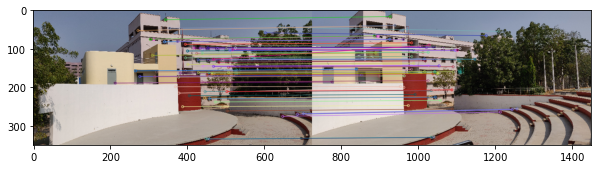

In [3]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,5):
    pt = cv2.cvtColor(cv2.imread(os.path.join(img_dir,'1_{}.jpg'.format(i))), cv2.COLOR_BGR2RGB)
    cm = cv2.resize(pt, (725, 350), interpolation = cv2.INTER_NEAREST)
    images.append(cm)

x, xs = find_matching_points(images[1], images[2])

### Question 2 : Estimate homography matrix between two images robustly

## Estimating the Homography Matrix
* To estimate the homography matrix we perform a DLT like estimation
* $x_2 = H_{21}\cdot x_1$ 
* \begin{equation}
        \begin{bmatrix}
            wx_{21} \\
            wx_{22} \\
            w
        \end{bmatrix}
        =
        \begin{bmatrix}
            h_1 & h_2 & h_3 \\
            h_4 & h_5 & h_6 \\
            h_7 & h_8 & h_9 \\
        \end{bmatrix}
        \cdot
        \begin{bmatrix}
            x_{11} \\
            x_{12} \\
           1
        \end{bmatrix}
  \end{equation}
* We take the SVD of the correspondance matrix which we define in the following way
* \begin{bmatrix}
        x_1 & y_1 & 1 & 0 & 0 & 0 & -x_2 x_1 & -x_2 y_1 & -x_2 \\
        0 & 0 & 0 & x_1 & y_1 & 1 & -y_2 x_1 & -y_2 y_1 & -y_2 \\
  \end{bmatrix}
* We minimize the error, by taking the eigen vector corresponding to the smallest eigen value and reshape that to be our homography matrix

## RANSAC
- For better estimation of the homography matrix, we perform RANSAC and try to get the homography matrix with maximum inliers.
- We calculate the inliers based on the transformation error, which is required to be below a certain preset threshold that we choose.

In [4]:
def RANSAC(img_coords_1, img_coords_2, num_points, max_iterations=30000, thresh=0.1):
    min_transform_error = 999999999
    max_inliers = -999999999

    # Best estimate of Projection matrix by far
    _H = np.zeros((3, 3))

    inliers = []

    for i in range(max_iterations):

        # Randomly select 4 world points and the corresponding image points
        idx = random.sample(range(0, num_points), 4)       
        x  = img_coords_1[idx]
        xs = img_coords_2[idx]

        # Perform DLT and get the Transformation Matrix
        H = DLT(x, xs)

        # Calculate projection error
        xs_homogeneous = np.concatenate((img_coords_2, np.ones((len(img_coords_2), 1))), axis=1)

        # Convert points into homogeneous coordinates
        x_homogeneous = np.concatenate((img_coords_1, np.ones((len(img_coords_1), 1))), axis=1)

        # Calculate the transformed points and normalize them
        transformed_coords = H @ x_homogeneous.T
        transformed_coords[0, :] = transformed_coords[0, :] / transformed_coords[2, :]
        transformed_coords[1, :] = transformed_coords[1, :] / transformed_coords[2, :]
        transformed_coords[2, :] = transformed_coords[2, :] / transformed_coords[2, :]
        transformed_coords = transformed_coords.T

        # Calculate the projection error
        transformation_error =  np.linalg.norm(xs_homogeneous - transformed_coords, axis=1)
        inliers = np.sum(transformation_error<thresh)

        if inliers > max_inliers:
            max_inliers = inliers
            _H = H
    
    return _H

In [5]:
def DLT(x, xs):
    A = np.zeros((0, 9))
    for i in range(len(x)):
        a = np.array([
            [x[i][0], x[i][1], 1, 0, 0, 0, -xs[i][0]*x[i][0], -xs[i][0]*x[i][1], -xs[i][0]],
            [0, 0, 0, x[i][0], x[i][1], 1, -xs[i][1]*x[i][0], -xs[i][1]*x[i][1], -xs[i][1]],
            ])
        A = np.concatenate((A, a))
    
    U, s, Vh = np.linalg.svd(A.T @ A)       # SVD    
    A = Vh[-1, :] / Vh[-1, -1]              # Normalization
    A = A.reshape(3, 3)
    return A

In [6]:
H = RANSAC(xs, x, len(xs))
print("Estimated Homography Matrix:\n",H)

Estimated Homography Matrix:
 [[ 7.14233764e-01 -8.26254853e-03  1.69987984e+02]
 [-7.52347511e-02  8.78965229e-01  2.41881802e+01]
 [-3.90405797e-04 -4.87069468e-05  1.00000000e+00]]


### Question 3 : Transform one of the images to the others reference frame homography matrix

Warped Image


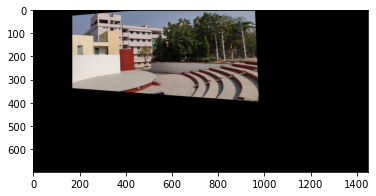

In [7]:
dst1 = cv2.warpPerspective(images[2], H, (images[1].shape[1] +images[2].shape[1], images[1].shape[0] +  images[2].shape[0]))

print("Warped Image")
plt.imshow(dst1)
plt.show()

### Question 4 : Stitch the two images together

In [8]:
def crop_image(image, tolerence=0):
    mask = image > tolerence
    if image.ndim==3:
        mask = mask.any(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    return image[np.ix_(mask1,mask0)]

## Image Stitching / Mosaicing
- In order to perform image stitching, we compute the homography between two images using RANSAC.
- After having computed the homography, we transform the second image in the first images reference frame.
- Then, we superimpose both the transformed and the first image in order to create the resultant stitched image.
- In order to stitch multiple images together, we take the resultant image we obtained from the above step and repeat the algorithm
- It is beneficial to perform the process with the resultant immage as we get more keypoints which matching a new image and thus relieving us to provide the images in a certain order.

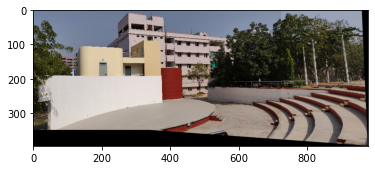

In [9]:
resultant = np.zeros(dst1.shape).astype('uint8')
resultant[0:images[1].shape[0], 0:images[1].shape[1], :] = images[1][:,:,:]
mask = resultant<=0
resultant[mask] = dst1[mask]
resultant = crop_image(resultant)
plt.imshow(resultant)
plt.show()

### Question 5 : Stitch multiple images together

In [10]:
def stitch_images(images):
    result = images[0]
    for i in range(len(images)-1):
        x, xs = find_matching_points(result, images[i+1])
        H = RANSAC(xs, x, len(xs))
        dst1 = cv2.warpPerspective(images[i+1], H, (result.shape[1] + images[i+1].shape[1], result.shape[0] + images[i+1].shape[0]))
        resultant = np.zeros(dst1.shape).astype('uint8')
        resultant[0:result.shape[0], 0:result.shape[1], :] = result[:,:,:]
        mask = resultant<=0
        resultant[mask] = dst1[mask]
        
        result = crop_image(resultant)

        plt.imshow(result)
        plt.show()
    return result

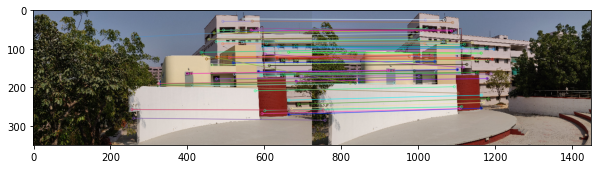

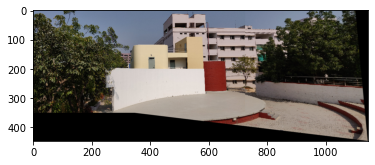

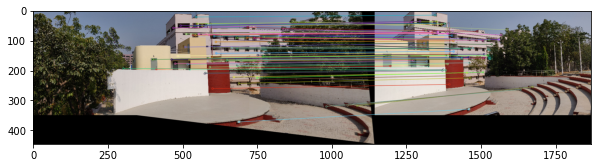

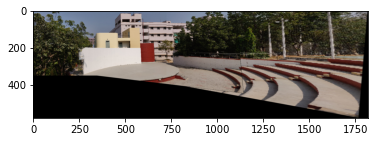

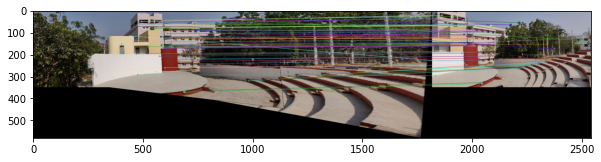

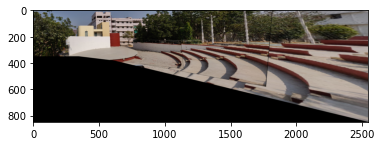

In [11]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,5):
    pt = cv2.cvtColor(cv2.imread(os.path.join(img_dir,'1_{}.jpg'.format(i))), cv2.COLOR_BGR2RGB)
    cm = cv2.resize(pt, (725, 350), 
               interpolation = cv2.INTER_NEAREST)
    images.append(cm)
res1 = stitch_images(images)


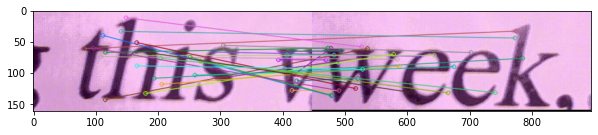

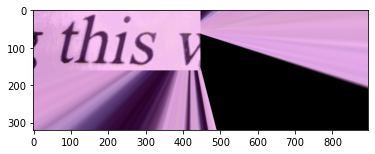

array([[[219, 160, 214],
        [221, 163, 214],
        [231, 172, 218],
        ...,
        [217, 162, 205],
        [217, 162, 205],
        [217, 162, 206]],

       [[225, 166, 220],
        [226, 168, 218],
        [234, 175, 221],
        ...,
        [217, 161, 205],
        [217, 161, 205],
        [217, 161, 205]],

       [[225, 167, 218],
        [227, 169, 219],
        [235, 176, 222],
        ...,
        [217, 161, 205],
        [217, 161, 205],
        [217, 161, 205]],

       ...,

       [[199, 145, 203],
        [200, 145, 203],
        [198, 144, 202],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[198, 144, 202],
        [197, 143, 201],
        [197, 144, 202],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[197, 143, 201],
        [196, 142, 200],
        [195, 141, 199],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [12]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,3):
    images.append(cv2.cvtColor(cv2.imread(os.path.join(img_dir,'4_{}.jpg'.format(i))), cv2.COLOR_BGR2RGB))
stitch_images(images)

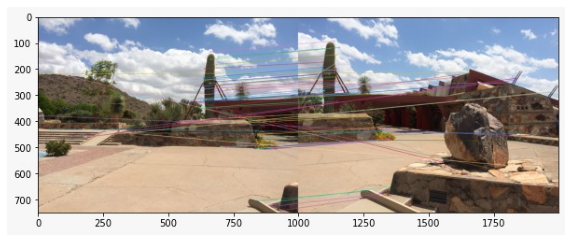

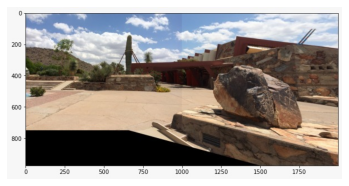

(<matplotlib.image.AxesImage at 0x7f522de28250>,
 (-0.5, 597.5, 306.5, -0.5),
 None)

In [16]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,3):
    images.append(cv2.cvtColor(cv2.imread(os.path.join(img_dir,'3_{}.png'.format(i))), cv2.COLOR_BGR2RGB))
stitch_images(images)

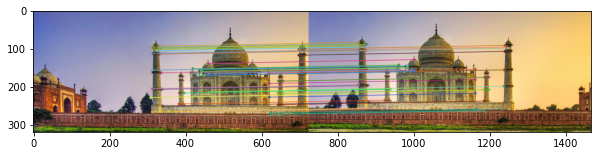

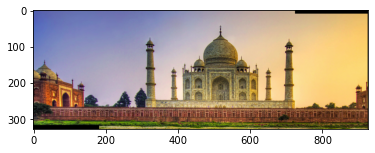

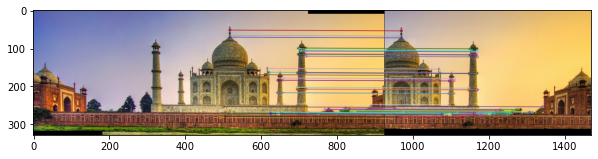

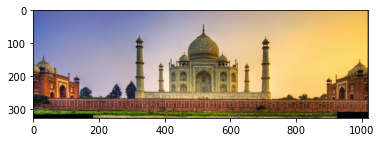

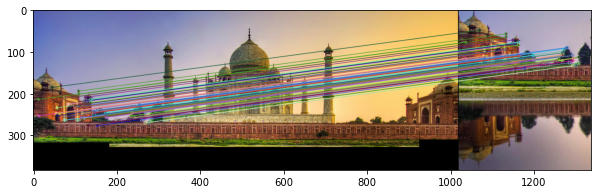

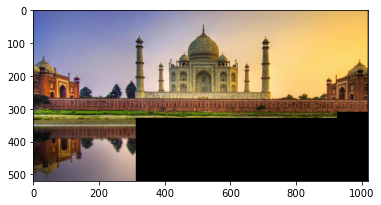

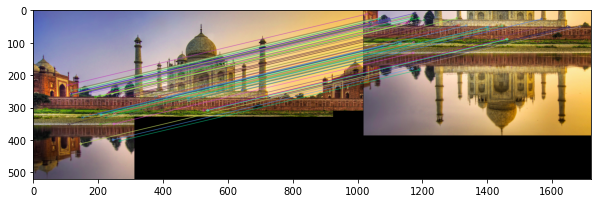

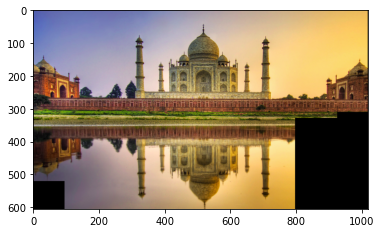

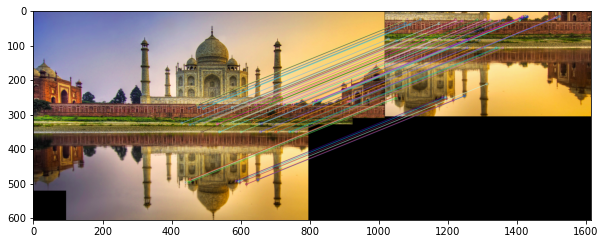

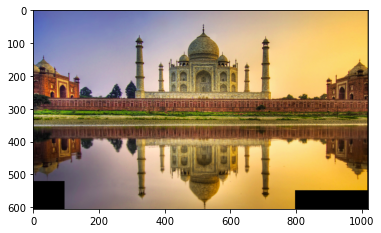

array([[[ 79,  93, 171],
        [ 79,  94, 171],
        [ 79,  94, 171],
        ...,
        [236, 185,  92],
        [236, 185,  92],
        [ 22,  17,   9]],

       [[ 80,  90, 171],
        [ 80,  90, 171],
        [ 81,  91, 172],
        ...,
        [233, 186,  89],
        [234, 186,  89],
        [ 22,  17,   8]],

       [[ 79,  91, 172],
        [ 79,  91, 172],
        [ 80,  92, 172],
        ...,
        [233, 187,  89],
        [233, 187,  89],
        [ 22,  18,   8]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [14]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,7):
    images.append(cv2.cvtColor(cv2.imread(os.path.join(img_dir,'2_{}.png'.format(i))), cv2.COLOR_BGR2RGB))
stitch_images(images)

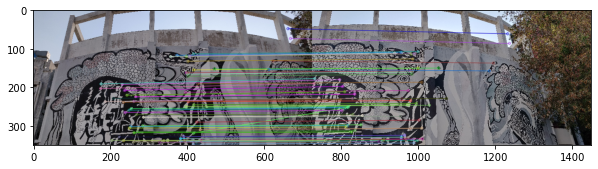

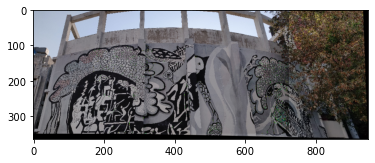

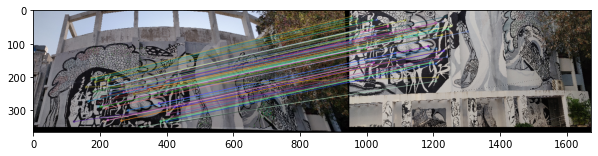

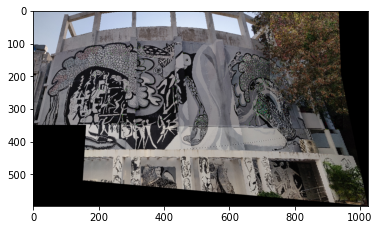

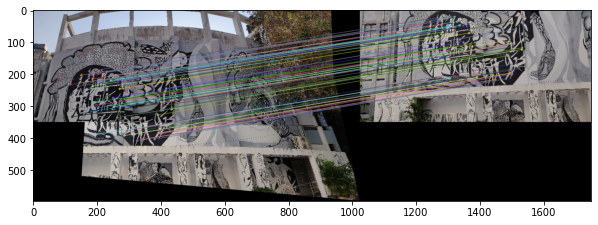

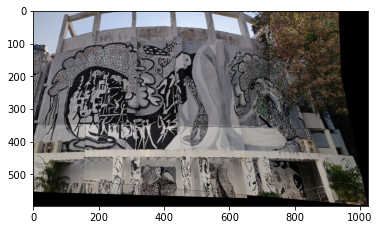

array([[[159, 171, 193],
        [160, 172, 194],
        [156, 168, 190],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[158, 170, 192],
        [161, 173, 195],
        [162, 174, 196],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[160, 172, 194],
        [161, 173, 195],
        [161, 173, 195],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 46,  26,  23],
        [ 29,  17,  15],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 33,  15,  14],
        [ 26,  12,  11],
        [  5,   2,   2]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   2,   2],
        [  7,   3,   3],
        [  3,   1,   1]]

In [17]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,5):
    pt = cv2.cvtColor(cv2.imread(os.path.join(img_dir,'5_{}.jpg'.format(i))), cv2.COLOR_BGR2RGB)
    cm = cv2.resize(pt, (725, 350), 
               interpolation = cv2.INTER_NEAREST)
    images.append(cm)
stitch_images(images)
    

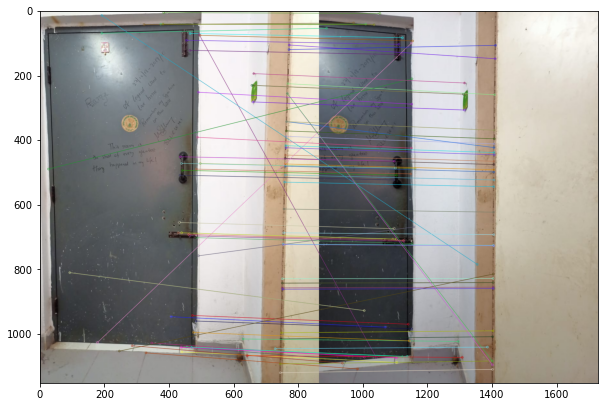

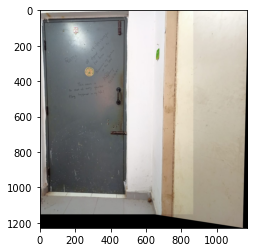

array([[[232, 232, 230],
        [232, 232, 230],
        [232, 232, 230],
        ...,
        [241, 236, 232],
        [242, 237, 233],
        [121, 118, 116]],

       [[232, 232, 230],
        [232, 232, 230],
        [232, 232, 230],
        ...,
        [242, 237, 233],
        [242, 237, 233],
        [114, 111, 109]],

       [[232, 232, 230],
        [232, 232, 230],
        [232, 232, 230],
        ...,
        [243, 238, 234],
        [243, 238, 234],
        [114, 112, 110]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [16]:
import os
img_dir = "./images/Image Mosaicing/"
images = []
for i in range(1,3):
    images.append(cv2.cvtColor(cv2.imread(os.path.join(img_dir,'6_{}.jpeg'.format(i))), cv2.COLOR_BGR2RGB))
stitch_images(images)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXwAAADmCAYAAADWbT5bAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOy9ya9tWZ7f9Vlr7fb059z+tfEiXrQZmVlZLhdy4rLLtmwshIyYATMmHvEHMGbODCFkW0gIVDKIARKmAGO5EK5SdZmVmZUVWRHxIl7/bn/uaXe/Ggb7dPe+G5FhyeF6ou5PEe/us5vV7b2+v3b9lnDOcUM3dEM3dEP//yf5F92AG7qhG7qhG/q3QzeAf0M3dEM39JeEbgD/hm7ohm7oLwndAP4N3dAN3dBfEroB/Bu6oRu6ob8kdAP4N3RDN3RDf0noWwN8IcTfF0J8JoT4QgjxX3xb9dzQDd3QDd3QNyPxbcThCyEU8Dnwd4GXwB8D/4lz7hf/xiu7oRu6oRu6oW9E35aE/+vAF865x865EvinwH/4LdV1Qzd0Qzd0Q9+Avi3Avw282Pj9cnHuhm7ohm7ohv6CyPuWyhXXnLtkOxJC/EPgHwKEUfRXDm7f/8oHL5cqrty3PHIgNp521xf2teVfqeOX0/o+5xzWaKwxVFWBriqcswgh1kW6dbOcszhXPwcghUBrTVHkKCWRUuCsQwiBlPVvseifcw7n6mtCCJwDKSUICUIQBAHOCZCSMIiwDrwgQCBwLO79iq4kkwuKPKtPSUm7u4UfhL90IBfdu+7SVzy4GIlv8I6M1kwuTnHOrmpyCJrtLnGj9bW1bZJzDhbvxGiNMQaxaEJVlmijEdTjinOUVQlLk6ezGGtx1qI8hZAKEFgHztpFuy04W7dvNRgCh0BQvxuEWHyqou6FEPW73BhFIeR6EITE932EUPhBgPI8pJDkeUqezpdPIATEzQ5RHONc/XhZFMxnU6JGE6U8gsAnTRKSZE4Q+EilaDZbOGcZDc9pNBrkeYHnSfI0wRiDlAJjTT1WgFI+Tkg8DxQOU1X1dygF1jg8TyEkGA1lVSIl+GFIWVaL+QF+IPE9n8oYpBAYY7C2HjNH/W1LpXAO7OI7l0KAdTgB1lmkACUV0gmUEAglsUAQ+FRlibMWKcXqeZyo350SCKWorKYsNVHoIZzELcqWSoETWGuw1tb1Ooe1DuXV71zg0MaipMRYQ+gr8sowTYpv/C3+G6Rz59zON7352wL8l8Ddjd93gMPNG5xz/wj4RwBvP/zA/Zf/1T/ZALA1b1iCXI0mAiFl/RJY/BbL/xd4v0RXtwbIq2XW5xb3CRDCre4TKxCqy8QJ7BUmsATZPEsZnh1z+vIp49NDymyOpySV0WRZhlKKIAjwPQ9nDUoIsixFlzlFkRO3emitCYMAX0GRJRy9eomgotGICYMQbSyep1BeQLvTI8kLtvfv4QUtwkaX9z78DpMkp7e1Q6PVxTpBGMWr8VmPExtgsxoAWIwdQFkW/PP/+R8zOXuFNoY4jvlb/9F/xv7dd157H+u/GzWtsHzBxKR8jTHV96/Y3gL46l8r8Ntk3MB0MuKf/9P/hipPQUistTjn+Hf+zj/g/e//tWv4xpV3zUZbN76F1Tfg1gxr1RYgzzOsMSgpsEbz6uVznv35jzl/+SkGhfIDssIwn04ROJQtUDZZsFWLtZblNwoCbRxO+oBCBA1QAQ6B8rzV4Dnn8Hwfz/MwRiOVQgqBtRZrwfcCjHGk6YRWK8LzQ6wDISS33/6IH/7tf39V1vGTx4jAQ/kNBlvb6CLh93/3dwkjj26vC9qwc/seF2dH/Okf/x7OaJ4/+ZRf/xt/n5Onn/LZJz8my2YIV5Llc4SsQLTIrWVWjNmJW2xFMb1mhzASJDPNNEt4694OQnh8/sUrhFcx6Pfw/HoOzOYJSZXQ8nx6vVsk4xG5KUH6RG3Bo8/OePjONrv3uxyfFbhCkuU5T18ckWWa/YMuztO0XEBkBf32gOPxBKUM7ajB1qDDi5MxnrTEniCQEO/2mWVTyjG0oxDPV4yzjGejM+IY3rp1l/lwjnQ+Vju8MKLT7ZIXM26/tc3J42MuJgmV5+iFPnEQk+T1/JjNUxRzPn864mfJ2ZUv798KPfvXufnbAvw/Bt4VQjwAXgH/MfCfft0DS1DA1dLuEknWk1MAcjFpHQJ1CXSk2pjIrJ/fLP814VLUoKSUxDkw1mAdtcSAqm8VbjVhrTXMxmMm58ecHj5lePKSKk9QizKqskILRWUM1hiwFisdRZlS5glVnlIWGcZavKBBU0qkkkilEMISBD67uztY6fP2+99jlmne/fC7COWjncetO/exgB+EKOWzBPLe1X4uxu0qcK5AeTEWK+a2QDtrLUVVEEUhQgiiRmtRz8b7uVLeBt9c17lx36Y2ITcfWLdog4G/zlAAet0e99+6z9PHjzAGqqrAUx4CgxCv9/Mqc77aXicEiA0VcMngF7L4ksI4ZpPe/uBj+v0+/+p/e4VegLkvHVJInDP0d25x685bVNmI8dkrxuNzTFUgFhqZkpZkPiIIAtAJCEFlLPgRKmjgVIBQHtYKjHb4QUBZVVTG4Hk+QkClC4p0jqcEnidQUoJ1SCk5fPYFf/CvfoePf+Wv0u50uPPOQ6xzK00yjlv84Nd/nWbc5OjkCGtKrNXgJB989Ct8+cVnlGXFs89/wosnnzKZDhEip9mSZJVCqRAnYK/fpleBLC2tbotxkrDfb9CTXTrtgEYocZEgairKasbFxZhmK8AGHi/HI1xZITst3u4roqjNoy+HUCb40W2iRs5kljMwDXpdQzo3FMBf/413+OzRkJ1Bm7Sc0col3bBJ1IioAoVgiigFupzT3o24ODyjvb1DMZrRthJMSBCBRmCsQriQH378fU4uzii1JCs1O50OpYbz81NC3+N8PqN8YomCgJwLrNE8PTa0fMXbd+8SNiLCdoOLkWN7f4R4tlYI31T6VgDfOaeFEP858H8BCvjvnHOffJNn1yaQzUm8BOBaxXJuDd5iMXkvAdxSZd44V0uSdgX8gvr6k88+YXb2Em0txhgefvxr9HcPVrikK818fMH4/ITjV08ZnR8jF+2wVU5ZZEghMVYjhYeTEl0WJLMpzpT4CqR09cR0DpyhGYUgvVplFoKqKpGeRCmPMI5579f+Hu/94G+u+wevg+01IPnaOF7zrGWJ9xtjyHpMJGAQSKkWYGFfMwGtyoWFNLs4L+UlSR2WTODy+3ytvVIgrkyUzXukUgRhjPI8iqrA83yUUjx/9oz3v/9DxHUmqo0qa02tBvOlJL8pUKzOioWAsTABIC6XYy0EcQvhBVDmSFWbXlQQkKcJWWX5wd/6B8SNFrYsOD85rIH/5Dnnx8/JZmMcRyjhMLqiLEuMAyUsvjTYqjZhWAQEMfgRpQEnFEI0cE6glKDZjFESPCnxlMS5+ts1tuKnv/8v+eIXP+WD7/4a7374XXq9PkIKJLVQ0+ttY60lCmLms4JPfvYJrUbAq+ePefzFpwgcL599gRQVVZkyTS1ONrEOsrzCNWL0+YROO0Li41xElhVczGKUrdjudNG+T0FC0ArJpl2MMQQB+E3B2w8Vo/MCoQuqakKgWoRKoGJFNh/R7/UImmMGvZBkWvD+9w748vEZo3EKfkm/E2GeG1pBSISm2fKYVlOKzKcsDaPpFG83xG/FzE1KksxJXxiccWzHMTIIabU6vJylPHn+gnGW0h/0mBc501eHeFZycPeAZtzCCId0DmV9AhsQ9juMx+d4zTbzQoMPva0ezsvobO0g/uj8jUf8b0vCxzn328Bvf6ObF5L2ctK75QTdBK2VLUIuzDdrcX0FYCzmqFxKjvLSPTi5BjcBzrgayJ8/wVlDVVX4vk/YbDMenjE6fsl8fEYym4C1GOfwlFuUK/BdQCEyrNHoqkBXM9JkitUlge8ReB5KKuIoQimJkB5R3KG9c4ckzZlNLlDKQwmBtzDxen7E9u7tawH9OiZ29Z7XhvYSwwO5YTu/Wo6UAt/zMIAxmkCAUOraOuRKkF9D/opZL4/F689dV9ald+KW1+v3VmtWlllaIoVECUWWZ0SxQmIQcm3SY9NUsyxnWQzrvl5qzRUzoltgvcNtsocV42q22/S3djk7eQmIBTN0KM9DCImuCnyvB57HrQcPuf3gXcBRVRWmqrg4e8X45CXj4xe8evoZWTqhyOcoJcFZtDEYa1C2RGhN6BxpmuJsG+XF2BKsH2KFRyMOUdJRCYHvewRSUlaadD7i53/4//DFL/6Ee29/hw+/+ytsbe8ipMRRCx87u7v4viCfdPln/+tvkZeav/53/wN8Z/i9//N/5HQ4otftE0cFRZkBHl4UYjNNpks+fu9t7hwcMDydkuWapLggG8/Qbp/xseH2nTs0mz6HR1+CSdBZxDjLyYoCzwvpdbaYp5bkYkypNYmu8KKKg75iPNG4ucDkHlU25v7+Dsn4iNgUtAV4/S7HJyNaB5KgkcN0TikkVjmaXYXQITQiDpMxfquLrgpiIBpESOnTaJXcVm1+9OVLglaALyXbW32evzjBVQHRqCCUMVGrRSNwzMeag4MDRnlCMwqJGjEiiBgNR4xnM4JGCKJ5+cN7Q+lbA/x/Xdo0N2yCxuraxtGmKWdtixcr0F/b72vA2AS0JVcRCLSuGJ0dg3NIzwOt+dEf/h5fPvqU2K+dZcpTCCTGLZ+vHUjOWpw1oHPKdMY8ndFqNmjGHs6p2uQgJK1ml8HuPfoHDzh48D6t/i5eGPPpT36XL//091eOKiFV7ZwzFiv9S/28NE5XTCtXTThfzxSWDr6r47j+G/g+mXNYY5BCLmT+y2O+AsGV6WwpPQs2/SFf1YfLfdn8DUK4ha1fXHrfWV7iK49UlEgpMcbgK4nv1Y651fNc1l6u1vd1bYH1Y26hNa4wX9Y+CJTEimClyXieV/dDKqqqZHxxxtb2Xu14XNW3cKQHAbca73Fw/11wYHRJOp+RTC84O3zK/OKI86OnTEZnCKcBgXO170cGCikNSknKYkpRWLx+jMMhpcJYixKCOIzI8wJjNclszKNf/IgXjz/h3oP3efejH7C9v48nPYo853/67/8xzz77EefHL7l1/33mF2Pmp89wWKSxhCqge7DP2fkTrK5oNlpM3ZhpXtLbUhweP0EXBXd2fb54atna3ieIYrLhK6piB8847uzu8/7DFi9OHpFMKno7MTtygG8siJDn+RDjCaK4QWUrtHA4o+jvhERZhzRP8T3HeJ7S6zUpJ2OiRoPOrs+jo4QD4xhsHxD3K+anBR/86h6f/tkxKSUmEZyPMx7s7xELOJ1kzGcjHr7zgKDhk+c5/e0uWSII/AZ7B7voeYG0OZPxEJsIBvsBsuFzeFoiA0XkBcyPzxDtnKbno5xleD4nKcuv/LbeJHpjAH/JF+VV0HJLZiBxLMCWJbhtaAFO8prd+rIot65owVjmkxG6rJ2r2lq0qSiLjDKdEnfaCOFjrQMMQkicKdFlSV6lWF1SFjm+EkSBohEPcNYilE+7t01n+w4HDz6iu3OHZndrZQtH1LbyZFpL98YYfM9DKQESoqDB1s7+V5pwrrOlw2Vb+VVzzkbAyGtguJZ4F5EQOIwxlFWFNnVkypJ5rjWr11jwouzrGc31vy//3XxPVzU4kDx8913+/MfH4FhIw9QmEWNQ0t8A6rW2B5cZ4XW0Kd1vMk+gVmNcHb2xbKtykrtvvcP45AnWOqQETymsdRijGZ+fwPvfveSXWLVjMWDLdyCDkM4gpDPY5uD+u7VpRmtGw1N0NuXoxWPmF8fMx2fk6ZSyTME5fM+j2YrxvADjJL6QVHm1sNVblMkXvgAfXRUUzvL4s5/z/NkXHNx5h/c/+i6f/OQP+flPf4d0NkFXOVEoePrpH/Dpz3/M9tYAr90hCLtIv0UYd8jzjDLPMZXhdq/L7CRlPL7gu9/7IU+/eISnFHsHByRZyU5/m8OnzwkMxIHkZGKJttochG2Oj1PaD7cJVZez4+dsb7cZT3Iqo1GVQ5c+nUGTw5MEV0KjWTIZJ9w92GOeJPj9gMk4YTDYWkTXBMxnlnyukU5x9PyCVi8iziTHRYLNE87PTjgrNb4v8WXAk+MhSVHglKQbNTmazpGmohlrpCjY2tqlKh3CeiTDBNWYUs0rZvOcg50tvGiLspxjPIk1HsqXFGn1xptz4I0BfPHapLwMWot7VsCyEXUCLGfktXbrhXNOrI7XZV2cH+N5CmcAAbosKPIM2WvXoXbCoascXaSYqsDqgixLEQvTh+/5+EFI1GjTHBywc+sdtm+/Tau3iwrChdaxDLGrbQUCkFiqLEUIiZRuISXWTsDSOLR1rA0pr0vL38SscxnIFvUv/khEPWRCINzaUel7Hs45siJHCLkIlzOvSe2vjTVL6fx6jWR9DJvBm9eZfMTyRrE0w9UMvj/oo5QkDENKKZEC5rMZ8+mcfn9wpT63gnwhNzS/DXXbAULITUPgRqNXXxtuoYUsQ2ERAj9u4Xk+xjmMtviBjzEWC0zGFwvG97pf4TWGslFz3R6FDBS7B3dxznHw4COMMThnmE9HJKMzLk6e8uLTHyM9H6ECMBZrRC2QOIeUgkBZXDXCqghHTFkajMvxyglPH815/Omf8PzLPyMMPDoHtzg9OebHn/0ZfpoSBw10D1xRcGZGnH7x53R6DcrMo9eSFJml6UtOng1RkeTlyy8RvsJ6lsOTF5SlREnLrV6Xjg5RgUdxOoeeJS18krHlpz9+zO5+m73tDoO2h8lPmGQ+yhOcn09QkSDLuhzsaL77K/vkhWZ8PufnP54Q7z1kmJYYr2IQR8hQ8Mnn5zRjgU4182lBa3CLL569QEgIjcMmFUHQIJlldDuGVuQ4HJ3S6W+hgpC8PGan0cKh6W11qTyNP/AQI0UoQ9LCp6ym7O/vkSUzPnznLidJyTzVSA3WQbcTo5TCWP3ae3+T6A0B/Jo2QWp9ksvmmrWWvAaH1Z/L03cp3dYTu5YUl0DjHMxH56TJHKREITC6xBMWdM58kjIdGaqiIIoCfN/HWUcjaiC9gN7OLXbuPGT//vs0utvEzc4qNnvVIHdpOi/64siyOWWe1hE6C/DC1b6BuN1fRGR8tYR/6e/6hkvnV8crifLy/RKxRJk14PuSwFf4nk+r2SSOInylXpeQl2YOlkB/Waq+3M51/y+9I/H6u1qrc25lmllK7Hlh8bwAKTWBUlhr8BR46mrb6uDKy+O3jrTa7MKlY7HBSF1tl1+Fa7q6DXbxCvcO7hCEjQXzl3iehyXHWsf56TFFnhM3mqt+L8dh7Z+4yhgvM4hlO5xz+L6PdR7d7X16W/vceudjpPA4fPYLhPRx0uBwWFtSe2gcqADPpliTonWGJ33Gkwrt5mSZY9ALMEJzcPsWh8+fUVnDvX4H3W4SRE2s9PGbTaJGQJEl6ErgB6LW+irL2XnGztsH5FUBlSQOYzrtLhezEb3BgEl6wtmpRMsWW9tbBL6P9ZukFymNZof5+JzY+BSphxTQajY4vZhxa69PMxPIUFJUBY12g/HY8PzpOTov8IMmk2lCqzfg4+/f49nTVzx/dczOTodkkqF8HykEhyenhG2fB7sDXr2YcjycgzIECna7AQ/u7lEag5aC6fyCQb9JenzGWw/2SCKf+awkFBC0LO2wx3w8Yuv2Lu+9/YDnX37Ki6NDZM9HO0EzsgQ2YJ4WKHm9Fvkm0RsB+DWmi9fU70sS0VLiY3PCbMbNL1XmxcR2SyCSbHKJZT1al1ycn2CdI/B8hDN0mjHTYYXTCUr5KCmIWg18P6TV2SLu7nLw4EO2bz+g2dlCKG/DJrEZr7IGkZoWzuKlE1KXaF2yXAhlnSNQHs46Ov1t/CDA2tel+GtNE99A0r98+5pxLtsohMMuxtnzPNrtFr7v02q1CMLwEuNYm9PWZazj3K/WdQ3QisusYX3ZvWYG2RzCLC8WIK8o7XLBlCMKJcjNhUt8rXR9LV07pEsGtLi4CNcFh/A8pOfXzlWlkFKtzCllnmFNxboJbvnfSmO5XJmrtZgVyK/nwnIdgxSLtSC14sPW7bc5PXwMQmKsxQ8UUgq0qReAKS9EaoVUDl0UOJ0TuYyLJGVaWtppyOj0mHYo6OzvE0QtBm2H1hMuJppmK8I4MOUcp2H/7gOmwyOKwqG8gEoXNFs+Xl7i2QoKi6xGlGmBbGqS84z33/kus5Mxx5NzUldgzhxKeYCHIGCUCpouZ6ohjju0Qs34omDn1h1mk3NCZcjyKc+eS148m+LZkt7eFpNpxlt3B8zmFyAlQimUy+h2FGnmURnBw4ctnp9P+MXjM6gcO3sDsnnK/Xu3ULEjjiPevX2HYTYFYchmmuj9uyACtM7ZGnQYj2c0YkEchISqQoUeyXTEoN3i1DranR6pnpGrlMmjY5qNZh2J94bTGwH4S/pK0OL18ysJcPnvQqIWi1mxyRQu/63LmE/HlHlWr6zD0WkE7N25j61mlEVOFIX0tm5z8M732L3zkEZ/By+IkdJbtWk9d9dlXza3gHNiAxBrybHM0zr8zoExBk/KxQo/h/Lj1aT/WpDaHItfAvorcF8eb8RALutRQJpkCCFoNlsgwAt8oihag7pYSt5151ZC+WtAvwma10nzl+/dbMfV80vygzoG3PMVUoY4Zwk8j2SWEDV717zv68fqm9A6lBSWDmlWErqg3WrTHeyQZzMcAs9b9RStKy6GZ7R7PWAB5HJTvP8KO+9izJy1tXlmUeGSSay0EKC3vY8fRvV6DmuRnofvFZRVgVQSJzw6/X2y+TnWWcqqJPAlO50GYjSBYobvHJPhmN0H71HQQHqW5y9OSKcz5hcjmq0eYRiA9jl89SWYAs8PGWx3qXRJJC1B5CHJGR5OaOx1UCZl+PIVGMWXXz6loQKs7zMvHIHU+FIQNlp4DobDc8p2TBjEBH5EI4qRoUeep0zGU3YGLaoCkosZyqtQClrbkD7PMLng2bNTylITCkmOptU2+G2fLx6lcJrTVg3KuE1vL8azEA0aON/R6GoeP39CNReU1iAV7A/2OBxPeeetHW63Gvzsky84G+Z4vqXXc8TdHkZbTkcXjMZn9HsdCpuyfavH9ELRGUA6rVcmv+n0xgD+VafjJRJLENlcsbmUOjcAVsLafCIu2fY3yQm4ODsBZ2EhTXU7LZrNmA/few/l+XR6A6LBPTr3flBP2DXUwdLUsECFTTPUpZh1J6+BH8Ho/BRbaYQQeEqtwE1KxcG9B6+1+ev8G19/bnmwaYN/3R6/pDSZrSRL6xwIiR94lwF8Q0Jfh1Muz1iuZz6szD5upYm9zsgvSdab7QfeefiAR3/ig9b4i9WnSglOT47ZPrjzlX26Ws41V685d9kktEp/sYzUEYJmp4c6UVTakuf5ahyqsmB4dsxbD9/72jZdrm3tR1l+P3I1CnXEkGAhPAhBGLdotAbMZxdI5eGAKAq4mMwJ4wgVNfnO3/j3iJXh85/8v5y8fEQmZzgsoR9iyhTPb2CNpJqmCHHO8xcJWSUpvJBG3MS5ksl0DtKDPKPUmjTNiZpd2s2I4WzOYKuJqXK2tlucTmZgDUVR0e7t0G12SSYZTgaIakpr0GI4HCK1QkiHtpbz4ZT9PYmKtkjGI3qtPlIK2q0WurI0xC5VOcVITVZmbBUVrTDAGJ88jZlNRmRlSkLGdrfJbJQgvBznOsShYLvTwre1oavfanA0nTB/ltFoNokCxe1Bi7ARkBSOAJ/JaM4ovWBcXNBsNwhlQGESRsWIhhcxdBPyWCP8Oa1QY6clocsJW23yPF2k/niz6c0AfHFZMoavnyibVoKvlnLdAlQuM5JlQGEyG9eOOOswzhBHAX4Q0Gx3cM7R7nQp8jHOVAgZrm2wq8o37bPXtXUNYJf75tBlvcpSKEngBwhbYWvrK0W1/mg2+7Qs49o8OFfGxnHV/HWNhnTNWGdZRlHUjukwCFYmnusYzvp402Z+1dG+rHrJhBdZZa4z3awY+DJfzuW6LArfD6i0wVmLFQJhDI04+grN4HXn8PVUt82568f7tTbiQAo6vW08z0frnKrMgTpax/MUs/HwUjlXx+xS7dfUs7iw/l6dW0aG1mGYnkert8N8PkJ5daRXGNYRZdZahIDpdMaH/+5vcPvhxxw9+YwvfvZ7nL76nCKbYUxENZ7ge5Knr56CnzM+m1CUju39W1hpmE/HSOlRlimBkgRhg1bcRkRNZrMp3Z2KuKP5+SfnSJr4IqLVGjAVOYXRPHn5DKED7u8csL+9x1k2phmEzJKcuN8haLSQFuK4RdCK8eOAZ4+/5ODWLdqtJkcvD/F8hRcHNIOQi6cpo1cZH3/8HdKxoNOIsF6byIU0qiazaUKofLa3I0oLJ/NzbNahJaDZbjDSE4QXIo0AUxJ0YhKb4vsKKkuj2cRJj8l0REWOH0gmswrpA6Hi518+IwqbDM8StrZ8qqREzQ0vzi9odx2lVy9qfNPpzQB81hLqL4v02Lz3ut+X7xUbzsW1WcFYy+j8uDarWEvoK1qtBmEcMp6OOXz5iu3dfXwJ1eyUaOsuK61hbaD52r7UtI75X51zjtloSBgGKKVQnofTtnY+qoB2p/+aOea6Pn/VWCBet4V/NSO9HCljtKkByoHyFJ5SBH6wun45x9GV8sRmP5dMYHH9mrxGm4xBrJjCsk1rprAszRhDVZVoXYETq4RitYb31ekV1lrhZTPW5krgJcNaMXXW2otz12uf2/u38D2f3GXkWUIYNwmCCE9JZuMLyrKozWHXaIFX6Wr7Lo3TxsgsBQ4hobdzi9OXj+rFVNYRBgFxUKfbcNZw9Oo52hj8IOTe+9/j9jsfMTl7xS/++F/y7PM/YseDpy8eczEakqQFhYGGJymrgobz0NrghGDQ3UFIQ9xqsjdocXx2RlIViMojnZS8d+8djk4rlJUkZU7UbNWRUTKmLSStWGCc5c72HtPZjAMVcJImtFoV+1t7PHpxxnA0wWlLqxVyfPSU2/u3wCYQRkxywb1Wn/4H77Oz1aGY5AxPL3Ayors94Pz0FY1wm0mV4UloNRqocMDp6edMkymq2cK6gnya45kSzxq279zlbHiCrzxevhwSqgbCeSTZhLv9bbxIcQLp/PkAACAASURBVD69IGhafCkYTixJAlvtJqrr83DrFrOLU3p7u0RxSKodxbREqZp5vMn0xgD+dfSVDsevOHftsWDtKBO1RXY2mTCfjjHWgHPEUVjbEIVkPBpzcnpCksyJ4yY6OYfB3Tr/yrrwX9qmy5Lb+p6qzHBGr5yhAnBSoqTASZ9okf3xmzO1jSYJ90vuuRztdLVLdR2SVru1iDhwKCWxYu2sZQGwm3Vc0iGcA7m8Lldly1o8rdM1WIvFrqXfzf4J8KQCIWvgV3XJdWqKGvgDP0R6Hk5IcNXXaoZr9nxF87jk2LgyjstGrX6L19T1IIwRQFXUfg9rzCKSS+NMibN6VdbKJ7BRxxrfL0cvLe+/NL6r76m+bh30tnYRwkMph3MK4aDVjJlnBQLJxekxWZLQ6Xbr8fM8LsY5/+J3f8b47AX7gxihGrz73rsU8ynPnh+zO4jxfI+w3WF4klHlBZ2mh+M2b7+3j5KOMq+w5Sn37+xxfpIyGhW8tX0LF/l8/uoxymimaY4fhBhpcXGMdo4vh4ds+zG39m5x8uUpx8MxhXGEXq2JW6HodAfcu9ciKTK8ZhtRCrbaBkXB3e3bZJVjMpmRVI6GrBCp5nw4xHgJJ5MRb/U75KklnQ7pt7aR3pR+02c4y/DCmHt7OwiTMBuPUCLg7XfucnE2oxpl5FQcTUbkhSZLNWmp2dofkGuH3/DZ3W4zv5ghwojnsxPSyYQwbFEZS1lauv0unucD1esf1RtEbwjgC5RSX/mhL4+vk9a+QdErsF7+myVTdFVircVTkn6nRRiFaG0YDodUWvPsyWM++Oi7iHKOqxII2lyLENdVSA12C3i8NKGLIkNXxbovC0ePQ+CH8Qrovg64L9UmlhEzX7/o6dKZBdgvHbFVWWGsIQo9wqBO0rVMWVCWBcg6589sNiGZzYiisE60lmcI6QiUQsk65cE8Sel2O5y8eoXn1w7xMAhQSlPkJecnQ6zVFHmBw2F0zXTLsgQcvh9gLTRaDbb6fdq9BkEQMrkYMZ2MsEgCP1xYihzPnjyh0dvFLSJUrLXs3TogWEi7RjvsKk21qM8vTCX1d3Q98F+m1zWIqBERxk2UECixCK+VkrKqx2U8PKfRbG1oDlcl+HXZm6C/KShcNfes54IjajRodQfkyUUdzWMsrVaDyTwFwGjL4dErur06tZ4xhkef/ITzF884np1xPinpNyI6zZAyr7i9u0W/3+HwNOGg3Se0JXma0tvdIQ5b7A62yIqSnXvvMVMwOU+4mFRkpkKUQ7JUkpeave1dZsMT4qbHeHiK7+c447EzaFHMEi7yU6oyY7fbZve2YDZLKecNoqDF3nafL54/Zl6A1YLJ2CDmkrQtGZ79Od12F5Z5lQLBJD1hf9DiopjR7miCsELPUhr9JuPKYrKKImpQaWg3fJJ0RiA8qtIyymZ89khwt90hsxVRK2ZbdklnObs7PbplTDkvKTzL+XROK25Bs6I0FukJ4liSJiNU4CNNiVgmTHzD6Q0B/Jquk2ivs6duAtvXXV9ObFgs15d1PP7wdJmpuZZNm81a9S6Kgtl0gtaaV0eHPHzvQyLPR89O8bbar9W9mZf+Ejm5qHXVIJYOZlNmCOdWWQzLqiRQAiElg509/CBgada4bmyu9vkq2C8rlrLOr6+NxhOC4fkZUoCUmouzc46Pj2lEPu1myOGrQ4o8JfYVfuDVecClJM9S/tlv/bd4nkeWpoRBvVo4DDyMhflsiucpjDHEcQRSga37JgBrDf4iD3+WpQigKEviKCYIA7Q2zKeT2vQhFc5Z0nGOwzEZwuQ0Qnk+jUajZpJSgLFIuQ6FHB495/949IuF76Gk1++xvb2N59XOTGehqEqMNijP5+F7D1FKYqwgyUocgjt3btNoNUH4WKDbq9dCSCnxfH89rBuhk0EYEjbaIATNdhvPj6m0hoW0n8xGCPHgGzHsNTNYg/91Ms3me5eeR397n+N0jFI1o2s0YoLAR+saeM4OX/Lhh98BQCnFex99h9/+bU11OkXnmlDFVIVjNsuIY8HzkxndTg/nYP/gfs2wpSQvcjqdJi3ZY/joc5iNmfiCTi8kPz+nkD7WRmyFIX5ZYouCscsIGhEfvP0xOp/x5OiQ27dDorbHr249RFhLaVK8YItSpOxs9Qm7Y2Ivx/OaHJ0liKjB/tY2nU6T8dELXjx/RQ7cObhNpgROWqQGX7V5Z6+DLQSVqdCZZDg7Q/iKpyenOCfqjKbaY5YaQt/S70Z0VAyFwW+20Yuc+Eq0yHJBHAni1hajWUo3NsRRhJQelXTgLFoEGGdoRC2qzDE8nODMm73oCt4QwF+q9CsQW54XbhWZAK8zhK/KH7OKYV6XXpsUAGcsxy+fIYREqdoR1uu06/wsDrr9XZLDZ1RlyfDshFt338IkFwSDBzh5ebiuNx9cA9RLIVIIzk5PKHS1uMsRBiGSxUYTTi2ch6+Xf2kMFsyjqkoCT3IxPKPMMzrtiF/82Z+RZymtRgROc3F+jinzRTZPSJM5vvJod7vMlSQ5qyNCIulwRtd5WbShNBVWG0bnJ+xs79BuhouNMVJOj45otbuYKicKWyxTVc+nE46Pjuj3+7TabfIsAyEJw4AsS7g4O0VIj1t37hGGIdPxiGQ2QVdNgAWzc0RRhO8HsFg5KhB4vk9gQoqyWtqvEAKKoiJLEsIwxHoStGZyMVwxLW0Mnqcoi1qj+IPj52itaTSalFWFc47PfhYipUcQ1JqLE4IwjEnzkk6vS7vTpTfY4uD2bcCj1W7TarfpD7Z55gxBECCUpMxr81JWFIzOz1eL29zq21h8HhuaxeYiq/o7XSz02kzffA1JoDPY5ezlI+wiXFRKaMQRWV6gjeH8+JCyKgiDWqC5de8B7z98n+OXX2JdTKvdo0ovyPIJfhCibYf7bz1g/6CP0RVJknB2fsztu3coygLjDJ/89CeU2YT99+9TuBzZ3ubx42O2oxYHW7tM0xmhF+LHEZ6wnByN6bYqGk2PceLjG8Pbd2PKNGI2UzSjChkW9He3mGnF+9/d4+j0GeN5Tr/foRFG7O3uYbKMeXmO0yVjU9KSkkZYIhsNJqdnZEmD8WxO4ElsNadIC3a6PbAhCEcY+5TVDOtFiLiJ53yGZ2NGzpJYx3k5owwdYRVxb28PkeacDiekhWa/00Pik6eaF8NT+oOYSDoa7RZh3GZAhKgEgTon5c2W8t8IwIfLKu86Myavgf1VoN+8tjy+9JvLC6JmsymYAiEcxlhazZhmIwIEce+At7/3G4xHpzgEL1+9ZPfgNr5IMNkI2dx5rb5LfajdltcwgkWvrEVSLRaS1TnUrQWp6h2Abt97sAb0pTnFGYosYTaZEIWK89NjktmIyFdMxhco4VaSthSy3jRDCpLcpyxKnDF4nsT3AwSOVryNWezkI+VifwEc2No27IAwCuuVyLM5RWUoq1pyMZUmSxPS+RQcdRZH52i0Wrx6+RxdFjhbMrk4oyoylsy2yiTWGaSAKIrQZYmNDWWZE4XxasGKqSqkUuRpwrwas7Wzh6f82n4uQCkPKW39Tp2tN/6QkkpbfL9Oo+z5Pkp5WFdRVRXWarKkThUhhOBiOKTIE7I0w9jaSb21u8/d++8gJNhKo43B6hJnLCcvLhh6irLIuRgNaTXatJptOv0BRmeMx2OkHxJGrQVS13l1Tk4OKYqcKI7XYL9Mz7CUAJZRX6tI4k1b/VrS/6oIovZgG6k8TKlrTcs6GnFIlmUIAXk2Zz6bEm6HOOP45Oc/hSAiaLcpk5L5bIR0Jbfv7pKlOd/56D1+/Yd/jbKqyKanHF2cUZoAayVPnz5he+8uf/M3/zYvnz1l6/Yen/35J3SaPR70JSLLkGFAr9fBtx7T6RjhNBfTMVVuCfshTrSIy4jxy5xEJ4QDx2CgEftdvnj1OaNpxqC3jURy560Oba/D+PSMR8UMhSBuRvTafXDw/OkhrYZCokm1xhMJGsloMkHIAGksNi9J8hI/hFhozkuNlIbx6Tkpgs52H6ElvquIYp/clNh8TjKz3L3bYte/zdFZwvnxOffvv41AcHdnm6IqUYGlkhWHh895q9Pl7u0Bj08njJ+//BqU+4unNwbwlzbW1aIgUdvB1zbx10H9q3LKwMKcIi6H2wGUeUpV1iq+EIJWM8L3F7npWx3uvPeAT/7o/2Y+GXJ2ekoymzHY3sFl54jmzqbxdaNcsazwq3q3igaZTy5Qi3QFurJcjKfEUUDkewzPTqjwuDg7Rucznj35El8KlDDoqqLVbmOMZjoeEwQh7U6HeZLQaDWpKr0hJUqqqiKIQoyunYe15K4BR1WWBEFI4HkURV6bLaRbpIBmsVMTi638BHlZIASYqmQ6meKcYD6f4Zyot5NzDlPWmR+DICDLMnw/oNmq/R66qtBGE4YRYVAzHmM03sL2L6Vc7a4c+BF+4DM6P6n3CZASjMXz/ZXmpjxvsfGHrcNagaoqsc6hta5TXAcBZ+MLgqAe18AP6PYGNJtNZpMRRZkhqJnE+ckhnvLob++gqxKta6kdIRfvCooiJ53PyJM5zmi0KQjDgGa7S1nU2/ctt8bzfZ/R2Sn/+//yP9Dq9Ohu7bG9s0u706Xb6+P7dYTWGvfr1AqbWx5e/tYXSoFjEbxbU9Ro1rumjU6ROCyWYLGzlDGGqkg5Oz5me2cXJDSDBjq1dJsDzpJztFZsb93C9xzdjsd779/F8zzCKCSfvCR0mnjQZ//gAT/+6U8I23363S7TdMT4Fyfs7u7x6skXhJXmrd19pmVJ2G5R5Ya42WA+PidsCMZzRb+Q7A4EZe64GOZoWdEMNGWjge+3GI6OEE4SBAEPHtwjy0aMTguGAaR5ymxeUCYZd9UOvjZsN2IqpWg2BBE52VRAIamEIsssA7/BtLCM5yl+Lklmmt52j7x07GwPyJMxUzJioWqTqjH0oybWzMjTghdPDFvtiDQvkFJyfPSKra0220GT3/vpc8JOg/kkZedWh58+OWKrndRBIG84vRmAv3AibmSvr09fiV5YL/RZSj2LuxfS21J4ckuVn83oiFrSH1+c1pNI1s9s9bqr61F7gN/oc/+jv8KjH/0OUipePH9Gf7CFng9R3azemm7Zzk37/cr3JzYm8mbrHWWWIG21Mi8JKSi1Zng4ZD4ZM0kK4kaTarFLktQaL4xqQLYGszBBhGFEGEcAdR6XhflCLnLXSyEIQ4XWGqUU1lmsNbWJYwGIUsl6n06l6r05Tc0ApRBIVT9bR+kszEzUYBNFEVEYUpQFSyN5kaa02i2KIkVrjbOGuNGsE9M5iBsd0mSGrioqXeFpr94319V5hVqtLoHvk87nWOkjZUjcqBOUeZ5f78pkWWz7V+dzX/kvEEjlIaWgSFPSRRTR5OKsNl/5wcJUY8jzjGarw97+fp3KeHyBrir8ICAKA3CWPE0pigKv1yMvcqT0cDjyLKnHQ9QbjlhrFt9enbYYap+FUD7WWqqy4PTVMw6fPsJYi64MDku3t0XYaNPqDbj/1jvs7B/Q39oiCBuEYbAQ+jedthv2/MVHtbwupaTb32U+OUU4iXB1Xv5KV4AEpzl6+ZQPvvMxQko++MH3Gezt8Vv/5L/m5PhfUFUVF+fH/OZv/hpl3gJr+OxP/4jtvR2yZEi/v013+yFOON774CPCOOKLTx/x4ukzPvzoQ7Z3bvH00SNCAUfTIaLZxHcF97Z2mCavmB6eksx8ouYOPo7+tuDx2RTpV+gsZzjUXFxU+HHMr/zq3yOZXhAHMwrtKNKCg4FH3L3F4ycjRhcJ3UaLftjCiwT5+RlBS9EJA0bHIZ1ui4ke4iufwhqmVUWWJnS7DXASaSWzSUIUNpEeyHaIIGRapqTjFFcW3N6PkIMtkklBrh2FVHh+gySfY0XK50dHGAnbW01muUDic/TyDFNJfC8iSdNvDHl/UfRmAL5bAuPGCssVUm9GMWwuKILVlocsr9WpFly9Nua1eHRtHScvX6ArUzv1LHiqBo9SO+KgAUgefueHPP7Z71PkCaenx1RVgY9Az8/wB/evMelsaCWLnlRVgakKxqMzLs6OyKcjksk5gS8Ri31ZtTZUWuNwqChCKEVZFbWmIwVRGBFEIWVRoLWuI2OKHKjj0M0CnK02VNYQybCWHBetyJKEIArrWH/nFqt7JVKJxT6p5lKMeW1pEqscLtZanK2TuknPw6RzjK4wxhBFMUIKsjQjmc1otjs0G02yJEGGIWEY1Dn1PR9dVeRpgnWWVqsLOIo8oyhyfK/ev3XJVYLARy0SkklR+2GU59fHQiCkxlqDUt7iXVuyPKMR19kKp+MxRVEyHw3RVYWNG3R6fdL5jPHFOabSKE/SaLTQVUle5IuMlIt+SlX7A6yrF2LXG62hq5IwCCnynKoo8DxFJRVB4OH5Xp2PXtbvYyWULExaWld4fkCeZZiyILeG+WTI+asnCKmQ0qOoLLfv3eethx+wf/sWne6AIAw2NNhNw+Qy146ivbWL97zenUzYen/cfr9PkRdIpZgMzyjKgkZcM5Q7b93l4+//Vf7oR7+LFBVv3XuLB2//Gq1WD+VJnn36I7789E8J4xiLz8X8F4SNHjs7uyTzksfPDilKx7PnL+kP9rhz+wFkM0o942J4jC+gPJqiI0m/1UVLTSPUnKcp+aenaNPjYLuLV/mMZhUyaNMabDPLLPMsw8dgp2dMzxMyGRK1IPY0O/2Q6cTy2dOXtJsxOnQ0PUM+m2MdtDpNgoZGWEc7NVA40pGj3Yw5HWe4SnPv1h6HJ2PyJmQmgdEUD0GMJfd8krTAKyuOx3Nu3x3wxdNnaCsppcdwMiaUoHxZZyc1jt6ggxANzs7GOFvhhze5dL4ZbTgpr7qqaqFmczPojWsrJrBp3rmqHazNLmWWMBsPMUaj/j/23iRYsuy87/ud4c4555tq7urqCWg00A2KMGUKlChqZCjsEEN22CsvFKGNI7yVvPJKEVp55ZUWDtsLWxYtOWhbIdK0DBoGQQIgmo2x0d1VXdOrqjfmfOd7z/Hi3MyqBkAKpkirF74R1V2Vb8ibN/N+5zv/6etkk0kcYNoWPxohdYgFBtMjjm69zsP3/4D5YsHpyQm3br9MtXqGP7kBnwgv7g5rKPKU9eKc+ekTlpenZNkaJQS+p9FaE0c+aZqSphlxHKOkAmvwfZ8wilBauSwVrPMOSFxMc/cafT+gqkrauqEsC6RKsKYlCAJ0N5TDGuMKPA4vtp2MTAhBIyXGtJjWopVL5KzrmiAIdtf/uVtT4Pl+py1+wcwlnGegqWuapnJ5LsrBCJ7nU8gMYWAxu6DXH6GFRCjoD0a0pnVmpaIgSvo0npOyWQt+FDnFUhg6dYz20J7nSFvhFiJjuuSkFxRKFkEYhiwXc0Lfpy5LsBZjXNKktYbVfEZrGsfbmJoirYmMcRLQtqU0lnS9JEp6xEmEae1OtrlcLkiSPk3TIqxFK432FGVR4PsB251k27RsG5Mt/NQ2LWmWUxQ5QmSEYeQiOaQk8n3KsgJTUza5W6g2F5w8vusK+XDMYDTBCxKu3nqZ4XjMaDwmCEOkeB7HkQxGKO1h6mK3Q+73+120tWGzWrCczehdT3av6fU3P8fe9JDJ2O/2vZ0aJ12TreekeUMUe9z9+BGXZcvbb32Bpm349rvfIU3X6CjmC2//PKYpkZ5Ce2PGwzGDiWBEj7tPztgUBaGSiCBhcSbYGyUUm5TaFCxTDyssy/Wa/sin2Jzy7OH77E81y41HVUgGwyFVU3P++BmT/QMe3DuhqhryGvx+TNZYTh5fEhuDjsG0HrNVznq1Ztqb4jcgkPSF4lRBmzcsVkuiSHEwOmAxm3NWX3Bzb8rlZoERgrxwqrZ44GDJRep4ibZpuX7lkLZqiHzXlB0chRRlQRR55GuNkBZpPt2mK/i0FHyeG3PkCy282EIfL+L4dot5uqXgeQfURR8jurjhrsPaFX5Lnq1pqsLpsg0Mkwjfc92lDHsgZCdp1Nz87Jf44XtfR2B48OA+12/cxJqUJpvj9fawxlCXOYuLE54d34c64/TZY+qqZNAfIKQkDny2OeXbIrpab6iriiDwqSrnBfC01y1AEqUEpnGRt26qluk8Ay9E5voeUqoOb653kIWbfiQRrXuuvCiIYgdBbWEdIXBDXXaQCIDrFl2RVDSNS4GsawfPCAF1VVAWGb6naeqaqq5oO3ioriuwbowfgOfp3eg/Y1rS1Zo4SRAIiiLD97eyzBrTyB0uD4KqLPF8n6ZpnGQzTrrXa9lSOttRfQg3xDuOY87PnlGkayaTCWVZ0usPMabG0z6bzRKvi5yOk8R16VVB07g8o7Bb8KrC8RlCKqSAKI6RUhKGEU3kFteyrmla63ByayjKkjiOELbGYjFNg+12VEJKVusVpjVurkLjFjxRlIRRRFGUCNx0sel06u4D4Zyy+WbFZjHDWMuDD7+HBbwgZrp/yGi8z97REYdXrhHFMUHco7zcuM4Tdjs0t5uDZ8ePuHr9ed7Q1Vs3+Xd+4c9z8/qEKIoRUpGvlzz66D1aY5lM97h/fMzjkxNaI3h0/ynXr97k9q2rXJ484vorr3Lr9qs8uPs+q82KSEccTEYo32N9eYHnC3o17I0GXMwzksEIITO8qM96tmaVghGaIPSoqlPKZYOvE7JUsa5zsrJkvpijPMVwCP2oJg4itGmYHkw5vZzRHyfUSPamAeuypVpXaKlZbSouZ8+o8parV8cUecpmtsGX0FAjvYh3f/QBV/YO8AKPVtY0UnGxyhgNQrQf4yu4PFtw9eo+Hxw/JVGaUPUhDAgDj9GoR+s3aK/h1vUjVs/WHN3Ypy7mwPLPojz+qR2fioLf0bU/RanwvMi/AMUj+CTB5bq9F+3vPAfRu+XCCsHZyRNnze8KYxJHu7m3OhryHDqCay99his3X+XiyUdcnJ8zn81J+kMuHv6AVSmo8jX5ZoVta9YrZ0bqJTGi74anOI5A7gr9lojLs5ymronjaPeY06HvVimsNVgMEldMV6s1WneFtiqRQlJ0RcPzPGdgMsYFblkD0g2sztKUKAy6Tl0D1sFIVe0iJYIAa9udn8AYS1ubHb+hO9LWOUgdcVyXhTuHDgpK09RJWpuGwPcpnOwIax1s0zQNpq1J10sXjysEVVUgUoGnfaTvUjmbpnaLQkcuC9vghTFB4M7fLVQGcBZ2ISWyI3HLsmC9XjEeDLm8OMfzA0ajEZt1DlagPbeASCEo8xwLu1gN5xOAsqpZzC6IopggSiirijiJMW1LVRZoz8dag9S+e72VxVN655vYjqnciQ8641qW5U4n37YUaUoeBC4wD0Hb1NR1Qdu0xHGyWzDAFSdrLVKrHX9i6ozT4495cv8Dd08oj/5ozCjRrBcXSB2ig9jtYJWiqmqEkFw8e0pd1Xi+h0DQVDmf/cwdrHUwoWlKntz7HkW24v17T3jydM4mv0QgqJsWpQy9OCCOQobjIU9nc2azUzANZdNSliXZN7/PaKi4cujz8usj3v3+A8KeYNgK1umKs9WSZVVTN5ZaSIbDMVme43sW07iRirUpCZI+bd7iRyHCi1gUFYtHC/p7fZpGoHyPUeljK8NrN14GMiI/Z5avmRcVOgywEvzEcrFcUuY1poZJpFmuc6xsqeqWTZoSeR7nF0t0FCDbhjTLub7fZ7ne0GrN08WacZJwbTRktcyQnmZVSZpZiVQgPcOpesrNgxEYQxAFf7qF8c/g+FQUfPhJFc5OmdkV+0/AOaLr+T+h0NmCQc9BIfnCKmGtIZ1foKTA8wLiKGZvMkIrifI8dNj/xPn4QcybP/fLfPXkEUJHfPeHd0FqoqRHlPRQSiKFpAEGHfG7PceGLTxidooiIdzs1TiOaZuGKIq4uJixnVIkhSTLUpazGZ7WRHFEFAnKsmC1uCQMYzzfZ7PeMJlOaBrjeAhruriClsY4U5Lne07OhytqdVnhe343vUmwSdcETUQcO/27tZayLGm2eL1SSOUKupKaLM0YjwZUlRvyEHSxENvXV5al6/SbBiElSiuUUgRhRFVVTlOPW9iyPMPzApJen6qs2KwW+KGDYZqmZjSZghXUjWWUJHhBiLUuS912MQpVVXFxOUd0i07dGI6u3kRJjVaSKt/sdoxZtiFOEtpmWwTdYmWNcYS1krRNSxTFjmj2Q7fbUKLjQyx1VbKV0SqlkAjKtma1WnF4dIRSTs0jO4Lcdu+D7/skScxmvUZYF9KXblZ4/pbYrUBAWRTkWUoUx5RFQVkVLudea8K4h5SOF9i60VvjOCglDevLE7I5eL4HZUbYjfpUwsUGWtOyWV2SZSnDYMzs9JQP3v1dEAYpFFWVcfyjP+Ti7BlFXbJKN9gIymVDHAREgc/s7JTVckkSRVSV4M99/ja9KGfeXLJcLXnttbe4/+QRd+7scXi1z/0P58xPs10+f1lDkVn6k33qbE6WpRxMR6A9Br0ejV8zP18z7YcIZSHyaZqSsi05Xa8ZhjF1m9OL+4h8Ri/pEXmCcrPmyckz0Iajq4bTrEGpBK8vaduSOtNOfaZh3UIvUNiqpWkN63VK3B9QSU1TtYx6MYu8Jq1qVmVNUVQI7QbDGxRhHNHYBmsFbVmRDIeME49Rb8gynbMfJBy3m3+DCvj/zfGpKfjwk9LKXcdtf9rXt0qXztVqf9rPs/vhtqko8zVxHHeEqE8vdp11YyS2m4vatjVluuT82WPyzZLX3vx5pPIw1nZSuuecwHYnsoVJtlvpra78pyVbDoaDLk5X7FQ0nuchpMQTGs/32CwXRHFI2zaYDjeuyxxPaaIoRmmPskwxrdOMh7GDD3zfdzJH4dyRVVE4mKo7ZaVc8mUUJviBj5TgeQFSKlabgvly4dRSQnbX1RLGCW1dOVx5MCIMXIpmlm6I44AsSzsewXfXSMYYa9wAlX6fsqzwPE3SHzkpZrrB8zyiXkLSH+D7Pl7g07YteZbieT7aCxiMJ64o1hVKjXdB3QAAIABJREFUKqw03TUVrFZritKpnUxr8cOAURSjpAZhWdUFYeCzthZPe06Oao37g3ASXOl2X66QN/hd96s9p3pS3c6v1+vRNC3GWOoyQ0lJ3dQO3slT52T2ApRWu0hpB6VIlKcc3GZXCGMQWlDkueuq2xatfbTyCIKALM8J4ghjDGcnT9Hawwt8vMCZwZRStNbS1I1btOIET2uk79M2tXMqG4u1rqA5n4XbeVRFysnxQ2gbfvDNr2Jt4YjmtuHk/vvk2Yo4Tnj88QXPTub0eglxFCERBFrTNhVRFNG0hr1JQtIbkfRGvPG5PZbp9xzx3k/YiAsuy4BoKnk1mVCWgsXFmmGvTxIOWYmaXhzgHQ4pigwpYi7mMz7/mX32969SrI/J85ZmUSP8hk2d4/su9iRc5/SEJN47pD8KOXs242h/wiZfIfuaRb7hfLZBR5qqrPFDD6skQkkCT5OvcmRbYw2Mp1M2mzXLYsNLe/scTXu8d/8JTVhybtf0e5KmtNB6SN+jqFrGg4jL80siPyJM+oziEO1H/PDjY14+OmA+m6FM+TPXun9bx6em4P+4YWrrSQG6ARLPv+8T+vutvueFLPxPOBs7uKjMM6o8Q0rXuZnWYBAgFbWBi2cPWc0uuTx7gpbuhpRKEUQJxliaTq9uLbsOsemkjEpJwGmflVK7G/THTWJ1VWNaQ7pJUVJS1W7LLaVEKU1VFmw2a7SnyTYpuXTmpbZp6PX7hHGC6TI7PK0pS9etmq3KxN9Op3KF6+DwiDzLGA2HKK27Yu5RFCWm7aSccnv+DhZzKZTPISjP82jKnLqqmOwd7K5ub9Bllzc1RZ5ijSFP066YOmes1K4D8n1/dz2k0jRVQZ5lJL0BOghxs4Nr/CAk26wZjgNXqI17rW3bOu29coNBsrxgsVjg+T79Xn8XtUAXndEiMTiFT3/Q765P6BROwuXKCNyuSKuYcDCkKgusBa8NHSleZLTWIKx1mTlaUVeSpjG7jhsE1tjde2ha013LrdpMMplMWa9cdpPbxbSYJqXxfZSqicMIrKVsclrT8SDGYNsaKWPqqgZbEQTOLWvblroq3eB76dRWVeVgLt35SbYyZSVcUmXb1Hz1t36DqiiZjPqEUcRw3Gd1dsx6eUlelGSVx8/94t/AH3/AeJxw9vQxdz/8gDTPMELwrT/4FnGvT9vCD/7wAUdHv8RmfQHSkiQBb7z5GmZ1zAcfnnKwv8f9JwvKYs1nXtlnkyfkpSUwkqqqmD9bEXuWommJE59lCuv03GXXxy3HDy/Roc/B/pjpfsTlxQyRaIyoWOcZF4tL0jRzoKeynF0umFc5nu+Tr0puXT1kli84X6V4SmJUi/IVWV4yiBKujEKKXshiuaAXadpsTVvVCO2RZw1pVZP0EmLrUxQ5Komp04xIwSCSTKdTmlaxyjYIIzhfrhl4kqopeaE//VQen5qCD5/UtYsXJI5bfH97/DT37Se+Tlf6bQfmC9is5i4B0kokgsYY/uA7P8JXLePRECHvuRtXazcirtOsO0OMi5ndFkHTOVXFj/3Zfu0nzq9TGIVBSNo6hY4QXbGQHQmNI2N7vR5N5WSM04MDsjRDaY0xXUZ/noJQNLKkLEqKqiBOevhB6Mhn5Tr6Mi+6kYBOmfPiuM0kcfJTa9kVCES3g+k4BPe6DfeP7zFJhoS+54xY3XvjedrtPvwAUZRo3xXDcrVgSwJrKTF1RY1FRXFH4C47TN512H6Xz1PmORKDaRvapqIoBE3toh6kVjszmDWW9TplsVhw+/ad3fzf7QgRKwSTvX3aqiDNC4y1jEejTjfv0TYtWZqRtwatFU09YzzZw/f8Tobqhoa7ICzBYrkiqTsSu6mQUhNGEYPhhCgMiXsuIE17PpZ65wVpu4VqMp4wGo2oCkcSV3WDVIpssybbLKEbFC+lBuO4FKUVTeUiIzAQBiGmbYi6a2jahs1miVQSP/DxfY+6rjvntEEqAInqopONbVFKML88Y72aUzfOeEhQ0peSqvW4//SUz3zplxlMF6yWZ3zvBz9ANDVNU1Nrj6dnZ/yNt99hud7w9f/razy8/z5107JJc6raEAY95hsIm5jZ8RKFxlcJTx7OqHTFpjEMhhPwfJRvWK03tLYh6A25+3CNMa5Yer7P/tUDmqZE0LC+TJnPU4wnKDcbpC+ItUfg92hoGE57zM7BrwVKC1oy5pdzVALjQYyymtl8iURh6pZVu+Z85TPuD5nEIat1xpmVnC8ybKARWrBJC6rU8TZXxxpPNQRScOv2HtcP91g3kq+9+wHDfkQQaRbrFD2ImRzuwf35C8aJT9/xry34Qoj/GvhbwJm19nPdYxPgfwReAh4A/6G1dt597T8H/i7QAv+Ztfa3fpYT+Wm5ND/NdfjTvnfrMH0Ryhe7TYH77/LyDCmgsRYjIMty0jylEpZef4jfdf4IRdvpzx08o6BtsdagpAsKQ+JmaXbnZ4z5CdfvJ3crTtNdFKWTGUqcOUY4bFoAVVkgpKQqS3ylmFy5Sn80RqkFeSrpDZx+XSlNVTdo7RNNEsoiR3seURR2qZeuMGrPw2t9kjhx0IcxWOukiLKDdrZkbVU3TkeuVEdib1U8gnF/jEQ48lC6MYzL5YIoDImSBISkP566nY8f4oUJ2vOoyoK8csXHV1CuHQQlgxgdusWpqBqUcl1pbVxXrqMBjfCoygYsaCFo8orVJsMYQ57nWCzXr1/H9/1upB87LsS9AZKqbgh7Q4RtycsaY1qa0i0ASnv0Bj0HR2Gpm4ak19/tjoy1bjEwFq0k2JYgjJE1tI3F93zHc3RwGNidf6FtDBgn4A99nygM3DlGAUIqN9bSGNZhgGlr/E5KWtUlpm1IkgTT7nN5/ozhcIBpWpq2Js1LrLVo5dNL+jSmC8Yz2pHHulvwWpdjjzQIJd0+p7s2cRJRVoXbKQmBwGO2SRECwijkwccfMRom/O6/+obLaZIQBCH9/oDVOuO73/0RN29f4eBwxGazYO/gkCtXf46qrLF1Sy5idFWSVjVHkxFR5LEuKxZlSTu/REQl55cLAs9DeRrPGreDMA1He33m8xalBaEnSSY9FBJV+nh7FWkjoBfw6OQMZQxWVtiNU02dnF4ySgaMBhEYyyYt0IXGVg2taRknIfPLDUdJyGg0ZlMVFMWGURJydTygEQGiXzGbN8xmGYGSXB1G9IRiL4rQnsKLBEXa8u33jjHScO3qmMdnS6Sv6I16HIynPD2Z/Syl7t/q8bN0+P8N8F8B/90Lj/0D4F9Za/+REOIfdP/++0KIzwL/EfAmcBX4P4QQr1lrf2bPsei2yi+6CT/5dfFT//0ifGI7tcv2d5mmYbO4dEMdOhK4qkvqqibqJRjjntgiENZNwaprF3AmPWfhV7uxet2QiW4hkcJtq13kfpeeifyJc63rhjDwnDogDEnTrIsAcMz+VuKYhG53IbXjC/rDIcY0BN0wDT8IEbol8ANa0yIbRxJa6HJkFHXTUDcNUZwgVBcgJhVCKIqqJs8LBG62VJHnrDcb4jhBKtnJYp9f+0FvwP2Hxzw9XzDoD9w10Iq8aZDpEmsN2vfwu+cWXkRlDFZHmA7Pzkr39gucS7XJil3HLkTtdO9W0FiBFooyLbDGUFX1LtCsaWuyLCPPUnq9PsPhyEEuHdwnpNxJVzdpwcnZEk9HeFpjfI/A99BtQ9PFNSgpGfentG2NrxXL9dp1xLgQMqzB80N6gxGB7+GHMWEUU9cVQgn8IAApac3WXiXZDiO3gKcVfhg4uWpZUZYVrdnu5cBaiVTeJ+AgIVycRZIkZOuIKEmoq5q6Kh3HIJ67qX3tdlxKyJ2UeScSsAZh3WBza9wCVlc1SnqYNut+DoTQ9PoDmrpmMlF89P57NMbia0Pr+939EeEHAVr7vPr6HTaLc6zRBJ7Pcjbj8uIc29YM+yN0P6F6espoENBUFYKQqT/hYvGEVkkulwvqpkI3LY1pmAz6WCXYmIpeOKLuF6w3KWHsMQwPsWXLh8f3kJGkbC1h4BFFPrdv7LOeF8w2K5LE49a1A7Isx9IQeR65yZFFS5m3BB5orTga9Lg+HRD2eoxUn8uzc87ykqqwDIYRewdDymxBSUMcKq6NE3SjiRNF3/eZVz6tlEyv9DCioqpzhNJsNiX9XszTswsuzi75dAM6P0PBt9Z+VQjx0o89/O8Df6n7+38L/A7w97vH/4m1tgTuCyHuAl8Cfu+PfZKdBPMn1Tp/XF7OH1n8X8DvLVAWGUW2djeUdF+tK6eblp0ztWnanY1eYhG77AbX7YmO/NwSss22YG2vk3kOJTWmxVdqRwwKIbpMeIkqJHEUk6YuhsD3HGkXer7ryn0PawxJf0DbGnw/YP/wiLIou7gBTVFXVGUFFuZLp/vt5TnPnp2Q5zlt01CUVff8loPDA3zPR/sBURTT1A1t03T5O4aqLEmS/q5YCZxsUXS+iIvZBXVjqJuWQX9A7Hm7cW5Kd5OnhESKbberuqRIR5JKoZxPQAjoir4UkqZtdoNWPN9nm38ksRRlgcAVOOdKdnJFIQXL5YyiyKnrmpdeeonr168jpWA2m1PXFYWEqm7Iy5o4CrFSYKVyRI/0kZ5HC9StQUo3Ek+EQ4wQ3aCVTmcvFTqKEFrSCkkYxFhVO/LZdx276LaTu0LefY6jMOhkmQV103aErugIfndplHQRFgKIopDVcsl0/wCEi2nI0xSxzefxA5fX4znSvCjqjkj3OxWT2u02jTEdeS/c8BpjiaKQMsto6haD6c7d7Uw836dOC5aLBbPFkqMrewxHYxYXlyzSNVmZk56f8LVvfI0///bbvP3Ft1gsFlRVRZ1vOHn0kOCVl+kPhzxLIoRvaWmoyg0nJ0+xviTpeQgrsI0iEopk1McTPk1R09MJHz8+ozfsk+U1R/2AZ2fnVHmNF7rdVF5kXMyeMJr0mF/OGfRHFCpm1eYIDTbW1JnbaQzCkKpqCXzLF1+7xfJySVMU3Lx6lZPFgnS9JogDfN/SHyVoBOvLBtEIbl87wK4MbdoiQkMtJfPK0hsPaYTBttLh/MsNXmkQrSRUCm0lQgaf9nr/J8bwD621zwCstc+EEAfd49eA33/h+467x/7YY6tb7sCP50QsPwaTuL+8ILz8o5Q53dc680m2XqKVQgYhdV1TVJUj8KxTroDrEIWUGGso8+J5nnpnoBGdpr9tW7ay0G2BAlysrcEVyY6gdCSp4xBUl3mTJAlCSrI87xyl2sFGWKyAuNd3MQKdUao13WCN1nBxfMzZ2TmL1ZzTswvqsmK9WjvIoNuVeF03a4xBez7rZon4odtJaC8gTmKuHBxydHRE23WVddvy/o9+yKuvvIqnnr/utiN2L9YnUJYsZqfceeWzKCnwPQ8/8F2B7mSlzj/gromTO3YZPkp119N2IWByt6iASwvdEs9CSZqm5Q/f+0OuXLnCzZsvdbEFirLIWS2XjMcjvvfd9/jCF97mW9/4feazV+j1+lzO5gwHA/rD4QtiKte1t43bpTXGYquKzWZNVdcEQcRgOEB7biZsayHPMueM9gIMlrKxKCUoU5cfFEURVnrd73P8iFA+2lcgKuIodgVYCGrT7gr9NrnVtO3OPGbaliAMUUpS1ouOaxBOndPU9IdjNpsNQRBQVzVSuvelbWpU4OBHoRSKreHKgHWL7BayQ7r3xAsCZ3gzdcf30FHbliiMefX117k4P0co9zkWSY8g8kgfPULLlrPHD7k3nWDqkhvXblAVBaNej3Xgg1BEUcLBy7fZnDxhIAIWZY4P2EBT2IY7V/Y4PdE7KHOdVqxXKb6sWTeSy0VOFCjuPnnGeDpCAloJ6jwlwKB6bj6CsYL5YsVo0uPsYsFskVJkhkh4JKZFKo8wDFFC45UZVCVF00JbIeuW4WDARXvJcK9P4GnSRcHlLMf3IjZFQz/06fs+6yLlwfGKl65dIy1X9CeGhx9vkJWhaStk6z6XdVGQeB57wwQh3QL7aT3+tEnbP1oX+ePfKMTfA/4ewHA45ve+9lVWy6XrRnoJL916icl0TJ6WmO2vsJYojplOx0ip+aOu6ycXAcvy8ryLKACEoChKB4cgMU3jIoUbN5xMaddlIwTC0oVl2a7zd5t3Yyzb6ALZabWlELS46U1CqO50TccZC2f3t5bNZrMzC4HrWFvTsl6vqTpzkFYarX2XFqkUs/mM+w8e8uz0lNDz0FqQ9PrcvHYdLT3GkwlZuiFPU+q25vXXXmW1XnNxOWN82OPZozOEp3jy6CkX58c8eXyfd975ea5du47vaeqm4d13/4DzsxN+8d/9MmEYQjeCUCDp+xOeXRwzHvmcnz2jl/S6ouVw68D3UNKZtFS3+OyguA5DcyFuruBbazut+pan6dI8TbvLC3rw4GPatiHLMo4Oj3jy5An37n3EX/9rf5Uoipldu47SHi2CMIqJEzduLs9zUO6z4cxm7rm11iDAEx6tMQwnE/detgbP19RdxDDGdqmkhrJuUFq5KV9ByMH+lMD3nSyzM6q5N1i69ywIEMYjCEKqbti6NcZ9HrbfCt0AFotUPpvNBqE0kZ8QxT13LZQiDHs7KK/qTFOqaw6MqdCBjx84IYHu3gc3A8LsmoVtoJ7oFlatFZ7WTpGCpalL2rp2C0a3I51M9ljMzklXKwaRz8CPWHqapi4JQo8H9+9SFQXL5SX9Xo+86JFWlsFoD6EDhuM91nfvs2lL0jQj6jX0J30enFe8+/17xF6IkoZQKS7XBVnrnOTS8xlGMcJAmARgDMfnMw6nQyLPI11nzNOcsfCoc8umSLlYLVi3hqqAXhix3hSUTcHhXsSVwz0qJI8vLqhqg1aK08sLCutRVAV1q7l4WLP0FyRhwN5gwCbNMFLSxJrawODwkMPwJn6iOX5wn48erdGeYtjrI1SIXxiSsnQ7s8Mp08kQ1cWXfFqPP2nBPxVCXOm6+yvAWff4MXDjhe+7Djz9iZ8GrLX/GPjHAL3B2P72b/5v5OmGQX+IUIpvSPk8qVF222Zj0VLxa3/jy7z1pb9AbgO3FPyYZPP54fDdYrNECkHTQRZlVboYAV8RRSFKO+ilKAq0alzgWDcdZevI3EI5W7mbYRt90LpJOd3NZLodga9d91fXDavlkqKqefjgIZezS0Dw5MkjRNcl6u7n0jTF90IGwwE3b9zi+rUrnDx7xocffcT+3pTPvvEaL928yajfoyhLQDMZD8koqFZjRsMB7733HlJphqMx69WGae+Adt8y3Ztw4/oRURzxL37jt3j48B77+1Pu3X3IJt1w7dpV7j+4T1lV/JVf+asoLTuc37l4tedTVQVRGBN2FvP1esG9u/fwfW8XXbDTtwNHR1dIkoThaMzOgSpwM23Fc35mm+EjpEQYp9RQ2pHZWbrmK1/5Pm+//Tb7+3vcv38fL/aYXtnj4PAae0dXAWhQ9AYjkt7AwSTWusEku4+C2y16nnY6deWet+4SQ/EcFi+74ilwBjolBXvTCePRkCBwLtvQ+J2pze1He3Gwi+hoG+kWQiNoje3kvVuviN29XinA9yO8cIDwfVo0ftR33I019IaKsiywwpn9sG0XGqece1j5BFG0K+YOOrRuNjJgaWnaFim3yip3JTzfY52u0FrzdD5D5zmjyQQVJ11sh2Y0mWKHI+oy5cGTx/R7Q+ospCxXRL2AzTqlaSsuLk9RcsYbr72JUB5JnCBMS5N4mE3G60fXScY+4mrADz/6fYIgJukNSVdraBt8IYkmCbNFRtHUyI4P8pSmKi0CTVlZalNymeUUxrC5mIOA4ahH0RjOZ0sCTxNpSX84oG0iDqYjFrMFvTAgiQJu7084m6+YFSmVqDkY7aM3kqIu2OQ1qmowtiSINJEneHJx4YLR8pKr8RWOn50QxT1GdQtSY8uGeV2zXKx46WiKsD3a2rLazD7VCh34kxf8/wX4T4B/1P3/N154/L8XQvyXONL2VeCb/7pfVhvJpoRAa0RnbrLgbswtKdfduqbOubrXJ2gW1Hqf2gp4oaPfKmQcZCopy9xF2wpouy47zZxuPAgCFxvQ3Ri+73fTixwZ1jXmuwhhS5d1ssvG4XlolpRO3QNsVmvatuX+gwd8/PHHXTSCz6aeM02mbMya4IrPy/HLBGHAwdEhabpBCklVt3znBz/ku9/7Dg8efAwWDg/2OdjfYzAaYlqD9n1GUcxsOaeoc9abFaYUPDk+5u0vfJ7VcsU6y3jt9deYL2Z89jNv8vTJE67uX6Wpau7cvs0ffve7fOUr/8pp+oeKv/6Lfw3bGh4dP+bJ8WNu3X4JIZw5rCoLBgMFKkN7LcbLWC9qPrp/lyePnvCln/9zYC1VVZPlGSdnZ5yenrLNr59M9jg6usJLt29zeHgFr3MIg9iZp0zb0lq3QyqylOl4woOHD/jVv/ZX2ZuMEELwK3/pl/gnv/7rDA8nvDU8dG+7oSOmXb7+dtFRSu/w8arujFXCvaFbv4QnFaVtOtiuG1Czk3qZDqoSTMcjJ0PtYqhFh/VvyowsK9ByiO/rrsvujFISahpMa4B2R7Y+x9mdhDYvcharBQeHR3iehxbKEcd+RBLEDmdXXd6T2RrGHLTYNK3T4nefy63Ud7vKWWuctr9pXMy0te6z7VY79nsjFllKulq4nUAXDaGUAiUIogn7VYmL+ThnvdRoqTk6vMIXv/g5LuZnLBYzsnxF+aTk+9/+BpPxgE2b0lLzsFgwXkYsFudgFZPxmIfHp9yZjCiqiqpqiY1i2O8RNAahNHmZU1QVq6wiSXqcXi7wfA1RSGgFWin6oeLpZoXF8RuNhcsqJybAayrsOmez2LBu5sRJxMpI8lowmFwjK1JOL+ekdU02W3N05Spnmw1lvmS/ijgva7QOIK1YmoZIzTFlSyUFnjGssgw/TtgsZySJoihKmhpO0pTpIPmJhN5P2/GzyDL/BxxBuyeEOAb+C1yh/6dCiL8LPAL+AwBr7Q+EEP8U+CGuQfpPfxaFjkFwXoYc+i1l5bbR29F2IHfGIKxlf9Tnzss3iGMf3dRclEH3Ad/pMF8gei3r1Yy6Kmhb44wvdUWZ5wipCLTXFQ33s57vdVOVnneeTdvsFqDtlKi2S7AsqsqpKBpDu9qAAaTg0cNHfPDRh6yWC/qjkJs3D7l65yajMCQm5vTkhKoqGfWGRL0eQrsog6bMuHLtKlevX+N/+uf/M6enJ/zFL/8SX/zi57m8nHPt2lWOHx+TbjKezp9wdXKFp8dPefWVV1ivN1ycn3L86DE3bl5ntV5h2wZvqOglEZtszXqzoi4bjg6PCPT7XLt6hTdef52rNw85e3rB2194i+Onx9y7f4+r1zXzTOHj8sBfe+OI+bMNV29dZzQZ8PDZA86WpxRFwUcf3eXOyy/zztuf59HjY07Pz2nbpuMBYLNZ8cGP5pw8e0Kc9Lh16yVu3bq1S+lEgPYU+Sbjow9/xLNnT2ibhlduv0Sv12Nvb8offPvbfOUrT/j3fvVX+fDeAzzl7SAVgYPfTOPGGWrt/AxpJ+F0El2n3DIOU3JQHXRTwrZGu+fNgiNVBUf7U3xfd+qX3T1BlhWs127i1/nFnLZpmEyHz4UH4jk39Zxvci9WCAe5WCsIw4g46Tm9fNNSW4f5bxVD7nwdByS7z6aQLicnTSssBq/LPAo8t8tUSoJw0I6UgsDTmE6B5nsO36662cJM9lksLnh0dsL1/cMdJJEWKaW1bJYLLmcXhIGPFpZ0viYc9Hh6/IjzxYzA8yltRrk8pVivyKhoJdSe4MLkzDcpk96UveGY1TrFDz3aIOTjp2coqYl7ikRa8rZmVZeI1sVBSBqGsSRQmkVa0daCSS8gW2bUus+NvYi0bLBVgjGGVguypsGWLYO6pdfvUfuS2XxNu9ngRxGxtG6Bzwp00zAZJySBJCaGvmC1tOxN9wiUIA40H987pigtippBr8flxZw4GSLahps3r1OnSzwpuVxk7O/vs95sdmKGT+vxs6h0/uM/4ku/8kd8/z8E/uH/m5MQCKyOmJcF1mywbe1wYaXRXgC+725Q0/L67dsopSnLmkFPMatgOzBl2+lvt87WWjaLC2zbOvu5kDu1R9s0aL0dIApxEm9PppNYdoSrFKju56q6pqwqpzu2lrIqdyFp7gnhwcMHfP8H3+fq4SGfe/VlxoMB/fGA+fqSSdBnvtigYsWVm1eJ6pC8zmkoCbWiiUYsNms82fLmZ9/g7t17BGHA/YfHKKk4m8+ogporvSOCxONo/4h+MiDPCxarBW985nU+fvox2vMI/YCyqhCNZO4tGCR9wn2fgT/m4UcP+Tt/+2/z+PgxcRQiGsXedMp0OuX//J3fYTQakSQvo6OK9XyJB1D43Hn5gOnwiKEYoaea18QrTN+acuPGTd577zv8s9/4X1ks5iil2ZvuOV6irjg8OOSdd97mzu2XKaqS3/yt/51vf/tbXLt2jc989nPs7e1xfnrKN7/1+5yfn/MLX/oSEhdr8NWvfY3Lywv+4i99mSdPnqCVYtDv42mv2z5b6AZQuziILgq6dVBba5wiqW3ajlmng1g6fbpwJKqUgraxtLYBCVop9vcm+L4jm52DWLOVFmSFs9Fvnc7LVYrWitGgx+4T6bAUjDVIC0KojlS1KCXJsoL5fEF/0McPApR2+UydHWDHoQjVPWu3O2nbrdtXYI3T9dOZ6BA1WKjrGiUlQaA7Il5QVpVLP7UtdZWjI2e4y7INnvKoq4LCNMi6ZnF5wqZqoGoxdUNWO89AY2qEMFyeXbBcr+j3BkwOe+heQp6nlFXNlZducLqckWcFTQt3n54wGg0p1htCDbOywIsDbN3QmNotzEIwHSRURYUxismox2bTUJaG/WmfxWzDZp0zSDx8XXLQHyF9g00FTVNxntaUbUGWliBabo+GGCMZTHr4WlM0Dcv1jFArxtevc3l5gVGabJVysDfg1TvXeXZ8SV0aFuuUopEQhpycz/mFd16lLjbNvPTpAAAgAElEQVQUgxCkpq0N5SZlU9YMfE3kacY9n71kyrc+eET9KZ5r+6lw2gohUDoEepTVknZ9Qq2Ey2zXeofnelqzXO6R5xmTyZjc6h25ana6+xfkmcKyns+o65q2NWgtyTNn9JBKuxtMKfxOQdO0LYF02e5101JWJWVZ0zYu08ZYy2q1pJ/0ujRE2cUouG7s7PyE733vO7z+6qu8+dqrnJ6e4itFOltBYzktnrJoUnrBHnZteXz+iNHBHkVaEiZDbt94mYuLc8JIU1aSGzducufObS4u50RhwN7eHvOlZDlf4nmKk6cnbDYpWZoSTEIenT1CWMGzyxM2m43LsheQpTme1qSzgvn6PsZahqMhVdXQG8Q8evSI6XTK73/jmzRNy+c+9xZxHBMTE3shb33uC3hacnhwgJQ+ddPw6t6rfHj5I7Tnc3FxwXqz5smTY8ajMX/n136N6WRM0zT8i9/8TT786COePH3CW597C8/TPHhwn16ScO/eXZ4+ecp0b4/9/T2+/OUv83tf/zrXrlwh8H2+9vWvszed8uqdO/SSHvO5c/G+84XPczF3A1VsJ/90qhh2kdpNW7kM/A7R3un+cV1+qyRaueLd1IbA1+iOK1JS0uslJHHwCYOatZayblitNy4F1Fqn/uoK8sXFgl4SoqXrpne9fUdabwknqSTKiN2CtVw4I5uvox2RrbaS3u1NYsUnPt+O3C7dyMgOenOXwjUwpoNB07ymqR2EqbULl2tbQVW2hJEgL0p6yZDBeMzpyTOMgPV8xnQ8ZJIEzKo5/cGAxWxOPEyo6pJhb4CyFbZa4ClF2RTMFwtAIn3NR3fvUrU1h0dHLC6XeFFAUdccHB5QFxtWrUuWHE6GxEpSWtedy8pi85JNYyhqQ5REBAnUZcGrL03R1mc4lHzw4BnzRY5pJOvKYGyXueQrAk8xjHqIyKcVJWla0Vceq7RitDckjPrUtUUjiLVmUTUkYcI3v3/MnVs34WIOHtRFxiAJaMqS49NLej2f4+WGg6nm9pWr+JucS2mxpub6yOfp2Ql7SYy1zZ9prfw3PT4VBX/UD/nLX3qNj3/wB0zia3jyGmWRgbVczi7JsqxLF2z42jfe5TOv3+Fv/erfZF57YJud+gGeF3uLpchy1su5686rCqU1WZ7Rti2D3pAwCB0mjws/K/KKk2dnNHVLay1hl4ee5xlRECG1pt8forUiy1LOzs+5uLgAAf1en/v373F4sM9nXrnDcj5nLdeEmYfn+dR1A0HLYDykuSyoPMneK4eElU9uclot+dEH97hz+wZFmROEIaPRkA8+uMtwOCS3ltVqzfziEq19Hj98yM2rt9is1vR6CavLFXEvYTgcgBVUQQVCkGcZTVNT1TVN2SCUYhj3+Oiju9y4cZNHjx6yv7/Ht959l4/u3kV7Hu+9+y79fp8333yT4WhIEsf4vsd6neN5DZPphLZ2iqavfvX/ZrFasjfdYzwas96s+fV/9s/5wluf6xQpGikVdV3x4UcfkmUZQgh++Zf/Mgd7e7Sm5Rvf/BYf3/+YR48f8+YbbzCZTPA9zZuffYPTs3Pefe+7/M2//ldAOEXTarXg9GzGweEh4LL+Zac7t1jS9Yb55QVxf4D2XDS04Hl66raggkVLB+m86KeIk4hBv8d2t+AKr6CsalbrzU7r3rYtSgiUcsa7um3JspJhP3JcAs8XmK2+H6RTK3X4Y+D7rDcb0jTt1FFOFYbFDZbp+AS2nhSeQ5a9pOd4BdXNMW4arDC7LKftTld1E8VM21I0DVb6BFGfsjTEvTEkPULP48aNW+RlxngwcHlOWUprG3r9ERMEXhBThgNM07B3MMWTkidnpzRlhlCK1pdcFjlBGNATIeVsxeF0wsPzGUWWk63X7pooTT8KiXSEqArXtJiWTAk+/8oNHl+ueXZ+gbUN1472EKbE90uuHV2lqlteue2zWa1Yr3OmvYTFquXlmzfBE5ydnBB7MY1t3CSxqkJITaQ167SgsRJfa5Z5Q1bUjEYjjPSJggShInp7HrEO+OGP3iddLQhizWW25HRRo1AUWcWD46fEjSGJEqIwhNZS1gXzTdE51f//Dv+PPTwteeN6zPpRpye3AuknSAlH13vuIgqwVuCbnPPzMx4eP6MZxp1u/8UxfV1YGZI83dBUJU5n7KzsRZY6gjYIyYuGQrg3xxmvZCeF1CRBzNnFGXEY0R+M8IIAId22+enTJ7z//gecX57vVBi2bRHC8uqtW1TrNUJKpnZIkZcMhiNs3RIEPWQrIWkpI4NZG4KjmKFQ3HjpFnlRkecZWV51JHLgdNYC0s2G/b0pt27e4fz0lN5kQBSFDIdDyrJg2BuxtEuaRYuWmjhJWK9XO0y7aRrWmzm9cZ/TszNEHzbrNXVVc3k548OPPsTzA9q24fs/+D4IwXe/913efvtthtMRlxcXxH7Ma3deQUhBWhW8/PLLGGv49rvv8eW/8Iu8/uor3L13j9/9vd/n8dOnnD596sj3bpD6Njsf4F/+5r/knS98gXfeeYeDg30uLi84OTnhK6cnvPed9/jiO+/ge3qHh3uez/50ysnpGdOpg2O8bmqUNS1t44aHr9cbfvu3f5PWWF574y2E73ZiW1OU1i4SeZtsqju+SEp2rtdBv79rHJxXQdKYmuVq/YmsJKwj7aWQbnCKr5ktlvST5zuDrcprW6zlds9hDUrYnbqprmvSTUp/0Os4q60AwX3ukc7xLYWgbVpm80vmiwXj/pj+sI8UTuklhcIqRy63rfts13W7U+rsjFk4NVHVNjStpKzdfaKVh/ahzFIePXzEsixpVYSuBGm5oRd5rIuG5eoU3w+IPE2+XmNDjzTLGU9GFGXOeDDB0lKWbbfbsaRZgdQeNw/2kEXGxdkJqq7wA82ol7BsLZdlwXwx58r+Hov5mtnlktbWwB6hX5M1FeMkoDaKKzdvMf/+B7y0NyBtG/JVxtXphKvXbvHt979HY1tGUURaGLQCaFmmKeO9MYNpn0gIGhUyGU2ZXrlGutnwg4/ugfJIi4Jer8d8taIS0I97iMoiasnZcsFo2EPx/7D3pj2SXumZ3nXefYs9MjNyz6zMqmIVt2422WQv6larJVnSwJYBYYAZGCP/lbY/j/+Af4FtwGNDMx6NelF3j5ZWb2yyyK5i7VmZGRkZ+/buqz+8kVmkLMAzHquHBnwAFkBWVjEy443nnPM8933dAgeZVGTUnAqKEOi6QRB7/6j18j9lyd/5znf+c78G/vv/7jvfkdMYXRZkWYwqy5BFGLJEkaeQp1iqjKoIdtpV/vm/+G/487/8Kb/++NcUeUZ7bQOkK9mfWMneBP3uCYPzF2V7JkkIghhVs6hUaghJQRIKWZ4hyyoFEIY+umFgWg6qqlKrValUKyiqdj3Q++STB3zwwQe0my3ee/ttdEVlf3eP6XRCrVrjxs4OhiITrTCsqqKQpwWabZM3FLzIxRI6/jKiUavTO3nBbL4ERWWxXOL7PkdHB8wXS/qDEb7vcev4CFVTmBczgjhgOppCXhBJAafPzkoi49KlYbcw9DIUpT+9JAliNE2nN+hhmgYVu4Io4Nn0KQeb+4wXI45vHZHGCZWNKu984R1euXOHvd1dNtZLL93p2Rm1Tp2jnSOm0wm6YXA57zHpT5hMp1RaVYaTIVmU0qw3kGWZ0XiMoet85Svv8pV33+Wi12O58h986xvf4KvvvUez0WA4GvH02VPu3fuIPM3odDoIyo3hybOnnJ2dsb29zZtvvkGr2eL4+IiN9TaO7eAHIbppfQpkJxEELt/97p/juguOjg94fvIR41GX0WgAlAoPQzdW/g2xQmWsTtxFQZqmVCs2lmWsnkyxUtkJZrPlNaDsOjReSCV9ejXMv8JBCApMQyNJc4Iw5Irnr6yUOuVmkK8kwjFhHHOFBJGkkliKJBCiWM2UyhaRJOD0xQvu//ojqo7Fw4e/ZjSesLOzu5KSlt+PkEqURwmfk67DbwSrEJkcxOr/hSi5TnlekCQpQRitev0FaRxRt2qkQYBhGjQaFdy5T54l3NzfpbW+SZbm6ApEUYgmK4g0Y7O5jozM3AvxfQ9dlXEch8CPyLIyB8BbzkilgrqlcePoFSIvKNtROWhCIkwywiQilzI6nTUC10cYGnbLJM01qtUmpqZyOpqgmxqHnXXSOEJVNIoVx6nl1GnbJp4boMgSfpaBAllShrBMlxFZIZhPplRqVZ4/e0IWRRiGiWbBcjbDMAwUWSZDEKUFSZSiSSq1eo2l6yGT4+cFl4sZtipxOfUJovg3WT573/nOd/7H/9Av/lyc8K9OWrIkSMIQzVbJixzTNBGBR1GUinBdynntjbuMxjPOXjwlTVKMbMbO1hZWY53pdEwchKRxwGX3jOVsRBCXxL9shU4wLZOiECvkrlxyroSELIOiqGi6cX36e6m4KCV7n3zykEePHnLn6Ijbx8fohoEuSYRxzO/91m8hayrj0RAhQNNNLgZ9arpNkSdU6jW2m03uvRhwFrroDZOl61HkgiTPmU5GHBwecv/+J/z0p1M2t7Z56wuv88knj1gulvSnfaJlxJtfeBP1pkb/4hI38Tg4OiAOEmRDZimWFNMcIQs6zQ0uLnrlz1AVSFYJbZMyiVuv38Tv++RBgTfx0FSdL772JR7ef8idO3fZ29uje3rG66+/gR/4PHhyn+eccHTjiPuPf03Fdrh58ybD4RBN0/iD3/l9/uzP/g0npy8IfJ8gjLh18yZPnjxjse5eD8oPDw5oNBo4jsOtm8ecnp+jWzr/7J/+01LnbhjEUcQPf/QjPnn8mPX1dQbDEQcHh+imSRrH6KqEopUfuGwluyxnKzN+/KPvs1wu+OP/6o9Z32jzr/7s1wwmS4jmnJ+eIssKOzsHHNw4otloEkch4/GI8/MymjIMI/7kT/7kM8/llRw3y0rKpiyVg3xdMyiKjDLj98qcV94i+qMpuq4TJylFVrZvsjxDLq42ixI1IV0/++XH8MoLYlkmQiq/L2Xl6s6LgixNuXfvA772lXdptZuMJhecnY9RVXXV2inFBe+//0seP3mIZRioqsbe/gEH+wergbAg52VOcsFq8FyUvXCANCtFDYswRC08kjjDXG+DqlFv17B0DctyEKrG2tYmedhg8NGHbG1sIOcpFAW+vyTNS35Q7if40wVyUdCqVcnTiDAr2UmhZHLRGxGGOZKUoQqVUECYRFSqBmGasvQCVFlwMRiCtk8Wh6zXDQQZe406J5MZXnBBlmQ0HANNyrENQUUVONUaVdcjE4KqqpU3NklQsWss85juZRdHU+CRICsEiSKYzS8wKhLClChSkArB0ndJsoKKpKOoKrppM166dKOEOAlIk4IX4wX+b7bY/0cv8Vmj0n+etdZeK/7ov/gj8iJDEYIkLSmKTqVC4HvkWcZgNERTNTY315EVlSIDTZG4ub+B0+ywffer/Pgv/oxgUdrTFVVBVg2CICJN4pUrVuE6+3Z1KhOSKF2j4mU76Gpd3RbyPMf1XH7wwx/x5p1bOKaFZZpEUYztlCYoU1eJ3GUJpZJVKrVayduu11FNm8lsiqrK7O3t8eG9X/PmG6/z73/8Y3Z3dtje3S2NML0enU6HkxePkCWDTmeLB/cf8MrtW7ipS/9swN7eHkUBvfEJmRdSXV/DzEyQRNmrlkqVRxanDMcjHNsiTVNazRbLeEGlVmVwPiyLSFagKwpxnrG1t0scRpx3z6nYDq7vYVs2WZ7z6wcP0TWVVqtGvWqwdGPsZhVLNpmOx1QrFSaTMXFSBro8O3uOpmikSVnoZ9MZSZaS52UB7WxsMJ9OGYzHZaD3CgzX6rQZ9vrlgF2W2d/bJ45jxpMJX/vKe9y8cVgSJnWD58NLHK1OmheMRyN+9KPv4fsuf/D7f8DXv/51oKDbOyVOQBEyS3fJo4cPuffxPQI/RNcN8iInjiOKokREv/XFL/Ptb3/7U7fE0kU8W7rEcUKaJEzGQ0ajIaqm0Wy2MfSyOMtKOUNI05QoKpPB2o0GrudTUBZ101ixVgqIoogkjhlOZvhRSpKWtwfDMKjVq9imfu2evXoWR6MBFcui1a7z8/d/QdWu02yvlZsPEMcRv/rV+5yePOPOK3c4Pjrg3scfc9J9ga5YfOPr3+Sse87pixMkWWJzs4NtVRCsZgBJshI4ZCRpxIuzpxRBgCoEmSTQbRuRF9RrNaoVi9FwgKYpJElCFPrUbBNTN4iShM2NDaIs5cVpl5ptUMQJFIJOtcrz/iUhkAkFQ9PQdYs8jRGxh2OanA4GKLpKe73KaBbQbNfJkwzPDTENkyQOqBoOskjZqJqcuwHnl1PiLOXVwz0sFV5c9ug4DYRlMvZ94ihmrW6RhSGtVhvHrvHo+YjuoM9uu4WiW5z1uyhyglNV0HMJVy0QkkrhgSBjsvSoqBZBFKJpKlEek4kCL1iB4LKUs96MpRv+JsvnL4uiePs/9Is/Fyd8IUQJucoLJFmgriztFAVJlqHKKr7vYbVNEBKBH5CnGUbDwbJ0wuWI01//hMifkxUpo1EfTVEQsk613kY3zdUJvzxhFYgVv4bS1LU6yQtJWhmrVtJOUWJli5XcUpYKavbK/o6g6jglzTGOePHihO31DcIwIM4TdE1jOp2QawZ3btxAMzVG4zGDwZiNzgbPnp9gOQ6z5ZLw2TOazQae76KaMl9888ukacJ4MkPVVBIzZlPdpGGX0YaQs9k6QNlQOOk9pb7VZj6aoQEICds0UAyFRqPORdzDycq+sCXZBJMQXTOYBQvSIMYrwDAtKGA0HqGqJaohyVI2NjpcXPaQZI2dvRvUKg55HrNmJQRhhp8EbG5t43kusqyw2WqRFwVbxx0yL+XsRReEoGrb3L59m/lsymLhcnx8jO97aJrObLlElmXOzs5IohCpvb6KFly9L0CrXocsgzxDlRVm0xlaXpIo+70ev/jFzyjygm9/69u8++67185dRbLRTIEkS1SrVXa3d7n7+iv8q//tf2U2dq9lnBSCWq3OO++8c/08SgIMQ8UPyjYElMiDRrPNbDYjDAMGg0sM3cRxbCrVKqxAfKVOP2Cpqlx/I0UZH1kqi0p3byZJGLpGkhUEYXDNdYrCGMvQr01akpCQFcFsNuXFyTPefust3nv7PQLfZzSZcdHt4lQq5HnBaNDnT/74v2axWBCZFvt7exwc7PKjH/81H3z0AVEY8Oart9FUlVE25tknD8lywY39ozLvIGWFyzDZbG9imDpJ5BN6HmHoE8cJy+WSzuYOVhAyvDylWa0QZSnuYkGo+KiWg6JZEAakcUqkJQgZmrKFG2WkQkXRFAK/JHfqomA4naCpEsskQbErVCyd6TwgzTMMq0IcplRls5SURiHdyRBFkfGKlEatwt56Cil0qhZJFOPFEr2Fx55iUs8MxnHO2JtjGirzUZ/5YMJsnlIgGC89/PGAvMipKQat2EQuBJEI0U0DTw6JoxSpyKnoKpKpEHgBNUUnECmBluJnLnutNtOp/5su+P9R63NT8JMkQVPLmLnKCmYVRRHxJAZdQSgypmORZfk1bqFZK3dVsoL+6WN++bO/xfdDIOf4+BXWOpvXYdJXDkn4+4qelXln1UNl9VqGwxGT6RQ/8NA1jbOzFyUHXStPrioQBB4zd0bDqdJpNHAadaSlzOTikmrVod5o4XoevV4fVVXZ7Gwymcyw7ZjNziEFAtPUStNOs4GsSdz75COswiZJU7a3NtF1CXc+ZWOrQ38wKPusQUDgB7z++l2+1HgLXdNYTBe019tEUcxgMKTVqlFICe/dfo+Lbg9F05jnS0glhKLQqq8zycaYpollmyVnfsW66Q0vaFZbhGFAq9lESI8YDi/w3SqmaSEEtNtNFFViMhzT7Z6TpilZARvr68iRYDgacfP4mNFoyK2jI9qbTch2SeIEgSDLapimScP1QAh2tjo06nXm80WpGy9yZEUqb2hxtHKAKnzw4YcEcs5u5wan3TPe/8UvybKEP/rDP+Stt77AVdpTacq6on+uBJISbG/u8fvf/iP+9b/51+Q5pFlKnsLx8U0s07yWX5ZGJ4kwjK979kVRoGgqO3sHnL04IctL6W48ifADn/X1jfIwUDb2mS/dUu3zKVmnJAmyrLjmDlmmwWxRZqEKqRz0ZnleElelFdhPluhedLn/4D7VSoVur4/rBZycnNAbjVjrbDLpdjk5e8yrt19hNBkQZhGv29tEO7tAwe/+3u/yf3zv33H09h6725v4ns9mY4Nb6zc57XZ58uyEvZ19xtMxwhRUlRpOtYylRFIJvCVxFKFqJehNylNUWULWFNIsxvMjVMPCEiqh6/P+/fsYqsrSC7B0Ay9YoqsFpmUi0pyoiDF1DVXRqNgmartNdzhk5ofUa1VMp4ZWMUv6aZQgpAIhCvwooTsc06zWqBk6a6YNUVZmERsSs+mUvBA0KjXOukPqIqRiGNiSyuPzEXme8uWjDqNUIi5yMikni0OIY3JJECQxQSETZxmxLRFM5xSSzNQvuUM9d3atxZc1iZQS29xu2KConw7S/lyuz0XBB1BluaQOkqMJBd+PGAwHmIZNIQrUFd/EWy6RJRXd0KhX7PK0rgpazTpfeO0OP/nZL1EUhVq9iSSXNvUSs/DZuEFgVfmLEttalDK7bn/Ak2fPgfKUv1jM8H2XOIlp1ptYjQZJHPP44UNqlQoyEGgxRqVSml1kha1OB0XRsOs2N7e3mS1cNjfaSJLgsv8E4TepVQuiMMA2TYI4JIpi2o011hrrPH7ylDCM8IOQw8NbmJbOxcUF1Wqdp8+e8dqrd3n0+BEPHz1mf3eXk0kZhp4kCZPJhO3tLTRVJUtzHNsBIVi4S2TZQNIU5osZi2hIxawwnU4xTAPTsmms+sl5kTMeDNjd32cwHBEnAVnoY1sOWZ6haRp+EKClCpVajVfrDTw/oBCgGRZPnzxiMZ/juT57e3tUG3WeXZ5gpiaqomE7Doqq0bvs4/seGxsbZWC3aayCWBQUWSWKAyRFw3XLjTnJCxaez97hDSQh6I7PMEyT3/2dP+Tu7dtlxOG1B6N8f8ubWzmHEZQmuePjm2xtbvH06RMQoGs6b7zxZjksLd95FGU1hE1irg4EVwA0TdPY3t2ld9ElDCOKIieKy69rr62RZqUqJ125u69wHFcZxtcUS0pviVBKD0GalqEmcl5ik/VV3KQkC372s5+yWMz59jd/G9O0mC/mXE6mHNy8TRyGuJMxb771BrtrWyRexNHmEc+fn9But1mopTS201hnPW2TxCmyruMFKZaq4FgWNw72uP/JQ+bpAksxuIwuqFaqGJpE5LnIsoxTbZBTEEYxmaSShT5ZmBDIDuvb6zQ2tijIGZyfMBr1iBSlRGZIMqZQy1ujabNTX+fZdIjpaJClDOdTbL30IJiWjqxo2JUaS2+KZZUtVzeISMIUb+FRUXXeurEPuU+/PyJWdIIsxpRV9JrDYrpAQVBxDJ5Ox7QdB0MRNC2DMM0YpFBkEo4m42YBYQGb9RaGYnC+GND1llQtm8XERxZgaQKKBNsxiKIEsjJEJ8gzTMvE0lVUAZEfr27gn9/1uSj4sizRbtZJs4wg8nEDl6wQCFmhWqtx3j1DlgRfeO0uvhdzcnpGo1bDMstrr66ppGnO7eNDJpMxnhdgVWpk1z/7z84pypMWUOTX7sXxZMTpi1PG0ynb+wc06jVa7RbjyYRf/fIXTMdj1jobFEJGVjVef/ddWCyYjkbU63UmvQvWt7bx4wWhJHN6cUF7fQ3ZNAn8gCydEoYy21s3OT3t8ujxUzx3yeHhPn7oc/LijNdevYMfBDx5+pR33nkH0ywlhOdnp9QbdQxDQ9d1RqMR7nKJZZrcf/AJ7777Dhe9SwaDIYZhcn5+jmVZuMsltm0TBAG+71FtN5gFY2zTJsliTMMgMAKcSqXsFcvQX1yy1dhCkmTSLMe0LHStAvYCL3AJQ4/pbMJ0Us5KdE2jWLk8ZVnl4OCA7e0tvvilL60Y7hlxHqKrVTTFoChyLnp9PvjgAwJvwe7ePrPZvByK+h5CyBzduEGz3eb+g0+o1yrs7OwyHo0pkDk+PmbpR+i6hSM5vP3NL/DqK7dfSi9Xm7oklaHuaZqS5zmL5YIsS2m31lAUhTt3X+XpsycIBGvrG6y118rnQpTqm6skq6tQFVmWyEtkHnmeY5gW6xubPH38lKLIERLM53Msy0JRywjHNEtWzJyXDB9FUa5fXy7LK+SHWKWnQZqkJXZ6hWUwTYPLyx6T8RghpDJXQZJYLFy2d3aRhGA67tHutLi9d4woYO7HzCZzKpUajuWQuAumfkC9XmOx9PjoxScc7NzkrNtjf6NNHKWst1vcS2JevfkazbrDZf+S7mmX6ThAVTXs9hoizZhPJ0iqyrPnjynShPbOMX6UUqgaw2E529Ash4rtYFkGWa1g4bus12wsVcPPIrwgwlFBEhm2bdLrDxnKAUKC1loVU7dYTue02i2m40sOdzvce/gcVZJoGibNRhvf8/DiJV4hMfeWVKsV8kSQZlCtlfgDSVWYmgmD0YSteg1HVzEsnTwKSYOc7bUGkqHQG45Leq6U4ZgmakWgoyIkDbWq4Pk+siqRZBmypmLoJrZlEkQxWVHg+h6RCwKZJP38avDhcyLL/B/+5b/8zu3Dw9L1kudIikKSxExnc5xKhTgMMHWNw+Pb9C57ZXqUKmjUrFKPrZS9U1UzcP0Iw3QwrBpp+nIY++maf/VhLooC13e599E9zrpd0jTl1ddfZ29/H9PUKfKMSq2OU6lh2w7HRzdX6UDNsq2SpKRxTJikxHmOXm/Sn05pdraot1ss5nP2d3fRDZ12e5PFcslaew0oT4mSojAZz3n1tVcAiYefPKTeaNDpbGDqOlIRYhgVoigmDBPG4zG1WqlmMQ2DW8fHWHaFOI6YL+Yc7O0zmZZGtf29XQaDIZqucePGAbPFgjCPqRlVBpNLNDjlqYcAACAASURBVEktNwI8qrUKdbuK7/o4ZoXZdEKlXiNNEx4/fEi/f1nerISBbiiopoEkZKaTIfv7FZrtbSw7xnUTnj19wof3fsXTJ09KfruQIANd1q9xR6qmlcVPVTB0g/5wQBzHXF72OTjYR9U1VFPhb3/yE46Pjnjy5AmWZTKbz7EtB8OyAXBshzdfv3utW+fTtzcgjEqGkudNuXfvI05Pz9jc7GCaBkKRuPfxh+Rpxs3jWxwdHa9uAWVr5Yqf4/vhahB+ZXwq20WqomIYOoqqEIUhYsXsUWSJeqNGUUCSZiiyjKYq12qYK0VNnpc3gChOWPoBAsiKvEwtk+SVx6ICRY7vLrmxf4BlOdhOhfF0Sn80RFE0NNMkzwoCaYmsguu4bJhruKlHvVKnO7ig4tjYlg0CGo0mRSbw3YAizUnznKW7pNlolNiJAnRZxWlbmLJOrMiknst8PEEIcK2cttkg8Bb4UUJ7YwehamQ5KJKMN+6XaVx5yaaSDBV36VKpWFiaynQ+JYwDVFmmUAzURod5lDKazWg2a9QaNRzbpmkbLPo9ZEnG0JTyM5xmaGaVvd0byKqGX5TyZ0nTcMOYmR+QFjBbzJAUhSJJSIsMP4pYhBGoKpIkY+U5aiETpRlJISjSBNuxMKsWQkgYjo4sg6YpeIuA4WRBmoNhmNeAviT1UXWVJM2wJTCk0kHtRymuH/3jF82X6/97sswsyxkvIyJvzlrDIVcM/CBaye0WVGsNwsDjww8/QkKgKBphWvD05JxGrUqlYjN3I6IkRTNrqMYqclCsgsJF+e9XHBSxynhdLJf87U/+Gk03OLxxg/WtrRJnvFgQxyGKLGMiELLM5tY29WYTURREcYwkq+RSgtFeY+G6VNY3QdPZPTggihOGl30M0+TRkye89+UvMZ8vEMBZ92Jlismp1xtcdC/odnvYts2tW7fo9S4QBUSWiSzJdLYc5sECRahoFZXt9hbPzp6R5il5kTMaDalUHNrNFh99/CvW17c4PDjgoneJbhjkWc6H9+7RbLbwgwhFUrGrGaZwWEQLqkWNcB7TXXaJ45havUGlWWPo91E8hVarxU9++hOiJGL9S/sc3bhVRkXuFhweHpAkCe31DWT5Fe7ezYniiMnoggcPHvGjv/4hu51d3n77S9Trjev+phCCi4suqiLzxmuvcUs55sc//jFf//rX2Nvb57t/+12qgyqNegNJEpxfdLl585hfvP8r3nvvqyiyQp7H2JZ53Vu/3k0+3UItXj5fEJUb2eo20663aFQbjOMxOzu7L9HFkrQyY5UD/rLFxfXrzq64O1mGrqlsbW4g8ox+/5KCDD/wyPMcdWUaK0PiPxt2XyDI8rw8HbouRZaVM6s0WUVISjTrNdIk5mc//zn9iy7/5T/5JximxXi2WJnDagxHfRAZtXqdJw8vyOc533zvK0yMKaMnQ+S2RGblpGnGvU/uITRYjCO21reYeTPiKMH1XGJi8uenmPUGogr+cIntW+iaxY0Nm3R9k8tBn7OzM4yKgaamfOGrX+OjX99n0O8iqSr1xhq2YRIvpzRaa+SsIRSZ6byPospMplOWqs4yDEijjDoWtw72MWsNvMdPydKCNdMkyQuanW32Wh3OxfuMvIgkjCAJWNvokCktnP0jZrMZR0c10tjn+dP7eN0ucZqQoDLxfJI8x1IV5ALW6xUmbsB8uaRZNZFthyQJONzucDmaY1Yd/DhhPF0QRAmqJ7BUUE2FOE/LwW0Yk2agqRK+G2CZEoQRuRtgrzUxLAMlLojckMvfQM38f7o+FwUfIcgliShJ0CyHOBeoakGr1SqxAdMp0/EQyy4HYI1Gk5PzSySR89rtIyZewoOnZ1Qdm/2dHVRNJ4zTVd5peZ0uh3YCCRkEpFnGBx++TwF88e13yLOMNEkIPB/bsVFVh/lsSpZn1GoNguUCRRaMxzMc2yozTYucrChdmmkaoUgOg2F5Elrf2EBSVNLQ5/HjZ1TrDYSsYdsW4SrtahD1qdUq9C/7dDrrDIdDLnt9fusbX0NSZJ4+fEocp+SiYLlcYjYtHjx4QKu9xiKec3J6RpqltFoNxtGAZrPOreOjVdCKx51XbmEaBr/81Zxe77I8VVYTRvMYR5kQKRFGmqLaVWq1Bt3uOYKC2I+p0yCQAsazPq+8epOzXo+f//RvaDfq3Lx5q5y3SAX9yz66WspdJaGgqSoV+xY7uzd49Pgh7//8fT744APe+dI7VGpVrkapmqZyfOOQv/nbv+H3fv/3+NP/9k85ffGC/+l//l/YWF9ja3eLkycnq55xxGg85YtffAtd18lWFdjzrhyNV8S7lxVfCIFu6IRRRLXS4u0vfR3TMXGjJQ2lsVJflYE62zs716d7xEt1kBACTdOI4uTaYVu2ZdSVlLdAVQTbWxtEccB0OiXLstKEpOkoikKcljGSZcxjTnzFvBErUmeeEacJ8mrDyYscyzLJi4J7H3xInia886V3KChoNesoqooiK8RJTKXicNJ/zsNPfk6W6Jy9eE4Rx9x97RW0HE6ePqMQEl7LJU0SGqJGoUvs7m2TvHBJ05zlfMH6eovl0mNzs0PfHyDrMrKpQKJgairj6Zxaq4plHJEkGVQc4iRlY30Nz3eZTMYkrkxMHb3WQnEaIEEauaiy4GBnizBJCMMYoShQMzjYv0292ebjD38O0RxBRpyDlEuYRpWLyYSzuUeWxCArHNx4lUmYIGsGQZoRpOAOBpw8+RhdERzuHzKdL7Fti8lkgBvFaIqEFKSEaUbNdsjsnCJJmLkB9WqFeZyyCAJUAVkRk4YFUixj6HpJG01B0XXIYiApb9pBwVqjiiZyFEVQXbOQZYl+b0rmBSTZ/9/D/79dV4ETa+sbpEjXV1tJUZGEhBd6GLpMq14hiHx8d07VNlENA1XTcd2QpRfQbq2BrJB9qoNTGk2Kz5yw8jznyZPHzBZz3vrSm+RZShQGrNVKp6ehaRSyQlNRyLJ0dSMo8IIQIctEcYxu6Oimha4pCHLyHFw/QFUVlosF9Wq1DEgpAobjBXatQV5AGPj4nkd7vcXpixesNdosF0tc12d9bYNqReb09ARF11E0jSCO8Wch1WoVJVNI0xxV0aAQVJwKQkhc9C5J0wSfkPsPPqEAFt6sfC3LBc16nfWNdeIk5S+++12+/OV3EQgePXpIc28P07S5vLyk2WgyHA5K3s2qdm5sbDEcT2hYDSbSiOFowP7KxJNlEY165aXLc5W4lOcFklC4c/suRVrw05/+HQe7eximUYabSBJZknJ52edf/Omf8oPv/4DJeHrNO9rY2KDIc3zf5/GjJ4RBhG6YOJXKKoi+KPvesnStfCk3kisg2cv3HsrQdVW1kYVMxdBW0YrlxlCvNbAtB3j5zFyF3fz9VRT5dQavLEulSgWQVZWjw0NeyDKz2ZTA9TDaBooiEUXp9e2hlASvqJ6ioBAlcTVNIiq2XZqzJBnHsZnP59QqVZrNFgsvoBhM2O6sEwYBDx49xHWXzBdlnvHRzVvU6jVOe2cYTYvzF+cUWY6pasxTjz1rhz59EnJm/oxfP7hPkWf4sUd7rcw5FlLO89OnbKxtoRoqZ9MpqeuR6AZCkjEsG0lbIgKBIgtc18VxbJrNGuFiwvTynKAWsXfzNYSskJOR5AkZBVqlSc00ShpnmCDlKtFyyqBI8cKQOI5ortWx2w2CpUf37AWqJGGaNjPPIwhDzqL7BMKgc+OYJx//nG7vkqOjA2SRUau36Wxuk2QXxKGLpWqEUUh/4mFqGpValaplMZvNypZZHBOkSRk6nubISYwwVBahR0NxrtU7c3dGkkMYlvMXUYAmaxR5QaVZxVYUBuMpMgUVy2AQpLhB8P9aXfzHWJ+Lgo8QBGFAY62FLKBYyfKyNENoGrZdpVnfQ1FkWsY2YZjQ610gyTr3n18yWyzQdQ3HcZDlUtlQJOlLRU720kRVrByLp6cvODrcoVq1EULFFgWeu8RynHLImnlUHAc/zkjCkCgMyLIqpmGgyjKzybQ8qdYbjAZD0lxg2xaqLIjDkMlkQtWpYlk2tbrEYj6lUq0R+R6NRo3peErm5jwaP2Rvd488L5jMJyxCF8dyUByB7mtMJ1OqlRqGoZMmEypOhaLIUTW15Pp0zzFNk3arRdNuMByO2OxsUKvV+MUv3qfZbOL7AVEcEUYx+3v76JqG607Ln4lWBl6EQcDm5ia6bvDhr97n7muv8bT3mIU3RTcsVDUBQFdjNEVmuvAY+zN2W2XAWZGXBQwEYnXaliTBnTt3ePDgPucXXbZ3S4mgQOLwxiGTyYQ//7d/TvfyksFozFe/+h43Dg9pNRt8fP8Bhmlx0evxzd/+FtVa7Tp05mqlSfapVgx/fza/Ch/5VK7rqtAXBYRhWMpr1bIIU7yU6Zbqriv2TPaZuUBByZS/Ckq5TpJSFA4PDnj6JCUMA9I0K/+ulUQzL0omz5V79qoVVfbzU3RNIU40Gs0qsiojxYJCSARhhG3bdDobzBZz/uonP2KxDCnynCDw+J1vfovO7g6FXbB9sMOoO2YWz3AkhxdPnmK3HT55/IT6ZovJZMKa3cRNfdbXNpEaKlamUeTgugmGYRMGIe7CpdNQ6bkCPwxRHJn5osd0MUdPFeQUjPU1ltMRfhRQr9Wo2Q6pUsoodVVDFgqyrrMch8TjOc1qRhot6GzuossWzx98hJLG1BotQlNhOhszjzPiXODNhiwnc7Z3d5EtC6eeUOQKleo2rXqLiqqBN2XSPycJEuy9A07PT5jN5kCCoamQ54RFTM0xqFcMPLdEkJ8Pl2iKwJJDlkGMrqgYiowmQ229Acj4S48sLYjTEqIoZIFl6JiKjpSmtKoO5IJwtkAKQvwkp1GvkCZlNsbnef3DR5nf8MrznDRJQMBwPOWy1ycKI0xDJ8tyZEXFsCuYVgXNsJE1jUII/Chm4QbEcYIsBBXHWREVi8+4Zq80+FeI3PliThRGyLJJnChl3FyzhRcExFFAFLmYuoGsaiW7nJCiCBhd9kiiaGXMytF0i/FkiuNUWV9fv+ar7O3v0Wo2WFtr43sJojAQRUH/8oRgReuMk5jjw2PW2htM3QFCERzsHnLn4C6taosNawPfd6HI6XbPiMKA5XJBmqUIWZBlKb1elzt37yArMkEUgSQxnU7Y6GxgGgabm5vcunmTg4ODMuFJVQmTgOdnz+n3BxzeOOSi16N/eUl7bY3JeEwcR6xtrBOKgFdvvE610iDwXIKgLE62s814Psfzz2kajVJimGUURVZG/hWU1n1RzkpUTcWyrBUeePX7eUYQhtTqde4/fMjm5iYIePbsOe1WC9dzefr8Gc21Nl/97a/TbDav37vVE4PnuWR5yvUO8A84xpfLJRfdC+JVS+Yq5yBNUz744AOms8n1hvHpJKtPbyqappViAsrNpnS/ClRVfknYXD1riiSz0dkgSRKCICxbaGlSklKLlzz78pkviKN4Bccr20+tVh3bMelddPnLH3wPVZWxLZO8yPjl+7/kz//iL6g3O3z9G79Dq7XGF954k6OjQ0xZUM9NqpJJEUYk85Bms0G7s0bVaJQSzFHI3sYBhSRRb7cRkgceBP6YXq+P5wdM4hmzbEyc+/SmlyiyRCEVFH5ATaoguwqLaYCmGwwGg7LNaOhESY7ZaLNzcAN3uYAVoE1CxdAqOE6DMAyZXFwwH3VRNNAqFcI4QpUltnf2aLTXiZIIwyjpslvbm9iWzfHRHQyzDpJERc1Jx+fEg1N2mg43DvfZ2d3k5OlDRv1zsjTA91yErtFo1dnb2cDWVOQkI4sTghAkScGPM7JMxl0GBEFAVhQEaYobx8w8FzcMkXKBSAVZCOvVKs2qQ5HGVCtWeeAZz7mYu2jVCpkQDGdzTE2h7Rh8ntfn4oRf4lzLD4FTqVKrK6i6QZqm9C77dDobqxBsCMOI5XKJYztcjqcEqyLdbNRW9vaSbHhlSf+HcAmappMhyAHLtplNxmiGThRFZKJOa32bKAiYTmbMJhMkKafTsRGuxtJblhRKWUbICcv5lK3NLWRNRwhIo+BaghcEHkVRYBgWhm3TZI0kDMjynNbaGvc++IC9vT2CicqimCOPZUajEZqucXr6hFqnytnFOY1anfF4RFHI1OtOKVHMczY3y8zbOIrI8gT3+ZLDwxv89Gc/p1KpoMgyp6dnVGoVTk5P6Gxscff2XS4uLpgFMbquUzUqGIaJ41S4f/9jatUaYRDQUpukScpsOuPZ88csFnM2NrZxgxlxd0mns4uslLr1q+QosfI1lEHaIHIIwgDXdbl546gMbC9yojBkY2MTRZHZ29vn6dNn2JZNr3dJGsekacL62gbvvfMuivpSWnn1rFz90+l0ysHqFQq4NFysEMKU85Ioot+/RNNyikKne9HlxYvnPHv2lCzLqNVqXMH2SrnkZ40zslR6NAQv2TqKLJGmSXlpyEvE8tXGUXEc6rUq5BlCKdEIcZKslDrFCtVdngTTtKR8KnIZTq5qKp7rMhqcY1g2cZLQrNf58KN7dHtdbt25S7XeJo5CPG/JN7/+VarVGr2LLqPRiKQoMGyT260693v3QdeZT6dUdQuknCRMidMUM5eomB363glxklAIDSFJqJmOLdu43oQYQRx7pHkMmYSmFrQaDchzFpM5jVqVKPZRZQ1VV9DN8rC1XMzJETRabVTFoN3YJk4CJtMZRaEzHsxwqguMSo2tvRs8eXRKEgRUFA2ExOHeIXHoMjp7jlJt4IUhl90p1apBEMdYeYaS+1j1NUK7zStvvMuPfvQ9psM+MglZFCBynbRQmA4XaIqEIknkhUxaFNiWiV3oNKpVZnMX2dTIFJDQCFyfLC2oVaokgYclBDd3d9hqWoxcH18GWTeIi5T9Tg1dbbIUEm5aDukrFZ3JcAoXk3/Uevmfsj4nBb/AMszyNBXHJW746pQgFBRFLaFcQYisKiiKgustidKUIAoJAx9N1ZAldYVRXl3zxVW+qXxNOiz/u1RK2fwAb7m4DjOxbZssTelfDuieveDNN95EImc0HCBoIao60tJFXp1cdVXi5vERnueRRiFZmiIrGu6i1AXPwxmSLOF6A6aziMvLPrNp+TCcr9ypD+7fXxlyFG4cHrCIlrx5903mM8He+i0GxYCKYzMcDqlUBYpaMtQBgiBgZ2eXs7NTNjY6TKdTqrUaS/ecarVK97zLrdu3AEGrsUaaBIzHfQTQrDfo97qoWoDtrBGGIetr66ytrzHo98n9gpk/JolDdF3h7XfeInMjuv0HCLlG93xAmmZsbm5x4/gGhm78vTzVgiAI+cH3v4+mqrSaLSRFxl0uUBSN7Z1d0iTm7t27TCYTXpy94Mtvv8PH9+/zzW9+k7feeRdV1a5PxJ9OMUvTrFTTSNLqVrG60RUFBdL11NUyLXZ3d1BVFUkS/PCHf8lPf/Z3n3k2NjY6QJkaJQmBugKZXbPkrwLIV7+U/J24zOJdHSYyPh1yL7G2scFkOkNRlNKktErjyouSSJnnxaded+kgRkCWFzx88Ak3bhximkuEEHz3+98liCK++PZ75cxGkohDv5QrGjpT38e2LGRZQdNVuv0u4dJFhBkdo8Lj+XOUpk4iUs7OT6gZDrPFDF01yaWIHIG7XKI1Ulr2JovZkkajhiyZvHhxSmbm2KZJ7IZIEhiGRgoomkaYhGimRRiG3NnfYzKdIstweXHOdDxhe2cPy7ZQZciaaywmKbWGYDgckxQ5z58/xl8GhAuFt28c4LsuvWfPUA0FXRYMLk+J0oj9uoVtmUyTlNOzU7YbJpY/ozeeEqQRsqKhIyjSCEUSFHlGEOa0tnfxPJ/RYIQkUmq2gWPZzJdLDKmgUXXwi5hqpUngerRrNUxVIwgj0DV21yo0FBmymIaekmQZUpFQsW3c2Yy1RovufMnh4Q7T2ZyqEESrG+LnAFH2D67PScHPsWx7dbU1yLKCNE9J4gTD1CmKHHcZkmUJGiZ+FJDnkKU5eVae/mq1BgXFtQxTluVVnzS/LhpXJ33bttjb3ebZ0yf0L3vsH+zTrBlYhs5yvqBWbxI2Ggx6Xfb393EsmzgJaNYK4kgjDAKajkOvP8I0DdSVI3K5XJT4BQHTyYRqw+HZ2Qm9/guGl0tcz0USL5nkRVHgCvf6FjKdTEDA0wdP0TSNR48e4TgOx8fHLBZLZGWLVtPA0Cxm8xmVShUozTqXl5coskJveMFwGLFYnKIqCpeXfQxDJ45jDm8cQlHw9OlT9vYPEMBf/fVfcetmHdOykGSJyXhClqYYRmmhf239dQoh0Wg0UGUVVVXRDB1FkvB8j0ePH/G9v/oL/uCbf3T9Z/KV3PAnf/M3jIcjvvruu1i2xXn/nEalhVNxWMznpFlGtVrljTfehAJ03eBb3/o2G50OiqJ+ykT10p16RTGVBARxxHgywXEcdF1Dlsu0siwrWCwXjEYjojim1VpjOByVnP9PPQfw2Q9mXvAZWFmJNS4zGkpPRwlUy9IcZOCKiZMDRXaN57Btm9m0zCKgKK5HCwXFtetbksoIZFVTUeRVelqR4Tg27VaTRr3Bx/c/Jowi3v3aN8rB6goRIQmJKAqZzea0NxrkmoQlW/QuerTrbbpnXdabHc5PuqiajB94aLpW8qMUgaOY9AcDVFkjFTmOLaOoVSp2nSScIwmTbreHoWvIwsLWLSJ0JpMZWZaQFRmyKlNIBb3BJZZlMZ6MGAwvaTVtdnc2KZB5/uyEWzcO8dwJjgxOvaSbNmpVHj65wPM88jgmNwwySaJIIrQctEQiCVMaVZvJImY0XaIKhd7lgFxTWCoVpFgiSzK6z1+QZimGZSEXCiLwiTKJFAXfz2g0NnBsm8VsQpHnRCLEdCQcTWJ/vYqiS0SFRJ5ptHSZNAjQNUitKqNRQCjHbO1sMFkGXMwSakWA7vlcLnwsvawF52cvkBWTTJEhTP4vs6TP0/pcFHxBga5ppGlCvjJsaLJGlOTkRcxy6aIpysr9maIoCkGckGUpURxiWTaNRv0z+ISrRKIrOV2p5pBWrRYfVSsZ4ZPJmPl8hmGYHB3fJkuBImV3ZxtjZRCK4pA8y4lji2o1p1qtlr19STAZj+msr6/UIznz+Yx2u4XrevzwB/+e4Wi4yiEtB4y5eBmZB1DwMlAjL/IVZyYjDEMuLi4oKHj8+DEAhmFQrVbZ7GxSq9U4Pr7JcjHn+OYxkiTxd7/6O+p5g1du32E6nbLe6RAEAaNBn0azUX7A8pBmqwUUzBdLWq021VqNSqWKJAqeP39Gq9kiDkOELIiSBKdSK0mXuoxlGphmqX+3bAshSzx69KhUM62+D3e55Pvf/x6zyYS33vgCnc4mp+fnbO/sMptO8TyPSrXC+dk5zUYDIQQHhwe8+tprqKrymdP8dYG/RlaL683S93wc2yYMfOazGfPFkvufPODs9Ayn4pRGutdeQ1IE//bf/e+47vLlM7dq4WxsbLy8Ea7MU58lyJZKn3wl7b2KLSyKq/bP1dxCIHEVpVj8n+y9WZAc+X3n9/nnnVl3VVf13Y0bGMw9Qw5nNByS4mhNcSWRIsXVyt71EbER++IIhyP8sGu/b8Q+bYRfHLEbYYe9Ed615V1KskRpKYkjck4AAwzmAGZwNNDoRp91X3kffz9kdQMj6qBf1vPgfAGQqKrMqsz8/X/H96BaKTMNAhD5vvhzw9+Z/n4Yoygqup4TARUEa6trqKrK3v4+3W6P1fVTGKZ17Mebi/VIbMdkZXmVdueQVKS0Ox3SIGV+ocr82gLDwx7ri8ts7GxSrZTZP2hj2CZu6OHpApGZmEbKOAool6r4Xkw37aOpKg8Pt0nTFNsuImVEqdBi5+AOMSEaCoZjgapg2Q6KIhmNh+w8vI+qq2hCJei3Ue0iF86tcbh5i4Zjklkl0HWiYIQ7jph3BGlmoBVMSqaOL0EtO5QwCTyPceKT9CdMxhOqlo2v6hQci0M3pvNwh4JVplIQFA0jd6tDpTcNMRSVwWiEYRWRwLDv4/pTplOPgqNjVipocYZlCcwkQZMCM5hQm6uTqQbjuMtw6iIJWXAMTKfAzmGXfuAzdgMCAakqqNs62wd9elEGUUK9JtmxTcbpFzrefzECfiZlrh0uM0zDRtN0oiQhCiPiKAaZHqtYKmREcYg7zQXEkjjGrtWxLRvgc8H1cSimoiiEYciHH15nd2cHhGR5eZmpOyUlI8h8hJJRLhWYTh8Sx3UUIbBtm3g4olwu4SUeQoToFBBSsLjQotfpkkQR4/EEXdPoex7vv3+P/qDDYDD5XDZZrVUZDUfH5yZlRq1SI5OSMAiI4pifZw/lm6aqRGFIt9ul3W4DcOX9K1QqFV599avoZZ1zZ86jSIXbt29x/sITGLrOaJh7kmZqxsPDbYaHXebnW4xGQ3rdHvV6A9u2SdOE8XRCrd7AdGy2N+9z7YMPCOKYZmsJVVWZb83TnKvnyA1do9tt82B7m+XlfA6QZRn3Nu5x7coVNF3nlZde4cT6Gt1uj7X1dR5sbnHm7Gnef/89dncPWVpaBuDkyZPcuXOH55/Xfu67/+UZTH6NMwaDASsrS9TqdWzTYOvhNn/0xz+i1+sCAnkISEmQePQ6bUaj6cx+7tEmhELRKYCUj2wI+XwFoCgCTVNz/LyEbIY+yqREkbOcW4DMMlI4XvhM3cALQpIkQWbiuJIQ4sjkZGatqOYmJIqqHM8gkjTF9wNKxQrj6eh44csHoQLHLqKoOu1um8FwhKpq+NOIZ55+ivbhLuW5KuPJhKJhs9RYJEh8EpmhJilCVSinZQI7xdYrLC00MHSduBDQG40ZTXN5iExzCaL8/Lce7lI0C3gheJlPGiZoRg1brzCZjKg1F3AnI2SSUplroYuUNJigOgolR0dqBlPPp9moUa7O4VSq9B9uEYQhxVqVg06H21vbLM7XiEaHGFKAqSBjQLPRSmXG7hQ3jvCiEKdYQKYRMtMo6jqj2GPoe4x8RW/H+QAAIABJREFUP5/FaDqqkKRpBCi5oq10CdKU0WSKqSp0wxgZJpAGxL6L4ccodoGiU6S1ts7Ggy2GaUrS7xDEGcI08aMxka6T+JL5gonnuSiWkSuKJhH+wKc7mPBF3r4QAd80DIq2hZiVtqoKwcQnjkLiJELTTDIpMU2TMAyQSFzXI/A9hBQstRaPs/gc6wzMjCuU2RCv22nz7jtvU63Xee3rX0MRAbpuY5i5rKzrTdFVnThOKZXX8KdTwiBA1zXCMKDXjWi06rmR+sClWq3ldPg0YX9/n7lmk42bN/n4k4+PM9DHZwlCCJ579lneeust0jSj1WqxfHaFLz3zIiLKe6I3b97gxs0bjEbjHBHjOFiWxWA4zOn9zAbcikI6M7HudDr83u/9kHqrxldf/honT55E1w0O9vfRDZ0oipmbb7Czs8MT5y4iT2Vs3r/HwsISAoV6o0EY+oxHIzzPZ2l5KYd96gavv/4rvPHTN/jw+nuoqoZlOhimgcwyioaOXirRXGvx3Omv444n3L17h7E75tnnnqdRb1AulrELFkowzq3ffI8wDJnOjORdd0qr1cIwDOI4Zjp1sW0LdUZfP4JJpkl2XKGBpNdr024fcP78GbI0YzKd8sPf+/2ceSrze0hRcj7H5sb9GbRSyTHwx0mAgmXZqJr26Fo9huQ6Ytoes2vJ+RyZzMjS/L5ShUKaymNkj5SPVSKKwLYsZAZRHOaicLOZg6IIFFVFM3L4p6YZx72lJJV0uz2ac3XiKOKwvcu1K+/k7RiZUKk1OX3uIpV6k+FggG05rCwvopiCg/4uZCqd3Q5JmDD0RlRaFSaTKfOtOsNgSqbkZC83HFJtVulP+yRC52C0j2tPOeWcwgsCDkYBrbkGvf4AlVwFtfuwjYyynFQVx4RpSKlSplKtkdgF1CxBagZ6sYCYDnAHQ4bdIfNLayBduof72KUF6osnmV/O8MY9siRjafkEFMoIxcPWBXgBSpTgTmMSdKYxVEoV2u0xsUzJXBfL0MkUi8OJi22ZFBSdaCZiZxk6lmYwGg1JpcA2TUxDI46TmUS1YOz6FK0inamLIXREHCP9Ic2TdRI/JssU2uMhig5ZkmLbBratk6UZoe/TSSWarlMrmxRKBUbtEaaQiOyLnN9/QQJ+lia027sgMwzdQDdNPr11mzNnnyCRgt39NvVqmVqtiiIEQZzk9mdSoqg6lUp1ZuCQ5Pnx7KFTRC5A1e92ePvttzhz5gwnTy2haQam2WRz6wFpMsSyTIpFm+FwRBAEDPpdzpxZYjJJSLMMyzKRqcRRTUxVJTIT4jhGZpL5hXmuvn+V9z+4RqfTyc/p2AFpFkgyyelTp2diXjGnT5/l137t7zLyRyiZwDANojjm4sWLnDtzlp+9+Sbj6YTvf++7/OQnf8FgOAQe9ZVTHmW+RwGqd9jnj3/0I8qVMl/+8ku05ufZ2NigVqtyd/cu0pVEfkQYhphWdiwzYBgqumVSq9W4fesWg0EfbEF9qUEoI86cf4JSZY5CsYCmqvj+BM8dc3KtRnPpGXx3yp3btyk6BVZX1jDMXOAtZ5rO9OFTgeM46HpefjcbC1RKVRYXlzEMg0KhSLlUIUskcZSSKTPNmhmpitn3vnPnDh/duM7h/j5LiysoKAyGA/74T/6Evf29x6q62Y31GMEqX3wfJ2VJqpXa7N551PI7gmc+Xlmompr7wh5RcZnpASURmipmihF5xfb4ddJVFU1TCdOUJE5RTDHT0MmHzjLN0ISSK2bO3hP4Pr43pXmyjm2vsTA/x73NTdI0o1AosHeQD91Xlla5deczzl5YYusgJg0SNu5voKDy4vPPMui1adbqTAMfJ3JIFElJKaAWHWSWIcY5SUwtKCxUWniRx5q5xnjqUSwYVMo2cRygKSa6KegPDyg5VUQBAndIJhXMNEKbDnFlSpQKdFMnjcbIcYCjCEQmWTx9lihOKdYXcf0IrVih1+8ybm/TPH2BNDNyfSVLZ+rFZHqZSRCjmhqOo5BJnQtPv8h0MmZVwvb2A4RQEJqKWSowOOximiYFy6bb62PpGkiYjsfIOCZT8jakqqt4no83yofPZhHSbIKuKWiKxCqVGPUDxm7Ig4NtxmGAUBUcx0JVYrIowFSzPPEyDObn6igqBN6IwSAFVGQao8j/f2j7t25CUbALRXRFQTcsuoMBrh9iGAbTbodur41t6lhGTnlW9UeWcLqhUZ+rH39WxmMY/Nkg9N133uErL3+FCxefZG93j8nExfNTarUacRTjulNKpSqWVcT3fSrl4qzfPzoeGpYqRYbjEbVKhThKCKYumqbx/tWb3LlzhyxLj7PE494z+aBO0zS+/e1f5cqVK9iWzTdf/yaOo2IYVf7wD/6Y11//FTJcDK0MqcZz33yWO5fvsLu7i21b1Go1hsMhiwsLLK8s88knNwhm+vWPcwyiJKLf7/PjH/8H5uaarKyscOLECZaWlvng2jUODw7ZuLfByZMncb0+c2tztCdTKtTQFZ1yuUxjbo6d3R0Mx2R3Z5dqpYKQKpBRqVTIZIt2u02n71Oqh3S7PT7++GMALNNiaWmJ9RMnqddqSGmALtCETrfb5YUXX+Tw8ADf93FsjVKpxPLyMltbW3iei6opWJaJ53lESQSS3F9WKGxsbPDGX/x5bleZpmRpSrFU4tLly9y7f4+8u54bmhzxJPJqUSXLEo6C/eOVYCazYxz/0f5jKWSOFlWJZRoEYYxCXiVIcmkOQY69P3otkuN74EiW2dC13Csgy7HfQuTD4dy/Vp3ZahpIKYnCnNzm+zG372ziOCYn11ZwHIeDdptbtz+iOX8KISWmZXHuyYvcv/8pk9Et+t0202nEubPnqVSqLJ1fwd+bYCgGqaOAouCPJkz292gttHDKRUzLZGtni6pVRcQq49idqYo6KJgkaYIfe6hqkZHvUrQrxJGPojkoZgldUTDG+6hKip+ZmGaNNA4ZH7YZqjr15hwkUCiUOewO8IMU0ymhhgG6ZWMoOpNRn5u3blJ2bKSV4mUptqKjBDG2adGbDrl+9T3K5RLdzgFpElMpFWgUbaJBjzQI6KKgGSGOY+AHAf7EJ0mynHuiqYzdae7iNSPqRXHCQAhCRyGLcy5HVFARts3dhzuEWUqYJGRJhh95aIpCs17N1WNNmzRLGI+GJL5HtWojExXfz3B0g0rFZOCGuTT2F3D7WwO+EGIV+NfAAjmw4F9JKf9HIUQd+D+BE8AD4LellIPZe/574B8BKfDfSCl//Dcdw51OuXz9KkYmWWi1UDSNerVGqVgmCbfR1BwPTZZi2ia94QQp80yuXCphGkYe9KTMV38xeyiThEvvvUulViUII/q9PoVCASHI2ZBxRrVaIY1jZJrSG/RIopj5VpN+v5+bgR8cYtsWlmEy7PfwQ4s0zR/gD97/gL29PTKZsyqP9AiOZHqPmJiqquL7PtOpy8svv0IqE5AaUzni9JmzbG09YDjqceHCk0wmLqPhkJdf/grvvfceS4tLbNy7R5am9Po9/t4PfsDe3h4PHz48blMcwQXFrEedyYxer8tg0Gd7e4tGY46LFy+ysrpKmqQsLiwikQRBiK5ZqIng7t07VCtV3OkEbabqWDZLKLpOcbGApqlMpy67uzt5e+jikygS1tdWWVr4Hp1Oh+3tbXZ2d9nZ3WNtbZ25epO5Zh1dM/Bcn3b7Dk7J4qmnnmIcj/F9n48++oj9/X2cQnE29sylEJIkwbRMhKIwHk+48v5lspmOzZFJyGQyoVar8u1f/TZ/9md/Rhj6IAWSxx62z6VaR3LH+b8m41EuYVAp5+2yGX9CiDwwH2X0hqHNBrS5QJsATNPIr3T6iCMgySsTmWVIRUHRNMrlMv5sFmXoWr4YzYzEVU3kg2JyaHIYPTJJT8O8KhiOJiRJwrXr1wjDkCeebJIkCZqmoukmZ848S7fTQUg4dVrj5InzfHTjY5bmF9kf9Sk6JTKRUS1XcKVHvdJEiNz71sJmbX6dVKYkUYJmawSpjyMtbNvB9dq0GlW8aUShVCQOU8g0VE1F0y3iiYtaX+Rg/wGrJy/SO2xTKWhYS+t4KSRCoVJtYlsGicyTr8mgj1J0OLWyiGk5uJMxhVKR+vwc+71dHM3ESQWZCig6aTohDPqMeocYlkmWyTwpq9h4s8usmybSNEhVjVhmVFCwUYl1DS8I8KIQyzYoVg06nQGKqhInMJp6LNRLzDsmoyhg4sVIReD5IYkkh3krMWkKnb5HydGpVYooAsLxCNWqIUwTrz/AKhToD4ZYpvpzM6cv0vaLZPgJ8N9JKT8QQpSAa0KIPwP+K+AnUsp/LoT4p8A/Bf6JEOIi8DvAk8AS8OdCiHNSyr9WKDqIIu5ubWMmGc899RSNuQb7vTFplhGHIYaaywhIkRInCYPRCNMwSQyDaqWCpqqPEAyzh04A169/QCYznnnhOWSSsr/7kNXVVarlModBwFxjDk9MiEKXwTjCNGqUS0WSOGY06HP65EkKtsPhbEiqqSppkjB1p/zsrbcIw5Ajlo8kQ6AeB90jWRcpc72Un7zxBi++8CKWbbPQXGA0GtBstdg3Drlw9gyqqjKZumxuPqBarfLRRx8zGIwQQuWJC0+QpindXgdFFXi+RyYzDE3HMIwcgioEnu8TJ49gYXEcMxgMGQyGHB4e8KWXv8Ty4jKe5zIYDHKsfBRw7uwZTpw4wbWrV1ldWcEwDPZ2HlIoFsmEIIoiJoMp2w832d3Z4fkXvsTcXAtFgKZoGIW8OlhfX8N1Pe7evced27fZ39/l3LnztOaaGIZJ0SlhGBppktHb6zEejCmWSpw9c4at7XtYtkUc5ybQuSa9IIoC3nnnTUajAc8+9TQvvvgC/+6Hv4dAzoTtKpw9d46trW0+/uR6HoSPsnZ4xMSFR/s44gn4BJ5HqVg8bh0laZqbn0jJTI8BVVVQRa5wmVcHksDLETiqkHldMUP3HEm4KYCiqfmMIMtIkhiJAyKXRdayZJbt522COIwRyJyApWtYts5oOCWOEz748DqTyZSv/NLX0M3cYwAEaZISxgF37nzMk088gZSC4WiMZZoEUYihWZTKZcLQ47BzAHqOLMoyCTLDDaaYpkWzMkdvv4+Kiq1aTLwJlVIZTS3RqNaBPp7nYpsG0hYMRmOyNEGWSnhpiFZeJNNtFLtCeWGBkeujhCGFooMfxziWxUJzjp3NeziGSTB26fU0Vs4tQqHG8snTBH7A+omn0EnZufUZaRRTqzZYsW12Hz5ENXSKlSq1hopl6RyOBqSJwLBslNDDdjQmaUpRV/BiSWqopHGCoWmMJlOyGVeibmpkqo4bRKiKQpTESMPhVMnGS4bIBLIM4jjFKetUKhUKpsp46tNaKqOTItBRqzVIIPQn1CsmRrmA50+Oq4gv6va3Bnwp5T6wP/v7RAjxGbAMfBf4xuxl/xvwU+CfzPb/H1LKENgUQmwALwHv/XXHKBYLfPPVV0njlFPnnuThbh5sXM8niiO02UOTP2wpkpyebxgGrWbrGP98xPiUMje23ty8x5mzZwkzFzXMKOsm4/YhQgj6/QGTQY/60hyKrmBLi16nB8sw7UxYXV5GU9WcPm5b9HpdhFDZPzzg0qVLeQ9/dmEVVeXC+QtIKfjs1u1HGTf5eSlCMD/fQlEV5ubmCAKP8mqMlWrs7R/wszffQlVVDEPn6aee5sOPPubhw21efeUVfuM7v46iCG7cuEm1WmV3d4/RcIyumzSbTX7zO79Bq9UgzVJu3rjFpeuXWV9aJ/ADHuzcQ2Qm41km+8afvcH62hrr62ucOXseJHTaB/Q6XarVGkvLSzRb85AmxFGCZdlMXBfIh4yKqlAsFimVyqiKgqIKjqwHj9ohxWKR559/ltXVFa5du8rdu7eZn5vDMHQMQ5m1LzLWlk9gnTbZuLdBlkksy0YoEks3SNMjSG3Ku+/+Offu3aVSKvF3Xv8mrfkW/+B3/j6XL7+Poam4aW4/WK/nbb1MpijisTbLDPWk6zqmpREGyTGmPk/Y5exaPZJ+OELL5Fv+HQ3TYDJxj7H0mcylk/MWzqOBbc6xyHv0yBxKm2vg58dRZlWMzAAxc8PKJFGYgJJ/brM5R7fXQdNVev0+h+1Dnnz2BXTLIkxi9JnKZhxHfHztKsuLK6yvnmRja4NmrcnhwSFh4KKXbW49+IyFygJpnFC0SjzcfkDBKaDqBkamsXe4R5RGCATe1MMrBFiBxSju4XsxE8+FFDQtwbQsgjBva1RrVXzfRwgHKTRSDKpzLVBNio5GkkgCLyQUKSLy8Tr7iOkISmWccp1ytYYUCsVKFX86RJWCWqFMZ28D21BxKiXCSR9UExEG2E6RxA/B0FAtA7tUzcmZSPQkwlFURp5LEYFmmIyjENf1ITOwLRMvCpmMp8wXbIqWxbhgMQ0ifDfmQI6xlhpYdoHRYMDSQpMUiWaklIo6ZcvEMAWdvQMqjsHq3DKxJpFSoaQWkKnk0/YAVTWQcYIiNCD6BcLvf/zt/1UPXwhxAngeuAzMzxYDpJT7QojW7GXLwKXH3rYz2/eXP+sfA/8YoFgssrJ6OpecVQ0GoylLy4vsPDwkikNM0wKR5R6jUYSUGTsPN6nX6jSbzeMetsibqMgs49q1q5w+fYZquYzIIvRYJ0kj5qolMqFgGQabnUN0NBpWgTBKUVWVxblF7g1c3GjKXrRH2a5hWRbtwzbVapU3334LPwiOe+dCEbz4/HN87zvf4fL773Pr1h0yZgFF5tXGXKPJV199lX/zb/8txZnx+Q9+8D3Ggc/GvQ0m0wmGbnD2zDPcunWbg4N9EALdyNEbn3xyk2q1QiYlP3njZyBUNFXw0pe/jCJgPJ6gCMHy8iLfKv8nnFhfYzweEyevcv3Dj3j/2jXiOCZNEh48eECn00UoGifW14mSEFVV2Xn4kFOnTyEFZDIXDUvSFN/zsR0Hx7EpFMuQwUKredwHj5OENE1QVAXDNHMURJayuLjAt771Ld566y3evfQer732GtVKDd3Qcw6DpqIqgrOnT3Pr9g08b8xoNKLRaKCquSbQpUvvsXHvDsVCkR/81m8dY+abzSbnz59h494GmpHDQUulInlwPr7DZhwHhcp8gWZphVq9Bvh8cO0GUuYIq6k7pdlqHaN30iQl1VVU9RFmHgSWoTMVeaA+Si8URZClOX7+6LiKoua6QYqaM4/Jhd2SKE8QUilzsuBMD0lTVZI4zduCRz68UhJFMUEQsNk+oFCuYjkF4nimCaRqpEnMw+17WIbOfLMJIkNYM/mHskLVbhJnMWqWty2VsYplWlROz1HJSmSJ5OBwl5XGCkmSMIymOKaDOtYoOkXCQEHTMsI4IopDFEXHLgSYVhnd9zBMDd0o0W330DSdMAjRbJMsiUkCl3rZwfcDkkSSxglSUSnUq6SGQWKXcGOwohBd11F1g8gfsr15i0bRoLa0TJCCqqsEUUBzaZ4wgcNuDyVQMCyDUrmELVKiLCUOIqZpREFVKZYq3Ns5YBL62IaNKjS6k1HuXayqSMtikoRgmrkVZZL39Lc6E1BU5pfmyFLBYNCjWrJpVhwSLyWeJqwsrlEtlRl0BhRsjWqtRCpgZ3+AzDJUXSFJFSzLIJp+MQP+LyyeJoQoAv8e+G+llOO/6aV/xb6fq3GklP9KSvklKeWXHKeAphu5e1McEwY+MoNOLyctGYZOseBgmiZ+GBF4HtPJkDDwsS3zc4dQhGDz/n2i0Gfl3AKrzTrKMMsZk0g6csj9/S0iNUSPU4wwRJ1lpoquMxrltoCOWeJk9SzVSp3p1CUIAy5duky32yWbIXAQYOgGZ06fIfADbt++i1Nwjk8nHxpqxFFMr9unWqnN0B4KP/7xGzn2PgyRUrKytMj16x+wvb0FyFx9cX0dhZyKPj8/z09/mhO5pJTUqnVUVaU1v8DiwhKGaTGZuCiawsT1SNJcKuDs6dOsr67NJCY0dMMkimLee+89/vRPf0zBLnBi6SRzzSau67L3cIed7R0++vgj/td//b8wHA04PDwgjEKGgyGOY9Oca7C00GR1eYGVhRatRg3LMFBE3jJQZjBFwzD4xje+QaVa4f33rxCFQV4vk0sWpFmGZug8efFZWvPrdDodNu7e4c///E/54Q//PXfv3kZVdX7r+9/nwvnzhGHE/t4B7tTlwsWLTCdT4ijCdV3q9frnBrLMZhqaplMtLDLXnGfvYA9NLaFqj5Qqd3cezhbnmTqmZKZ0eXQz500aXdfyqkaI4xs8TzKUz/E9HkfyIPLvaZsWiqqQJkme/cuMNM0lFgpF53PHUxQ1h9wGPoau5V7H8wvHAoNxFBPHMWSSw739XIbBNNnb2UP6Ke1+j6DrM51M8MYu5cIcadZHKDn72Atd+skAR7WoOjV6gx79QY9h1OfOw1u0d/fY6WwibIkbuYRBgOf7ZGnCuK9z0N8jSTQsQ58NxjMWF5rUayU0TcHRBcVkQtjfYbL/gHTUwx9P6EwjAs1CsQokUiVIEqaTEQIolOaYXzlNsVjHFyW0xiqaU6K8eJKl0+dRC2UGrk8Qh1i2RcEuUCwX8VwfEaW4kUDJMtQkodPrkZARhCmKZiBMHbNQJEMhDGL8ICRDQ0mhOVemUimiGRqmrmJrgsloSBz71KolCnYBR7FI3QhNgp7mjmBBFpMpCjsPtjjsj0l0hcX5AvOLBRrNAnON0t8USv8/3X6hDF8IoZMH+/9dSvnD2e5DIcTiLLtfBNqz/TvA6mNvXwH2/rZjZKnEsgyG4xHFUpEwjBmPRzO1RRvTNEizjH5/gJcN8SOXUqk4g9JBFOWIizAMuHnzE5bOLVCMDEzbpNmcJ/BcyqUGSRxRP9VACwRuIaAzGOFYFjL2UFWV0XCAAgRhRLc3QAKlcgnPC9ncegBwTAIT5MJYf/wffswPvvebPHnxCbZ2HuZokdkzXy6Xef2XfxmBoN3pMBwO0XWdV15+hU43JwkBbNzfAPKAmSQJSZJgzAw8HMdm68EWzbkmqqbi2EVeeukl7t3f5LPPblGplDl79jRPXrzIJzduomoqQjFxRxM0VWV9bY0H29uUiiXm51vs7u4RJwm7e3sMB0PKxR5IiWmZOI5DtdZgaWkZVdNIkhTD1Lh79w43b3yIUyigCIWnLl5kZWUJx7EpFgrUqhWmXsBwNAYlx6cfVUHPv/g8f/QHf0i/18OyrFwX4agqm+kk2KZFmuXku36vm2fYIs/Cf/bmW7x/9Rq+6/ONr73G2bNnyGRKFCc8d/Ysuzs7TCY58S2MjoKnQBEqzVaL9bUzqJqgUlTpdQ946UsvcXCwy/3Nh2xtP+DlOM6x8GKWXceg69pjOvs5Mcq2LcYT9/ieTdMUyzARpDl5K8v78ShiNtc5Qu7kUs1xHGOaygzbn1EsFsjSo0Ql9xKQs6pwfWUFXdfY3NrCsuyZTpOOJhSyY5mHfJEpVyq4fkAW54duNlsMR0OGoxEn1ldp1Brc2/yAOI6pLtQp6Tad4R57Oz129h9ilU1e/eovYRom/sBn495nLM61qBQrvPv2JeIkIvAKtOYr6FoRRcuIo4DQ96jXKyRJgKoKTE0jCF0ECUJmmGrGXMVidxRTn1tENVS6nTaFxQpSThmPxqjukCQzsS2LyvxazqomYzLoopkFxpMJVsGhWCrlQ3mhoMiU3c1NvDihVq3Sn4xQTBPCBFs3KOkWoSPw3CmJEIyjCFUzsHUD0zCo6Qqriw2kXUYg2Ny8jykU+p5Lr9unViqTKAqqrNFJBEGSK/autEocjHwmnstw6qJlCY6tU6yUyLKUOFGYa5SIvOy4vfdF234RlI4A/mfgMynlv3jsv/5v4L8E/vnszz94bP+/EUL8C/Kh7Vngyt92HCknhGHeW2/U6/RHPlKm6JqFpmloeu7BGsUJk86UyA9YXl46xlAf/bgb9+5hmyYXF04yHbu02z1M24Y0geEAQzfRfYM4SajVanhBwE73ENso0VxZpttuUy4XidMU3TQZT8bEw4ybn94gieNj1q5QFEzTRhHwxLlznDt7hj/4wx/he48MEISikGQpn9y4yWuvfTWHV45GLCws8sILz/OHf/QnhFFInl7OtH+yDCFz7PdPfvIzpJRM3TH/4D/7T/NhbZqSphFvvvlTRqMxICkWijzzzNPohsGJ9TX8IEBVtZw9qmkUCja//I2v8dwzT1OpVOh0Ovz0zbf5+MYnSCGxCw7j8YStB1uUyxUO9vdJ05Svf/2X6fR6HBweYFkWr776NdIs5eHuLleuXub73/1NnnvmmfxGUjWq5SKOZdDpDwmCGVlKKDRqc1TrVfYP9nOdHFU/5itAbgqzvLzA9sNtxqMJv/P3f5s0Tfmf/uW/JAxD7m/eR1EUVpdXOHFyDQQkaYZX97h3/z61WhXTNHnyyaf56OPrOYNVCNbW1vjm669z6/Y9+v1D6vUVPD9gf3+HubklNN2h02mzN0MVHZGiMimJkxTTmIkpzPrstp0zRrM0h/xJKcmQOTRzdv8JRUHMiGNS5mYwhpkrfsZhlCtjqtrMdjGvJh5p4+e8fKEIkjjj09ufYtgOQlHRVG02yM4HyKom0LR8qL3RPqBVqeS/p8zozmSuT508wf5hm4NhB1u3qBVK7O0dsh/GRFHEaDBlYXGJcy8/z8lKE8e2SFsJqysL3EsOKczVKdfraFmGYers7LaRWZdqtUyhVEHV8sx4OOoTei6lQhEdiRalhKFPcWGF/f6A0WhMwzQpmHV8q8Bk1CYKMkq2Q6ViE0YeYZQSRQmFQoEo9CBLUUKX2B0hswgZBhiKytT1GKhgGQp7wwFeGGCqKhKNTJHILKZpWXQmEzRN5Gg+FDTVwDQ0MkNDKdh4k5CymhAEEavlKr7IUCyL3fYYhEKjWUYzNcqWg52F3NluoyCYTAWQS8CkukISJRimyWDq4Rgqg/0Bh4c9hPhiDm5/kQz/VeA/Bz4RQnw42/c/kAf63xU0NiwyAAAgAElEQVRC/CNgG/h7AFLKm0KI3wU+JUf4/Nd/E0IHYDwZc/vWNk9eeDI3aWg2GA53c3aiOlMvzDKiOM3Fm9IE07RYXskLiSzLSLOMKAy5e+cOKwstPDekUq6SMebjz25xemWJcqGAouvYToFwOJypV5nMr56CLNeRsS0HRTWI4pyxq2g6g34PTdMoFAukSYqUaq6JrukszLf41rd+Bddzufnpp8DnqfmGYfD1b3yd4XBEp9tDMwy+8Y2vkWYZo+k0FwZLU3Rd58tffglD15hrzLGwsIDMUu5ubOQQRdPkxo0byCzFdcd4j3Xjpu6E3/2//h2vvPwyLzz/HIpQGA6HmKaBgmC+NU9jrk6aJoxGQ0qlEq/90suUSkUGwwHdXpdiocT5Cxe4e2eDYrFIvV7Hsiw0VaXZaDJ2fSqlAoauc+rEaS5deZe333mHZ556CnUmbiYQmIZBuTjrN8/4EAqQFhImk3FuEYgxawcIkjhGVVXeu/Qupmnx/d/8TTRNZzqdZezhI0PoJy5cwDRNsjSjfdCme9ClWFB5/vnnckG7ep07d28xmUxIZ4G21+vhex6NuQU0VaXWMFmcb/Hhh9f41W9/F3c64vbtT1lfPzHjTwAI4jg3IFfVR+0eXdcwdI1IJkCexWmajmnoebsKEOrjLR6VNI0Q5BVDnCTY5FINWSpJ4+z4s6V8xCYWM3Jhp9dlfmU9r2I1FU3Vc8SQqqKoAquQUSyXMQ2TWqlEJ4ppNqoMx2OKpTKmaVO0Cmi6SiIiHu4+ZDSeMD/fwKjnPIlXXvoKhm4gbYcsi5FZRsEu0hoHaK7C0tIii3MNrILOrU/vEUUxh+02YZRwanmd3qDNXK3Gg36XTnfKQqtBYhpIa4oXTinX5xgNDhn195hfXCQuV1hcPMcnNz6mUqpiOgWckpm7UakwHh6gkZKpAlQF1dIxTQWtVqRUshhMJpTKDsF0iqOreH6AYpj4IiKKYlJTozt0WVla5KDbRqJSK5UoOwUatsQqWXijCbplIH2XwA2oVkq47pTFlXlC1yPVDaxKmcBzUdKYRnOeZqTRHQwpaTGG0HEKJr3Ap++GhA/2iKSCWixiJvFMZ0s5Fm38Im2/CErnbf7qvjzA63/Ne/4Z8M9+0ZNIk4SFVhPD1DF1QZrEjIZ9dFU/ZmiqivbIyAJBoVCkWMh7ZWmagsw4ODwgigJOrJ5AEYLrN2/yYGcHQzdwXQ/bMkDmFGsvjvEGQ8r1OYSikSYRy8sr+L5PqVAgSTP6QY+yVeLB/Q2A/IZKMoQ4MrKOWV5+htFwyO7ePlPXzbVWEAhV4cKFJ/jOr/86Gxsb/OEf/Yg4iVE1jfF4wnAwIYqSGapTUnAcvvV3fuXR8JEcQdLvD9ja2pqZjMhjBi8iRwG1WvOcPXuOIPD5i5/+lEuXLrO8ssyJ9RM0GnXah4e8e+k9Ck6B3/7B96k2KoRBRLVa5flnnsYuFPj0s1ssLq7Q7/VZWV4hk5K93R1OnlxnOhmxvXuAVbCpFBwgb0fEYZTLNM+s+qQEdbbQOZZFX8wsD7P85tcjLTdeP1IuJQfCTKcT3nr7LQxd47/4h/8Qfaaxr6na55QrLdPiyYsXZ25acO36B1S0CvOtE3iex1yjzuXLl/Fc73jB3bx/nzAIOXf+IhkKgTfF9z2SyKfVWuSzTz/l1KnTbG0/wPddbKd4/Bsn5G29gnNkaJFnbEXHYhBNORoQR3FEHIc5W1Z5RNo6csqKohhFVbFtG98PkNljnA2RZ/Okab7wk32uWhVCwXJsTEPH1PXjDF+IPGtNI4N+u0fzwhybO5t4rs9wOJiph5rs7e6hqxpRKOl0u4wmU9bXTrK3t0etUcOxLAb9Xq4JtfWARrORV19klK0iO+1tVhbmedDpcbbU5NT5E2i6yVN+ytUPPyIMQubmGoR+RKNaoz1pEyUhlm4yHvlIU6OQGhRri2RJzHg05vCwj+sFLC6u0esPKZcbNOZKRGHCZNxHFQlx7CFU6PS6yDSitXSaje09RuMxjm2RoeGFCZbloBmSMIwYTT0sTSGVKgGSeDCiWKqiWDZ2oYqtaBSiHm6/zXTgwtIClqYyyhIGQYhAMt5v4w4CFCdi3/NBkYhihhdFDMYDUgGjSKKoEs9LGXoxYZxhFkxkGNOfTlEEmI5FQUI0mP6iIfA/2vaFcLwq2Dbzrdyv09I1Bv0eg34fxy6gKsrMR1Qwdt2cvi4UFheXse38YcwNVBR6vR5I8EOfjQcP2HiwRZqmPH3hHLZjEYuMiTdh5Hs0FpZozM9TKFj47iSXuU0SGrUqlWqJbucQMzVpH3TYuHuX0XBIEsdImSMqcsZnwnuXrnDz01u024fHSI0Mydmz5/id3/5tWq1mLnjlWDkbNgwJowjD1IkjH5mlM1hhA8exUY6Chsi/8+raKlJmhGEui3BM7pG5NO9rr71Gt9vh6rWrZFLyzLPPousGl65cYjgacebcOeI4xvXcmcCbSSITDvx9DNPAcRwcy2L7wSajwZDd3V1816VSreXwQXL00717N7jy/tt89tkN3n3nTdIk4dvf+jZxnLF/0OHh3gE7B4fst3scdvszZGP+XUbDEdOBS7VSm2nC5CzTLJNc++Aanuvy/e99j3oth1bKmZhZ9hieeW1lhVZzDiGg3+/zyY0brDZWKBbKeK7H2++8y+Url3kkRpx/zsrqKisry2RpSr/fpVErstW5x8WLz2CaBpub95lOJ9y7f2/2k+cZeK6TlKOQkNlxRWKaBpqWz2jSLG9ZHS3Px8FYPPJOBtA07bgFlMQJYRCSpWl+LRWOJSQesX1zOKeiHjkzStI0+5z2f5ommHUf1/cJ9kN0dOqtKnpBR5JzMBQVbNsiiSM6/Q7nzz/B3Y3btDsHxNGUYrFIFCW8/fF13vngMlc+uEYi89ZTPxqydGKdkmVjBhH9vSGedFGMjHq9zjd/+Rs8eLDJRx9+RBRl+JHEqplEJOi6DUoFXS+RJBF+GFCqNpDAyZNrlEslKpVqrqvk+rlOk+WgKDpC0fGCmP5wQhjGTMYJd2/doT8egpInO53hiGmUEEqBHwQkaYaha9g6TCceXhjhel7+ewHlook3bjNMUyZAo15gfzRlozcltUok7gR/MkWGEYWCAWmGlsXEE4/9wz57O200CdOJy9iPaI9GdEdDZJrOwAoqaZwxmQYEYUocpahfCA2Dn9++EKel6zpBmDAYdGnUG3RHE6QEx7ERQqCpGp4fEIYRC/PznFhfY2VxGSGYtXyiHFo2HDCaTHjj7XdYWlyi1WxiKFArlXGNKVWrgpaZjMKIqTsly1LmF5YoFsv0e12qlRLT8QTLMIiiiPX1NaaTEckRHO5IMuH4oVZ48uIFvvylF/iLn75JMhvANep1fuv736dYLILMeOkrX8IPff7oRz8ik5J2u82v/91v884779INc4G2crmUl/pZHmYnUxfPdXn//Su8+uorNJtzfP973+Ww3eHDDz+k020TJxG///u/RyYzpEwRSIbDAR9//DGZzGi326yurhLF+QOw/fAhp06doFmZo57VGPoD0iQhzRIWFxaIopher4/nTqnW6kzHUwQ6rbkm5VKFbrfNhx99yPe+812euvgkpmlwd+s+P/mLn+CNPUqlMmtr66QkJNUEdaziDT3u3r2LkBnrJ9ZR9Vw3JslSNjc32d3d47u//musLC0fBzspZjaVs99cVRReeO652Vwi5eoH1zEMkwunz/HZ3Q2uXr3GcNj/OdG6kydP8dTTT5OlGZVykVLpArVKibOrF9E0DV3PqFbnef2bv8Kd259y8YknUTXt+BqAIAhiVNvIM3FAUQWFos1k7KLpeg4lnt0Lf3k76s8rM+E7RQjCOCKTWd6aeiyTRzJbBI8GfYJatUEcxdiWA1LS7dzDdxVOnDqNZRmEYxWnJHAKNrZpUq/VuLOxiaJpDMd9MiRhHNMb9Gk15jk42GU8HqEoCt3uiIXFAp98dpPpZIyuaays1Ln08VVA4sxXadXXSGJJc6XJZOARdPeoSY1wrsnJVovXXn0FoahsbGxQLhco10ocHBww9X2yzEBMp+iaJEsCdFLiKMGuz9Ef7PNwZ4NMSjpdlaWlVk5qjEOCIEAkEi1OqDkKnm6RCAVN+kw9l8APSTKJ77moar44FwtlIMVPJaWSQ1VXiDKNSimXQ+m2FWpOmfF4hLRq7A/aaEIFzyM1LVSjgFAz3NBn7PuYuoap6qi2hq5KeqMYz/NIhSCIIyQSR9NxLIsgCul2upBBJlXC2EdoOXnu8QX8i7J9IQI+QmDoOkkcYdo2w+09HMdC1zR0XUPXVHw/olmv89Wv/lKejafZMaP2qFd2/vx5FEUw31pg0B8wGPU5sbrCZDqhOVfPbeNCwWqrhed7jIdDkjhCEbC6vESWpoyCPp1Om9GwTxL57O/vPtJd4fPSxRefuMB3f+PX+MkbP+Xahx+RyRRN03j9m99ke2sbx7L48Y9/zMMZiuSIBHr9ow9ZWlokDH1M02B9ff1Yi+fq1Q+4cvkKqqIQhD6jySivElSFF198ns8+u8U777w9K+sFcRLPZAByI/gPP7yeZ44ChsMB1z64Rhzlw+Zev0cYBhgzKQrDNIndiPmFRTTdIIpiCsViLpcbRRiWhWXl+veqli9KD7buc//+fV54/lmSNKF90GVna4ckiel022xtPUAogow82JWdMrVKhWeefJpqpZoHVCkZDoZcvvweZ8+c4oXnn0dKye07d5hMpjzz3LO4nptn10C1WuXcubOAZH//kCtXr/LqK69Qq1WoViqgZceKmEcJvqIoOE7eghJCUCoVabd7UIEsORqY6tQbTWzH5pPPPuDg8IDl5ZUcWTP7oJwpHWOZ5hF1F9sy8b0gV9FUPi+09lf9XVEUDMNAyknub0uOiMpvfZHbe6ZAxjFZDzLq9QYPd3eIAp9+d596w6BQWiVJUqqlAomu0VqYZ29wiGIojEYulmlSLlfoD7u0Sk2GoyH98YhKucj9zQ1AYts24/GIYqnEq7/0MrqqMZ1usfVwQlaKsStlKkqVZDKlahdIF6rEWcy4r/De9Rs89WKFlXqdJ564wOFhh8lkim2bqGqFcrnK3v4+jlPG1C1URWUapkw9jziKsL06YRhSrhTxQ5fhsMOD+3cRgD+dcLh7j6WCjWPYKDKkahvs+yFT3+cIxWYoArNSJkpyq8ix56PrCo1qBR0wTA0thSDM7TUzxcLSHf4f9t70SY7zzvP7PHlnVtZd1XcD3Q00DgK8wUOkSEqixKGonZFnxqPxhsdhh1+sN7zhP2ntsCO8M6E51iOtJIojjUiOKAAkQRA3CXQ3gL67urruvC+/yOoGOOMXDu+uTUfME8Fgs1kBVGVl/p7f8/19j0QSRFFAkEEch6hZRqcn0x+4HJ+bZm/YZuh5JA4UrQK9bh9FU1F1jWGc5N5IpkqaxsimQiJnqEJBlk08P8IuGshCkKUSsqrS3h8RhfF/jor5/3h9LQp+BsRpiqrpxElG4Pm58lIICqZFmoLnBxQKFmmS0u/1SJOUwaBHvTGBqmlIksTc7Czlcol/+PBDNEnh7FMnmDYb6KZJu9vHkE16gxaaZWLoOsPxDaTIClEY0u10CAKfl19+kXK5iKFr7GzvAHl3lmaPui+AdruN47q5BcR4WDM/N0+Spnz88WUKlsmlyxcJozgX44ypdFmasXJvhW63S61eQ1XVo07gi7tfsrG1yf/4r/81URzyyaefMhyN+PvfvM8LFy7wH372Lp6fDwgf9885YoU8pi5dWV1FPLZBNesNMiTiJOFg/4BROKJerGCZJhl592mXShiaRq/bGRcqlZHjYKvq2OxLYTAcsL25jabrzM/N8b3vvsXt27fY2d1BlRUWFpao12vYpQIls4gqK+iGgWYYeVd30ObjS5cwdZ13fu9t0jTlo4sXee/vfoUQAsu2+Oh3HxEEAUIIzp09i1Uo0O31+clPf4bn+3z2+ecMhiNm5+Z45dVv8tvffEiv/1VXUcdx6PfaPLi/ztPPPINhqPiBz8P1ByRJwl6rxdz8IiYSSShx584t5mZnxzYJHP1ZUZyiqimyeATZGIZBfzBAJAJZlo5OAEenlLGtxqHaV1FVJFkh8QNM0/gn3d+RYjnJyJ31BfOzsxRLNusP7rO7s0ul9hTFYhlNlWlUitTVGp3+AVpDY0qbwnd9YgIKlomSqrl+xPepVytsbD0kTbMcrpISLMtidmqW9YfrTDRqJKmNbEcUNQN5KBPEA1p+wuLCIrZiEzUjVC2jIFt88emn6FGEXSiMdR0hJ08uE8chpWKZKII0FcRRiBvFTEweIwhDdMNgOOghkzE1McvO3g6+38FxHFq7O8zMzSHrFr4EipSil8vcW1lHEblbaRDGlAomSRjk5AkEqq5hWgUyKSVOMuq1GroqiCOfvhdQsHTicMj99Q5ZmlCtldGVXH1eKxoc9Po4QcLq/YdEcUImBGESg+shFAUvjvDSONfUKDKICFVX8OIQU9FQZRlLL2BZGXGUixhHQYzjBMiSIPpPWyr/o9fXouALIeG4I+yiheO4xFGEpuvjYa2cd4T9Ab1ej+2Ha8SRj6YbvPDSK+iGdoQXb25ucenSJeIg4OnTZ5jUaui6ThQGIEsokpwr+6QBksgxRU1T2N3ZZXtriziOKJXK+IHPysoK83Nz9Pp94NGDzLhjK5dKfO/Nb/Puu7/k85s386O4ECwuLvLbf/gt58+f59MrV4ii/OFNkzHrRxI0Jxo0mk2yO3eoj7H7YrGUG0O5Hrqu02g2uX79BtNTM7z+2jf56OJF9tsHDIaDx67bYWUSR9J+aVyUJCmn/83OzLC+vj7O9FUoF0s4jsONGzeJRMDpxVPjtC6BrulkcYQT+Ejknueqmg9Rwyhi6IyoVevYxRJ//+GHjJwRpVKZKIpYXj7Fiy++xJUrn7Kyeo+dHYuzp89Smi8iZAnTskAIfvvhB6yurVKrVvnjP/xDKpUyv3zvPX576SJJklCr1HAcly/v3j2idZ49+wTdXp+//Ku/Jk4SatUae63dXEjk+bz00kv82Z/9N/zFX/w5++3WESyytrbC9vYm5XKVc+fOU61W+OKLu4BEvTFBrd7k/tqXnDv/DJIk8eDBGo7jYNv2P+nSwzDCNPWja2+aGp6vkUSPAs7hUUTi4Tq0TFYUBV03CIIwv6eTlEzOzdpUVePISptHm42mqWRJXnRb7V1q9SaqKrMwN5UH0sxO8GBzndMTZ8lSyNIM34/Y2dmlUauTRDF31+4yOz+HqZucf+k8+/vrDIYuJ5fOUSxWwMyIJUHPHdGsVRl1hkxOT7G9s00QBCwuLqAkEnW1mluIb+dQ42jksL21zfKpUxSLNhsbmyiyAqRMT83Tbu9jqBKOA0IomAWDLEuQRUJTi2hvbyOEgmEV6A97FEs2I6ePFwbIQiHzhuz3umi6xXDkEEUJmqKQJvnMI0VQL1eZKBdwwxC9WMjnHpLEbmuHasHAcVz6XYeCXSCTBJamMej0UFUdwyzQdjzcMMKyTEqGTiJAVkVudueFqJqJH0W4jp/7DykgSwpxlGCXSkRBgOe62IaOoWmcqVVojwI8kZAmMZqq4Ptfr5L/tSj4iizj+x6lRoW9Vi/POtUNVE0hk1LCICIMA3r9LoP+AdMTNYp2gXK1ihAScRKztrrG5cuXMDWDZ8+dQ5Ul+sMBssgI04gE6PX7WAWTwTChUk4pFYusrqwQR3kYR71eZ2FhgZV7q3x+7QYXL32cJxYddWL5gXt2dpb/6k//BENXczHW2AFR0XRu377NfrvFzOwM12/cyDGc9DEbXkniW6+/zvnz59jd2SETuWvlwmKNnYPtHPohl+/fuXObF158gTRL6ff6fOtbr7O7s8fD9QcA1Go1ZmdnxvAW1BsNGvUGmqqSJDG/ef8Dnr9wgZWVVVZWVkjIwyv6Th+raFEuTmHaRdI05db1myyfPoU7yhkoo+GIiZlpPC9AkRXKpSKqojA1MYmsSGNeeP6ZBsM+n312hWajxr/80x/x+efX+fjTT/j06qesPljjzPJpjiNh2QV83+fUyWV+8M7blMslfv6Ld/no0sWc2y7JvPDCBdoHB0eiLNu2SbOU//3P/5zt7R2mp6aRlLzAOq7L3YO7PBM9x8mTy/zBH/yQ//V/+18Iw1zWHo+tE3JmUYJpmsxMT1NrNNje2iQjwbZyMdC5809SKpbY329h28WjLj8bK6eiOEFNcqomjAfS5MIwSXr0GD0q2rmjZ44M5b/TtZxWeWhJoWqHOH56NKCWlENhVU7pVTWNvd1t6o0muq4zN9nEHpMV5idmuXL5KvISuKMRspyrszVNZXN7F13WMQyDJE3Y399H13QkWaHd7rN43ENIJepWA93UUFFo1utsRdvsuy6u4lE1y7iui66ruL6LImSeOnuGuZlpDnpDlpeX2d3ZQVc1FFlG0/Pc2/5wC13Ln+tGo0IUg6Jq+J6bQ2+RIIki9JJFVTfYeXiXjufh+CClDmqpii6B54SEct51q4qElGboqsIoypBVNbcekRR0NcWWQMQRHSdkMAzxRz5REhNlMZ7n4vsRqZRvyOVyjcD3yTLQVJkkDhn5ucBQkXLNRCblgkBDV5EB1wvG1i0SIs0IHB8pN82i2x8iZRKB6zHTrFIqFPCDCCF9vYo9fE0KfkYuvpGkJr3+gCxLkZSc1qdpGt1uH0VRiOKQJE05d+YMzVodwzBxPI8HDx9y+fJlSpUCcxPTVEplysXcATFOYyKhEgUBpZKJrMhoScLuzi63b9/GMAyEkJibP8bp06do77dZu38fx8kVlV85opMCgt3dHW7dusObb77B8vIyv7v4ce49E4bs7mwzMzuDM3Lo9ftjfnWKEDKqpvHiCxd44cLzhGGYO0MKiYnFCXqjHk0zZ6HYdk4PDIIAyzSJo3zTWV/fpFgs8D/9m3/D2toaN27e5NatW/h+nrmbB788mjL0+j1u3LxBlsGTTz6Z863TjHVvnTCMsEs2kiwRRRELJxbRTYNWq4Uk5NxqAhgOB3lIOzA7NZnj6pKUw0Bpih8GKKrC6dOnWV1Z4eUXLvCdb73O+XPnWN/c4ObNW1z5/LPcDuHMGc6ePcPS0gIFu8B7v/o1v730uzGtFk4vn+aFFy7wF3/x4yMs23Vd/v3f/oThML8v4iREP5WQbebfy4QxQRzFdLs9jh8/ztTkNBub618ZsMuKPFYfCxqNGjdu3sYyTeyazNUrV1mcV9A1jXK5Qnv/gDCMkGVp7CyZs64E4HkBdiGP0hRCIMn5ezy0ajjk0R/h+BmP4jYRGLqeb8ZZgjLehHJI7vDT5g6gkiyRZrmIqloqs7W5DuQ0Vdsyjr7gSqWCqivs+R0qtSpiGDEcDCgVi/QPeoxGDnsHbYq1Cqals7W9hWVZTE0VebixRr0xRbVapZ/1yABP8dlz94i1hKIoUqqVODjoMDs7y87uPn2nT7NSpVKp8uoTT9DvdcmSiHK5hOcHzMzMMhyO2Ly/iV00WDx+jCTyUVUDTRF4kUsSJ4SahZwFhM4AS1Io6gJZsdCNDF0xsJCYn57MWV9DhzDK2WmVSpUsSzENHVVT6Q06uJGBREpR2GwPPA68jHKtyX5rE7J8QB6EebbCKIJGvYQbRvRHIwxdJgpj9IKKhMRMo85et0cYJ4RhRByGVEoF0jTCUgRBlhD4OfsJIRG60dhPVULXFAJkHhyMCMOYOImA/x8qbf/fWGmSYOk6aQa+76NrBnGYEGsRGSauH+SJVnGcDzkXFygWa6RpRmu/zZUrn7EwP8eppSUeHmyhaSoHvQPqjSZ9x6dUbxBnAtdxabV22dvbZXNrk1qtMS70p5FlZQwLbbK1lQ9qv3o8zx6xKWQZy7L4xS/e49Lly4RR8IiaJyucPX2W1dU1ZFlGMS2CIECSZF568SV++Ac/IAxD/sPPfk6aZjQaVV548QJdr4shGzz3zLM47ogv793l/DPnqFareYi7pvP51c9ZXFzg/fc/4Nbt2zx4+GDsxT9+h9lXRV+HRlyyJHPnzq0ct95rEXZDDqJ91JHCucp5un4XQzNot/YhzShXS3S7HaLxsPoQf46TBMfzqNdqjJwRsiQfpYvt7+8yMTEJAlRNYWZ6gqnJBqeXT3Lz9pf8+je/xrBMZmdnWFt7wN//5gNu37lNMuarnzq5zI/+5E9wXZftna2joWm1UuVf/uhPePeX77Gytpp3znuPsO/J2iSD/oBP9z7hzTe/w6lTp9nc2hhfj/x1cRwThiGGbqDrOrMzM7lNgabSqOzx5JNP09rbZeXePSzTJgxDdEMnSw9tlvN/x0nOvNFUBQTYlkkQhAhJGusyHmUpH17/nDkEkJKkCaqqEPu5h5AiKQRhSDqeAWRjr/58E8iLf0qKqoGccBSNmKN4Kbqu8eS5c3z2+S1euHABSRLs7OzROehjF0uUy2XWdr6gVCxQKTVohbtUqlUkkfDEE89gmTZr6/epNyoEfoAlm9T0OqqtUlFKjHojgjBienqGerXO0He4d/8hQl2n3qhTMHTqRRPUCq4XoMmCcslmenqSvdYu3W4HS1cQIsILuhAO8YOUkSchyxKGDO0DD5FmpGHA0uJJsixltLVJEITMTc/ixQ/ZC3LqpRMEGGp+z8VxTJRESLGKREonTUkkGUXLmJqeottpEcYRqqEjgNRP0CUVs1xGIkRTbRzfx5AVND2HP4PIR0ggqYKiVWTY7uK6Ls1igShN6Y1cwjhFVrQ8aztJQRF5vnySEHoemaLgBxGqqlAwdZxR+LUKQ/laFHyAUrXEYDAiiqJxrqlAViQEEt1+n5HjEEUh0xMNTMNCyCqO5/HZlSucWlpkulolCgKWphdQsgzVLoJp4XY6+K0We3t79Ps9dnd2KBQKvPzyN1g+dQZF1nLUJcvodg6QJHHU3R8FW4wLhxC5PfDv//7vs7m5wdRKoTsAACAASURBVKVLl8myhBdfeAHP87l5+xaSrDA/P8feXot33v49lk+e5N//5KdsbG7hOCOG/QHXrt/g1VdfIU1SRo5DpVQCJSUaRbzz9tukwMDrs9JdoWjbhEFIGIUcdDu89dZ3ieKYy598TJr9U+/tx7vLPG1L5e233ubEiUVu3rrFvdUVphem2d3dxXB0Rv0RSqgSZzH1ZgNtWuX+vVUaU5NIQiI8iEninI3iBwGmaXJw0EFSZJIkwHVdbt++yc7ODt/99mM6PJH7z1SrFZ48d5aDbpu7X37J1OQEu709bt6+RZblnf3ZM2f50R//l9gFm/X1dVzXPfpc3/zmKxw/Nv/IqwaBGhaBFlmWUbSLrG88RJB7EC0sLHzluwNwXZd2+4BSsZSzuCab7O/3EEIwOzMHQlBv1Nna2qA4niMZhoEsHQ5WD4NTBL4fjrt/CUVVMXSdOElQFZ1/7J2Ss8mSMW8+35glIY0jEXPx1eHA93DIK8tyTs9M8qFkvVbnoaYjvIQwDHB9D1Ut5II2Web8E+f4cvUOn1z8XZ4PrGj4wQHH5o8xNTfD8akSpirxxNkzLKtTJJ6JO/Solmvs77cxNJ379++j6ArypkylUSEYuXiGh23bHG/UQWTUqhUMXcOd8Njc3OKLL+4xNz1ByTIxCwVMXWPkuDSqZQLfJ418CqaKLMV0DtaJwgjLKFFtzOAFPt6oQ+C6eH6AoivUDY2D7S0SXcNA4IUxhbJBo1yh57l4rk8mQCgqVauALKAt9UjjGEvXiKKAOE5YPrlMlrjMT1bY2o8QWUocJ+ikmIUC7tBB1mIUWaCZOrZlkYQ+hqaQZimGoZJkAt/zkQUM/YSZSZPQ8yhYFn2vT5SCSBLKpo4bh+iKxFKzSm/k0c9SEAqyJFDSDF2R/rng/+MVJwmabtHutDB1PafvyYKSXcQPI0ajEUEQ4PseJ5dOIMkaQlLY3dvg4KDNiflZHM/loNOlPv0UJcehWm0w6A+ZmZkliiLW19eZmpxmcXGJ4wsLKIqKOvZ0SZKYLIP99j6SJBGGwT95j5IscezYcX7wzg9YXFrE930qlQrzx+b4wQ/e4Wc/+wVkArtQoFQq8qMf/RG2XUAIwdNPPYnjOKzcu8cv3pV5663vUSrZXLx4kVdfeZXhYEicJDTrdVzPzQt1KnO6fAqAtfurGIbJ7MwMlWqF9n6b4XB4VNwf554fDRvHP2dp7i3/s5//jMFgSLVSJXB9ZFdFmDqpSClYBQLP5aC1j0DQmGiiKAr9fh+7UGAwGqIqKlEU4nk+I8+h2+myu7vLyuo9ut0DisUSm5tbNOq1IznfYWebkWEZFq7rkWQps405PpOuEMcZ1XKFP/ovfohdLECWcdDpwJgJo8hKbjEBZIcGlEKgSOrRz5nIaA03cNvh2JajScEqHA23D6+LPD6tZVmOpRuawtbWBltbK+zubiIpAkXIaLqB646o1yscqmmzx+zxkzTNNz7DIMtSLNNgNHKRZYk4eXS6EkLkMOTYf0kIlZgYRVGwLIt4TDlVNZVobC/x6Ps7PN8IFFWhbNcZrO8QVhr4QUi5aB19Nss0+cN3fsjFy5+w22qx0dni6aeeQtNVrt+4wX4bqjUZRdaQYxtV1SlOVvA8HyEEnd4B+zv7FCtFUHR0L2VqYoayXTqilB5uVrqmI0syZ584TblaZWd7m05vj0qpSMHQGXQ7RHFCtWihS3WiyEMkKUkQMRimIEfIvoeiGOhWE6GHWLZLf3AASIx6XWS7RCZlNMs2YRRQrVcoDfsIVSXLBIPREMUuoGbgDlzKJRtFEcRpxiiO8OMUkojFuWm2Wy0Kqo5dLdBqd8iylP2DHrZtoOpgGjpSmnKsXMXpdRG2ij1ZY7PVpxNH6LUymZBxshQnSuh3XLIUpDhXyAdJgiRplEsGB0MfWZdQ44SRn6AWDCRZoCgBBF8faubXQmlLlt/gw36fLMswjVxxapdtWu02YeATRwGKJDE9PYM0DsPe2tok8H2SMAIhmFtcZFpWiZKMVmufbrdDGITs7OzQaDRYOrHEmbNnEUhjR8qIjNxnH1I2Nzfpdjtj1sojGwMhSVx4/gL//X/333Li5BKSBM89/wzPPvsMS2cW2dzdpmDbqJrKsfk5yuUSpWKOgff7I3a2dxgOBsRxwnPPPUu9XuXKlc+YH9sW+55PySqCeIT/Hsn0BYwcl06njWmZxHFCfzgc8+/FVwq9EAJdM5ieOqQW5rDAu++9y8rqKrt7u9xducuvP3if/nDIqNsjiBN2traoViusrK3x47/5Gx48eEC3c5CzHAYD6tX6OEg957NPNJqcPLHEk08+yVtvvcXTTz9LGIb81f/xN2zv7B2pTPv9IWv3N7h+4yrXrl/Oh4biMOQ5RQg4dWqZcqV85Cq5tb1NDp8Jnn7ySY7Nz+O4Hv1BnxyigpmpqXEBzhj0+xhpkZSU999/Px/Mzs4ebXyPX6PHN8ZypYihmZw99zyu63L+/PMsnzrHw+27+JGD5waPCaPEEbwnSVLu8T42aMuy3IY6imI0VT36Hg5fK43hnvy/8wKe31OCJI0R4nEI6NE6nAWYhoGiqvRFDhm1uz2SZCwwS/PrUSyWeeu7b/LDH/wAQ9eZmJwkyRKOHz+GbRUZjPokSYxI84BvRVYYDkf5UDkRmJbJ7OQ0U5UaQiuilKuIw6jFJGdwpel41xvfl3axxInlU2RISKpOmAkKxRKWmcM8WhYTByGmVcLzEizboD/0cJw+B50WpqFjmgV0o8Ds7AxWuYhMip5GpHHCl2trdAdd1ja36PX7yGlGnCYUSzaSIqEVC0dq9JEXcjD0aNaaNBuTuH7CgZMQJRL7A4f7O/vsDRzaIwdJkhgNPbxByEFryNbuAZEkYVoFJg0LeeQy16wxO1FBkTMMKcbrDjBlDcPQkBQBIiPOUtw4BlUiA44fa3JsskFJEog0JY4SIGFuovqfulr+R62vRYfP2JNkOBxSLJYJ4wghwWDg0ut3gQzfdzENg1qjjiTJhGE0DtVO6Q77nGrWCUlpt1rYxSKmZdHaT/B8F2c0wraLFEvFo3YtS8dujSLnUQe+jywE29vbR8d4xrj83Ow0v/fW9/I8XDLa7YM8ZzbNeObsM/zi3V8iSRInl5fRDQNZ5K6X167f5N33fs1eaw+ylHPnzrN86iQPHuSc6IWF43iOBwJ0QyeJEza3tvFcF0mRWX+4zsHBwZg+qnHz1m1W79+ntbt31CHCIYwjMTkxydvf/z5f3LnD1vYmh4UzTZOvvDZNUxYXjlMq2pCmTExPkqYJZ0+f5uNPPuHD333EN156GUXRqNbruK53NKwMgxDT1BG6SrVSJoxCJpoTNBtNPvjwN+zt7TE9PUlrv8v1eze5+P5FhsMhsiLzyosvUbAK3H9wnyzJv4fdvRb/8NuPOHVymUKhcHRyqVVrfPfN76CqCg/uP6DT6SJEXoQsyzoqiP3+gKWlk5Sny1z7+GpeFNvtf0SrzFhbW2Vubm78exld07Btm4Jd4NlnX+CgfUCpVGJ9ZRdCg7LdyHNrVfGVIn64YQRBiGXpqJpGEMb4vk+pVBwPaDk6peQ2uYcJW3m+sSzlUZjSV97jVzeVPN4xJykUi0WqVYvRqDfOms259p3+ANf3mJueRJYFe60WpmXSbrfzwqSkNJtNho6X03Zl9UisyBiuKper2AWb7cEOvdtdvvn6q3z22We88cKLJGEICIIwZm+vRRCFZBmUS0Wm5o4hKwrLp05z5cqnJFHE8olFvDAkERmqYbA4Pc3A8UjUArJiYhZ0hs4wz6ZIh+xtbmNqGtV6A0XTSDQLkcXoqkHXCVl7uIPje6BKuJGDF4YEoUfFLtDp9nOr8IJFs2yzd9AhSSIUOWVp4RjtdgfTMEGkBEGMrOSlrlau0B8MUWQFISCOI1Y2d5kqmlgFnY4bs7v+EKuUb7SRF7I4Xac/CGnO1/BSFcfr47geKTJhAiM/ZrPTQYlTSqbNueUJ7m7t52E3SoIs5crxr8P6WhR8WZZwHBdJEmM2BSRRTmnqdfsgBHahSKNepWgXybLcx2RycpJarc4XK6sUyxUWT5xEVRUGgwHBoMv23hbbD7b5xssv0WofjB8oga6pCEmgKGo+nJUlwijk3PlzrKyuPgaVpCBgZmaWz7+4xrNPPEOtWmNra5vPrlzlueeexXM9Pr9+HVVVeeftt/E9LzdgK9lsbm9z/Pgx3nzzO1y9epWnnnqSTqfDZ59d5Z133kYIgYtHqV4C4PLHn/C3P/nJUQeXZrnP+tNPP0O7fcDW1taRUOzxAqSpGqdPn+XVV1/l6udX+fTTjx9ll47X41j/4vEFnn76SUbJED01CcIATddZWlrAtm1c1+M3H3xA0S7yoz/9U1zXRRr/nbIiE8UJRTuHFSzTRJZklpaWuPzxJTY3tzhz5gyO59E/6FMulahWKywcP06j0UBRVRYWFhGyxMrKPdY3NljfWMfQDVRVYzjKoZj89XXiKOb9Dz8kjuNx0cyI4ghFljl37hwnlk7R7fWolxosLp7g5s3rJI9tcPn3yNEGeXgPIAmKpQJhGLO/v49tF7l86SJPP/0sU1PTxElexAuK9X9xx+aUyzjOH+YszYV1YRiiKbm4S5LzDUlR5DyrYeyBJKS86HNohTxuOA434sMTyeEp6dBXvdGY4dbtO9Rqk2y12lSKNrdv38EuFZAUhbnJOq1WiziOkSQJz/HoOX0836dmNxDyYTCNGAf4HF4fCVXRSP2Mk8vLdPYPMOOU9979BZUlnTPTz/PFF/fo9/topkGSJHR6PexKldnZKUzL5OWXX2JzY5PNnR0Kho5RNNnc2SGWFJwg4uwTT3Lx8mUMQ0cSKaqq4oxcapUK/d6Qds9D1iVSzWAU+TSKExhRHz31GXoBsmxSq1XY3tkmSQUDLyAMY8pFG9cPERXBZLVC23V5+PAurb1BbkuRpIRxgmUZJI6DqshUigU0WSYMAxwvj6z0w1xYdW+rTdtxKJVMVEWCOEUyNLZ2u7T2HZ5brOLHgvmSwYGsMEoT3HYfSZLxPJ2yqtAs2bTdXL2vqsrR4P/rsr4eBV+ScUYjdMPAMHRURUYWOr3BCMdzsQoFNFXjiXPnOOy60yzFtm2+9723+PjyJT66eIlbd76gVq8RBkEuynFcCpbF2oMH2HbxyMdcUiQY54JmWYZIBc5whK7nnvswLpACjs3PU6vVmaxNjTebLPf28QPOnTvHRx/9jtFoCFnGtWvXeOft7+N6LgiZd77/fQD29/f54IMPaDYbfH71Gr/39vewLIvRaITX9WmWGoRhyMeffEIYBvkhRIJDCKNWq7G5uYkQ8MbrbzA7O8O/+3d/TpLEzExN883XvkmWZvz13/wV+/t5Ds2hv4sg99Y/e+YJbty8TpblG2WWQN1s0u10UBWJYrHIyHFIkpjvfuc7DIdD4iSlPxhSqZRI0jzs49CwThISjutSrZRwkiT38xlnjB52j81qA5HkITC6qhKGER2vnTNlpqY5NneMrZ1trlz5lMFwgOc/yhI4Np9343t7LR48fAhwJG5LkoSpqWn++A//kNt3vkTSBAXD4vy5J/F9j62tzSNfnfxagKIqeTgJjxDycqnE1vY6+/s7hGGMJAk+v3aF8/GTHD9+gpHjYBXMxzbX9AhjT9M8Gs82NCzTZOh4OI5HpVrK062ScZEfC+Fyb/wcIpIkSJGO6LOKIpMk/7gDHP/fLKNUstndb6MoCgftXYQ0Rbffoz/oISlyzvkWEo1Gk/1Ol1KpRMG0iKKEAf28p8/y61etlOkNBhye/hr1KoWyScfZZ2trm5JdZHFpgYE/4nj9DLdvfYEiq/T6XRRXpVgskckKewdd/ChmefEYiiwzNz+HEBm7OztUalXK9UkqtRq6H5AkGbZVoLXfolopEEYhI1eiH0YMRwE1q0oYp3hxTBgEMBpRLNrs7jlksoaMQNcNLNMmTlNk1aJS0FClGNtU6bgjOv0eE9UadpoiNSp0BgOiJCUIEzIRIGSBkGC31SZDEIUOmqaQxCmBH3B7Z5/GRInJSgNbyJSklMEgJpZ09vsBfpSwvu8hiwxZFRRti0FrQJbkavdKSWO+bnLQH6GaZeySB4rMmaUme/t9uoN/Ohf8/2J9LQp+luUud0ISY2VnhmlZ7DzcIBXkHuOSxOQ4sDxJDznWEqVSkWefe46HDx8SxzE721t5RKFp8vJLLzMcDAnCgNmZGaIoQhmbY8ljl8JDvDzLUlbXVkkOu6os4fSpZdI0x15Pn1xGURRW1+7zs1+8y6uvfANdU7h56yZk+UayubXJ2tp9Zmdnj47naZryq1//Cs/zuHHjFq9842Xsgk2SJLiOy8REEzLYa+0zHA4wxvOLLIvx/Dzzs9Fo5MKwWo3vfvdNHj54QLPZ5KUXX2Biosn773/Il/e+PFJ1/uM1P3eMqalJbt7KEEJhenYaq1hAEoLFpePj7yDj3t17OI5LoVDgtddfYzAYsr3bwnXdXEWZZcRJSKlYwvF9ZEXmoNOjNxjwycefEAQBCwvHMXSNgmVQKpe5d+8e9+7dJYojXM9F0zUqdoVarcrk5AQTzQbf//47/Ob9v6fV2hu/Y0GlXOEwJSyMHuWDZlmG3FAI7oR4rksQBKyvrXPmzFlcf0ilXGV7eyv/Ux7rluM4zjeBQ548OQusXKpx9olnIYX99i4LxxdIEo8wDFCVvAEoFApkWXJ0z+WduEQcJ2OGjpx74ocRg8GIcrmI63pjd8v0KxtGPhcSkKVIjw1qJQni+FEoTL5v5j8bukalZPPE2Sf47cX32dx4QBLHKLrC/MJibrUM1Ou1sTmaYBR4jEKHJErIohjLsHLKrKrmUNL476436rQPWhy0OjRqDTa31ihXLcpWmfWVLVZW71JuVhASbG9voCgK88fmUJQlvDDh/sY289MTaKrM7Owco5FDGKV0+w7r2y1efPECqqpiF0xGPZmyqSMbOrJsEEsR0dBBqBKqajB0+4zcgLmaoColxEWLvSwjigI2N7ZI4ozm5AypyK3JnSAhS1IMJUORVFzHp2jbiCigYKpYdpWH6xGQP/dCkCdnJSFTsxPst1ooqqDZqNAZtHE8H11SGAQu03WLhqzysDNCQ+BLsNXzkETGQRTTqPoUbAXZLuG7AifIWNvxcRwfN0yo1DSckcvNaxvE0T+zdL6y0jF1SlElZCnv+K2Ches6qBIMewc0mzOYljEWs4zpkuNeTTd0NF3n29/+No1Gg6tXr7C/386ZOLqG4zqYpo7v+5imecSZJ8v9yOM4xgs89vdbZOMuslqpUS6Vse0i337jDRRVIU1TLl+6TJalnDm9jCTJnFg6wcsvvcTk5BSGaRBFIfPH88z2LMvo9fusrNzBths8cfYM9XpuHrXf2idNMzq9HssnTzI9NcX/8K/+FX/3q19z4cLzdDtdfvyXP6ZcLuO6Hr4fYBomd25/wfbOFi+9+AKt1h57rT3uP7hPmsYcdoWPDywlSfD8c89y8eJF0hR0TWFuZi6nGY7Tncig1+vxwW8/wjBMZmamEUKgKQqGoRNGYw67phFFEd3+ACEyXGfIYOjy+eefc//BKqVikYXjxxCSoF6rIssyter3cD2PKA7Z291jY3OD3d0d7txtsbJ2nyfOnmVhYZELz13gl3/3S5IkNxc7nOKubq6Nh60JkBfbU81lftv/iJ+8/zOGey5R6KIbOvv7+ywunWB1dQXPdzhEsbIso93eII7CXCmb5TYEmRCUSkX6PYeY3F9GIJieXqLV3eX4zAK+5+e/F48GqZD73UuSTJTksI6qylgFk263h2UZOYXR88e8+kfWx9nYAiNNHgWeHM6MvsK2kkDXDWRZolS0x7YgGq+8/Ap3v/gSVdMYjBx03UAfQ5PlUolyKZ9rDUcjbK1AP+4TJCMkqZGfSoIgv++B4tgoT9d0zj8xz862y/HFJcJyihGZKChMTTfZfLiNM6bKRlHIxvoGxeo0s3PHcP2Anf0Os5N1JAEzs7M8fPAAs2AxPTNLHEXsdnZYXDhO3dIYdPYJwhDZNIni3CSu3d7FLJTQdYtKMaLXPaDQaHBmYQZp74D1zU2KdgWr3GR3Z5uibWBaBm6ikkkyrW4LTSQIVaOdCtwwpFGrUqsUGBxYDNwBfhBhmBqapTI3O4fXH1GwdHzXp93qkZmC3kGfqJdnXEuJhDd0qRRNwpFPzSoRRyFkeZB9tx+hk7ODfC9BTgVBEOYqaRlaOxKykFEVgapq4H09VLdfi4J/yHgwTSs3KAIc12cwGJAlMBoOadRCCoUCsiyT+mH+wJJ3/4fOiI1GE13XCIKIOI4Io5B+kjN/Op0upXLlEBEiTTPiJEaTNOIootPuHLlKZlnG8skTXLjwPJVKhfWNdaanpzEMnX/xL94hSVMs00IIwRtvvE6tXiVNMnRdZ3VtFd/ziaM8+OL6jev0+h6NhsHeXovZ2RmGwyGTU5P89Kc/Y/X+KpVyFUVRabV26XZ7zM3NMhqOcnM0ScL3PbIs5fSZMzjuiCfPn+Pf/tv/manpSfZae4SRh6oqKLKCH+SRiWIclvHChedxXIedvd38WqcxrXYb3dRZXVlDkiBJMj66+BHdTo/f/8EPqFaqpEnuwa/IMnGUw0NBGFK0LTq9ASNnn48vfcz6+g7+2ORscXFpHHqSomoKE40aYRjhuB5BGFCyiywtncALPAa9Plc/v8r1G9dQ1dwx9MTiCe6ufEkuYJNIgZ7XPeqMhUhxnBGu4xLFAdcuXqdRn0DXDVburdLv9zh3/imaExNsrD8E8Yi2msRj7J6vmppJkkStXmZ/v8P87DGu37jCmTPnSMMs9x/S88+Ts1MecevzleUeL6qCoiiYkoRnaIxGDrVq5ei1uRe+emTTkSTZkdna4YrTBMSj96aMTw2KJOUnUllGVWQMo86rr77B7t4uB93c56lg6kefRZElPvvsM2ZnZygUNWx7lstXLzE9mSIJCVXT0LQIz/cpVEzSJCEMQ3qeS7Ve5cH9Bzw3/yx3nRX6eyElJcGuWLieNzbPy++DO3duoRsmzYlJRo7P9u4+M5N1TMti7tg8xWKJW7duEbgDBoMeQzckiGMK5QqBM8R1hkiyTqVSZuS4ZElEmslIWYauSmy29xgmEamkkcUJ1YKBnwTohs7M3Czr9+8xckKePnOaJPSQIp+pkk2QyWx1+tTrExiRz/Pnn+CTW7dx2gc4ToBqJPTuPqSgW0iigF0y2dvegSQlS0DSFdI04UHfwRkG6GFKpmRopJi2ieeHFC0LZ+gSegl+HJMm4AYhWQqykKmUivnzS0oYC5APmWn/eevo/531tSn4iqqiafmNq5s6O3sHCCGjaBrlaoOZ2VmyLLeliZM4py3CET6ZJAlB4KNouSLUtAp52MR+QBD6+EFA8bCjIqfVMWaaZWTMzc/y4MEqkIdSXHj+eU4sLdHqtUiUhGz8PlVNY29ri0H/PkkSs3b/Aa9985tMTU0xclw+v3ada9eu4Xse5VKJWq1GlmXU63VqtSoHnQ52ocDu7i4XL1/E9z225e0jdSVkbG9v43keAqhVazx8+CD3VVHVo3xf07IYjkZ0u10kSeL7v/d9CoUCP/6rvyTLMgzD5JVvfIOlxSV+/Jc/PoIWsizjl+/9Et/38nhBRUFVdRqNOt9641ucPnUKSUhEcYSkKmNaHgyHQ+q1KnGcMj3ZxHFtXn+jwl6rxcb6Q7a2Nrlx8yYbGxu88dprfOOVl1AkGU1TcxOwsfjoEAbpV8rU6zU+/uQTrt+4SrNRZ3FpKS/4GbiOB2Qonjo+seT/hEHEKBmSWRkiFGiWekRfNM1Jbt64nkM6h4e4I+Vr7vSZF/pHxVaSJGzbwnFdyGBqap6dnW0a9SadboepySk836NYtL9ycjrq2MkJBLKcn5Z03WA4GhKEIYahj6GdHPJT5FxZe2h6l/GowGfJI5Hf4esLlpnHQ2YpSZYQRhGmohIlCatrK9Sb0wBY5iOr5WK9yNbOLtNTswydNj3/gNzx08E0cqO7OIrQdZX9rEU2Srhy9Qq14w1EBSacJu//wwcsHDtO5HTYCwNmjs9QtGy2t/eQZRnDtBh5IXdu30DVDWqVKt3BiEq5hEKCSBO2Nta5e+cOT5w5Ter7xH6Krqn0nABkm8GwQ5aOqJdtpCwPHEnShHqpwHNnltnt9bh28w6qVaZYnyaRDAqmSSoprK09gAwMU+f+xiZCEoRRQnVikq3dPTIhoRaK+Bp4oz6KImEZOl4cIykQDGNGvosqyWQiIcxCDElFVTV6Ix/TVJC1DEmT8aMYQ1GJwpgkGCJ0hYNehzhKMHQdIUkkSYgsCTRNI/Aj+v0RipIhSwJJZGN4TpB8DSr+16Lgx0mMquWUMUXVURQjt1gwxuKFOGZqanrMzklBkpCyR0fgLM1Ix4lAcZxgGAaVSoWtrS1M08QwdWRJjGmVYiwFys+1Qgja7TbrD3N/mUM8NApDAt+naBQxtZwGGAQhiqpw/cZNfve734097FNUReGHf/BD9vfbXLt2jW6nw8LCAq+99k0uXbyIpmk0G3XOnDlFlCTcX1tDUZRH6ktZYFkqtl2l2+0xNTnF6v1V0iylXKnw5Rd3mJmZxfN8jh87hus6VKpl7t69C+TZusePHycIfM6ePkNzcpKzZ86QpRl/9dd/PeawC06eOMlwNOKgs8933/wuB+0OJ5ZP0ajVmZ2ZQpYkgjBA1zX8IMgD1SWJJM2TwNI031SFJCjZFpapUy4VOT43hxv4rD9c53cf/Zafv/sulUqZ8+fPfcVJMk5iVtfu02w2xpx1sAsF4jgmCEMkeSx0QnD/wQOeevIcrpurnoWQxt9/QiZybUSz3uDN177F7a27HJvNWUDXr18/aqUOC7QsKzz11DMoSj4fyj2RZHKX0bx7rlYrhEGbY8cWuH37M5rNJqPhkLjeyD2NLPNow/gqNX7NaAAAIABJREFURfOwQOd4e57foDIcjqjVqiiKctTZK4pCGEVjBtYjJs5h0EuWZghJPtpMDkVrsixjFwr0hyMURSVOIgxzgJAe6S0O4aET8yf59PJV9vbWUeZNZrUZgp5PECQULDl/1nSNY/MzeJ5HmAUEcZdRPE+6HRGEIU+cP8u9W/eYmJoiEhAOA7Z3dnDdnN45c3KWtKvguS53v7jN0888C8BOa5/5ZpWdhw9ACIqaSq/fR6g6BTvBCyOaEw26vQHTU1PEwYhRr0/TNpmu2mx3B7T7I/qOg2EWaE4dJ4wltEIVmZiN9XukAkaui2WZVKs19nb3GI36VCtFrj3YhiyjYJfJhMrazja6khd9y9ARyLjDPjMTE8RRiJGlqEaBJLNRVJmu55AJhcmJJt5oQKRneG6AoWqUKmWcQQcUgaLrjPo+kCGLDE2RiKMEXSO3Xh75CCVnXxGnmAqoiiAJ/7ngj1eWm3TJMmGYd0GdTodDnN22LJqNOjw2fAOOeMySJKHrCpZdIApDbNtGURRKpRJ+5DE9M8uwN0DXx53Q+EGXpNwbJ/ADOmMv/MOHOEljev0OpmEhK8oY2ggRQqW1uzd+SFPIMiaaE3kHFgYIAS+//DKaqvK3f/u3dLsdirY9HvpBEsXUqjVa+60jGp4iK8zNHWNqep6bN29y+vQpLl66hGkUqFYqFAo28/PHWLl3l82DDfb29tja3Dq6DmEY8ouf/4LZ2Wn+6z/7M7a3t/ngw3/g3r27R86Rx+aP8dLLL/HTn/4UXdU5s3yKG+FtDN0gG8MBYRShaRqe55MkMb4f5ME0qk6rc8BErZabucURUaQgKzKVsk1kGqiOysmTy2xsPGRtbZWLly6zfPIEuq4fFbDLlz/h5+++h6IcFts8fP7c2XPU6jU6Bwc5QwlBkqYkUZQzoHhkhCYJMIVOWS3yRz/4fZYWl9gZtIhij7W1Nc6dO4/ruly7/tmY1ihzavk0r7/xGs7IJQyCo8Ht48s0dOyCRZqlNBqzrKx8yfz8Ag/X1zl54gRBEDx2QsjXIeXzCIaRJeIoxi4U6Hb74wG4dVTwhZQHkB+G3Qhybx4hRM7ZOaRNpumRzfV4x6ReKdEfuXhhQJZEuCMoFBKEdBixmJ80bNvm9JlT3L+/SqHXYDThsruzy/JykTRLUVWDRq1KwTTQVYUv7+1SK1l0Ry2Kcw1q/SJGscjiyRN8cfs2tVqdOIkQiaBRKNALYpbnTrESPiRwA7qdNisrdzl15iyuH5AgKNZqWIbOYDgiyiSOn1iiNxhw//4aO3dGqM0Q27SoN2fYFhKjTpseKWkKIy/gyp0v8JyAxuRxCuWcVeQ7/dwKXeg4bkgQpuy2uhSKFeIowNB1wigGJIQMG1ubZHFAJMXUSza6YbDjDElVmdGwj/1/MvdeT5Jl953f51yfPitd+eruaj/TY3ocMH5gaEEQBBkkVyIjKO1KDEUoQq+7etLTRugfkBRBrYjlkmCQAAgQBAmAwAAkMINpjDc9Pe3Lu6zKqrQ38/qjh3Mzq4cASezDArgTFVVTnZWZ9+a5v/MzX1Mq0G0f4Uhl2l4uOmStIlu7LdzBiLLp0Gy7aJokHLqMhCQEZBiRRDq5XBa3M0JoPpZuoCFxhyNsy1FrRGrIBLwwYaqUJeOEeIH33yZ8/lccPxdMW13TmCqVKRYL6bBKSakO+n2kTCgW8mQyOYTQiJMkzejjyQ2hGRrTM9OYhklzb49qtYImBIVCAc/1EZESEIOxT2mongdJksRsbm5iWiYjz08HnTpb29uUymUcxyaJI6KUIj8cDNhL0SSqTSLJF/NYtoXj2Dz80MOcOnmSQj7PYDBIUUXw9jtXeeWVK/zgyhWmKlOsr62rJoUQBOGQZvMuqysrnFhcIuNkcd0By8vLDIcjzpw5M3Gy6nf7nJw5RTanzM4BEIJ2t8fzz79AxrFpNve4efMGYcplyOVyPPPMM7z47RcZDPq4Q5f/9LnPsbGxiZN1cGyHMFKwRJlIhTgJQ4beiNFwRCITOt0efXeIBPK5bDrAC5EJqmTO2AghMQ3VYrlzd4Wvfu3reL43gUieP3+Op5/6KLphMN2Y5vKDD/L0R5/i7NmzFPIl+v0+5XTOIqQaxtfr9fQUxQQqWytV+MQzzzPdaCg+hW+wsb7CK6+8zF6zyaOPPsbc0jya0Dh1cpnPfOYzZByHOIomA0t1HFeJQgiKpTxISb0+zcBVGO1Oe5eDg5bScknROfcSsdTnF0H6HLZtImVCJuOkGbFUeOxJZSDTdahaNEo8jglkdHKuCsuj/g2Jaei4/R6BP1TCbYVZer0uQRAw9Ly0akjSecg5hJZn1B3RvL1PozFFIZ8BKXG9IVpGvX6SJLRFm/BcgVrG4jDcxa94SFMSJhFTpxtAQhiE1JcWyRfL1Bt1+t0+D9x/iaefegrbsmju7jAcuIRBTKvdpzazQKZY5oFHHlWs94NDatUaUSxpJVscHO7R6w/Z3D6kVCgxO7eEU63S7LnknQwyNpDYJFKgEeMN2wwGXXTNYKq2SL5YJZcrkc2VaLeOCH2fw4ND/MAjQRKEIYZpMr+wgO1k6fsBVs6hnLWwrQTNlIz6A2JN0B70SMIBw36HjBlh6zrbu20OhiG6bmA6JoWCjSYjdF2AqePkHIKhRzFrYZkmSpxcQ6LjhT5hEjH2N3AsEz9MiH5O8Pg/FwEfBNlcnlK5zPT0NCMvQOipKl4cU6vV0dKAHUXxJCPV0sxIExpDd0gcR+zsbCEQdNptbNvGtm0yjkO5VErNVJQWeRiGkIAfBOzt7RIGQZqJgWM7XLp0CW/k4bruBJ0wGo3Ybe1SLBQol6eo1xosLZ5gcXER3/NptVq89tprzM/NcurUKdBUpprNZtnZ2+GLf/Ulrl59H4lk+fQyn/jEJ/nkxz/BC89/kunGOaYb0zz7zDNIJKVSmeefexbHsdna2qJUKnH/c/dz0Gxx9b2rnD17hkcffZRcLo9A0Ov1uHbtOkLCE48+ylMffRItlWp49JFHuXbtA3o9RUjRdZ3BoM/AHSgykADbNJColoTnKVlmTQgG7gDTNInimL2DA3w/UG0VwLZtTFMZ1IRRzHDksba+hm07zM7O8c57V/niX32VVqsFUjLdaPCpX/ll/uD3f4/+oEciE2ZnZqjW6gy9Ibqm8Su//EsIoeC5QggS4xjSpmkaF89dYKpc5uKFC7z08g94+ZUrbO3soOs5nnzyaV579Yf83df/lmFvyNzcAp/+9K9TLBZRujRmOhj9MBFtHPRt0ySbURna4sIC+80dilM13njrVdzhQMnscq+ncRr0EROy3JjclM1mJtdSWUrCuP0ThRFxugbjOCaSx34J48PQtQnnAQRhFNPpdgjCkChU17/ZXMf3PVqdLlEq0jbyPOIkoVgocvbMBe6/7wHm586AtCdQz57XAyEJoghcjcJhniDUKQclzNCk7DjoQpLRCuSKGTTb5nB/l0jTKBUKxIMBQibcuXuXEyeWSJKY9bUVNF3jqN3FD0PQTHb2Wuy3juj0+jiZDIPuEM03yGWzDL0hwyBip9XjaBizddDByTigOcTY5MsNhGaws7NN56iFJiSD3hHbG7cwdF25gyUhmgDDtLEzGXoDFyEkWcck8l0Cb0CtUadUn6Lr9oj6A5J+jLvfRfoBGcehaGUoCI1u28Ud+FRLBQSCdm9AEMWYGQtfgBdHFIoZLMsi8EKF8fcUooe0eksSBYBQFZtGHEkM02A0CtCF+Kcf8c/k+Dlp6SgjiTgKwTLYa+4TRhFxHGMYOlNTU8doiySeQNnitCWiDMw7BL7PcDQim81MMM5hGDI7M8PN27cnFoUCQRiEmIbJ0VGb0XCIbSnnLF0XnDl9mpnpadZW17AzNo1aXWVrFjQWp/lf/vB/5oPr1zl16hRCCLq9PkLTWFldJYlj7t5d5cbNmwQpeqVaryltfGKKpSJIOHf2HOfOnkOg5hJf+eu/4dFHH6XRqHPz5i0++xufYXn5FMunT5HEH2M4HPHBjQ+4tX6DJB3KNqan+exnP8sbb7zO7du3ufLqqzxy+SHy+Rwff+F53nv/fXq9LkuLi/zNO1/j2aef5LFHH+H//qP/RLt9xHA4ZDQaoWs63d6AfE5JORumcmRq1Gq0212FaoolQeKzvrXJVKnMwvwsYRASyAQ/jGh3e9y9c0cZnJw9z5nTpzk4OGB1dZU//s9/xuOPPcKDD1yiXC4xPz/LzMwMd+6usLh4Eiklt27epN0+5LnnniGfK3DixBIAlq4qBk1oXLrvfj7765/m7uo6CLh59xY7uwdUpkp0em0eufwIs7PztNtHCCGYnp6mVqtOsutsNsNoOELXFezx3n68ADQBU+UCR502U1N1dve2yVVKHLVbrK2uUiyWsCzrR1QxVaWgp2gejUzGJggiMhknVd600XU9FVLTiJIYPwgm8GJHCoSlpVl9+n40DYTaiPzQJ4ojFufnOOoPaB4e4UUR7cM2O9t3MYyLuO4GpqkIhcPRiOFwgG7oqqpJz9E0BOVCiSgMSBLJ3t4undERjUID9BG1qQUSv8n1Ozex4iyh52PZAnsqT9028PttLHuKrY0tIjvD4uIiB60Dzp05y/rmJp43wjIsolhiW4JGo0EmmyWKJVff/4DDdovzF85SKhbwAp/RMEDGCaORxyhIiCOJU8yRSDXg7Pb79AcutpPF94ZkbJMk8cnlG0SxJKvnGXTbaMIkjCKiOEYTksQfMlOvEo1c9KkKIAgGPjJQct9hAr6UmEkCOrhejDAcAmljyQTT0AijGE3X8foxVsnAlzHNg5HaJKVU0iCGxlQuQyQ1tvbbaIaGYRhAzFTBYa8zJBipNq/Qjwf9P8vjXw34QggH+D5gp4//kpTy/xBCVIC/BE4Ca8DvSCnb6d/878C/A2Lgf5NS/v2/9jq6rhFHId1+TOuohTt0MQ0Ty8pQKpZSvfFk/KbS/r26QdQAVuL7Hv1eD03TcTI2nu+Rz+UBycFBi7NRRCIlQRAgUDeY66rXGQ1HkwHjA5cu4Q6HFEtFJOAHIWga5WxR9f0NyZkzZ0lkoqSN0djc3ObmjZtKdvnsaXZ2t5XSYBSlwzil2zM3NzfJvAF6/QF7zX2uX7+OYRh8dX2N5555huV0MyGRtEddum6Pt954i43NjYlU7507t7lx4zofeeIJlhYWef3NN1nb2ODixQvkCnlmZ2bRNSNFx4RcvHiBXq8/qVp6vQ7vvvsOH/nIR2n3erSOjpT/rG0j0+ukaRrDkcvR0QE72xvcf98D5LI5dvaaWJY56UPv7u3x9ttvUS5NcXp5mXq9QalUYm5uhoODQ1bXNri2coOCmSeJY5oHTZZPnkQAw6HLBx9cwzR1Qt9PszZVOUSeGmwvzM3z2c98mo3NHb70lb/m8sMPEscqY56fPzFZF9lsVnEthKBcLn5owBqlRtT3tnLUZnLs/JvJZMjn87juCMcWDNsup0+eJQxDmvvN1P6QSa99/D0KQ0DBKEEN4s1Uv6Xf75PLZ9O2oDJR1zWdKIoJwyA1OJeTDHAMyxwraPp+wHvvXeXs2XNcu72CFwa0mrs0GjP0Oh22tTXqjTl0Q+nM72xuYJkmMpZq1pTC0YSAbDZDuztixdtgY30dra7TOuiwUJ/GCRI2OxFbYYvcgYVmO7SWpjg7tHEKGre7HYajEV6sBs8nlpa4fesWH/3oR8k6Dofb2ywun2F3r8np5SVM25xoRx20WiQS9vdXqdUeR2g6rYM2YeCjCR3LzCANB9POIdPAqMcm+WKewFezkDAcIaOEvZ0NbDuHbtnkCkV6R4dK2MyE/qDPifklhJVFEwLLyjFdXaQdwv7gCJmxGHRcRt0+uoBisYpjOBy6Azx0rHwZrdMDb4TneYShRpKYeJ6qCAQaQoNERqBrhEmiYOWaRhQpzwMkeDHYGRtNgOcFSPgRuZOfxfGTZPg+8HEp5UAIYQIvCyG+Afwm8B0p5f8phPgPwH8A/r0Q4j7g3wD3A3PAi0KIc1Le49TxTw5d15XzlK7h9pVnpkBl/blsNiW+CKVumZpEII6zoTEZa+SNqNZqbGxuYNsO29vblArKo9ZIvVlVX1RD0xWyQiIpT5Xp9bpIEjR0stnMBEWSzeaUA1KK5pBp++I73/kut27d4vd///eYnp5hZnoaL/A5f+E8tVqV5557loHr8t6776Kn7acxPGsc7Hd2d/ncn/wX3EEfzxvxj9/7B3K5HPMLC0RxzObaJm++9Tazs3N43pBYKjONe2GB7Xabb3/7Rc6cPs2Z06cplUoAHB4esbm5mbZdlAx06/CId999lzAM0IRGIV/kvXffJQxCLj34AIV8AU1L8FN5B3fo4o5ces0e/V6LtdUVDluHnFxeZmF+gUK+wHDYZXV1jdXVdQzd4PLDDzNVqZAvFBCiSCmaolgs4/s+cRQqo2gpOXv2HJZpUCxP8d7Vq/QHPWqVCo7tsLi4SKvV5pUfvsbG1ib1ap3f/I3PcLDf4ktf/jLucMDKyl10J21H2Rrz8yfSVg0KD21qOI49abMoWGg68NfHUsljRdQxI1dDE5LqVBl34JHJNDBtZW6/uHSCu3fvsLSwhGWbk013vP7Ggn5KpEuiaxq6pZHLZuj2+ti2fc/7iIlSSW4h1AD7R7xwEyXfMFbadIcu2WyGIAhot/aJg5j508vouka31+PW9atqA4kCTEPnvguXECjPpThJSOIE0zJxMg5bu1us3drixNwyS7kKTf+QXm/AYdzFqdc4H0lW5DrCL3LOC+k2h3gFjfpCg93NfZaWlrANk72dHaIo4vXXX6eUz2OEEYmM0XVzMisJg4B+r8fI8zCSmCDMo+s6t2/fxnFs+gNX+VtICKOQMAywM9m0ijLIZ3NUFmb44Np7KZQ4pt8dMdD7mKYiYiIEI29EsZzBsQU994h+74BSocjRwTalqRk8zabljxBxQBBFOLpBx3U56o4o5zIYpiD0B+y7fUAjQaKbOgIYDQOEAG/kYdkmuqETJQmhlOwe9SegEc9Ts0HD0GkednGcVPNKaFimgWUaRFHAz/L4VwO+VNFpkP6vmX5J4DPAC+nv/wT4R+Dfp7//CymlD6wKIe4ATwBX/tk3YejIJMLzYjqdDpEfYBg6iRA0phupfLEK+AKQSaJE1gQkcUIQBmQyWZr7e8zNzbG9scXTzz3HxobqcWazGTKOg64rUoWmK5Pv8Q3veT5G+nyQkox8n6E7xDRtDMPANFVrIUFy7YPrvP7660RRRLN5gONkkFIyNzvH4vwcfhBQKpWp1aogwLFtSFQQyGVzKQ4b3nn7XdqHhylMUB2a0Bh5I779xRd57+pVnn3mWa5de59qimJxbJsnn3yaXDZLnKge+M7ujkJ1aBq2bdPvD/jrr36NgTvAMHWq1Skunr/Azs4O128qnHuj3uDBBx5mY3ODu3fvcPfuHWZnZqnV6yzMz2NZNs29PY66HWUzOeopPP6gz7Wr73L92vsfClJTtSoP3fcQ1VqNUrk8GbAahkF5qoKUCVEUpfyH1D1MwM0b13njzdeQMma60aBQUOzPb3/nRZIkoVwu8Xu/+9sYhsGf/+UX6Q/UIF8isEvTwB7towEXL1YmWklSSCzLnGzQ4w1W13Q0IUhiidQn65uEBCFVsJdSksk4CCGJogjTtChVpwiCkGIxw15zl4WFxXTDHQ+SZbqOjRQZdCxtnckotIrrDsnnc0RdNbtIZJKilVTCM3a8iuNYqWmO0xkJmqXRiTuAJBy5dNuHLC6cVFwUXWd6eoZGo6EqVwmmYSpZhgm7V20cuqahIYkPYrKmTSFnMiz1ELsBvghJEg8rX8PvJRQcQZBJGHoFouQQ3YuQfoyODnFMq9NSOk3pvOWw02F6dhbbshWzNEVhRVGIpmvUazUO9ptonsf+/j6FUp7NjTWkUCCKYr6IYWpEoa8SPF2fIMdMw2K6Mc2dO1t4o66KAVFElKS6V0gME9x+gox17LxNFGnkCbFlROi7tHtdEgG2YWKaGo5jpWxon643wopt3JFHnEA2WyBKIoajAbrQ0YSO2jql4jCk5xhFarArhUTXJfm8Td8dkiQS09SYnq7QbnXxg4RE17BMneGxXNTP5PiJevhCpSFvAmeA/0tK+aoQYlpKuQsgpdwVQjTSh88DP7znz7fS3/1rr4GTyTAcDNHSclei5EwFqmwOgkBZETJGLwgQgpW7K3iex6DvUq9OM1WpgJT4ns99Fy4QJZJavc64lL9Xr0RItYGEocq4JBCEEdlsljAIGLourusyOzeXQuoShZiRkrm5WQqFHJlshpWVVQq5HKZlIeKIOEpYX9tAOTElLC0tUpmaolatjZMSZmdmsG1HoQuSiFwuy+XL9/Nnf/anHB4eUSgUqddr/OAHL3Hm9GlGI48nHn+CUydPsLe3x/r6Ou+/rwJvs9lkeXmZBy7dzxe/9GVu3b6Dpun0un1WVlb52AvPsbmxwenlZc6eOUupWEIIk2q1wunTp9je3mGv2WRvb4+bN24qv11inEwWieTgQJFuzpw+i+0k+L66ITVLUClXqVca5HM5KtXqpGUlOYbOqmxWwzCO21k7Ozu89vprhGGQBnFSgltMnMTUqlV+97d+k2KxyH/+08+z39pnzLrVhcZiscRdKXFHfTJZj0TmJv11xzkmI42PTCZDt9ubkLLuXXvH71FgaBqFQhbLsrBti7nKAr7fo1yusbm5ycLCIgq9m0oioGR2ozghl88yngzLROE3HNvCHY0QqM1e13RMQ2nvjBmymtCIiRmL3mkTuKXE0R3ycR7TMJgqlykWSyzOz1OZKnHU7dE6PFJs85T9nd6TCE2JxhGpNT4/N8swGSIMjTPLywRoVDsZfCOgVKwTBCN6210G3Q7W4lnqeozbHuGU86xttzg/XaWWdfD9Pg8+/CC3bt0BoFqpcPvuHaIw5INr73P5kctqHiYEJ06cYOT5aAgW5ubpuwN2N7eJRILrehRKRTXfiCXZbIEgiJAIDMNCylh5DUQJZ85cxBuG3LpxhCEEEoVzF7pQCZOQCCkZuRGJLxiORowGI04s5JmdLhJFIY6tCIZJHOEHI8I4IokVCdO0HQzbxBQaCTHFUhlvNFLEQ6HADEkSIYSetjrBNCxGQ+V/XKlXqJbzDEZDdvbbRH5CrZCnascIy2GrNeDoIPynS++nfvxEAT9txzwshCgDXxFCXPoXHv7jZtE/co5CiD8E/hCUaXcUJyA0jjrttCca4NgZqtVaajqheuGJSNRgRCoNniT2aDZvcXh0yOOPPc7m5gYnTpxkOHQRAkxTZ2Nri2K+pHrqybHioRCCfr+nBqW3bzLexe/evcsDl+5DSkk+m6VWraXtFHUT+0HA4uICmqYy1hvXbxAnMXPzc0RxwsH+Ver1B3js8ScQmsanfvVXyGUzrK6uUioVJyzLhx5+gMZ0jf/yZ5/HsR0++xufwTQtXnvtHQCWlpZY31jHD/xU0C0hl8uxvbPNt779rUmAAqhWajz37LN87e++zq07d1Q5nyTEScTq6irPPPURWq0Wjzxymfffv8ba2ga//du/S61QpVAsUKvUuHguoNPrIVHOU9dbb7NzeyttSekUiiVmZxfI5/MTfL2ZOjhlc7lUx12frALxYVJrKvWrzn1jfY2XXv4e7nDAMftV0Gq3Gbgun/jYx3ji0UfIZhy++rdfZ3NrcxLsQVAql6hUKqpSkILRUCOXOw52uqZNYK/Hg7LxlvLPLFxxb38fXLdHrbaMYZjo2hQjr4cQQYqT1yfPp1yhjj2QBUByrIljmQYDV1WSju2oilI3SYzjts0YupokCaah+AZJaq6iaRpSwF5zn4X5eWwnQ6mYp7m3j26YNGp1Dg5bKtMUupL7jkJAOYJphs5MfYZyMU/H72LaBjNTM2jlMqODJhuFbWa8mL21XQLDVPLQJ6tkNz268oDlE4uIchnt8IDW4RYZs8ztW7e5cOECu7u7aJrG008+xVG7zfUbN+l2TjIzXUczNDRDp9/vY8g+1eSIoZGjaFu0Om1ElOC6QyzLIk4EuYKBpo8ncwKEjqYpnoxRtWg0ZllfWU0DrqqSdU0jiGIV8FPT+Z7vkySCg64P5hEzJ5eZm5nj7t01+r0u5XKJdjsijBR8UjMNoiQAEhIJWSdLFAUT0puUiXLlsywsy8T3PXSpIeMEQwh0XWBbOkQhsRdQrTrs7rpohsF95x9iv9Wi64XECbijgDD8Z7vb/82P/yqUjpSyI4T4R+CXgaYQYjbN7meB/fRhW8DiPX+2AOz8mOf6I+CPAGq1uhQCfN9j5LpEUUiSxORzqn+PkArVkKQKgykZBSlpNltsbh5yenmZbC5Pr9+jUq2wsbFOuVxibnaWV19/g2q18aHXH5f3R4ctctks7mCgeF5CsrO7zaDvkiQJYRzT2tmmVq+l5BqDxfkFXvzuiyzMLyCThMrUFKVymZXVVXRdEAQFBoMBJ8+foLpYYWqqrAacqba5nDgpaczNznHq5CkWFhY5efIk7713Fc8fAYJTJ0/yxhtvoGsa29vbxClyKYo+LMRUKBT5tU99ipde/gE3bx6rZkokmtBZmF9IUUTrvPSD75MkkunGjDIS0XXyhSLZXJ4wCMmXikiZUCgW8cQWWqfAVKlE1snhZBwqFSUR4WQcNKGnA0xtYtYtxNj0I5n8PGazqvcUc/vGDV566Xv4KUYfxgzbBMsy+e9/93co5HOEYcg3vvUtXn/rjUlWPiY7zc3NcmJpUQmYRRHhPVo5iUwmA/57M/w0IU/5FwmavEciQYhUKVUwGI4YuCN6qYywTM/NHXrcubPOww8FZDLK4nAMINA1FWjFeI6QbjICxevQ02TDtBUazLQsEKjKMpGgq6FeFMk00Ki5z/h8T5xYYmt7h0uX7qfd6bO7t0+SSJqbW5w6sUStUqF1dIRMQvREAymJZYSm65RLJRbmp5FFGpZ9AAAgAElEQVSJpGSVuLR8Hzthk/tyM2wf6SQHCYv3z1LI14hyJr3OOlpnD8cpcqJeZWPrGrrlsr0b40YmyahLLj/FduqUdvXq+3z848t0Om0uP/wgxUKeV69c4emnn8Sxbc6ePcvu7i7v3N7FtAIC28bQDHQni+1YVKtV4kTNQfKF7KQ1l6Tw39HI5/CwRRj45FJmti40pJAkYYyOQLcU5DYJYkB5Dti2jZ1xUvBGlowjQAYcHvbUsD2WxFISBh5RaJAvZBm4HoYeE0eK/e97PoauTwaunucRhTGapZEIqE5lyeVs4sijNYiwszpBEFMq2Rx1DrjyxiG2o2Q3arUy7cM+Yfiz6+v8qzh8IUQ9zewRQmSATwI3gL8B/iB92B8AX01//hvg3wghbCHEKeAs8Nq/9Bpjoopy+IlJZEwiJfML8+kOS0q0Uo9PkkR50SYJG5vrlEplnnrqSW7dvMGFCxcwdJ211bsUi0Uc21abRz6f+teq3VUNhWMGfUVEkuoEEWiUi1Nq4BSGaJqGaZqs7a5xbfcDDlqHShIZSSaT4fz5c5w4scjUVInLDz+k+uONBTJOlnqhjhxIEglhFPP6G2/yp3/2edyBq0p3VEA4sbTE7Tu36bQ73L27ogKlEDi2zdHREflCfqLJs7a2hh+ECi2Q/veRxz+COxiw32ySySis8FifXtN0lk+dxHVHXL/xQRoIBZZtk8lklAOTrnRmbMemUCxSLpWZnZ0loy/QmJ5lenqOWr3B3MI8mUxmYn2XSMU2FkIFKz0ViTrWfT8ejgIMR0OuvPIK3/vedye+wWPcOum55LNZCoU8Evjha6/x0is/mBiBq+dSUgmL47YKkm63izfyUn+DJJ2DeJO1Mu5j67qGMLRJji9/BDGhdoSxAJ3MKNG0sSXh2toq09MzrK6tMLa+HOvixLFSz5RpZp6kyBiEwLRMTNMkCAKSOJ4wvGW6EGV6jY6vhXqv4zUukSwtLfH+B++zsrqK73vsNZsEvo+u6+w1myRJQr1WVfLi6f2SxAm6pjFdr06gmapFIZjNzLKyu0q73WVvZYemu8deuUvnoEVm6GAcJqzvdFnniFKxTMeKmVmo4SSS6uw007MzeCOPTrvL/ffdx927d4njmEv338+d27fZ2dnB83xlSj8aqk26UKRUypLLZYnjEDvyifyIQr5IpVzBsRxFZEpiDMNQ7VtNI5bQ6aSaONmsSnyiCEKlUqlJjdFgRL83xPNUBh0EAWEY0Ov1uXPnNkkwRNckSeCTtS1ymRyeF5DEanDuBxFBCIVcmWy2TKE0TbU2jxAG4wIxiROSlMQZx5KpSoWF2WmyMoEogShkFEis2AQ/xjYEmpYQRIAfMjjsTDSTflbHT5LhzwJ/kvbxNeALUsq/FUJcAb4ghPh3wAbw2wBSymtCiC8AHwAR8L/+SwidySFhY3OLKIqwDAM39KnWaiAEcRRPHI8kcnKD9ft9drZ3efrpZxn0FdJlZmaGbreDYRjU6w1M08B1XcIwxDSOX0wIQbvdxnEcOp2OGuYKpWMyPz9HIhOq1SrdbpfD/hFJSVLNVjlYO2D/YB8QDIdDokgFvsPDQ5pNJZdgGAb12RqNap2pcgnD1GkdHHL7zh3CMODa9RtKRlhAv99lOBxy+/Yd/uKLX6Tf6wOQzWbJ5bMkMmbouty6fRNEavhumSQyRhMKBbC+vs6ZT3yMX/zFTxCGEds7u7z11puMvCGFQpZqpcLNGzfYP9ifBEnXddnc3Jy0firVKhnHmZhuIyXlUgNkn3w2QyZjY6ZDySSRxKmRM5qOpo0D5zEZafw4UPOR1dUV3nrrTY6ODoliVaGMs2slL6Hz0AMPHGfcwPrmFmrvEOj6WMgtIZfLEwQRm1u3MQ2L2dl5BaFNN54klgR+oHDZ2rHRCCg/1zAMUWNfiUiFytTwFoglgR8CGjOzejrg1xiNhiRxzMX7H+DOrZssnzqFZduq5SIEmmH+iAJmqufKpO2TJNiOnQppJcRxhJKXiNGlSmwmg19dbYLIGCF0ioUiM41pvv2dF/mFT/4SUZQghWBxYZ52p8P+QUsNgSVYpoWpmUgJM40GhUJuvOqRCKJkxNHRkND3WVpc4pGjR9i4ukkwHXM2fz8dc0BhaDN0QjatDLtJk+p2loE/YDTs02sJ2vtd6o1pnIxCITUaDVbu3uXgYJ9KpUK/16e5f8BLL7/MCy98DEMfYNVshp0uiSsxLItCfoad/UN8z6dUyhJFxy5gQgh0w1DaP6bFVDHH4lydUqGo3MukxDEtTFNHCoHrecpSUKphexAGBH6IbZkMen36WRspE5xCnnyuSBgIms02QRARE2NZNkksMLIZgiChUq0Tx+AWXYaDI1WxAkhVcWma4PCoS6WQYziM2O+NqOUN/J5P1jZxhMat1SOqGUGsZZkqZ5jK6OxqA36Wx0+C0nkPuPxjfn8IfOKf+Zv/CPzHn/RNCCGIkoRet4dlWXSODshkM9SqVUAF9ziVUhCk6IMk4f1r7/PIo48yMz3NG2+8ztmzZ9A1jc2tTU4snSAKA77/8st0O20Fh5OqMtBTgarhaMjAHxwbZCOplMucPnMa3VRIHVHVOdE4SaPQ4OruVa68+kOKhSKdTptW64DhcEScxPzx5z5Ht9Pm4sX7+KVf+iWyGQekTDHWcOvWTXxfCS594UtfmPTBgyCgXqvz3HPPUq/VeP2NN9lr7qJpOs29Zlpl6GxsbiCERqulzMUt01FEMinZ3tni85//fNrCEdRrDU6fOsFe84Dl5VPk8jm2m7tMT88quGAaPP/qr76g+AESMtkMlmkp5VLdoNFokM2V0TW1RGQiiYKIJE5wHCetulQFoeR7NYSQqemHKn19TzFvV1busr+/j2lamKY9IcDpmpEGvIipqQpLS0sMhyP6/T6+79PvD9A0DcfO8sgjD/PW2+/Q7/cZDPr8+V/8BRLJY48+Qa02jWkYaatMA6EUOV13qKoF1WtCwsTfV6YT+ns3HVJORxCExHFCVl+cCPOZpsX0zCxhEDAzO8vq6hrnz59XG6ZM0IxjM5N7CV3j11Z9/nhSxUZxjExUsDcm1YuCjg5dl0a1pIaWk7mAxhOPP8GN2zfZbzVZmJvDyTq0j9ocHB5h6Iq3YOipQJppcmJxjkqlPJlJeL6Prhm4A4/ADxi4Lgf+AR994iPcuvMOWrbCyuYq28kei/NzmPs6D4Zluk01M7h5+yZCNyhXamxv7jIYDJiamqJUKrHrbXPfAxfY22um1XTCwf4+8/ML7DfX2dltU6s2aLV8to/2sfJ5Drt9RZrs9qjWp4mlggNnM1n8wCeTzZGggvjQCxCaSWN2luWz59TGn1EeDdlchiiJEZqOqZtKhyn9/NWaDBj0u2TiGCFjTMNCM3QqlSn2Dg7Q0NCkTsbO4ORy9Ls9dnY2cJw8YRwydkhTnJ+0TSjUvOD6yiZaCuttDyWlYoYDt08SAbqJL3Q0GdHqj5gqFKhXi7hD75hT9FM+fi6Ytpqm4XkevUEPic/QG1EsVSgWS4oVm2rCqJKXtHffZOi6zMzM4Hk+g4HL9PQMCMHm5iYPPfggW1tbvPveO8zNzU/QH8CkN4qUyOi4BWEYOi+88LzKOE2Tbq9HsVRGlwaj0ZBoL2Q0HPHCCy/wN1/7KlEcs3+wr9yrhi6ZbIZSqUSpWMZnyMbRBjWrxg+vXOEb3/xmKp5lEoYep5dP85lf/zU1nM5m+Id/eJlvvfiPRIHH8smTFAoF9vb2OH/uvDJcF4JarcqJEydT5EJIEseYpsHyqVOqf5kkxFGEpoGh61x57U1K5TLfe/kHZB7L84tzvwzpHOLo6JCv//3XSWIl7NXvH2fdumbQ6bY5uXyOcrkyGZbGCZiWYuHGQqQsTjBNwXDoIWXC4eERB/v7tA5bHB0dMhgMGFdU6hobxImCDebzebrdLkLoDEcj/p8/+n9BpObdUUQUKQvHjzz1GP/4yku4rjsJgHESUywWmZmZJQxjhsMhpVI5/YyV01S3O0gNz9PPOv1KEgV9lIlSqEQbB2YYjUZ0ewpbbYoM3XYXIXpEcsTG7h22dzYoV6YwMFk6saSkBqIIyzB/PFwB0BCYpjFpwZmmmaLCVDaqaxG6pmGZFrpuYJn2BCY83jyEgJnpBg/cdz8ba5toJy0GO9sIVK8/ikMkCUJK8rks8wtzVFLi2RgO2+n0CCPJcOiRxB62bbLWe49cLcfi8iU2ups8dPoC5m1wb/TQhc5gGHJmfh5L+IyeeAjz0GWtu0KhXJy0BPdbLRwny85on7nZOba3Nul0ughN59z580ThCCG6Cq44GjHVmFFCh75Pu93BsR0C358kD5qmEackNUPT07ahxnDoUy4XyeULeJ6HMAw00yQBLNtBEwo0YKbXPZPJTNZusVShNFXj1s3rLMyfwMkVAIv91iFRHBEGIYN+n1hAEPiEQYRuWszNz7O24iJknPIt1HxKwawNEHqKMpN0ophBEClMfxCh6wZ9T+ltWTKg1e3gjaIf00r86R0/FwFfSslhq4VMJK7bw/d9pmca6Kk64bidM174cRxz9ep7E/r93l6TSqWCaSr0jpaWXYdHHeJE9dq0dChnGIbqsSaC8lSFbrc3aWOcPXOG8+fOUp4qoQmNmelZFNwEhu6Q733vJS4/cpmLF87zne++SK/X44033+Dpp57mf/gf/y1TUxVC32fouvT6XbrdLu9uvEev1+Ps6dPsNpv0+kMMw+Lxxx4ln83geypOtA5a/OZnPkW9VgEZYxkmiVBIBUNXxhDN/X16/T6249DtdNA1wfb2Nnfu3EWzTIQU9HtddltNAj/AH/n84ic/wStXXmHas3j51SFxotjBQaggYmOstvrxOCtNZJqNxjFh5NMbtBFajCEscjlFnhmNhuy399Fijb29XaI4IvBVRSKEGkwahqkGq6E/GdxqQqNULvPkR57glStX6HZ7uIOBgnGmQ15N07jv4kUeefgh/v4736bdbE/+7Rh6mSGbzeKN/NRoRPvQuQShshwslwuTc8tksnQ6bTQRp1aSadAXAiElh0cdwihC1zVeeeVlcrkcjmPTHrSozzY4PX+Bre4m/VaHjfU1Lt1/Cd3QJw5YP06jZ5y5CyGUqY0Qk8F6HEUkRjIxH9c0HdO2Uoq+4itImajAruk8/fRTfPErf02rdUCxXKZUKuKPfOI4JJfNMDszTbGYnyh7JqnY4OFhF9f1VVswjPHDGM/zcNxp4uUMfjTg7e+/ysVzF3jq8mPcvv0+t9d2mK3VEGZCa/+AuDSFhYaXxPzC889z/dp1yuUyfhDS6XaJo5gw2KDRqDM7GNA6POTVV1/l3LlzRKlUQX15mZXr1xmOhozcHoaZ4czZMxwdtTE1fQLG0DWNOEgtSeWYfOZRrapE0E3x7olUMzLBsYfzGAoMqXewEFiWga7pTNdncLI5bMuhXC7hZLK4bp9ExqBJfH+EFBLDMqjU6szNLdDt9jhsboOMMY3jGBRFkXoNmcJC0QCDwI+JQ4nmyAl815cCPwlJYnXPIX82Qf/nIuAjYX9foQ6iUEOMg216sZR5tXpokiR0e10OWwc8/uhjIAVJEjM93QAErusSxQmWbdHyD4jjMO09x4iUKJMkqpy3bRvLdnDdAULohGGEYaRVhCC90VTp9oNXruB5PpcffhjHcbh0/yV++OoVrl59jySR5HJZtra2OXXyBOfOnuW1116nWCzy5JMfpVKpoAmNw/YR/98ff44wjGg06gjANFVvcapc5J233yWMI/b29vBGHrphYNvK49bQBQetFsOhi64bhFFINpMjk7F57tnn+PaV7xJ0gwmCIU5CSoU0ExKQ7Uf0+l2E0HDdfjqYnWNndwygEscwTwFIwfraTdZWbyCEGmArCMoxGmacbU++Cw3DsMjlCgyHfXxvhGVlsG2HIPTS6ibAsmwuXbyIQPKH/9O/5fvff5krr76mPiMh0HSNRx++zOXLD/Hlr3yVveaBWibyWNlS/axMbAqFHHEi0XSDOAon91MUR/T7AwqFrCI3jSu7tHUzRtGP5bKDIKB1eMRRd5/RoEu1WuE3P/NZdE1jZW2Fd6++h24YzBcXaAX7tA6bIO9XNpHpcPde2Yx7EUJq+G8QBiFhqCojNZzXkElMkoydrcbVSDKJCWMZECkkxUKRX3jh42xu7xFGEYHnUSoVmK5XsW1LwVFFSuJKEkI/5OCoqwb9QiMMAzZaG8xU5jjo7HBi7hxOO2Zrq4XbHvLS914hzJW4dO4SplnkaDik3fEo5eqcmzvBl1f+nqpd5sTCIreu32Jra4tsLsfMzCztdps4DOj3e1SqVQAODg/TjFb5AZSKRdZtm2I+RyGXIZsrYpkGQnZIIkWei6XEcpRwnKqGlGmL7/uEYUilUqHdaRMnkWrjSVL5EibrZJIgomYXoOCp9ZlZbNtRuPooQohjBj2xpDhVxA8DPD/A0AVhJKk2lhh2e7jD9sTPQPFrlB2nrusKRCEEURBO1inJuJrUiPxYGaDID6+Ln/bxc6GWKaVkMHCJ4xDPG+DYDvNziqulUApMblhN01hfW8cwTUzLIoljBoMtCoUCUdoGQIAf+uSTDKahszC/iCYUjj0MQ/W4OCaMQqamplhYWACgub8/yfiO+7CS9Y0NXn/jTZ579mkc20ImMU8/9STFQhHf93nnnbd48403EcDszCwvfuc7zM7O8vzzz1Kv1ydMympF9alzOQdTV5R6RcKx+OQnP87q2hpXr77PwcEBA3fAYDBg/6DJyaVFfue3fosHHrifREYkMsEybWzT4uMf+xjvvvcuUU9pgVumg53JIdBYWFhgOFTWdJ5bn0DdhNCo1xvcd/HCBKuusksxCX5CqFaal2qKqEzxRz+3ezPuOFHUftftEcURURTi+S6u2yNJIvqD9qSHPj8/y9bWJsVcjic/+gS2bRHFEYV8nk//6q/wyCMP86Uv/zV7+3tKWC9F6hwzZ6XaFAWcXFrA0DWllZ/OF6RMSKKEMI4YDNx7/vbek5DHPVkpabd7SBlhmgaRLqku1Li6do0f/PAKLfeAxvQ07dYBaAmxqYapURhOPt8xQfAYUXScxVmWSS6bIZGKJa6utzbR0RlXB+PqRtMMxtwEqd7kJHOdn5/FcSzCIKRULmMYFju7+/h+oDa6MB2sxzGd/kC5eQklVbK/v4ce6CRRQjxU8OShF1AoFFg+dRak5JXvfoPruzdYWlpgqd4gMkziWBJGHgULbN9kbXuV/d4eYeCTdRy2NzfxfZ98sciJkycVtj4OOHP6NG6/x6DfZ39/HyEEc/PzlMoVSqUKcRyrtp6mJEF0TQAJyeTzTgj8ETvbW3Q6Hbq9PpZtkc/nIZHpZ52uifHX+Eivl0CmSDKdbDZHaltNJuswM9OYDLtHIw/btHHsHKXiFO3DFr1eiyQOsDOOklgXYKbObdxz7xzfQ9qkktV1Y5KwapriVsBxgvSzOH4uMvxEKg3rKAqJIqhWi1SqFSBJNUfUh6jsCaHX71LI5zFSSV/fz6YYN8nhYYuZmWlGyZBma59irkS+kFcwwjiZoGi4p2+PtFASwx1u377NI5cvQwr9HI1GfOPr3+TMmdNcuHAeUqJMrVLjzJkzXH3/Go8/9gSPP/54irqA5557nkqtjG0799z0KojOzsxwd2UFz/PJZ3OTa6BaTlHaq50hlgme59GoN3juuafZ7zZ599bbCrKWwh9f+Njz7O3tcefunbSNMvbOdBCaxoULF3n99dcIw5Dp+Tk+uH4LIQRxHLG+sc7q2grjoAKk2HktRXqYhLqObmhk8kUWGtMYuo5EsL2zw2DQJ5H3boxM5Kc9fwiomyEOY+I4mvQ+w9DHTFsgK6vrHLXb5Eo5rDMG09sNfu+/+11A8ud/+cUPmcTcK5EgZYJlmpw+dZLTp5fSc1Kw3UKxQJQOR7UU0tvvD3AcWzFnLfvDcNH0ORMpGY5GnDlzllu3blKpVHHdIXqYMLswy87+GrZRoDpd4ajT5vziBdY21vACHzuTRUNZVE42ELjn/SqtpyTVtNHTwDApJT/0WNVeCoMQ27JQKeG4bZEygQ2dQiFPGCUEnkehkCc3VcIwFCdBSkEUxPQGLr2Bi27qKTEJomzEzNQso5GLZgiEpimGer1CtVJn+eQZbt25wUt/+wre4wH3XbzIvGlytLPF2yvvMm3XCWXE4eEhvUGH5dll5ufm6PX69IcjwjBibX2dOIooTZl0OptEoaMCbCaDYZoUSkU2Nja4dOkSb731FoauMzc3z9FRG003EIr/iKFpDHo9nIyD74+49sFVdna3uHhRSWT3tHGlljA2uVdOZunwfPxdyslgVeGGFbfCsW11nW07ZT1Dr9tlZvEkTiZHlCQcHhwQBR5J7KPpIKRGmOiIeFzFqfvXNE1VnSTxmDaWmg8dv75IH38s1ffTP34uAn4cx9hORvVWNcmZM6cVHldKwiCckG6UvILPzs42Dz7wAKTguunpxsQ31TB0Ti+f5L333kcmKCkAy0lhgirIj0lCpBBPxaRTELk3336bBx94IO2hwu3bd5BIPvb8c5MeskwkURKxu7vH/ffdz6//2qc56hySJDpSqhtfzxoTlt4x21PJO8tElYL3wvgOD48wDItP/eqvsnRigTt3VqhWKlw4d4Zv/P03efX11/E8L4X3hTz55DMU8ln+9u9+mLYHAJJUHTNgqjzF1NQUu3t7eL4Htnq9OIiBhE987HkKhRLf+Oa3cIcDjo09FCT013/tU6xtrFOtV6mWqpQLhVRDRDmSfevFF3n36tU0yMScO32Gxx97jO+9/BKbW1sfCtATchWq/VYqFdGExlH7iK/93dd55PLD5Ed5nnxesYG/+e1vc3DQIpPJsHzqJFEcc+v2baUVI2CqVOYXf+EXUvVPl+2dpkJf6cpMvFqdotU6wg9ikJIojmm12tSqypP3uLVznB0O+gM8f8hbN94krxfQanBh/jTN/T1awxZ6kiEWEb1Rj3w+T6vVQuoR/X6fUrEEUk4ABck9LZ3j65C6eKVwVU2oTDAkmCSlcRwrzSaUQJ96EvVNU0+YvmfIZbIEfkS+kMU2zRRwKRTBVyiy0mA4+tAg2fc8zJGJmbMYyRGFXBkNhVwyDZN8Ic/i4gkM0+Dmrev88PXX2eu0efLhB5G1IkfXjxiJLlmniAjgVP0UszMzNJt7nD9/lvXNbQ6P2khMSuUpHGeGO3dfYmGuQn/Qo9nc4/Tp05PKZm11lbm5OXq9Hrm8wsXHsUo6FAzy2FFsYWmJXrfLwX6Tl156iXq9zunlU2kip4E+DvTHG64Yb6Lp+Qsh0KSyOI1jBbv+6Ec+wsraOm+//XYK9e5QHrmYdgbLzjIzfwqRhHSOdhmt9FV1bZtEgSJAjpnlYRgi4+PqTm3Mhkoy4xihkyLijhVax+vkp3n8XAT8JEmoVqo88fhjSBnRqKfMu/+fvPeOkSy7zjx/9/nwEZmR3lSa8t61Y7O6yW56Ut2kJFKUWWk0WmGBBdZgd4DR/LV/LSDMYBfYxWKlGWlnVtJQIik60ZNNstlstu/q7vK+Kit9ZmREhjfP3f3jvniZ1TI7C4yoBvYBZTIrK+LFe++ee853vvN9QuB5kWG5UOVytbbMQEFnaKiIJoRqGG1vMzY2AhIlTga02m2SySRj46MRd59dGbBESqWRITSh5A5QD9rmpjL5UAFfsP/AASYmpshls3FGKDSNarVGu93hxPETuF6PSrmCPemQ7mYQmkZCJoBdeJ2UBKFkaWkFP5Bxw4lox282WxzYvx/dMPiLL3yRMAj4vX/223S7XS5dvoIXmV/rms7Zs2c4feokX/jLL+B6blQ2+miaEQ2X+czPzXHnzm1akSesv+1RyGbZ6HZQkggmjz5ylna7xQ+e+9EDGeZHnnqK40cPY5qKUmpbZuzBCpJGo0EykeQ3P/9r5HN5vvO9H/Dspz7ByOgImib48y98IX6tnWsg4wc+lUqwXFvGDxVkdOzIYTRd48tf+SrdnqKsTU9O8elnPsXExASe5/JH/+5PWFpeIp1K8+uf/xzT09O8+OLPQZgIoWM7CQQKtrAsi2JxgHZnnUAGgA6ex/pGiTAMI1eqneo/jCjB3U4Ht92h4rlkRYbFzBK1VpWEmURMWTSWGzQbTeqyTj41QMJTUtJKHyja1CS7FvNORaKJaFBO0yBQsJplWsgwpNPuIGWIrpvR62i0u11yMo0mRTQQqJ5h9QBDoZCj56lGsMLnBaYhQNMIgzBmGvU/n+95tFutSI5CYDgGOceM6aK+75FOJem0OwyPjGFZNpevXODe9RuU26s8fuRRikN5ljbWSJom8/Pz7N27l62tLWq1Kk4iiWWaICXj4xOUSiWCMGDPnhnCIODwoQPcXVhgfX0dGQbkszmqNdUgHxsdxTAMut0OjpNE142IMBBiGibb1SqDgwMMDA6SzWZp1NXmsba2zsT4KGEgY/MRbVcS1V97uxVqd3S0JGbUU5iZ3sOtm7dpNBUUub29hWY5aK7P0MAImmaTyR6ktFmiWllHRFRRTd+xpISdCmw31BkGfbjzXZXqP1Hj9j2B4fu+z5EjR5mbnWd2dj/pzCDKNHxHHTMMQ2q1bZYWS0xO7sG2bCRQrmxh2xYiwmZt22JtY4PtahnbtslkMxBR0zzP3eFhR7/1eeWK1RBSr9eUhWGkX2LZFgODhRgfVKJUgnK5otQqJ8aAkGQqwZAoKuaD7ZBIJNgNlyAEpdIW6+sb9Ho97i4sIqVqCAcS7ESSY8eO8tLLr9NqdXns0UcZHxvn2vUbNJpNDMNiz+Q0n/3Vz3LqxEm++rWvsr6xRhB4CKHYHEHg43k9HMdh3/79vPPOBR46e5aHHzpLPp/j9KlTpNIphNDRDTW09cjDD3H44KEouEdWf9E12z1I1ev1uHf/Pt/41rf57g++zxPnHufo4UMU8jmcPqYqlVxzKG2VRn8AACAASURBVIPoOodxxpVMJJmbnSWRTCrxsY7CXze3StTqDQ7s3cfkxARBEJBMJPnVX/kMkxOqj/Pqa69Tr9c5fvQ4H//wR5iZnkEAhw8dYn5uhnwuoxRXdy0gXVd+u7sbZH18vU/dVPRNSeAHbG1tsbJ8g2whQ26ixcrmMltLZbSOiexo+E2JqVlsdbcIREDHbdNzUddeE/G0LP0/d/UbwlBVdv0NoB8klNqirgTO6Iv6KQaP6+54N8cm51GTGmQ0URvSbrdxPSXg5fsBtVqTja0ywa7GZRiGbG5skkgm49exTYduR8R05WazSTaTRNPVwFNhYJBjR09iWRb1xQbP/fBFVtdL7J2dZ6tUYmNzk1KpxPr6OiOjI5x/8w267Ra5bJr11RVCqTay+fl52u029XqHudl91KpVSpsl7IQTDWjV6fZ6CoqLpFN0w8QwbQzTiqUo3J4STkwkkoyNjTI6OsrmZkkNToUyvp+w4yvQn1hX0hdaLFNuaJpiPSFwLOVlPD4+ofwVghDZ6dDrtPFdj263C0KnVm8xMjaNaSai/gpxA1YIEd/H3fi8mqqNSi5JRBYR8YDnP8XxnsjwFVtFTcQKIVhdXcaxbRw7gWHZsd3d5uYms7P7uXnzBvv2Ks3sXs/D0BV10Q8lhmkqg48wZHR8HCeRRBM6pvluTRdVYk3v2QMyIJlMsr1dJRABly5fURaFu49IrEkgaDSa/PgnP0YIybe//S2Kg4NkMlkWF5dVg7TbIZlMIlGbme95+J7PlavXGBsbJZ1O8vIrr6jAv3aXsB2yb99+Gg3VqE2nkpw5fQopJcsrq5w5dZZjR4+STCV4+523+frffJ1OpxtVLBFtT+w86KdOn+b+8j0q2xWyuSyWZbCyukqtWmNoeJRCYQDX8/mTP/2/8YOAQwcOcOLEUb72jW/S6XT50fMv4AUhS0sr9HpdlpeX2a5uU2/UCQKfxx97jEazwd1797hw+23u3LvPa2+e59zjj3Hn3j1UM1othFQqw+EDh5ianuLewgK+v6xod4Pqoa/VG9y+fZuHzp7hqSc/wJ279+h0u3zrO98lm0rxoaefwnYcPv/Zz1KvNwjCkLcvXiQMfPZMTzM2MsToSJHl5U0lny12Flwmk6LeaqmFJ3Z0c8L+dG2oplXb7Q7VVo2HH/4AlWaZC+fvoDk6TVdNRZqGTdgIsMwEg/oQ5a0KruVTrm1x/OjhvjryA01X2F3d7Qzr9KG93TpDu7NEUElIz3Vjeqh67Sh7jBhruq7R6fQIoj5To9HB7w8n6oK+PzESqv42yWwCTWj4oa/kNIRGKBT7R1Fse4wMKWmGwHVBCAqFQQ4eOMKly+/g+R1u3b7F4ECBh8+e5sqVK8zsmWFoqMjK0jLjY6NMTkyQSCZZXFml0WoxNjZBo14jm8ngB34kG56jbZr4kRlRp9ultLmE4zzMzOwM1WqDwA/RTENV4SGk0xlarRZOIoGm6QS+RyadYau0FTd3d0toSBlGPa1+03bnkPQlEsEPJQlLx7FtZmb2cOfOHdrtNna9QZjvkcgORfMT0HN7OIkUZiJN2GmQdXtU2KkcwqgT3O/j9dluIqrI+gVff4hLE4J/Cgm190TAl8D3v/cdup02tqHcqp544ik0XRkQhKFyZ/L9EMt2IiPyACmh2+kxOTFKEDFrNjc3MS0LTdeZGB+NcWNN02NdnN34rSY0VldXGB0do1arAYJr167xgSefJJNRfrFRP05R6JAsLN1nZXWFdDrN7du3uXbtGlLCieMnCIKA+5Gvq8JtfcJQsZAcx+Kzv/rLrK2v8aUvf5nnf/o8Y2PjZNJpLMvi8uXL9HodRkemSKfT1N0Ghx4+QmOtwcuvvsz9xQX27d3Pvvl9XL56lUMHD3Lu3BFWV3s0Ww00obFd3SaTS3Hn/mU8v8ftOzd59JHHmJqcolTeYmrfJKvLazSbLa7fvIEQgkqlwn/zX/9XfOrjH+fV195QLBU/oDAwwNe+8ZXIIUyxHAYKBcIgpFLZprK9zdZqjV7P50c/eZ7ZmRkmxsap1+pMT00yOTUFCBYXl/jeD75Pt9eNApzGbGZPTGFcWV3jdBiwZ3qS6alJbt+9y81bt7BMk8OHDpIfGOAv/+qLNFutB0TZxkaG+d3f+S/IZDIkEg5dL+JFRz9jmiaWYdLzu3HA343fg4Jemq0OtmGTzCT48Stvkx/PkyWL4zjUGy02NzYZGxtkeXmJwYEChaxFryfieYTdz1McZKKFriZANUQY4vuB8jylr5CpzmL3fEGfmIAU+EEYzQjsQAXqrNV7tDsd6o0Wmq5hGso31zANtQFJTVUeEsJ0iK3b4EaN9eh9rFASBC0sM4sfBIShJJfN4FW20TWNdrtFEPqkUgm6XQ/XdXnj/HkSiQSPPPIoCIFtW2xslhgoFCiXtxh3VJAfKA5x6eIlUskkR48e48aNG4yPT7K8fJ9EIkm71VQEhdFRHCfBW2+9w779ByiVykih0beIkKiGaLc/8BTpPulRRb5VLpNMOpEpu6K3apGsRL9q+rtosv24IoSGZVgMDw4yMTbG3Tt3qPshg/U6QcHF7baxLJORkTF1rxDcvHqe7W5bxRWpxa8b7BIC7N+zMNKuijeBXXHnn+J4bwR8KSlXtuh02sxNTzExMqKmJqUKMgjo9TYZGChgO1YkU2pRq9bodNpkc2pQSkjJ6toamUyKsNtRrAwnEWN4/UaKyu4UDjc9PUW9VmV6eop79+4SBCGNRoPSZonBSLBMpVREO7Vk4e59PvmJT/LIww/TarWVQ1QYMjBQANSCtHY5HPlBwJe+9GUmxyeYnppkZHiIq1evMjw8wqmTJ+h2ulS2q7TaDcLQJZVKousalmfx1s/e4vr1a3i+h2maPPrIo+SzGbbKZfbt24tlpRkbG6Req1Kv1/jgk0/yxhuvM5KbYsFex7Iszp45QyqZJJvLcvf2PaanJrlaus7Y6CggmJuZwfVc9u+bJ5VOcfXqVRIJh2avxeThKRIHJpiqJRgdHMEwdJZXVxgYKLBVKbNVKqPrBvl8jmwmy0c/8iE+/LTarL/1ne/y2htv4Ae+uipCyS/UGw2y2YwSYgtCDh08SKvVIpfLce7972dpZVVl65pGIpGIhLi6MUPFMAzGR0c59/73kU6pno2uC/BUdqdrRpxJIcNdomTEgV+LSnwhoNFq4Zk+2/UauWSBZCKBYzpsbVdIO2kcx8DtSWw7Qc9T0ODQ2Ay16iKpVGqHpaTvgpX6bIxd8JGInI9AIkMQWkAYDe+w6xkFgR8EdLpdMikFDep6vy+gNhJdV2SFWuOuav5rigYYyi6B30LXBvEDNXBk1jRCP8BDbYamZWHqBpbl0G5t4Qzk0XVd+UAkkri9TUCysbGO73s88cQ5Wq2A119/hU6nxatvvMHcvgM4tk2z2SJfyLO0tARCcPPWbTL5HMcnJwmCgKHiEEuLS1QqNYS2gmk6CMCxHZKpBLqmURgY4NKly4rZ4kuSqfQOpVLoSF2STKbodDqYhoHQdHo9l/GJCVaXlxgeGsA2jQjDl+iR8uhu4sC7jz4VV8lmmCSdJJMTkyzdv6+uVb2G1+vgWxae21OEANMmmy+QTGfptBtIGcTJhXrW2KHnEsb+26qC22kaCU1A+OAm/os63hMB3zRNhoaG2Nxcx/V9zj3xfvIDRYRmqjJV00inTDodj2KxyMbYCCPDRXRNkMufYHJiDE2ooauk4zA1OcnCvXskkwlm9kyC3Mm6RMxoUVOPgR9Qb9Q4uG+e9fVNbt66jWEYbJa2ePKJ9z2IyUllE1irVjl18gSu26VaKzNcLDI3P6d8RKUatkgmU6SSSUAJnt26cZzTp06yd+8cAEcO/0+srm/wf/7xn/Arv/wMBw7t59LVKywuLqoeAgGnzx5naKTIv/43/ys9N8APFYvoX/3B/4iVsHn99bfwXJt8NsWHnv4A169f49DB/ZTLFQYGC7hewJ3bt9k7P8Pe+VnePP823U4L2zQ4dGA/z37qk1y9eo1MNs3E+Bi6rrO2vs5TH/wAy6trnDhyjInRMZ5//mfc6Wxw5/YClXIFUJnOJz7+YQLfJ5vNMjk5gZMwcL0uhmGwtlnizt0FbMshoeu7oBbJ5maJ0dEh9s3P0+l26Xk97ty9x75988zNzXDs6FFu3LpNLpNhaHiIixcvMjoySj6XY7A4wMnjx8jlMui6htfrIAHP6yoVQ98FS+8jcEgZ4jjWA5m4QGKYBoausulkwiTdTeG1PUYHR/A8j0QixftOH0TXda5fu8709DTVehU36OF3C2ysbzIyPMVgsYgmdhZtH0mO6YA9XfWQglBJU9gmWjTk1+12CYMA1/NiWqlhKD2jUAak0lnSucKOFAiq7yFQNNJUtc7Y+DiGaSppBsPEtE1838X1FNQjw5B2LSCfyzAyMkK9Xqe0tYWmmWhGknu3F+m5m+TyOXTdoFZvUNmuMjw8zAc/9FH67C3Xdbl97y4ba2t4Xsg3v/ltPvPss+i6Tq1Wo9PrMjIyQjaXJ5cvEHgenXaLN99cQNcMstksY6Oj3L17B8u0qGxvsX9gHy2jSbW6rXoF9TqDg8MKdhWqAlLMO4MwCOh22gRBgBHJT3iuq+RKTBUnzFCpt6qKvp9N75Lfjpreu3PrXqQ4ahg6Y2NjpHM5quUyJa9HUClhWg6G0Y3vy/rGOulsge2yWqO+tzMDIITA0HTFxJIS09TVsGdUUSFlXOGBjET0/n8Y8Ps8alA655lcHjuRpNtVJtpCE9h2Et9vq0laL8C2HYqDgzgJm/6o+s1bdzBNk2aziet5pDMZDF1Jmfbfp58NSglhoLLOkeERLl2+yiOPPMTS8jKe53P37j3q9SaFQq5/knQ6Hb729W+RSCR59dXXmZ+fYf++OUaGh7AMIw4yhmmSTCSi8lyyubFFoVBgfn4WIXSEkFi2xdTUBCdOHOOVV9/giXPv38WEUZugruukUkmcRALPayMDl5mZPTiOrQbSBGxsbvDxj/0WtpPg4YfPcOniZWq1OlN7ptWgTpTNbmxscuP6daXDjqRaq/Gn//7P8YOATCbDyRPHmJubZbtWZ9/cLL6EvfPzTI6PEfo+z//0RdqtdpQ5QTLhMFQc5HO/+mlCP2R2bkZBcNH5f+nL38APApxEImY2yYiW2HNdKpVt/vnv/Ab1Zotvf+cHDA7k+dypTyMEXL5ylYWFRR57+DQPnT2BroVMTEzGQzL1eoOtrS0QgmazzVa5Ssf1mZoaIZ/Lkkwl6DtGabqu9MsjTfN2q8na6orSpjdNQNBqN6lXK7Sbdeo1JYlx7tw5tjobuGGPMHC5euUiHb/LYGGI0uYi7XZIKmGzsHCPbFZBO7qmxdZ8hmFE7y8wDJPaVoVyZRvLtjANi3a7S7PZiCGmncEy5Z2iaUrXx3M9hSPvgopU/0lQyKvKVjcMzKiPhVATxoZh4fmq8Ts+NoJuGBi6wcH9+2i1WyytrFCvN/nIRz9CM+oddXseg4NFjhw5iqZr+BHBIQxDLMvi9MkzPL/9I+Wru73NV772NT7xsY8xOjJKKp1le1uJFB4aH1dKtLaNY1sIoamMPpmgWCyiaxrr66vcW1hgeHiIWq2KaZrkcjk1QKfrsXeEUtCMBhRNk05HVe6pdBrbsajXq9RqVayBwcizWI/mPnb7BEeVUfTXB9ul0TSsrpHNZDiwf4JXX60QSEmzViU3MIxr2ujdLolUmmx+gDCdZmNliWa9p4K9IRG+undeNPiJlPH7aEIoaQlNIISMWFciVlD9RR7viYAP4HouQmgc2H8gkhsgvnBSqovjOA6lUol9+/cpDNK2Ytik1WrzzsWLnD19ioX7CySTSUaGh+MmWf82S9Tr9fn0QlPuST97cRFN0xkdGWFxaZnV9Q2u37jFY4+eBRTjv9ls0Wg2+fSzn+SFF37O3Nwshw8dBIiap+p9SltlUql0/MDduHaDh86ejr5WPyOQ6JrgySffz5//2V+pMXnXRaAyNdUDUM1sy7IJQuUMVRwcjBvYS4uLFPJ5Wu0WK6trTEyM8sb5t5BROd7pdtGERrfTxdA1nnnmGUBi2Q5vnn+La9du4XoetXqDHzz3U/bsmSLhJLAdh/JWCXd2FtdzOXv6NA+dOoUUgps3b1Ct1Thx7ChKo8Thz//6y/z+7/4Wg8WBiMWk0XWVWXMYyVPIIIiZLJ7v88b5C3zm0x/nhe8+x/2lFXLZaMReCAbzWT769BM8++wnSCQc3v/+98XPSRiGOI6N5/lcuXaTt96+yImTJxkeHmFkdEQNISXVtfO8gGazgxdlValkgsP7Zugc3Mt2vYlh6KyubrCxuUU2myUIfA4dOojrujTqNRKeTdZOILIhyaSNk0zgdnuI4hjJZJp0OsUjj5xWzCdEnOXF5xqE+EGIMHQkSvJYCIHj2GSzSXw/owZ+IsZlr+cquMW0kEglpmboVLe3aDYbynnL0GMPA8XlDwmDHoFQAd3QzYgqamIYSZaWl6nXGzHNeLuyiW07DA3myGUVoSGVtJidncRx7EjGQ01/V2s1Op0OvW4P0Jgcn+AjH/4I9xfv02g0AMnde/c4c+YMo5qGHyVtlmVTrVYpVxRlM5lMsrFxn1arytz8PqWt5HuRWf0WmXSOjY1SJJoXkh9MRJWMiCZUNSVWZpi0Wg3SmQymoRKiwWKR7UqZ4sCgUrcVABZAPPW6m57ar1j6h5RqGNCybGzLYKg4i2Xdouv36PounVYdy7bxfQspQ/KFAQgls3tmuHZtmwBJ4ELUOInPGyKxRinYYYJGu40MkVJ7gGDwizreEwFfSonvuWQzGeb2zEQTkhGbIsLAEokEjgPlyjYjw8OAjBkMANeuXSebSXPo4D5eee1VZvbsiU1D+u+h/lQ7re8H+IEyk+57hb7++ptMTE4gIhrnyupajKsGQcBLL7/Ggf37mJpSgkoDhfyuRky/OSOVEfvERGR8Dvv2zZPP5/qfNj5ngWB8ZIQPf/gpPD8g8HxlbRcNmEkpuXHjJtOTE2yub6rNL6KoLq8sMzY2ylZpi83NEpZlsbGxyeLiMlNTkziOQ6+rTJa3KmVmZqbJZrMRNVVy5tQJRoaHuH7tOmGocOxyucLa2jrDxUFGhobY3q7w1a//DYHv8+lPfoLR0RFmZ2ZIpZM0G3XyhTybpTL3Fhd5651LfOjpJ9S18zwqlUosaBYGYTxk0t+Ar9+4yb/+N7eU12uk8eJ5HmEYKihNV0EyDAKchENlq8zC/QWWVza4cOkqt+/ep+d6eK7L4SNHCFHuUUS65RI1Yev6yiwmm0kymM+iR437/iLc2qrQbrdwXZf9Bw7SaTU4ePAgqXSGleVFqtUKrutiWBb1WoMwUFLOpmkxMjJEJp1Gj0bzlaK+iBqCqgJTXG2NwcEi6UwOiSSbSVGvt+h2u3S7yt0sCMJIxE/DtEzCQAUHLwgYH5+gWMzHayFeN6Gk63qUtysK+tA1DN1QlZ0uIpG6lOoXEM0HhCGBVHr8tmUgBPiuD1GgR/SNecAyJa2WDlo2ni0YHytw5uQR3Oh+yQhGMQwDy04RhCG+55NO2VS3Q9bXlpmemib0QtLCpdtZxzazTE+OYdsGug5jY8N0Ok02N1YZHR1j8f4dcrl8RKX2MQwDDYEfBlimTq/TpgdKadax0XWD0laJVqOO23MVRz5KwEzTUFIWQk2B9yuFPipgWSYDA4ORFpdGLpdjZs8gy9UNmg2f7fIWmmGjmza+52OaylErPzSFces6Fg18XdLzo4cu6Ad2ETWFBQ8oIYf8kwT6/vGeCPhhqGQEJsYmSKbTaLqB6yn5Xy0ydFayqTpTU1M7MsmoQNto1KluV/jt3/w829VtPNflyOFDUQkVbSjRxBsCgkjjXFGplCfqyVOnWFtbx7Zszpw+zdsXLnJvYYFOp0siYXPn9l2Wl5b5zd/8tchSzyOVSu2iWu0sxHQ6HU/gATGfXJ1v3I8CVBZy8sQx/uzP/5Jmo6EyYM+lXKlQq9ZIOA5PffAJLl26olyCLIXXnjxxgu1KjWZD4ZrpTIZWq8nevXPcvn2HgYECjUYjUqr0+dnPX+aDTz6hpCSQZDJpjh09TKW0xe2797h85TrnHn+Uer3OhUtXeOjMCZbXNgiCgMmJCYSu4wcBuXyWfC6HZRr4vs/9+4u4nR5vvX2RJ849Fnl+umxsbsQQRT+IwA5vWQhotVWwSyWT7J2bYXV1lSCQvPraeRbv32fv3hkMXefzn/81nESSWr1FIpFkenIC0zAYGCyysLBAOpVERFTHnSpC6aED5DMpioUshhlJGLsKc3Vdl2pN6bzMzs2TLxRYXV5iZWWVkydPcejIUe7ducPi4hLz4xNoCBrNBrVKhaGREZJJJQ/cb+b3nwGlxhrNbOg6oefjRqJaRP2jfiLRZ29ELD5AmX9rRp+yCdVmi0TSIZtORs/QTmPYNPQY0+9z+BGawo5FxNcnGriJ/lsItNo9/CAaShKKl47Q4o1QAAOFPPlCbidFieYAFO1drR+JRAYh7U4PhGLFvPrKazi2w+TEKNuVMpZlMDc/R7fbY8QaoN5skstlsS2TQr6AbggSCYtMymGwkKFWr9BubjMxMY1lJvD9npIw9lwM00KGkl7PpbbdYGBgnOLh/XS7Xfbv38/Lr7yM49jUqjUV7CVK9kIPMTQRedBKDEPJMOg6SNmjVFpjq1zB93wee3iOhjtCvW7gdbpcub5ObXsTy0qQSmdI53IknAR75ubxfZeBIZ1Ky2f55j3cTjeSwZCKyh3z8EUsixwPgvKLb9y+RwK+MjgZjhQvd/jGalRcRIuj0+0q1oXtRMFcLZgb169z5vQJRkaHuXXrNsVikdGRkYh+pqMGnMIYL5PhDhe7L3iUTqV46oNP8vobb3L27Gk83+fa9RvcX1pmfm6Gt9+5wFNPPUlhIM/GRgnLsEgmE/TTyd2UvFQqFUv1bmyUyOcVxQ/UBvXu+6vr6kX6cquJZJKpiQkuXrxCvV7ng0+eY35+lsuXr6iqRggef9+jvPrqeRIJh9m5GdZW1xifGGNmZg83btxU1U1/KxKC69evc+jgASbGx+IGlpSSc0++n6GxUd6+cDnSM/L50Y9fYG52hlwuy2c+/UvcvHGb/+vP/iOfefZTvO/Rs/TcHuVyhfn5OQzTJAgC1tY3qFbrDA2p9/V9DylDAl9BPP0eTRiZfriuFw8UObbKlicmJllb3+Tl184zMz3JiROn+KN/+x/QDJuzp0/wrW//kJW1NSBSA80VGBzIMzQ8RCjV0F1/0KlWbRAEIfl0msFCFt001N4uI/lcKfH9ENtxFH1Uhhi6STaXx7IsPN/DsExq9QbF4hCB75MfLLK6ukKhWCSVTkUsp3c9y1IqHnnE1iBUm08o1b3QI0ihPxOi68oAXdc1QqNv8h4NTWk6mqaranNtC31imFTSiZ+zMMqu+w9UvMGqLxDv3ljoN5UlCcfC80Jldi4FyICe62OZGo6lWE5xVSB3LED6kER/nSKVZES70yGVTmKaBqdOneCnL/yM0dFRpqYm1ToOJJblsL5ZIpvLMDIyhtAMLl++SiqdJJnOMTY6wcrKcuQRoHH58hWOHjkWQ2X9zxFI1QMbHCzS7fRI2AnSyTSO7eDYNnbCxiuXabZVAtXn5Iu+8bmuI8MA3VSVQygluhCkkgkePXuKqck9CsYJoFqvsbTyQ+7evQ9S0M3m0bQA2xxgZGIMy3IwTJv8QEh3q8P62lIs6dCH6naqevnAvRFC+4U3bt8zk7ZhKBkdGVWj5yhmC1LEu6AQQpWskU543wVra2sLyzI5duwonXaHewsLTIyPx65OvucThgEyCDA0DdsyMU0D0+zTOw10XcM0dUZHR3nfY4/yzjsX2Ld3DsPQ+PFPXqBaq7F3fo5DB/ejSVhcuE8i6UTiVqoAVmtQLad0KhUxDeDWnTt89/vPsVUux65d8dFP60Il3NUvBU+dOkkmk+b5n73I33zzO1y4cImnn3qSdDrF8LAyYzd0pbkyPFzEcRz27p0j4TjkMllSqTSrq6tKQEzT2L93L//8d38ncqr62+bepc0SoZTkczmCwOf40cNcunxFeZZWq3z9G99kdWWV27fvxAtoZHSUhYUFKpUKCKg3GmyVy+q1o4dZShn1TB78hSQO9gKYnBjm1KkT6IbB+voG3U6HM2dO8sprb7JRKvHXX/0mX/nat3j2mU+QyWRwfRfPDyhXyty5t8D9hftk0sm4mmu1e3Q6XfLZNMWB3ANmIqBgFk3T2SpXEEJjaHiMZCrDxvo6pdIWmq5jOza9Xo96vcbRY8dizv3p02cYHBjAsW0KhTzqru9s9sqzVgUmXVf67O12h8APIvnjHXGvfrLhecrpKfYKDnf0foJAyTL4QcDq+ha9nhfrQvWv3w7llPhzypiF+q4MUkol/6CBZWkkHZNUwsSxdRzLoNfzaHUUlr67alH3TOJ7Ad2eT88LCQK1wfmBwqTVBCukU0keffghtkolXLdHIV+g23Wp1rYJUZadq6srrCwvMj4+zsrqCu1Wk0Iuz/LSMppQ6zOXy+J5PTy/SxB48fUS0QfVDV0lDpF42v3FBebn5wkDqdamVBOwmq6pjVD2G7lCoQiuR7fn0m516PZ86o0Ofl9KU2houiCZTHLk8EEc20ET4Lsdeu0mfqdL6LmEoU8Y+liWyczcfmxLbchK9vpdzz19C5zofCKq7i/yeE8EfCEElmkyPDS8y7Q87P9jjOcHvh8vCClDWq0mb50/z9kzpzEMg/Pn3+LOvXuMjIyA0FDGNCpz1nRdMSRMg77htlpg6rVMQxlNDxaLnDh+nEqlzOGDB7hz5y5Xrtzg5MnjStfa97l46RKDgwVUkyaMHrgd5ci+8BrAULHI62+e53/73/+Iv/jClzh//h1WVtbo9dyYny4Bz1VWaoWBPJ/6xEd5+8IlFu7dp9Pt8tVvfItMbtakIgAAIABJREFUOs1TH3wy8sJVG8z46AhPP/WBeGRcSBgdHWF8fIShoSGymSxEFMR8PsfS0jJXr15XJxYFgSAIuHr1GnMz0wwPDWIYBufOPcaHP/RkpK+ux3Zs12/cwnVVFeI4DtPTe5Chyk573S63b98FlM/A9NRURI2Tf2uT6eP4mqYxMT7Kb/3Gr5FOpwk8n1s3b7J/3zzTU5O8/c5FfD+k23N56dXX+c73fsjHPvw0hVx+p6pCMDE+xsH989imMv2o1WqYhk4mlUDTtShmyfhXn/a3WargeZ7yOzYtSqUS7XabfD4fywtrms6t23dwPZdavYYXBAShxLHtWKqgfy67py7VM6vM67uuRxjx56VU1U8/aBuGGfdsQDFzgkDG0FT/HoVhQLvbY71UwfcjQS4JIMhlMyi2STx9oD5qxP1+kJWyw/RB9M1CJLohME2NpKNYXJ2eR7PTo9nq0O14dLouzXaXbs/F95TQoBdIel6A6wfYlhVV02rNFouDPPLwQ4qhVGuQzqRJJBJ0O13QVCJn2zZB6GOZFpMTY6xvrDJQyJFOpxkdG4/WpYEMIzvIwCfw1C+lSyQIwoByZRs0SSqZZmBgAK/nKWc4PYKqZCR/IQWGYSPQCXxBrxvgugF+IOl2e9TqDe4trsbwmC50bMNkbGSUTDoDKBXTVqtJu9Oi02rh9rr4vkuv20V3Eph2Il5f/V6IOgsRr7nd1cpus5ZfxPGegHQsy+Lw4SPkC3lFx4qwdrFrAjGIDI4NQ491SF76+UsMDBYoFovcuXOXdrtDMpViZHhYWekFIW4kLGUY/Sy8D79oD0jvAnFjcc+eaQqFHBsbm6ytbfDCz15kZGSIQwf30W63WVpe4clzs/RLtCisRa8N165f5+GHHgIJ8/OzPPH+x/nLL36Ze/cXefmV10gkEgwNFZmeGGfPzB5sx6a8VcYyLT71sY8ihOAnP/mpckkCNksl/uI//hXPfvpT2Ek1uBIimd87Gz1EO6X8wECBX/nlz7Bd2Y543YYayAlDEkmH2T0z7JTmklqtzvraJp/77KcxTbXpFQcHFIdY618jdc02SiVW19aZn9ujGshIypVKBLXB8soqgR9gWhbZTBZBJBrFg1IDO5mj5MyZk4wMD3NvYZG11TXyuRxHjhzlxs3bbFfraJogiMw8bty+Q7PV5tFHzvLTF35Os9Um8AMWFxd5/PGHMXQdLwixTINiLqvw7ZgZ1T/URtPrujSbLXxfyW+7UlKpVDAMg0KhQBj4NOp1DMOIJQu0aMO/ffMmv/75X42uwU4W3adW9uUu1PdkxCf3CYWGrquBvMAPkMj4Gey02ximsSP9IXdrwvSlA2C71kBKwUgxj2Xu0Dl3ngNJiEQLQ0KxS7el3zyKfonoYZWqRIifY90QJHQTzwtwfQ8/VAwnGaqf1TWhsHC9f18Ebhhg6n38PxoyEor99shDZ7l3fxndMNXcTC7LwGARIQM2N0tsV8rousmFC5cYLGTZOz9LrdWmUqko4UTdQIv6JISCEB8pA7ptN+6VtNtdqtt1isWimpruU0GdFDKUJNMZDMvGcRKYlolt2fS8Ha2iPolDCEjls/TcAMfpD+jp5LJZTpw8zeLqBqCc3Fy3hxdCd7tKIuGSyRXQDZ2pPbNcv1KLeimRAcuuQM+ur3d/7xd1vCcCvhAaU5NTyiNTi8zDI/wxplRJpYDRxxNv3brN/v17eezRh9XDEcmqFgeLpFLJSAUwjF5DRJg6cUmnMOUdc2ktmn7r34x8voBtO3h+wOtvnOevv/J1fvM3Pksmnabb7TE0VIzPf+cGqj3dsqz433RN44lz72NjY5Pzb71DL+Iwl0olbty4QTKRoNPpkEpn0HWdRDLNT194iXQ6i6EbmI5Jp9dVwmXf+Bb/4l/899GbRr+pVDDOCDVNw0k4ZHJZNF1DFwLdUKW2rhlx9RGGIY16gzu3bvHML32M/fv3xhtkEIbooQqUwyMjJJMparUavU6Xy5evMjezB6mrwDY+Ph6by2xubNJutUlpmoIzNA3CyAs0btaKHSgCOP/WJbYrNWzHptlo8swvfRQpNJ7/4ksx7i/EDrSwvLqK0DROnDjOy6+8SsKxGR0dUotT19EkFHJZdFOP4cE+I2PnfgW0W216rguhpF6tITSBH/icOnVGZaphqAJdFGwTiQTra2usr64xNzdLLpeLXxt44HlSN0U9b+1ORwX1qNoxjf6UdxRshIZpWjQaLVzPj4zkfcy+M2sUqHdPCjdabTrdLqmkzUA2ozJZqRhcgUC9Vz+49CGKeK2JeDOR0UYg+g3f/ucRYNsGlqmquz7JQWgCTci4OtCFQIYBjmXGvPfdSZQm1DSw7Tisrm+ysNDANk0aZh3bthTzLpkk6aRZW1tDaDq1WpXcQJGrV68zNDRMr9tB0wS9XhfDUHTPdCZJs9UglUphGALflyQSNn4QUK3WOHnqFHfu3GV0YgZ0AxHNRfSb5lLXMSLYqF+VC01T1aAuqLd6ZDISXdPRdYFtWUxPjqGncqD14UF1WT3fg6jfEQaSXGEAy7LpddrxPfu7gvq75Th+UY3b90jAh7nZuTgbCcJQ3YBd/Fl2NaSajTqHDu5jdnYPa2trBCHYlkOptEU+l8c0rUhSuc/DVeFlN5am8LOdxpcQqjfQz4g1TSORTDI3P0e70+Gdt9/h29/5AQcP7MPzfDLpTIzDqWMHHUs4ifgGSpQL02/9+uf4wBOPc/HSFdbXN1hdU3jx8PAQ29tVtsplNE3jL//qiwwNDdFoNBgaGo4mQnVqtTq9nkur2UIGAXYk3aBrWhzYdh9KtyVQ3G090k+JMvUgCFhZ3iAMAo4dP4ZlWVQq27zy6ptcvHSNp596EttSQ0m2ZSrWQ00FtWvXb/Lxj30YXVeMFyUDoat+i6bxyutvcurkcSYnJzB0RS+U/YIiula7HYIMXePZZz5Ou9Ph69/4DkNDQ/zpf/gCm6WtXaqWaoH0M7LllRU2NjcpDhT4vd/7bY4dOxK9pgYEaugpylzDIKDX7bK6tkar0wEJpa0K9aYypwilCmRBEDAwELmfRcHQME1q1RorKyvks1kCP2SgUODhh848sIjDsC/gteNrK6XqTTVbHdXHCNVFMAydRmMnGCjxMjV/0G536HZ75DQ1fGRZJqEUO8E0CtShDPD8kErdo9Xu4diGajpHVWsgd+z9NPFgH0xdTHVtdlgj0e9CIGSfhaD+j65rSmre1HfWIhBE1YRh6RiRB8QDMgPR62qaoJDPEgYBb3V79Dpdzpw9i5SCjY0NTGObrusyNzfH4v37FIt52u02YaBM6u/fv08mk8axE5i2IJvPomkamUwWAF1XTKTt7RpjYymGhoZwEg7rG+tMTM9Ta7UfmJZHKjMatTkFcV8gjM7fk9DuKejYMkyEiBRz8ynKzQ6Nnhf1ZoTyVtCE8qCIAr+mGeQLg2x2O39vJv/uv2tCi2S8//GP90jAFxQGBtD7DRWhE7KDh8ZZA5J2u83w0CDjY6NcunIFy7JJpdK4rkur02FicjJ2OlK9HTWl18e9pdwxQum/vgoU0QNLH+1Qi9Y0LA4fOsTw8BAXLlzke99/Dsd2SKdTxEtF7iRRQsD333yOixevYpgG8/NzDA4OkEo4TE5OML1nml63y9rGBqsr60xMTrB4/z7rGyXanS6NRoNEMkl1u8ri0hKNUgPF484zPDTMH/7h/4Lr9RjIFzh85DAT42Ps2zvH4OAglmXGVAzfD3b6Hr56sIeHi9y5c5uh4hDj4+MIIVhZXeftty7y8quvU65sIzTBysoqmYP7kVJi2xaf/+xneP6Fn3P12g2WlpaoVLYZH1PN48mJCdKpNPV6nenpSUrlCkvLKxzYP082l4v5+KCafv1ARBRMPviBxykWB/k//uhPKVe2qdXqLC4uKViPnaoFdhmcC41cJsPv/5f/jBMnjsb3Uo9ouEGoxu991+XCxcvUGy2sRJJaVRltZAtF6u11kFINtfkuYRCwb+++aLMQ0fsZ6JrBxMQkrajRePzo07tmKtiZBlXE0F1QjKTTc9XXkVCaIgyYsTZ6//NZlolpWnhuDYlku1rD6XQpFAaUq1sfjYkmTsM+00tCz3XxgwDL1NCNqA6KYDA9ko7ovw+gCDmyXy/JuEgU7GxAQvJ3Zpy7s9H+PZRRdRmf5K7/t7uvURjI8/GPPs31G3doNpssLCyyVS5Hw4GCjU6XdCaNYVq8+POfM1QcZnNjk6WlRTRdJ51OMTs7RzajDOmlvlsnRzmC9VwPxzG4fPmKauYGXqSiG6DJPmLQ3/h2GEwq6O4E4fJ2g/GBHI5tY0Q9IMtWje2Wq1zpZBgqHwQUwSRm6QmY3DNPubSB77vxxrn7fj9wHYWIYMu/dbn/UY73RsBHYEWZqB9NZO4uYcNI79r3PTQhGR0d4fLVqxiGRTqdIQxCWu0WtXqDbC6nMlop4wBDdFH7jZJ3l1H9CkCPhmSIbhxRBaBrOpMTExQKBebm5rh7+y5/883vMDU1QTpSujQNHdMwCWTAQm2JTscnk8xwd2GRXCaLrgvyuQxHjhxicnKCmZk9zO7ZozLDwCOTzfLHf/wnuK7HyOio0nPP5jh6+DDdbpeFhQVeffU1VXYC29s1Vtc3SFg20zN7OHRwP08++bjS/4doJF0xRL793R/yuV95lkQiSRgKvvu95zhy+CClrRLPv/ASjboaUNJ0HS3UuH7zDvv27Y09bA/s30fCSXJvYZFurwdIbt26w9TUZBwmNF1jenqaF158iU67w/FjRzi4f54XXyrF1D4BscQCwNHDB3nyice5cfMW12/e5ujhA9xfXKTZau1aGOrzBoEfPSuQz2b5/d9TwV7TtNgkWxOqOdbrdrH1FJcuX8GXGrnBIr1ul8JAIbI+VBCB67r0ej1arQYjw8NMTow/8Ewa0bi9oetsljY4euQQR44cfmDx9uEaGSolyn5jWCDwXD96fkOkVLS/IFQDVv3qUA0HmdGUq4Yf+LTbbUDSbDawLDVNblomUqhMFClUD0AAkaNaEPYroAhLFzHap6Ab8WAA7yc0AvVPEaATt7b/odWqKmL1VRit0f5OElfQMlL6lJJut4vtOGhCsH//HD/44Y8YGRmj3WwwOlIklIJqtcHa6hq+75PLFtB1k5WVVR566GEkkuWVZW7dusnRI0cJIukIw4wGNAMfIZWjl+M4jI9PMD05xf2lJRJWklZPRpts/wkihnh9P0A3RTyopes6nZ7LZrlCJpvE0FUSYVsmg/kUtbarpqfFDuQsdI0wihVmwsEPfCwnidd0+1f7gcD/bkxfzez4/+BV/891/CcHfCGEDrwJrEgpPyWEGAC+BMwAC8DnpJTb0c/+K+D3gAD4b6WUP/iHXlvKEDRV+gd+EGfdqowNoqxN0nN7HDl8gFKphJSQyShYRQ3ZtPB9DyfhKOhAqhulxqt3tMelDGPnJQXpyAjb33kI+jdFhgHtdhOEYKNUo9Pu0ml3mJya4sqVy0ihMTY2poyXw4B2u82FCxcpVWqsyk0cx6YwUKCSSjI5Nk4Nyfnz7/DOO5c4e/YkMzMzbJW3sCyLn/zkp7RabUIpWVpait5fsl3dptPpMD01Tb6Q5+iRQ9y9e49ypUKptEWr0+ba9evUGw3yhQInTh5FCA3XdRkbn6DZbHLt+k3+6N/+ezzP5d7CIqZp88ST57h9b4Fqrb5rA1T68D/92ctYls2Bg3vRgFfeOM/3vv8j6vU6xeIgnuvy3R88x2//1q9z6/ZdxWzJKcXF9fUN6rU629tVjhw5xMuvvL6TEfZLa00jlUzwoaefpNdz+cFzP0VKydzsLM/9+IXIjHunwkPs0B4t3eD9jz/KkSOHdu4TxBCREBq+rxgdle0qheIwAqE2KqkGdpyEg9tzqW5XaLWaHNh/gAMH90dlWt+CTsEvpqH0kFrNJvOPPhRXG4pto7TlwwgiiLFcKXA9P5KXiJhbukYiYRNKqaZo1TspiM0PsS2HTDpFtV4jDALCUEFonq+uheu52IkkyAjmjDY4ZD+JIZo7IQrICsYTuq7MUOjXIGozk4j4nsfzQeqkou1K8u6sNP4B5RCrPmsoEbqG6/mYpknP8yLqIZTLZYpDRXzfJ6FpZLIZBIpdtri8RKm0xXZlGzSdfKFAp9Mmnc5gmCZb5TIPPXRW+VUIwdSeGd55+y2uX79Bf0I2k8mRzWZj+LHd6pDOpLFtm0q5TKVc4vjph7mzsBRP3/alFXaor1oMc8ZSyppOvesReAHSVJCwpgsyqQSmUY1oqA/CjEruWlUQyUya6dk5bly5QBhGHgW7Kor+NX0gvvL/ttH+5zn+v2T4/x1wDchGX/8B8GMp5R8KIf4g+vpfCiEOA58HjgDjwI+EEPul/PtBKtPsNznlrkad+o6QCiNtNRvs3TdHq9VmfWOTgYHBOGPXhKReq0ZZ9s7kY7+0Vrhn2Cem0HcO6kM8ilmw4w4kZUC32+Xa9evcuXuXWrVKq9WJ9EkMHMdha2uLzVKJt99WN9X3PUxDQSqHDh3C9wPKlQqNRoONjXWWFpcoDg5w8OABEokEf/2VbzA5NcmZ0ydZXVvn0uUrygC5fw7RFalUlDrlzVu3+OhHn+bZZz6B7/u4ns87b1/g63/zbUqlLZaXl3n11deRwGBxECE0Pv3pZwgCn17PZXlpmZdfeZVOt0uz1ea73/8hV69ejymEMXQilYXht777fXTjkwwVB/nhcz+hHJ3HieNHWd/cZHV1nU6nwws/e4me63Fg/zzr6xt0Ol16PZer125y4MBeJaO8VY7ChHqodV3n3Psf49DBA/zwR89z6/YdigMFPNdjYWHpb2PBUaWh6zpPnHsfn/nlZ7AsI25Uy6iLKIRQSUMYQtSDaTSaZLI52u02jXqdVCpFq9kiCAI6nQ4T4xMUi0UW7t2n2+2QzWVJJRIsLNzj0KGDbGxu4rkup0+eYHZuNj4n1VcSsTl5//zUCUvqzRZ+HyIUGtlcBtMyaDbaxMs7Chp+4KMbGslkkna3Q7frRj2InUAQhgFer4tmOwhNjzPz/jVQCpsqWO9OmHYTCvqN452WeURiiAcS1cKT0QLs34Hdm6/n+SSTKVbX1xgdHaFZrUbG8b7S5TdNNWMBDA0PIaUkm80p6MvzcXs9Tp04TrlcpdXpxJv7+uYGmqbRimixhw4dZGxiEhkRLHQhefqJ99Gob7O6usyjjz7M+nqJwPdoVGsITcP1QgK3BaZGr9tGQ1IurcX3Rte0OLCIGDkII8nlnR6frmu0uj3qnQ62ozSKdF3HNgwGUknWvHaMXPWTjjBURuVBoJIAJ51RAnZuN77Wu5u4McTWX3fvgsP+sY7/pIAvhJgEPgn8z8D/EH37WeAD0d//DPgp8C+j739RStkD7gkhbgMPA6/8fa9vRyJo6nFVmbXQJEHgEfgBlXKJqT3Tyt+yUWEgwvuDMEATEkOXSK/HqeOHsQ0I3CaapqNrQvGs/VBRt+pKgMq0Eth2gmQyiYKKfDRNJwwDut2esm/b3OTi5SuUy1skbIexsTGGh4dxnARogmq1SrvdIZVKknBsBgcKpFJpFleWOHzkCI5t02q16PVcut0OKysrrK6u8dLLLzM8PMzc3By1eoO7C/d58Wcv47qeGthB3Xc9Mn/Rok3ND3xSySRraxsIIbAtm4MHD3KuXOHr3/gWQRiwuLTEzOwMuXwewyCeOZDAzOwMwyMjrK2tc+vmTd5++wLwtzHF/mbTbLR4++13OHfufTTbrah5ZXPq5HHeePMtur0evW6PrXIZ0zA4fuwoz7/w83gDeefiZR595AyHDh/g5z9/NVbKBJXhfexjH+LCxSt89/s/wg9Cjh45zBtvvRULcMV0Q3YguOnJCT71qY8r2elo944phxFWLoSIhOh8jh48yOvn36IhQzrtFplMhiAMSacztNstctksCMHy8jIAhUIBTehousH09B5e/NmLBGHA3J49nD17CmOX3n0QBIpuKokri/56dT2PdqerIA4ECccinUqCVHo/at33ncpU9qfrOpbjkEgk6XR70edSmwVSJQJ9jwDLciKYTHmm9hkoYRCCobMj5PVg07D/pRo4jaCX/nCQUE1M0zBpNRpkcxm2Njb5f7h7rx/Ztvy+77P22rlyVed4crhp5s7cCeSQHA45DBA5pEBbEgURMGXD8oNfDQP6AwwIMGDYgAHDfPCLBYEmINlM0ohiHFKT78zcHM49+XTuqq5cOy8/rLV39R0lGuYlLlgv55w+3dW1917rt37hGzqdjpZZVoogCIyjU0Gr2dTS2C0dzL0g0KzVIl8eVOb3lSx325bkhSSKY65c3eed9++RJCme52NZkmarSaPeYG9vFz/wieKImh1imZhAPufKVod8ds60f4Dvedx44XnGgz6TyYjJ6II4TsCKuX1li63VFrM4JclyZlG+rDDN89OtFH2gWJRAAr0P0kwxmi3otGpYRt7YsR1WO20G04TkkmF52fZF6JZGkefUa3V29/Z58MF75lks493lKrFq6/w1DW7/shn+/wz890Dj0tfWlVJHAEqpIyHEmvn6NvDNS9/3zHztP/hyHBvHKrCEIvQFeaYATdcfXAxI4wRUysnxIaur60hLoNIZWRzhuQ5RFLG7vUar1cAqFqgsocBiloN0akRRzHR4wdn5qX44tkstbGlBpFzRP+9zcXFBmmbMF3OGw7ERtVI8d+cuW1sb1Ot1Li5G9AcD+v0+i2jBrVs3uHZ1XxtRjEc4tsvmzha9lR6NesO0jApmszmdbo+d3V36/T5np2e8+ur3KArFw0ePeOH551ld7fH06TOuXLlCHMfYjk0QhhRZwbODA958801+53f/JX/yJ1/j7t279Pt97j94wGQ8RlgWjqshZoP+4FKvELKsIMu02XUQBGzvbCOlZDAYMBwOlwPVy0EfRV5kxHHEYNAnjmNtFrO7Q+AHvPbGG3iuT1irsbGp5w2NRp2Dg4MqO3/n3fc5Pj7llU99gm9961WSOEYBtpT8xI9/ntFozO/83r9iMV/gB9oD+GIw+tDnqGYsQtBuN/mHv/5rrK1rBVRh+s9KqA/lrLYQuI7L6dmA9dUuP/2lLzKZTomThAcPn3BweMTTp0+5euUKDx49xvU1YzqOIuI4ZrFYMJtNGY2G9FZW8FyHz33ulaXgFqZ1InSjXFzavLpSzJjNI0Oe0tlju92oSGiFaQfou1xNTClUQeD7qFaLuTE1V6Y6XVomWoawV+A47ocShEIpCrW8b0tsPtUcwbZt8izHdh0mkzFhrcZoPMbz9bN8dnzM/v5+JavcbLYAYRIj/QrDUPeoXYdyboKxU1TotknpPldlskoPOS1zuKVpytbmBs8/9xyu59FutQmCkChOSNOEw4MDnj57Rr1eZ39/n163R+C7dDpNHtx7g7W1DsPJhEUy4eatu6yurOC7DrNxn4OjI4YXQ9ZXVmk06riWRbvhIqycODUNKQMfLa0QbWmhRDnA1S2vPC/o9yfsrLbxXEdDUqUg8Bx8R1buamX7qihyStm5osjxfZ9mu1uhgSpkYHnAXDp8Lgf+j/r1nwz4QohfBE6VUq8KIX7yL/Ge/75P/u/UKkKIfwT8I4BOu8V80seSNpkdkCqLmiuZTkfkWYy0BaPhOZbUOvN5EjMfn5ImM0ajMdNZysVoguc63Lp+he5KD4VFa2UNhMCVHuOBFmIrhCLPMu4/fMDBoTbQRgmiKCLLsmpj+57Hj//YF1hdWyGJEz64/4A333qHKIpYWenx6U+9zJ27d2i3WliWoNVpV31Xz/M1ll0Kw97t0Wq3SbKM6ViLdc1mMw4PDnn3vXf5oz/+E4pca/vE8fukWVZlVfV6ncVizic+8ZKBYUqOT47p9/tkaaoNpzsdsiwlSSMeP31C660Wd+/eNcQpZQTozEITAt8P+Imf+CLf/e53ePbsWYWIwbQANOFNY88H/QFxEmNZktu3b/HOe+8xncygLphMxtTCgM6N6zx5esDEDFsBZrMZ739wn89/7jPs7+1y794HgBaWu3X7Nv/nP/1Nnj47BDRM7g//+E+ZTLWH7GUUFWik0Fd+4ee4dv2qvhYB2iDd9E1NRlmYYbvruUxnMw6Oz2g3G7RaDRrNhoZdbmtj+NFkQaPRREjJxcUF9VoN27a1mqgquLK/TxxH7G5vaI0nMyso2dlCWAZ9U1Sbtyhy4iRnNJ6S5Tm2lDSbdVzXWWbbYqnpogwEsmzjWRY4rk2tFjKZauE7advkSUKaZmaAK3XVmqQ0W82KECWAOM5A5VAoPN8384GMTqfD4fERV/aucHh8wP7eLkWRU+SZduyyLLI0ZWNjgziOaTQaFAXYtuYCKFW6wFZ7t+IR6IBeSgkUy0Ox1PgpLxs91A78gJEY8fDJMzY2N2k0mvi+hyoKzs5PabfbnJ+fc+uGdl+bzXV1vLOzg7BswrDOg/sP2dzZ4a133ub6jdvcuLZHEkfkuSBapPQv5gyHj3juuWt0eyvMLuZIAbYUFEjTyikrMzPzQGvVK6O/ZVkWUZIxnUT4vocrbRzjqrXRazKPz0kyvW9KFdLyMEEolMrxwzqeH7KYT6ukBKjaR+W9LN/jr+P1l8nwvwD8khDibwE+0BRC/FPgRAixabL7TeDUfP8zYPfSz+8Ahz/8pkqp3wB+A2BjbUXNZxM8z6Vb8xE2RIvZUl/GZAyDi3PO+0N2Nnrk8ZjZbMrDRweMFzmNeoNFNOPe/ce8WKtRq9dxZY4QBQUFWZJomYBCkeYFr7/+FqPJjKq/hkBKfTtqtRqf//xnuX7jGhcXQ37w2ht8cP+BIeD4XLt2lVdeeQXHdcqrqYa/pWAborT0KxURLa3w2O2w0usyn0dsb2uY5oMHD+mfn9NoNnjxhRd5++238TwPP/CxXRuJZP/KPlmSEkURSZYw6A/odTtEUUS/r2cFg+GA4XDAH/3xH3HZ9lKnAAAgAElEQVR0dMRnP/tZamFNC3rlqrpWhEW32+WLX/wiv//7v0///FxnikUpgaCRA41mwwy7tHTu9vYWr732GghIkpjReIplWdy8eYM//dpfGHiiJuQURcF3vvsDfuwLP8LP/syXeHZwwMwQhv6v3/q/efDwiRGt0rIQWst8uejL1pDnOvzK3/5FvvwzP4UtNVdCjx+XPfAyGJcx1bZtNtfXOe8POO1fMJnP6babBJ7Lxtoqays9Xn/rXd794DFCWqyurhKGAbbZ6EkSczHo86mXX2Rra7MKYqhyxiTMpi1M4NaMzyRJOb8YVoY7oIw2f9maQg9hKUlMVoVs0RoxWuI4DHzmi7kJ2LkZ+hqDFQVKSaazGfVGw5jZaz7E04NDtjZXSeOIFccny3MsaRGnKa1m2wjBrWn54npD/26DYtPP/VJfH4zY8w/laqK8muXwUZj2kZ6TWSwnUKV6p25zZekCgMHFiB+89jqffuUzDIdDGvWQk1Mta+HYDhsb62S5rkq73Q5vvPEms+kEmc+peTa3bt3kj//sz3n+hZdwbMF0Nmc2n1OvN7m2v4Pv+czmMZPhjLVuj17oMbVSBvOUuEAzd43gweXrLqsUqpaqxXCyoNUKNeTX7I3AtXAsRSEttLdGsTw4zOErLPACl729K7z37ptmNZQTlCU3orqHZmbyUXfx/5MBXyn1j4F/DGAy/P9OKfVrQoj/EfgvgH9i/vxt8yO/A/wzIcT/hB7a3gS+/R/7HXmeE0UL3ZKRAlTOfD7TjvTo0zcrCs7OLzg8OmVn/cfIsoyTkwvOBxN9krouKAnSYTKZ0zBwTSm18JRWZyzLy5x2p8fu3jWCIODBw/v0z/uaiCEEO9tbXLmyT5blpGnKeb+PEILr16/x/AvPsbO9W0HCwEzoTU/v8PCQnZ09gjDUKoiWxBKa7VqkhekDg+d7hKFPq9Xg9u2bRJHWv/d93XZxHNtknLlBABREUYxta/afdVtn42cnZzx89Jhnz57R7XbYWN/g9PSU7776HQ4OD/m5n/0Z2p121UooVIHr2tiORRC2+Jmf/TK/97u/z2w6vQQh1Bu4XmuQpknVv23Uazx48NAQjfQgKzAwtKfPDnVEE9W64d4H93n9jbf41Msv8fTZF/m93/+DahiO6VEXlg4Gy7izhLuFvs9P/9RP8PM//zPaPhJlsns0OqXcXGW/u9xMQg/eNtZX6LSbDMdj+oMRaZoSBgGgaLZajEYjLNvBdRx9nXmGtASrvS4vfPbTrKx0qmtRSgd0aVisZcukOggyndlHkbbdE5QKraraZCUqxGQABr24bH9kWa6Hg55bJcdxkjCZTNhYX+fRw0esb27gh3XOzs/JsgzfiLwJYbG7u8fjR48QlsVkptsuWol1qFmpUtBsaGtIiqJi4QpzUyuyo1LVsSrM4Vp1iEyLorp+hVlbWu5EWhbSlhQKooVmyVrCwnVckjjBtm0uhkMc10VYcHp6zPmZRavdZW9vDVXkHB0e0u/3sdB7bnd7k3fffY94MeKzn7xDvdHh1s1biCKnEfoopeUOwloNyxLU6iHv3XuMZekqu+Y7ZLnCkzmpmblkpXwLlwfbS64HQJqnnAyGrK/WcG1Lz/+kxHVt2rWAk/FCxydRMvYLCqVnHEoJHEcSNusIS+rKi+UA/PLvvFz9fdSD2/8/OPx/AvyWEOK/Ap4AfwdAKfWWEOK3gLfR4NL/9j+G0AG9sLMsNwtdl4LjycRYgylylZMVcDGcaqswoZjNFuSFwrFtPNchDDzSLEWgDAloi2g+Yz6fE9SbS3leVZAYfXLX8wmDkL3dPfr9vg54qmB3Z5sw0BlSGIZsb20xGo24GF5wMRgwnUzZ2FinFupKQsOxbFDaFes3f/M3QQiajSbdTsdg4xW93gqWlPS6PVqtJpZtI4QeuIWhNqsulMJxXSyhMyZt3qDJHfPFAt9zGY+0FMDpyRnPnj3l5OSUq1evcv36Der1Oo8fPyLNUo6Pj/kX/89v85Nf/CI7OzsaQmeV+h56fW1sbvKzP/tlvvqv/4DFPKpgIeXQ9OnTpwCGEXxhYJy6Z9zv97kYDJCWZBHNuawGCdov9J//i9/m2tV9fvkrf4s0zflXX/1DjUZSLIfEqhS3MnFQCKQlePH5uzrYe061UMrvKb+gA245kBQlshKT/uP7Lhv+CgpI4pR5pJU0szyHIqVIErA81rrb7O/t0G63cF3XXMeykshSvbY0Qkb375XS+O6syJnNFkzmcx3EVWEO++VgVhWK+WKO62pW6GKxYGt7i/lsxsnJCVevXuX46Jhmq47r+lrLXVrYUtJpt8iyjPXNDQ19jCNWV1eJ4xjXcQh8v5IUns7nzKMFnhtQr4XaMtCWTOYLLAGD4Qjf88nSDFtqGRDXsak36oBWusyyjCzXnqxJlhqil95rpdR4HMeoPMd1taSBY9tgzOOzNKMwHr6jyYTQ90EpwjBkMBxyfHLKxvoarXqDvb0r+H5waU1qb4rhxZAizzg/G5CmBVeuXmM8HLCxucXrr7+G5/msra/y9b/4c175kZ9gbWXVmOjEtNotbt64SpxEOK6DtC3OL4Y4Rg8/z01lRokGW+LjSyx+OQSPyTntX+A5jhnyKmxb0qgHnE7mWtgNsNCGPWWLzjaM66DeoLe2xtnxkV4/ptD+YbatEAKr+OgHt/+fAr5S6k/RaByUUn3gp/8D3/c/oBE9f6mXQKsvSttmPp1gOy6L+VyflEK3S7KswHEkLz1/12DyNcW51WrQ7a1S5CmerVspjUYDz/WQtoXnhYxncyqdcSCJImzHpVarsbraI88T4yakP0+9UavK1lot5MqVPRaLOadn57zx+pssFgtu3LhONF/QbDbZu7Kv7dZ6PaQt6V9ckMQxs8mU4+MDXa4rtEVeHLOxvkm32+XmzRt0ez2EJYxRc8F4PCZNM6bTKQcHB+zt7ZHlOaPRmO9//3s4js1kPCFNM3q9LtEi4u7du0jbZnVtjaIouH33Ln7g893vvMrFcMhXv/pVXnzxJW7fuYNjO5Wpsud5JEnG3v4en/vsZ/n6179JksSViFyWJhoWquDalau88dbbRjZX36csz9nd2ebde/dRxYezozJLPzw65p/95j/nH/z9/5yv/MLPce+DD3j/3v0qk1m2M0QZvpHS4rk7N/l7v/qf0Wo3lyVvCchhWQ2UC0hxefBc6Nz0UhfLEgLPc/A8l06rQZZ3CcOfI89TpBB6/RnrQGDZm1eQZ1rVdIlTLLAsm0WSgNCY+4cPn9JoNqjV6jx89JBmo0mr2eCDe/d5+eVPkJMzHo3odFeqgWeWpkgpWV9fJ45jeisdWq06x8fn9LpdlFF6TDNRmZyX6JvSYCVJtWywbRi8SwRIbmC+OrmURjlyESdEscbK63u5wLYswlmE69iMJxG5KkjSFN91yLOsUveUtm20fnLTwxdYVmzul5aW0Fm/buokSUqWZoxGcyBnPB7S71/g+x7r6xucnp1x9doNRsMxZVvUsqQ+PMr6QgpqtTrjyZjT0zOePD1kb3+fwXmfi+EQz3M4OTmm3W4QhCGuY3N+dkYY+jiOxPcsfD9ke8vh6HTAIksRosBCq+mqIicnr/r2oNt2jm1jS4ElYDyesug09fXbNr7n0agrXHlBkqb6fgtVyZ9LaVX3J6wFbG/vcn5yrPeGAMsM+C/DMxHFXwvj9mPBtNW6NXrDhfUmSZoQJemlfpZiPlvgOAG1ep08TTXRw3X50U99inqjybe+9Q2Nk3ddPM/BkgLL0qYX87lG3CilhzJxkiHtpc1Zo9Ew03RNAS/VJcsAsru7g+NqXRXbdjRKZz4nTmIePX7Maf+8Ynw2mk1++qe+xGuvvc4nP/lJHNsmTWNOjo8YTyaMxyMePPyAx09sTk+OaXc7rK6tMRwOefzoCft7e3zwwX1TORS888472LYkSTKmsylCKBxba/l7nsfVK1dYW19jZWUV25ZkmUbCPHf3OdZW1/izP/sazw4P+Oa3v8X9+/d56aWX2NraxHUcI9wlSdOC556/i2VZfP3r3yCKY2MNJzg5PaFer7G+scq3f+87OkCbyGvbNmurq/zxn37tUtZdylUsyS3f+/5rTKdT/stf/wf86t/5Ff6X//U3GI6GBgq7bCGVr72dbX7t1/4+q+url5N1oKx6VfX3ar5r0BXm23VmXTFfP/wzSimkZdFuNun3z8nR7TLXIL4CP8C2bQaDvjbVCAIODw7Z3t0hzzIODw8NrHZEkuZgOVi2lu9I0ljb5Sld4bTbXaI4xrIsNjY3yfOcRr1OkqZV1ekYExnfC3AdtzItz/OcwPeRUjCbz6sLtYTOJUuUUJQkhOagardbzBczLUmiCizLoHmUJmuVLTBTEOlKDsV8FpHYklExw3E9HFcSxVpyQnMNclSaM50tNDJJCK1cmxe4jlu9Z5ZmqEKRG6ZtqUrrug7vvnefRr1Gs9UhqIXao/rkBNvxtNCfLZmMpzilaFuuyHJVKd42Wx3+9Gvf4Nr+Gl/4kZd5+OAJcZxiS0GaFyRRQr9/SryYM5/NODsfsrO9juP4RElEkacUyYxcCaJFRl4ogzAChKXvjhAVdDbwfWxHEk8zNlfaBJ5PBkhb4joSqTLuvfO2iRMWjmvj+S71wCesN3E8HyE0H6TdajMcXVTPsJx7YFqQl9f4R/n6WAR83S/WpiGKVGPX49S0FXRAOD4b4oQ9mvUQpWbG2FtxcHBInDwijmIiZTbW+hq2vRSxik0mVhQZhVKMp/oAQBVIaVOr1/ADn/l8oQd2oxG+71Gv1fE8TQrb3tqi0+4yGAxoNpskcUKeZywWEc1WkyiK+OY3v4Uf+uzv77K+vo5SyiB/Oly/foOTkxN2dk54//33iRcxTw6e8uzoAPs9bdZS5AXD4QVFUTAcDQFhsPQ+aZZw4/pVJuMJvd4qjWaTTqdNu92hbiCg5aS/RJM0mi2+9FNf4vGTJ7z77ntMJ2PeeutNXNdhe2uzgv2VWfbd5+6gKPj6v/0GHg69boc8y9ne3uTpk8fEUYRjWyaLEbz91pvsbm8ym05168CSurwtG/JKmYFxxr17H/C//e//B698+pN4rotrjLqt4sOZTqMW8vf+7q+wUcIvL/WYSwhjhSEvqwRUJfqlAGGuJ00TsiwlCGvVve10Okgp+eD+B6yv6Wf08MED7t65g+M4HBwccPPGzSXCSWpUR7fXA1Vq+G9pY3jHYx7PydOIdrtVeTWUuPg0yZnOZoyGY1pG9EsLf4VcDCeXXMD0AeT7roaWyqV3rQI8X6O+Zov5cjBY3pJCG6Uvokgb4DRbHB+fAMLYeObYjjbqEUJckrkQxjdYIYXU4AApEYWupIUAYXr9CC1oWOSFlvaoWnD6AMnzjMlkQq4KbEuyvrrKef+c0XBEHEeMxiPqtTqdTofNrW1c16UoMpQQZHGCAkKnjsJwR6QerGpT87xKCMJancC3qdfbvPaDt7h1+yZvvfWeAUNa1BsNijzng7MzptMZR2cDEFYlXeE4ktB3yYXgxbu3saTUQotCIk1bRYG2QzXzvCzTc8QgDMkKhUpTXAts22K12yKejc39VniOQ2+1S9ZsIFSBsDo4rk/YrLO2ucVoNNRr1aC0hCg1iT40/vpIXx+LgC8sgePqkjTPtUxCkWdVsM/zgqDeIUoLUNrYWBtjxLz59nsopVhb6eD7PrUwoNVu4bq+QQakLBaRZvoZg4jJbA7CJk1T5vMZrmuzvrbKw0ePWcznfOfb3+Ha1avUayEb6+vUm3WyNKfd6bC9vUVeFEynU2xp47pulSX98t/+ZR49uo9nCwqp+Iu/+As2Ntb58R//At1uj+3NVZ4+bbC52qLb6TKfzxmPx0xnc8bjEdKyuHb9OrZtMxqOkFKytbXF/v4+j588xnVc4ijGdT1a7RYrq2vY0iJJU+Iopt8/Z73bqgwcmq0Wju3w4p1r/OQXXiGKIkbDEZ7rsL3WwvM9sjTl4OCAZrvJIo750o99hs9/+gWSJGG112H8lS9jS5tGvc6Pf+5lOu0WRaG012/osZhN+Lu/9GXqjSY3b98ijlPGkwnDiz6WZZPECYs4Igxr3Lx9lziO2dlcJYqiqkqK45jBYEAcJ9y9c4udzRUm4wHSsvDcpfKpbhnpzVG2YqI4AhSe63F2fm5aVPuoImcwOOXw4Bk3bt7ULMs8Jk/m5EKwvtolTyPGF+fs7+5gkVGkC/Z3NhkOzqjVa/Q6LR14hcIOXFSRVU5ds/mCPC+oBV41xEzSUi9Ii6VJz9HwvsUC35EEtRCEhRSKTqvGeDwlTlJsW1ILPVxHIkSBLa3KoKfIMyxH0qjVtHpmUbBYRJoABWZgCGmc4tpadFD3oIVxyiqQucJxdFhUKKOwqtU4feGZ2UiJFtJeuJbRMDKq4ZWBumDJKM7zguOjQ/Z2d3jrzdf5zne+S7vV5vad25rE5Ti4rs/W9q4haqXavKVYDjCD0MfzfDKD/BRmBmAZK09hdK5KZBTK4e5zz9OqSf7Nv/lDbty6hRDaBGVnY4VWq02z2eT45IQ0SzntX9BohOxsb1APAxQW40VElqWEtoNEq80Ka5moSEcipW/Me3UaUSZRuSrAEro12G5y/dpVTk5OQQlyRZWcKJQpP/U9rbf0gZ9lmaacixLzrxF8oOdiUhaV4dBH8fpYBHxpSaQtNdohL5jM5igUcRyTJCm27RKZfqAtFbmyyYqci+GIweCCsBZgGX/Q9bUV6vVQ29jlGt0Tx4lB9ZwTBB6j0QiFxcnRAZZ5eGW7B2kxnU557977uK7L4fExtTDA9XymkwnnZ2eVFs9Kr8u169eMuJXP7du3cOQeX/jci6RpwhdeuaP7fp6ry8S2z2r7Bmm0RbPVASHw/EBnesrI6woL1/M1rgtQaBbnlf1tsiQ2ssSlvrtAG0v7KFGnEUCzqfWFpBOYz1lAOwRWUEWme4tmeKvhaSFSRVrDxA1QhtVZIjh+7stfpNlo4boelgWurV2DMMzkZD7G+tyncV0Px3VJc0Wa5gz7pzSabYTJ+hW6P6kMjFFfXEk+0sbtQgiKXM8vkjSlUQ9RUkEhQFgUYjlIzaI5OC6SnCyJmcVzrCJma32DwiCLWo0aA1fgSlBFRqfVMFtXEXguysm5srOC7fgIlWK7LnmuiMZTHOEReGHVVlRFjhKKDE2wsesuAt07F5akKDKSKMJxXA1PFCU0V7cWtRKrlu0o8gTPtmnWbCJZkGcpsoBkFuG4Hr5jsbXWIYlj8izF8z2T9QdkuSJNNTxXWBa1Wt2sfZv5Qh9C3UZYWYAqU2VplmtRSUKUA3NpS4QSZHlOZpy1yDXj1JUWWWGRCz2AxpCnpI6OOJYkjmKODo+5c/suYVij1e7gOJIgCKjX6mZOoKr2ju1YxHFmDnBdqUxnUzy/hkCwtbXGweEJjolMhbnvWqTNIslSfvDm21zZ6bGxscbpyTEbG6tEizmz+YLFfMzq6hrvvPMecaxNzwfDEd2OZgZbAhyp7S03N3yUyHEw28iWZnKw9GCuwJIm+xeW1KY2ClzHYWt9Dd/ziOKYosiZTuf4vk+eZaisIE9ThCUJ6w22dnZ5+viRqWZNO8da6nxJIbSCwN/0gC+M4XOeF6gCJpOpyexzxuMJjhsyGpxTpHMce5fAC3FtSZTEIHSWEMcRN67uUGvUCAIfS2jz5yROSNOUrChYXe1wMRybTCPTRJytdZqNOhfDIY8ePWY0nuAHerCXFwXRfEKymNHpdglDn7XVnt5MWUotcMnTGGVZxIsZ3/nm17l1cx/H1pIGGiqqkLaD7XiA7nuqMMB2PJQqtEJlOWgrcqRl6wAiSleiSxK0ZUoAgMavq2qYWeB7HlmmNfBLfY5SJEu/JBJQlt58wtLDsUazhZQO0rZRlThXBsKi1WrjOFrJsfTVKHu4Ukocz0VaQnsD2za5MlC4eh3paFGrwrTWqj682VYlJhmhST6WEBRS0mgIFJosJqVGPwkhwFDhLdAG1LKUvRbYoDVP7CUj1lYuvW5PI6ik9jEFUz5bFliSsNbUvf7CBqFbHBjkBsK6fLsRQmGbfM+2PJOd2WWahuu5ev6T5wgpsSy7aivadoleKrADz3SjHGzLYjGbaWMUtN9uLfS1ublvUeQenufhug6l0Ff5ES9DApWCOLQoCsFqO0QZ+GEJZS0KLcBmSbv6XIvZFMdzQUiK3Hg/I1G51iLSZD1tv1iyfAUKz9j4JUnCjZ//EmmakxcFn3jpbmXZqIqcZ8+OsG1ZEc/STLdoM8+hEIoiK0jSxPArdF8jSSLyLMaWDmHgo4qMNMsMckq3ZY/PzumfHvLJF+9y7VqHx48e013ZZmtriywrODo8ZG19HYVNmme4rqTIc1xbskhMNZbFxGmicTVK3yOL0u94qe1fARHUkiCHkOS5XoNbO1vcvHmd1994C6VgMY/M3C4lTRMsx0FYWhG13m4hnixlmqVc8jDK9qWUEtKPTjnzYxHwK6JHnhMnCakx366FNaSwOD0b0mu4NGoNQs9FAVsba8aYoEk9DKjXQ/b2duj21ggDnS24jg9qztX9XSxpaxq/bXPnV35Rk5qkxHEk62tr1Go1xuMR5+fnOLZDr9vD9TySVC92x7b0wDiHPEurXrVTZni5xvlHWaI3iyouBQ6pe3pCY3lzU1JrhqKosnlhWSYQXsJ6m164KWqr96xieImPBhzX04vUeLZS/kzZIBQCjDlGiV8ssUuFUlhlbxxTZgoLWy4PD4TWXFHmPYXQmvH6v8sWgIVA93p1UDI5kpHurfrsApRaXocQ1qUB7VLVEEplSMmlS0ZKHdiFtNEYT1HdH2XQNZaUNJrt6vMv++LldWp0lJYd1iNNSwoarfalVoL5nSXs07I0Zaek56Ovayln8cOKiGYod+klzL2XloV0bX2QmsBiWfrf+qZp1JC0bYSQWJbSFZ95u8JUS1UWam6ssAR5miKlq5U3BQjL0egXYVd+EfVaXT8Hy0Ip29y/S1IRJSyKGkpBliVkSYzrh1pZNksQtqMTG8qgZT5KkXP89B69Xpf9514giWODGDL6/V6AbWs46cNHDymUohYE5HlC3YVmq8bm5k3uv3+P6XzG9t4VskLLhHiu5OjpIxwpCestmi1N0MyzglZ7hfl0BsJhNo+Zz2aoQhLHBQpNfvRyxTSK0V0XRSH1sy3yHPsSOKBkcld99qIwe7QgTRI836VWC9jaWOfNN9/RlWeWMRqO6a442hRFFQhl4Tk2K6urrK1vcHJyhGKJ6ilbSaWd6Ef5+lgEfNd1aTQ7mhhTa/LTX9omSXTvfb6Y0e2uEAYBSaJZhWmaIBC0Ox2iaIEqNNPR8wIcRzKfTSmMSFa91kApDSkrXZqEECSxLp/LDFwpRa1WY2N9HZSGzNmui6KOZUmSaIHjeDiuhSo8hJSavGLklguh0bh+vQZgskx9kptdZQK50U03wVfbzFFuWSrnrDKrVyWLdJl5lt9bZf1m00tL6mqprBjM/V2q9JkWUXXnBWWUFZZgGe5ZHhhWRWdCZ+vGkcwcOoUqEIXxrrXKz7l0tdJtmg+9s7m+pTzv5c+KsKpvrWwR1TIIqeqTmHNMlFWCzuCV2WD6Eiyd1V8KwPogATAHstBInuo5CEsPFZe/5d+pksBYbZprrbDc5YFTFNo2UHzoyqr4uSTsyepPYS0Pv2UWX1L/9e+j+OGBtfF7FkupX+08ZiNtBZaFKMrDWoCpRlR54lpLZc1KhM6s2x+OPALt7+oFgV77aKEwsgxLOuY9SmCtvs+f+exnECrXBDCjJTS6mCAszS2RtoXt+Kys9LCEoh7WWCwWZElMt9uj0QhY6dXxPFjvNQkaTV0RAystvS9r9QZrm3tYwmI2m1IUktWNXTa3JTdvPwcKXN/n6OAZRVFoN7nZlHv37rO2skKSaYkJR9paQkQILGV2WYYhrmHmiVT7sfTTdW2H/b091lZXODk7AwXz6Zxur2dmO3pm4VgOvufSaLU4PTmi7MiWz1BXY3rNl4P1j+L1sQj4liVx3YAwbFzaWPpVYasLhed5IJTRflEoJXBdnxJTLG1t9ea4HvmHVARzbVtYuhkpTOZqmxaFNAFEgTD9bQXCsnXbBJCOW20Cy5BysARCScrhGcLSGibm3xVapdpk6AVTBjJTxpdpkVDLDV0G+VJH+1KINz+DCQrLYCQdafasRSU9wHLvlu2TEpGAyVKT+N+3uFQVCER1fVQBSB9vlz4IehMsaxGxjPGiPByoAqUw4mHlfa/w+0Upj20CbnlPTLBXFNUz0f9pbApZVgDlutEH2YcPvyUcwtxjA9YXWNWzl46DpaobvMycKQ9hc6CXzxGBEhbCMg+51JWxSpXEpZFLeWDr814bnJfCaiCqQ6kkbOl1bnwbxGUhNYFS+rNlpfJjdWjpVphuXV3y9i0ZtVX1aFXtVHXp66K8P+Z7KoMZSyt3lrdRSxEUyIpKTNX6UJYW60tTbXAvjbdso9VZPgJASEmz2SKOp9iujZoV7OztUQtr5AWsb+8iz45J8gSv0O1KgaDZ7jKfaVVcz/UZT8aEYY1FFDEajVjfWMcWrqmMLHb3r2AJyAtwvICtzTmbm5sIYTGfjXEcl9l0hO24uL5HGsVaCrperyS3i7wgy3PDy1he68pKj0+9/Al+8NrrCCE06zcISeIYN0mwXZc0SymUore6wtFBndlsurzHl7L9cr/wNzngz6Yznjx+zPPPP0+hCu69dw/X91lZXa38I6uFqRRSlgHUQiApXX+EkXgth1glBlhnUHIZRMQyMytLt6oUNww5lvEGAZV5gn5ImiRxyRcbYVnM5gvOLi64efMay58sX6qKOuVGLnPtKqCavxcmk7gcaMw7mLdS1X9b5iC4fB15kTNbLAz80agaWgLbsowNoMC2LYSwiZPUwDlNcK1aElrbWxUKIRWWUpc+bXlFqgr+lWYQmBaGzhmeB1gAACAASURBVHIVRSUfUK7h5SGmvVHLFkUZ+HUQLNtNVYisfk6J5d/1qWNpmQVzElbEJPSfQhTL66seRXnYsAxSUK0j86C4fKBhqprywKjgorqHYe5MeROs8mmaa61SOr2WrHINm+rC/L7LQmVLuOpy86tLn1Vn4zoZKsQP/0x5Qy6tQQHaJuvS87KW37okrplG36VnWh6QcZLierpqsGwHqgptifEHPaRN85w0zXE9pasvwHZ98jQxEF79vY7nkqUOaVbgBAFSSlJziLmuR7e3WhGcQB9ctuMShnUjr2HRbDTJi4LFok+jUdcyD1Ji2doSUlqCJF6QZQW26+H7PqcnR6xtblEUCtvzCGgghIV0tBRDzfM1LLe6lzm+Y5PnWtOpyPUzlVLyuc99is+88gmT6FlMJzNOzs4YTSbY0sayJUmhcIXgR37k8xwdHTKZTLi4uGA2my2rO7NXi49obvuxCPhhGLK1s8siTlGqoLOywng05vDgKZ4fsLq6Zmjq5cI3ZXnZMiiWmY9+NmLZty1tN8rFK4xPbrXArWqBa62dUvrJBBlTol/aclVwrnDi6PANgul0wnQywZGaTDY4HxCnGb7n02g0SOOY/mBAXmjZhmajhS0l5+fatNt1PYJajSCo8ezwiCzNKfKUMAwIfU0COj05YREnBEFIt9MhDDxDrtH6KI8ePUXamsCztaVt+/pn5wiVU6tp8trp6YChodlL2yIIG4aopK9rOBiQF5qUVuR6w8SLBY1GDcuSLOYLbcHnWDRCX3vBSsF8Nqc/GJDEGvkTBCG245JnOUdHJ2RFgSOlgey5+IFPmmXMphNm8xm2tI0hhYZher6P7wdkWcpsNieJExxHD/BsW+IHAdKymM/nZFlCWGuihOTNt97h2bMDhMp5+ZMvsbG+SplpZ1lOmmm/U1uKSvVS5TlpmlEobWgzGJ7iByHNZtPY5wU4jq4ilcorVU/bcBOKvDBuVXp9WVJDJC0hDK5fZ4kFGZaBmpbtG314Gvy3ZZvWT6l3szyElVpWFWWpUBQ5VqEHt6XnAKq0X7ykjaPKeK+1XkBLRkjH1cfppQy/yAsuLoZcXFywublBWNN9fNcYnAhp6zZEbg4oU72Vh4Mw+jkSU7WZMsASFkhZ7Sc9MLXwQz1odr0AlEYYJUmC43i4fg1EZDDzJkmzTAJmEkHLssHo0Luup2GWculPnOdFBQlVFLQ7bQ4PDhCA5wcIIXHcgCJPAYHj+VhKw8SF1KZK5QBXmINW634JlATH0oADpXQCU6uHXKvvm+vUFV+cal5BEAYgPk0UxRwcHvLVr/4BF8MhVST5oS7HX+XrYxHwtamDR2kiHtbqBGGNLE05PHhCtIjY2t7Gduwy8f7QgjHvUn1VVNkVlK2fy/3RPMuqrEsIvfgK47+J+btgedNLYtLlVymHuuzUaO2bP/jDr/HdV1/HcyS1wGc+j0nSnFqzhe8HxHFMGHhkWUYcL7BM1igF9PtDXN+n0+nSaHfIc80KTpOYWhgQ+g7JYsb52QkXowm1RouV3iovf+I5NjY0u/NiOEIh2N7ZMW0BvUAfP3rEO2++wXgyYe/qddrdHmlesLe7i8wEw+mAza0NbEdydHjI2ck5q+trTKYzLoYXmslrwavffZU0U3Q6XdI0JUkTHCmJo4gnDx8QLRZs7u6zub3DYJSQZSekacpsNiNazOmtrDKPYi7OTxn3T2l2utiux607d4gWGVGsWaJxkjIYjpDSJnBtRJ6SJDF+WKPWaKKULq8bjRbtVpvBYMD52Qm3bl3n8PiU733vB7x/7z6u4/DB/Qf8N//1r+NJQ4hKE15//XU8z6PVqAMaiZIkKXkhmE1GpOmC1956n1a7y+7uLo1Gg+PjE0ajES88/xx3bl1nOpvy6vde1weBpfBdh8l0ymy2wA8CHEczom0psW2bOI549vQpi/nceBMLwjDQxKAgIKzV8QOfMAyx0BaBDx88Jssc1tZrNBsN/CDQLGvfBQVpEnNw+JRWs83VW3dAwdODA5rNhmlLWrRbbZCSJE549OgRJbfFsizSeM76xiZ+EOIaATKMoFitFvK1P/szLoYXbG9tsbG1RZZpD1nHtINUVVlSKXvqisrg9QtZVS5LYlNetYskTlVVCaMiSq7hiYWUWFLiCkGWJqayVWh3Oo2oycsSxLQyg7BmKruyvUj1u1w/oMhzPddxBRsbG2iGrJZnlpYFytbovDgmjSI8z8W+BCDQ76elEyxtzaLjjSqQZi6SFzmisEizhEJpJrWQFr70ybJcz7REjm0Jtrc2+fSnX+ZrX/tz4iTT1fHf9IAPho5fMdB0s9hxXfauXqN/3uf1137ACy+9hOc4KBOooXyYOnNReU4cL6q+flm/l/dvqTNSVCp+Zdlfpv860OcfgvyVRhMlNrccSJbY/TTTJDGBYH/vCp7vIYSkXq+T98/xRIkGAdd1mE7neIGPHza1SbbrQKFodFbIs4x2s8njJ48JgpAsK3t72g+10e6ysbnFbD7j4mJEEs21cieK2WLOk6cH7O1fZTabUqtpTSBLQLvbIajVtEOVH9DqrCAdhyQHccn9RyCIk5QHjx7zg9df4/r1a7RaHQObLIjihFZnjUwJhO3i2y4UCtsz9H8F7c4KudKzDsdzsGwX1w9QRU4Uxxw8ecx8OubK9ev0VtawHRdVCFzPw7ZdA+ubsJiO8T0XJ2izsr5FEIbYtg3CIkky8qJgMp7wvVdfZTEdIy1Ffv0Ktu3wlV/6Cr/z27/L0dGZzjzLYbAA23HY2tkniiMmswnT4YD5Ykb/fIAXhDRqPts7u9x/csaDR0+ZzyMEup3x7PCY996/z4vP3+ZHP/8KrmOTZxlBLURJSaPdJckvSAsBhcXgbEC312XSH9Btd1nf3GU2n+F4PmmSMl9MyYTNeJpycPyUze0t+vefYAuLZqOO5bo4riBRDsfnE5QaMplO9BoGssUc1wWpckSRc3x6yrvvvsPuzi6dTpM0TZlOp3S6PVzX5/j4nNwIuc2nY7J4wYN791jpttm9ssfu1ZtI22M0HnN6csLtu7fxXI+jo0Na7Rbf+sa3SZKERqNOrRZCoag36qRpzuPHj5gvFiRpQrvdolFvkGUpzWbLKFlqLX9paUinEBZBEHIx6DMajQkCbcRiCe2u5vuaX+M6WlkziWLcQFdZAsgKxXw6JYljQJHlma40UUYV1tMHibXsCGD2rG4XuUCB5Wg0U8kDefbsKdPpjChaIBDs7e1h2y61WkgJ1SzUUkKkhMfqRFFhYbGII9577z2iJOKTL38C1/EoclXFHB2HQAqL5+7c5tVXv08UD6qW40f1+tgEfP1aqhMCVR+x11thOpnw8P59bt++/aGWimk88+zZQ0ajcwLPptfdoF5rIaWtscOWhW1ruGISJ5z3+1plMAhwHJ+Dw2PiRBNcGrU6w+EFw9EQISwa9Sae53F6ekK/3ycIQoLAx/e1LdtiETFbRCil8H2PsBay0utSFIrReKyxzwJtYJ3nZHlKt9PURtpphufZTMdjoihmPh0T1kJUs8G16zfQZuSRzo5nE54+OKJer3Pt+k0sx2ZlbQUQhLUa09lUU9ynU05OTlksFly7fpV2s4nuM1p0uh0mkxlBEJIkCdJARVWhmZRplvPo8RMODg44OTnhM5/9LHmW4tgSz/OYjofMFwu8MDKH5/LQy7KMWrOFbUl9zY6NBHIuSS4XOUWe43kO3e4V6s2Oqa70oVkSg7QdYo7ve2yur9JptzW+HjReXEEUpxR5zmI+ZToeYKHwwhpZpglEjx8/Qgio1z26nZbJIEU1OE7TjDhOSZKMLNdkKsd26HS6NBuhITTZbG9t0ajXePrkMbt7e7zwwvN8/Rvf5PHTZ3Q7DZ57/nn6/YsKHHDR73P47AnrG9vU203anSaebdPrNDXbO0kY9E+5uBiwsrJCu9kiCEPtu7uYEwQB7VaLwfk5cZLSbrXp9/tMx0MWsyme55FnKb2VVRqtNpbKIB6xubVlJLah1Wyxv38V33OYzSYUhRaAi1XMyek5UZwhLK31E7iS3mqP7a111tc3qr3VbDSp10KOj7R38d7ePnEck6Y5B4enRItHWmrZtpnNZwihTPtP0b8YMl+k9Hq6Vdq/mLKIY5qNJkWWMxxeIG2H1ZUuUtq8/957VWDNM4uz83Peevttnrtzl9W1NbDg8PApJ8fH7O7ssbu3iygEx8dHHB0dAtqIfTqb0mo2caSk2W5iSa0o22jUqdWbNOt1gsDDkhLfD+j0OghhPBaEBh30B+c0W02EBdduXEcKzXoe9Iecnp5VPr1gKptCVTpawsxMojjiG9/6FtK2uXHzBsenJ+zu7DEYDCiKgk6ne2lWhl537TYXF0NKJ7QPCav9Fb4+NgG/hIUpLrFI9f8AsLO7x7vvvMl8PqNer1c/oxQ8evo+3339mziW5Pj4Mau9bWphi+koZjqLaXd7OE6A5wfU6y2ttS0AVeD5Po7jMhlrG7yzs3N8P2B1rYsfBCyyGUJNWcxjRtOE8TTFEhO8wGNldYU0KYhTTYE/Oj4lzeYEwYu4vk+t0cAPa8RxRJ6lTCcjRoMLGrduoxC4fkCa5zhBoAkaQuvpRGmKlessRFoSzw8Bi05vhcDzSNIUDR0WFclqNJzQW1lhe3ubLCu4c+c2p6enNOs1rfxn67bByuq61u4uclSqy2/t4CR49dXX+Lff+BYX/XN2dzZ4/OgxYeBx/do1LEsS1mqsrm4QxQmWXMoclMSU1fUNzSpFl+355fVa9pSlZHN7zwwc0XZ6CnIhTKWkD3HLttnY3Mb3HJI0xyo07VwYuYA01QeEZdusb2yRJguKIuON0z4/+Prr/MNf/QXu3LlD/+yU/vmpJrxRarsvfYxL82/pePTWNvB9zWXIi4Lz83OajQZJHNNbXeGVz3yKzc1NRsMLvv+D79NoaCZpkqQ64Gc5ruuzsblFUKtrE/M8IyoyIzhX9sxtmu5SAM9xXH2wSpskipiNhzx5+D6+r1ssebowqDMNSrAtged7RFGM59msra4QhjWSJOXk+Igb12/o1ozKsaSLIicrMoRSzOZTzvpjojRF5RnN0OHFu9fo9jqazGZmVqPxkPvv32P/yhUcx6bX65Irxd7VfR48ekKSw9v37uE4NkEQIi2LB48PSNOE7Z1d+sMJT49PjTyGR5qm5PkTowyaMBgcMU8yNtbWcMM6/fMzzgdnJHnKeDrBdR0ePLrPdD6l3W6xmM05PTslL3LGkxF5knF4eIBSinq9RpwkJHHMcDjW5KkDiziJyNO8UkF97s5tVle61Bt1bDukVgvIlUWUaZmKRbRgOOizvbOJqtV01o4+yPNCO8AVZqailJnaVYgnHaqiKOb+/Qfs7e+xvrFOvdbg9OyMg2dH1Gs1nj17Rq1Wx7btisshbZsf/8KPcnpyxnQ2AWFhieLD++ev6PWxCPhFkTOfz429HPi+p9l8l3pZUkp297SmzJ3bdzTyRsBw1Odf/tHvUGvUOTk+pMhTRpN75IliNsmo+R0WUY4XlL6cUuP2lR6whbWARrNFGNaoNRs0Wk2EUgSBT72uN/TJyQmD/oCwVmNzc5MwDJnNZiyiGfMoIk+1FrmiYH1jiwIdBIqKyq7bQK1Oj053BctxSDNtRacRLLr/Fza03kaBkVlQilzpgY9t2/RW1zRrUhWIwvgRmX5pnucUWYYArl69AkLw9rvvUav5bG9uIITEtj2k66MQplVUHrA6aH/7u99jcHGBJQSf/fznuX51D9exqdUbFSoqzXIznCzIyyxF6UGT4wYVgShJMhC5gRyalzJDTNcBzHvkBXmeLJ91GfAtS0ML0aW7yrV7mYLKM7UwaBzbDOmyNCZdzBH5HD/wcRyH48NDnn/hObJcMTg7ZjQZs7e3T24GtKpEflmaNWzJZQsgTxN2dre5/8EHfOpTn2A6HfH0WUa702Zne5tCQZokWhveDEul7dDu9LAsQWoMdCwzaCwPPT8ImM8WXAyH1Os1aqEiz3VLrZQ72NjeJo3m1b0oB8Tm3CCJYyzHJ4oTbDtEOg627dNbWSUxonEnxyfce+99PN/D8102t3Z4/vnn+fq3XkVIi0a9w2w0IE4Sw2jWSpGj8QVBrc7d55/DD/TAPIq1Qc/zz93ljdff5Pisj+sHHB0dmBnNwrQjFI+fPF36G1iCINAmJdPptGqTrq2uMhic8e35QstTuy6PHnxAlmcaZZNn5GnOw4cPsB1pqrOC6WzK0ydPqgO0UIrB+ELvMYPSK8mEiOWztYR+HiurXZrtJs16A9f1idOcIo+J04jT86c8OriHWxegCgaTE1CStbUdGu0Go8GIvMj0HMUMr8t1W65HS0pW1taoNRqoPEcVBSu9Licnp3iux81bNzk5PmVzY70a2gsFKysrNJp1pvOJRgWapOyv+vWxCPhxFDMaXtBoNonnC06Oj9jd+3+5e7MY2bbzvu+31p5r7qrurp5On3ke7shJHEyKkuxIjBQbiREEAfIQwC8B8mrnNYABP+U9eogTIAmSGHYQy9ZgiaJIXpIieed7zzz1PFR11zztceVhrV19riJRdMgARPZ56D51qupU7b32t77v//2////8Z8yTdbMtZv9om6Do0lxawfMCPvz0XZrL67TbR6RKN6KkpTXph4OM49aI+Lm20/M8F8eyjbhUguVaWI7QnpWuj2N7xFGG7/kMB2OuX7tKPAup1Re4fOXSHD9OUh144jgliSKGgz5xGFKolCmUyppW+Yrsby5Y5fg+lmVrFcBUB3S9ILU0bN43SBNtqpAphci0a5fj2DiOlhNODBNEAQ42tiVZaTZ59733qC0s6sxEafni737vHf7jv/+7gLb+cxxHTxfGsbG30+VozrXeP9ADKr1el3L1zpy6qJRiOBhwdHhEo7Ggm2UY3FLooSfb0UYliVE51RBMNmdT5b0ZnRVpLZXMCObNW+9yfsGRMM9y0vTsfGZ5aUG+2Ugw/GyVRDQXigyHIwK/QIai3Wphux6dTod6o0EYRriOYwTQUrKcepj3ZkxVmaQpuzu7jMcTev0Bd+/eIYwi3v/pB7z55hs8eviQYrFIrz9gOBxSDIrYjk19ocZkMsZxNIyXD5NlyswQKKWllZOUQqlIlESIWFM18xmKcrlM7LpMp2OsOEFhzSUUJDCbTCgtBEynIXFqJnQtm8WlZd57732qtTrdbofNC+e0JtT+Pr7ncu7cBuov39V+EULSXGniB4U5yyzn7CdxhELx8MF92sctLl+5Qm2hNtd6Lxd9FusX2Ty3Qr/XYzqN2N7d57TTyS8Ylm1x7twGV69eJigU+eD9j9jZ2QGgWPSplou83B7R7vTm1OBMZQyN2KECPbD1Sh9TGLkLTdXWj0nTZ5Om+Ztj5K+6k1mW5KNPP+HmjYsUCj6up6Ed17JR0xGn3SPe/fCHCDulP20TeD6OJ5CWi18AkQoaSw363R6T8QSnWj0zb8/ZekLgug6bm+cYjIZkQhFGIb7vsbBQY29nl/VzG5TKJQ4OD9lY3zCv05/vzq2bdLodoij6bKL0Szx+JQK+tCRe4IMQTKYT1tbPsbO1rbE0IU3TNCNJE+J0wh/92b+gWKywuLjKSavLxfOXqVcaPHz6KbNozGDcpz8IGU0yslgwHs2QpkxP4kRziN0U2wPLFqi+IJqm2JbWDrdth4JXZDweQ6abOePJVDcXc463EgjpEhQljuuSRBHS1jolKJ2FZsaAwrEllpTYhlZm2xo3nGtq2DqrtIxnq7I0x1cBUuppv9waMc1yjjU62EmLKI7pnJzQap9y8fI1nRGmKV/72td476c/ZnfvQNNQhcB2bC1Z/ErDSWVCQwqOw/Vrl7n/4Cl/+ZP3mc4ivvj5N2k0GgAcHh3THw5pLNaR6A1JS/5a8wWaTwjOOVImOGdgBuEMC0rkg1gi58rqzCw1lpFKD6PY1pnpNKby0VWTmt/8eiDIAqmnHy9fvqK5zU1BEBSoVqukSlEpV9jd3qFQLLPQWCKME+I01VWCLXXlYsSrFLrStKRFqVzm+vXrc2pov9+nUimRSMFoPGZ3b49CoYhtxRweHyOkYNDvaSpupcJsOsL1PJ1oCFCZIvADkvFIq61mGVmq7RPz8yikxPY83CzVaxYtI+zYDqkyFM40JY4z0uwsy0ziGM+4YL32+uskiTZAX1ldw/N8Dg6OqFXL7O636KQJFzebetPPacpKsVCr0et18YtFrl69yqWLlzg6POL48JhyuUK9scBJW9MmwzAiMIbpt25d59Hjp5ycnAKSaqXKubU1ZpOpqXwW2NnZRSDoD4YEnsNCpUy31zfrRt8Tr3LulRK4jtEkyjTCLQRmmpl5EpAfmqGXO+HZYNZ5rulvO65x59LwnmM7+F6BYlBibeU8uwe77B+28HyLwHeI4oj91jHxWHDl0m1GwyGj4YQ4SajX63OIUJu/QDSbEoYRjm0TqhjX85jNIsLZjP54hN/pUK/XiZOEMMmrPx0T7r12jw8//pj2yQkY9t4vG8b/lQj4AoHn+YzHYxzHodvpsHnhIrPphCzL6Pe6LNTr1BsNkvQ1atUGCMXjx094840vILDoD/sUgzrDyYQsQ2c9lsY9lfJIohQBzOKIYtlFugJhKYQECxu3EGiaZQaNWoOV5VV8P6BULFIolomjmCTlTP40zwrR0ryB75NmSqsPmseluYEtKXGMyiXoH/nCtOZsoFcmMU0MtC2JFBJp5g40BKGPnBMsLT1VuVBvcP3GLaqVsnm93iTOXzjPg/v3OX/xCll2lvHkMgUqU4Y3rpjNpty+eZN2q8fO7gE7u4fsbO/yn/9n/wnlih5KqdfrzD1HhMSxNSd/GEV0OiOWl+skaUqpVEJrB9mkaXLWiFe6N5GPquvPomlWeoHnQmuG6pfmejV/5eaeY6dmLMt43Hq+h+sXtI1hkhAEPts7O6xtbDCdTeh0OywtrzCbaWaHnkTVfO1cFC53k/rKV75MoVjiO3/+HcbjMePxgMePn/Nya5fJZEqjUsL3tTXlzu4B49EEx9bww9pak85ph/F4TBxpqNJ1XWPAE2HbFo36gpYBN+NzSabzbCm0iY0QAtt19ayBbRuOvTQyBYLpbMZkNiNRufIpVKs1VlaatFrHrK6tI5AEnm+GuzRUKaV2chsMhiAd+v0x6Xp+VRXSkri+z2gwICgUGAyHus+D0jLWsyndXp9KqUQhCDg5aVMqFZGWzdtvvcE7P/gRo9EYKSWj0ZDFxSUO9g+YzcI5NXM6DbFdl4rxFA6jaH5tX21o6muRm8RoKNa2coc0XYWBdqbSkgTMbSftVMzPo+7LwHHrhM3zG5/RZrJti2JQoXM6wZEFXBnQPx2iFhyiJGLn8DHRWNFoLuI4HoWSx2Dag4GeKfE9LTPuOB6zeEaSpJSKZTK0PtjBwQHVWo21lTWm4Yw4SfRwWRzje76mGGdaNnlpeVE3d9X/N43bX4mALy2J7we0jo5Y29jg5OSUF8+fkqYpa2trxvBYB8RGY5kwnHD7zi12dvaI4hlLjTX29vexLYdKscZ4MiZLQFqCNNY3iW1LpCMISja2q8iklkH1LR/PKYISOLZNuVylWNRWdb4f4Lq+FkxTCbZCy/2aYG9ZWjzMNnieyuL5EI1A34TzKVmJ0VcR8+CXB/v5gJc6m5i1jLpiviyjOCEfAoNXtLsNn7t9coLrOnNlQiEkYRTRaCySxNrHN07TV0piNdfNz49ZGPLo0ROkpRkclrQ5bnUMJTWj0+mwsLCg+erGA2A6mRDPpownU/b3e3S6Hc5trBFHMYVikVKpSF6RnOm2/PUBHMyG+gq3G1PS588940OfBXuQmg6nJGmS0Ov1CKOY85ubXLt2lVarxfOnz1lcWuQb3/h1LNvhj//k2zSWlvW5N9PH+TR1lsZkqTYCeffd9+gbd6619XX+8A//lNNuh63tbWzLYmVlhePjNq2THuVyiUqtxtbuPpcuXWBz8xzjiaYpto/btE+7dLs9VlaaLC82mM0iagumn2OOLMeXjLimFFo8LVNm/ShMw1uQpvpzjyZTskyhbZUVhWKR4+NjVtbW5+c5TVMOj46oVRdYatQ5PGxjWZKj1imVYkA4iygEGfk8ieu5xKGGWpUS2K6DyhL6vR6Nep0PP36sZcVRnHb7PHj0lLW1VTzPI5+2nU11Zn/cPmE4HLF/cEiexSdxTLvdoVwqfiaLVX8l0OV0R9CVn8B6JeCfQXy22fCkeTzfKOYT7AbD/8lPP+DmrZt4XnF+L/iez0DaqEQhpcfy4jrHh/dZWqygMgnJCZsX1ijXXI7bJ5wctDk6bNNoVnEdG5FBEBRYrDc46XQpFhq4nk+lXEEKiSVtWu0Wvq+ppmmWslCraW18dJKYRAmpSrj72g0Ojw4YDsaIxAwY/BKPX4mAb5mpvcXlZbqdDtVqleXlZYTIm4uSZ0+fcOe114ijmM7pKf/8n/+PnL+wTn/UpVyqIaSGE1zHIQqNPSESS0CUpTi2RSZiHVClwLUsSl4JqRxUpi+67wd4foEgKFIIAr14pU2SZkihS32pxJw2JbHmi1MBu/t7XLt2Fcin8HRAFYa3a5lSFKGDvZRiHvCB+Y2SD3Lkqox5AAfmWGUe8G3LIkliprOI5vISKssICkXG0xnHR8ecO7fGaDIhjmMDIQFKC5rJV/BRy7KplCs0FipYjkunOyBTGb4f8OjRMwqBaxgpCQ+fvOC008W1LQQpG80GCNhYr7F7cMzeYZtGo07r9IBqtcxpp0OpVKFaregAcHREFEa4rou0NI0tjhIunN80VFmbKI0ZjkYkiZ6+Dnwfz/NQmaLb7SCApcUGrnEkE5lECIskifj440/57W99i6PjYz7+8ICNtSYnJ23KlbI2/E5TprOZaYqZXgSmZ5JmZKkiTRUowdOnzxgNBqAUk/GEQX+IygSPHj3hjdduE4UzDSFN7uM57aN2LwAAIABJREFUWs7DdnyePdui0ahi2Q6TyYxOd0htoYZfKOE6Dn5QwPc9EJIsS+bG2frQwUpKC8vKwGS3KsuMEqquREuejxf4hFHCLIopWI7Ra2ly3GozHPQpVyoa/hAS3/PwA4/VlWU+vf8QgMl0xmAyMS5POfvkTEU0STJK5Qq1WpU4ChmPRlQqVd59/yG27aGyhCuXL7G3d8DDR0/xHG0afm59jUZ9gVqtynf+4vuaFWYCsBCSRqNGHMeUyqXPNCdfHXCCs82KfEALyHUpMsMuE+hkwjICZHlG/2qozDItzzyZzUiS7JWKGu3pGxR4/Y03+eDjjyh4BbJEMRtPWT93HpTg/oNPGY0m2L6k3W1RqpWYRSPaJ138gs/gaITckpTLJS4WPWzXQhm5lZOTFsPRkMXlJWazkEJhBQUMhgOdEAkBMmN3d4vD1j6ZTBCWlhyfTqNfMLp+9viVCPh5M69YLmPbDgd7u0SRxvEcx2WhXqdSqXJ60kZKNPshDTlsHbK7v8fO0h5JlFHwC0ymY4bDsc4Asowo1O8vHUiyDKTOvgM7wJE+SayF1RzHxXO1+45t29oWTlqmOQkqyXTEFpoNMA/W4mwgy3Ndk/lruEaX2fOhAsPXzchh63w0O1+glszt42CuefJKBp777ubiYbbUGcrW1jZLyysMBwPe/+lP+Q++9TuAtp6bTWdcvXIZKS0SYSQnMoUtdfmr033tn1qrlAG9ieQbzfbOLv/z//IvuHfnKmurTQqlKrv7h4ynMyajIRc211lsrlIpBbiux3Jzib/4wXt0+yMGwwHFwAPbITvWDlau53J6esIX3noTy5J87513ePT4CbZts3nuAitra0YnHMP7jhGWMOfWVDtRBCrjc2/cpdlcNFS5s7PlOA5ZmrK7s8PVyxdIk5DFxiJRqGWtB4OB9h4w5zE1WWQSJ2SWvkZZmlEoBPyDv/+7/Ns//CM63Q6b5ze5cP48vcGY4+MWC/Wvcnx0xGw208ySKOL05ITpLKR32uILX3gLFSdEccI0jnEmE1zPN1aeGiKxLUlsGC3aDtMxEtN60QjTI7FtC1IjYy3kfA050jL9jlxSQX//y5cvs7e3T7VaQzoWh4f7bG9tc7t4l6WlRS5d3GQ6jdg7OOa0faqJCKaC0E1Om4WFBUqVMgJBGIYc7e/rTNqySOKIOHIRQvtKfPUrX2Q8nWJLi6DgUy4WCVyf8WTMSnOZ/cND8s1VCLClhevZ+K7L5sYah8ctA7PBX4UxMqV1eWyzKaokwXfdOcYdxjEpGgJVxqRFCW0ub1sWlswnfS2ms5BPPvmU5aWv6/c2m6HruKw2m9x3LFxb0FxexHFdHClp1pc5LNU52DvFKWiviP64r9dLlsFshmW7BG7AZDRlZ2uXut+klkksJJevXOEnP/0pL1685NLFS6Sp4vnWSyqVIsN+DyUtDo4PePT8AahM262Oo///snSAeWc9CAIuXblKksQkie70W9JiGs6YjMdE8YwwCkmyhGcvtzjtdtg7OGKxvkSWgBIJaRYjrQyVWriOJFUZaRajMp15+46HwCGOUjzX0wHetnFcT6toWvZcSfIs2zKsklSBFEhpmCKKOfOiVCq+krnr76Whghy+ASRYnOH1+Yh9PsEnUDp9m4vFnZW5+n01yGMZgwpLCjbPX8QPfPZnE8bTGR999DFXr18nTS0+vb9Fs7nAaDSda+9ruQWFzHKJ3zM10jiJWFtf4fHTF0RRiuu5fPmLbxF4Fuc2z9HpjvRnyhReUKBYLBNGKf3RDCkjRuMZly9dYDAaYzs2tZLP3lEbISyuXNhgbWWFwbDPanOZTCnu3LrJk6fPybKMre2XVGp6EClLM8aTCVJKfC9AZRCniWY8WRYqE+wdHLK8rFlJSKnpd5ZNpVJmb2+P2WzG0tISB3u7tNttiuUyiYE2gsDHsS3SNCXMUgMZ5mYtmlklpcbZz21sEIYhaZpRrS1QrpS5cfU8hSBAqYzDowMODtsUggJKaZ/jLE3pdnukacZ0lpCa/k+SxIyThCSc0VxeYjoLcR1bW1f6WjYBgWYKKebQxdn6QNNbbWtercZJoteF0IEty7QHq8aJI6SEaqWC53sUCgW63b52zFKKW9cvMplOOW61WKzX9CzMHGpTBqP2eXG4x9rGOiA5PT3FtuHo6IB6o0aSZiw1FlmyLHodbdStMk3D9AOft964R6VS4uX2LipTVGsVVlaalIslpC24dOE8y0uLPHn2gl5/oF+vXjEcAeIowQ5ySjVMw2gOf+YN3+ksNPu+Afpekeie9wRUxuMnT/nKV39NQ8VGWM/3PbyZw+v37vDg8cfE2ZSDnUNWV5cpBAGba2t8eP8jprMMv+AyMlLt2njIxZMuk8mM6SSiFmjjoyQKEbZHmqbcvXOHlWaTwXDAo2fPOLe5Trt1yLOnz7h75y6pSshIqDfqJJGe1u33hyTJxMiL/3KOX4mAr6crtTStNrsQRiArm+/2pWLRDCUo9o8OefR0h8FoiOe72FLQ7XWJ44w4SyiVfWIvIRwnxGRksab9pUlGqRDgWgESHeStuZCXjyWd+UCEUjrry6VrX6VJyXnjNtP68EoH4IIR8hLmNXm2L4TxBLUsUBJhGf148176RtbBXOu0S/N6Iw5nSldMU9OSGqqSUtPAHM8lTTOWlpdZqC/w4x//hJXVVRqNCoiU+sIC/f4Iy5LG/UhrqGfijN0hHAc/8PHxmIVTVKawpODa5U2uX7lAvdGgVqsxHj82OkAha6tNFhcX9IBRnGLZcHjUJk61DMGg36N1MOCtt7/Ak2fPOLe+iud61GplE0CVaUZrVoNCzcW/pBB4rqaQWuZ8SGGMtzNlbAXznoeuRjJbaSkGyyIIfKqVEvfvP+TevZsMBkN++t773L53l48++kRLbRsVRdBzE6mtXYzIFEma4VgZ3/72t0mSjIsX9ADSdDIhDGc0Fpc5f/4Ck8mUNI7JkpTA97XyY9qhUi5p9o0SPHvxkqXlJmGYGI9eSZSkREnKeNBnfX2dYadLoBRF46cw79xnOttO4sRUdmreXBbGfCVLNVRRLhV0wDZc/npjgZOTNmvrq+zt7nJ4cMTdu4rN8+e4fes2//Jf/isW6gtcu3aF4WhCGCc4rsL6TNAXtFvHJEnCcNhnaWmZZrPJV77ya3z08ceUyhVzD+sAF0cx1XIRx7FRjkOW6fNy99YNFmpVpOVQKRch06w7he7hVctlPvfGa2zv7vLs5Y7Bt/NejsHw0Ru7ptJmkOWJmDSyBmY2xXx2XQkJk7DpzSOKYibTGePxlEKhiDDKrMKw6Or1BoVikcfPn9Bqd/ALDo4lGfUnrDXXOOmecHx4guO7eAUbhWA8jaiUXMJpiG0FbKyfYxbOcOwZjuPjejaHRzu4jmIWzSgUBB9++C6np6eUywUeP3tAdzji9mvXuH//McurSxzsJDhWiGNHhOkZa+kXPX4lAv4ZS8XAJ+TyvzpwZllGGIagFN/53p+zf3zAUauN67igYmIJQqS4jkWp6JGkCVEco6Q0E5+JzhR9G0d4WpzJ0YJWtuVgWy627WpLPoMDZmmqnalMUw+VQznSYN+6R5CrcloIisUSrjHjFEL3G3MDFOsVmES/PHelUiYTybXnrXnzFtO/U7kKn6lhc/qeMO+rlL4ZLMvmi1/6Ei9ebvODH/6IL3/lqybDDHUAFwLXlkjLYTaLSMkHmXQ5rGEth2Ix4PW7t1hYqPL3fvPXqVTKHBwcsbOzY3jYiiicsrG2QuAXSDPF0dEhzeVlLMdh72AfYUkatSpLly+AUCSJNow/PWlj2XoW4Wg0Ro1GgCJJUxr1hpa26PbY39uhUCjSXF3VcIZSxslKkUkxH0ab68OjA3+hXKK5ssxoOOTylYscHx6RqYyLly7gBT79bo8bN66xt78/P/e2bZHECWliGB/aggrX8YgiA7NIa55hh2E0Z42EYUQQBASFIlEU4XkeUsBiQ+u+9wcjRuMRq3KZMIywbJdqKUBlEUkWs7BQM2J+GdVq1ShrnmWlCr1ebNs2/s5W3hqaP8/3XDqnHRYXqliONe/D1xca7OxsMxlP2d8/5M7duziOg0JQKBRYXm6SpAmPnzzjzTdeNxh+ZvDxdL5umysruK7LaNgniSPCMObendvs7u4TJwme55AmCaPxiFq9Rq/bo1gMCPzAMGn0QOBCVfc0ptMJ49GIUqU017XBQDHnVleQQvByd4/ZLJpn5vP5C9MTO5NwzhlvGWmaJ2WmMhaa2eZ4zjzOAEymU77/zjv83re+Zc4HulrPFCBxXV9TlbOEh48e4/o2iwuLuKlDwSvhiD6B9CkGBU66HeJpxqjXxrFsao0Fnm09Y9gdcPn8JWq1ZaJwwvHpIcNZ3zTBYRaFuIFNUCrSOmrTWKqbobGY/aMdrt+6yaOPH5NEWgLkl3X8XAFfCLEFDNEmN4lS6m0hRB3434ELwBbwD5VSXfP8/wb4L83z/2ul1J/8bf9HnuHrSlaRJimnp615CT+ejHj89DGLjUWu3bzGd9/5Hq3jE5RSTKep9jO1dGMmTjLSGEYDTQPTkI1EpDa2dOej1palaYWO45rgYZnvKz/Dppm7VuXrKdOm0FJq2VRLClSSEYYzKpXCfGHllUCexVtGZjUfxdaSxho6yOVudaA3CxvmJbYwk8Uq1SJz0kyD6qalyImLIASLi3XG4zGtVossTen3ByZwaFZPwXdJkoRc6U+a4afBoM/VK5d568032Fxfp1As8Pzlc5bqSzx/8YJzm+cYj/XGa1s2rp17EeiGafukS5JE1GtlkkzR73Z5/e4tnr7cZXFxCSEFGxuadWVbNqX9ffqDQDt1CcHa2jqz2ZStl8+IZlPD8rAoF4sG+tJYtcjOIA3besWGxchiR2GE5/ssLy1Rq5SJ44TDo2MEgt3dXW7eusmjh4+Rq1pi2bFtQhGa6VDdsJ1Mp9QXqtQbWhV0Opvgei7Xb13n2dY2D+4/4De++XUGwxFXLl9gaWmJ5y+2yLKYt958jSzNmIYRfqzwXJ8ozhBpRFBQTKcTXEfiOg5xHDIZjul0uqytrc2hG2lwfWnbqFRvOuZOmePO2vQEXCmRlvF+0BigTi4E1GoLPHv6HMexqdfr+QImU1oiOlUplWqVaWSag/l6M+c0TVPCyMhB1GrYjkt/MOLg8IkmH0iJbVl0u12ePH1Os7nMxsY6YzNVa9k2caxlD8rlEu32KcPhwMByylx74/YkJZbtsN5cphi4bO0dcdrtm4+lfR50L+OsMZtLQJuvjedo+nMUxwihSNKYJJVzeXXLsoiTmFbrWE/bK13RIKBYLBJlKSvLaziWFvKLk0hfy2iC7aDly4OAJImYDBWT0Yyg4JOk2gg+MhO1nuPzZOspFi9JZjGWI/AKReI4orm0Sqc3Jgh8jo5PWF5a5Hd+57dJsoTWQY+nT57x8NMnjAYTwtkvL9jDv1+G/w2l1Mkrf/8nwLeVUv9MCPFPzN//sRDiFvCfAreBNeDPhBDXlFJ/YwdCKaN0J2wtOaoUUTThwYOPWVxsMhj2+PTBfRRw8cIFTo7auJaNFDaTMESlEsd3mE1jza6wYDLS7B5LQqnsaL/ZYap597aeXLVtC2nrn1rCVgeQfNDJtvXGIC3baKfLeUaZN26lpRdTRKypjNarGWeeqelNwZK5IYuc449n+KJp0kr93nOuvFJzOqcApJ1vSppGaNvO2YkUOvO9eOki585tIgDP9+kPRozHE20MYzY1SwgyK1cP1ZnccatFoRAghWJxcVFPkXZ6HB4cIS2L2SwkTVM9V+DYWJag3+sxi2K63YGeXpQS15F4wiJYXGQ4mjAajSmVSwxHE1aay/Np39XVFXb3DpACqrUqQTFg1O/xD//B71IsBExmM548fc7+/i6rqxs4ro226z2bDM4NXfS50lWSH/jYttbb393ZpVYrs7LSZDaLmMUx5XIF27bxjcm667gIMQPEfGOcTmcgJJ//3NscHR2xvLwMwO3bN/nk4/scHh7wwfvv0+v2eP2NN9jbP+DS5QsATMZTTk8HuI6g290jUxmeH+jsXWWUCmXiJKJYLBHPZiytL5Oksa6ybGtu+qM/iyQTglRg5AHiM/ouBqeWJqCZKjGfXpZSUqlWWKjVcJxFgiDIbzh83+Pu3duAIIwjDg4POWgucuXieSxLYcRo9b2ZaH36NE3mxhyuY+E6lm5yq4z9g33IEg729ggCj0qpxGAwYGmxoe8P29bm81Kw2FikN+jiezaZknMqcxTpPslsOqFRqxIEHs9e7nHU7pAPPNqW7mElxnzkFU6Dqbx18pdakizVlX2SZaYy0qJ8SZwwGo7Z3t7h0uXLCJXPPwhsIahWarz+2usc/PGf4NoucaL7MmkS4nkuwgapJOEsRCpJFMbESQaZwrUtommCVdZQr+cJjTRkkIyHJOGMcaGKY7t4rsf21h7lYomjVotWu8XG5gZCQOu4xZe+/Dm+952fMJ7O/sag/O97/CKQzu8BXze//0/AXwD/2Dz+vymlQuClEOIZ8HngRz/rzXI9j1zLejweYds2nU4bx3VZWV5lOBphWw6u4+I4LhcvX+DRg5dEacxsHIKQutz2NVxi2xm2I8hUTBwqHN8ilVM8W+I4Asd2cV1PSy44No6tsy7PdcwmYBupBolrpA8s05C1bMtM5WoNFM9z8Tw5ZxJoeCbX0VdzPZUzKiZnTTiRN3lf5eOLOYSTE5VfbT5Jo0eup0y19re+KTLqC3WNUZtjPsyEdrpyHR1U5pojSouaDfs9nj0OWV9tamlaYbGxsY5luxwfH2NZWjXz+tWLHBwek8QpcRyRJBmz+XCRzZ2bN+j2Bjx9+pTjdoFSpUy1UuHwuMXG2irt1gnFYhHP93jw8BFxknDx4kWEyvjm17/GufVVhBAkWcqlCxd4970PePj4BUsrTRxHm6ZnYHos1hyfzemrm5vnGQz6emOybXrdLhvr6xweHRNFEYXA5+69u5ohE0Xzawavun1lcx2U+kKVhUaDME4ICgG/9Xd/nXe+/w5LS0tcvnyFYrnMT9/9iIP9A1ZWmkzM0NdoMiFOYgbDAXEUUS4VKZV80iShVCxrPZY04aTVor7QoBgUOaMeMqfl6nWQgpVhK2u+BvQ6YL7Gzq610WgSWtbC8z2azeU5AUApKBR8sixjOpvxlz95j8l0SqNS5uLmBplKEepMfvzRw0fMJhOtGttuc/XaVRabyxwetxiPpwhLUC6VtBHNeMzezi4XLpynWq3S7w+wLYvBYIDvaTXZ0Uiz6KSBRKXmKUOaktmSwKtz3G4RRREXNpr4nsvuQcskS4b5AKSp0kYzUq/rNE1JlcLJ94GcGacUuR6/NBr+o0nIRx/d5+Kly+ghwDO2juv4rDXXWajUGU2GeL5FnCQ4foF+d0gUK2QmidMQaUuSKMP3LGaTVK+Rkh7AcoTNbBYznSXU64vYwiaLI1qtI8AlySKEpYiTiH/37/6EXr/P+QvnuXR+g6OjAw7bBywslxiNx0Rh8nMH5p91yL/9KZhTx78TQrwnhPhH5rGmUurQLIpDYNk8vg7svvLaPfPYZw4hxD8SQrwrhHh3MBga3DAhzfQXm0xmXL5ync9//ktcu3pjzstfWVkl8AtcuXiNXm+AH3hkidG2SY1qYapwPcuwaQRCCSzLw5IujvTwXD0cYlsWnuvgOHoM23G02bJEYFsS25G4roXnWFi2xLK0vaJtS705uDaWpScfbVurAuadB5E3eo1+yqvZvJTCvC5nEbxyopU60wXhs5WClFLDMlIzf/J/0w0rTcNUaUqttjAfPFEKk5WpzwSHs4EvXZYXgwK3bt2kWCwyGU8MlqtL6IWFGjdv3eT8+U1c16G+UMV3HfYPjun1x/T7A5pLDZTKqJXL7O/uc3DQwnFcRuMxS0uLmmGjBIfHJ4YyuUu/36fX62mDCClZXWmyuFjHdbVZiJQS27F5++3X+cqvvc3+rm7m5cH51Z9nmywkScyTx4+J45gkiTk6POTly33+4s+/y2w6IYpjfM/Dc2xzLQSZcbBSmdKyGIp5c9D1tEhZ7pawtrbK7/z236NeX6BYKmoJCMelWl9kEia4QVFvgGlCrVrRlaKtM2LHsvGDAnGcMhpPcFwP13Non7TPejfmuktL++zmzRz9Wa15b8iS0uD7ukINQ0NrNPaOeaJhOzb9fm8+qASwtrZCoVBgd/eAo1aLTrfHYDRh7gOktLbodDIhCkPuvf46hVKJW3duc3Tc4snjJzSby7iujeu4XLtyhYsXNrl44TxJHHN0pBu9nueSpimNRoNytYLjWLSOj3Fch3anqxU6bd2HKJZKKATd/oCTTp/7T17ycueISingwrkV3RhOs/kmaNtauti2NCyX98mkFFgCUqWM5LYyMw2Wrp6zjDRNmIbTs+ow1ZP4xUIB27KpVxbYWFtlqV5naWERR0idVGYQhzGD3oRwrJiNUsggiTJ97aRkNo0Yj0NG0ymj8ZQ4ieh22hwd7TMYjuj0upz02hy3DkmyhMPjFiftDra0efLwKe+/9xFJDE+fvCAlxHJ+3jD9tx8/b4b/ZaXUgRBiGfhTIcSjn/Fc8dc89v/gFSmlfh/4fYBLFy8o3QCbGZcgh5XVNQRm8EraLC4tUa6UWV/fIEszVtdWePz8Oft7Lb0zex6+FAwHI9A2rqhEs53BIp5lBKWASrlCksTkzqHT6QQhNM87TWI9OScVli3Pbiwrn8REl3+GiWOZLFvj7hLX0+YLMvfh1RH5FVxWGnxV36xazwbD7Te/iLMmscVZMBd5k+7Vs2k+3+HBPicnbcCifXLKeDzmxs0bXLl82ZT5+sm5LEQ+tZs3fDOhHYjKpRLLS8ssNhaoViukaTLP8DU7JiOOY/b2DtjfP0RYDpsba5rGqhSVcpE4muEEPoVSgSvNC5x0ukRhyGgwJE0StrZ3efvNu6yur5GmCV/64hf4zne/jx8UmExDjlptkjiiXKkQR7E+z5bNlSsXmc5mPHm+RaFYOqOTcrbxYc5TfaFOKiQfPH/BSiFgbW2Ng8MOl69c4vr1G3z6yX26nQ737t5mFk6BjCRJkdJwo0SGynQFkYu2zeEeIzIWlIpGp0WLiU0nUw72D8jIWFlpUipXCKXFaNQ2OHgEQo/bz6KQgl/k6LjN2uoyQbFELTszAZJSK6/ONzEpEJn5rlILbWVGVG+uNaV0b6BYLJIXht1un+2tbRzHYfP85ll1aEmyVCcXa+trPH3xgna7zaMnTxl/4yu4nkOmbITSSpfXblwnjmO2t3fY2Finc9rBsizK5QrCOmMXlIollMq4fv0q48mEzumpTtSk0O5o4xCBYt1ce9sIGdqWhy0lDnByesLjZ1uMJhPSLOP4tMtJt8facp1KwSNJMyzXMUq0ao7Nq0yrxULuvKXhWX3fGv0qo8GUyyqMhn2Ojo5YXW1q+meS6k02TZlMJ1i2RaVaYTTsAw6los0syhiNYt0cN9VSmuh9WcuUmGocwSwyVpbSYhanlAIbx5d4WaLnKZSgezojJePcuXOEcUg8i9ndOaZSLfHGa3eI4phR7yXT0S9nAOvn2jqUUgfmZwv4P9EQzbEQYlXfZGIVaJmn7wHnXnn5BnDws95fQzhDUpXSG3Q4PNpnMOjR7Z0wnY147/2f0O/1sKRFOJuSJDHDQZ+VpSXiULvBLy0uUgwKGueVAjJwbQdb2ljS1rKvwyHjcEyUpJz2OxycHLB7vMfzvRc833vGfmuP8XikG7pC4/aWwe3zdW0ZGEYC2mtUB2vHsgh8Vys3vpqpmUbpWXYu57CQ1sGR2ObfpMH6c6xzjv3bGlb6DJvnFXhnoV5jaXmRre0dDg6Pef5ym/ff/5iRydRTk7Z5jpaPjTOT/5kMWTfLLK7fuMZg0NMTraYMDqOINMtMH1nfuEdHLabTGbZjMxxpl6ssw+ioD+h2Tllfa5rfO5y2TyiXiiC0Xky73WHr5RaD/oCrVy+zsLCg+xsq48HjZwxGE+Pv62AbX1IhJHdu32RtZYkoCg2Mk5o+dZ7tmqEe2+ba5YucvHgBwPbWDkJE/MZvfpPm6gpBIeDSxfPkGXC+ueusVv/J9YW096ug2+lwfHSE41hsb2+ZRCQXjtMbvO+5iCzj8cOHDHo9pIRO54QsS7WomavtNB3PZTQZkSmh9WVMEjEYDEzk0JtZDlPl60j/lPMEAjDrR1ekWaoDnkIRRyHbL7e5fuMGQRCwu7M7/6yQyxTA9tZL7t29Tblcotfr0zo5nc+fCCE4Ojpm6+UWRwcHuI7NaDhkc3OTVqvN/t4e3dMuUglcxyHNMl483+Fw/4hBr89gONRmJBVtlGJZFsVSkVKxqN2wwpjhcITt2EjHQlqShdoCYRQRRuG8ckvSjN3DE6IooRh4+vnmu2hNep1EFXyfcqmEsLSq7ZnPtWA0muhBJmFgrSyj2+nywQfvm6bxWaX9WUE78DyLcslmMByZpE8nBrarvZfTWJEl4NoSW6q5+myWgFCSLEmZTmf0Rlo/KAiKqFQQRorm8iLVapGvfu2LNJaqCEs31C9eOE9zeY2VlQ2qtepfn0b/vzj+1gxfCFEEpFJqaH7/LeC/Bf418F8A/8z8/L/MS/418L8KIf47dNP2KvCTn/V/RHHEh598QLEU8PDxp5x2TojjmHPn1qhWFvjBD3/IvZv3qC/U+dKXvkyjUWcwHLG2ukahGDDsTRAoFhe1yl8cZbiORFhaQmCWJcRxSpalDAZaenUWhnieowWPxlN6/aHmCSOJ45hL5y8b6ERgcTbdKrVKkw72mF8FHLaOOe+t4QQ5LdNUBCYYCVMpmHtZP4dc1lXOX8N8GvEVPZEcolU5Fe9sDF9Ki0wlHB+12draZnFpiXPnzrG3t8fjx0+5cePaXGo2t2rUH0LNM8Mc37ek5ObNG6ysrGjzZiHx/OAz6p7FQoG3X7/N85cFrOojAAAgAElEQVQ7tDs90njGjJQonLC4VMfzLC3pLBSeZ9FcrmM7DpNpRJJoC7rW0QFCwOMnTykUCmysr2ktf9vGdT1ebO3SPjlFoLh75+ZcJ8WyLO7evsF3vqfbQcpgVtZ88zuDde7cucPuzh7lcolv/MY3GY9H837IzRs3SJOEQa+r8ftMEfgeaao3dN381hLE1WqZJE14+OABX/zyrzELI3w/4Aff/8H8XAkFUThl2O8RFD0soUjjkHGcsLm5ycFRC0FKqRgQRjFxFCJJEFIwHg0JXN14PTo6ot6onVWNr/R6UBaZSOZ9nbM+D+Y5eT9pvlRACIqlElevXWF3d4/Q0EZBMZmMqdYqzGYRddvhwuYm9x8+4v33P+TKxfNmIjzDth1G4zG+75Gk2kxkZXWF19VrPHnyhGJJzxucdrqUSgXeeusN3v/gQ6aTMbMoJkPhWJJeGOoN1FQslpAEBU9vmghcyyYlMY5xCwzHo8/ECAVMopi0P6JWq+A4tqZcJxqKk+iN3g98gmKBXq+PMpl+Dqm6jkMuMY3COKZN5/6+ebVYKVfo9XoUgzJREnJwcMg0mtDpTrClpQehlCCK0jn8FYaplmD3tRRLkui2SyIzLAeKxQIqVRzujFEKagtF3fcLynT7Lb73/Xc4OT3l0pUNVkMtrnewf4jrerzx2j0OtnWS9YseP0+G3wTeEUJ8hA7c/1Yp9cfoQP+bQoinwG+av6OUug/8H8AD4I+B/+pnMXRAB7rG4iLFUok4ien0ehTKHq1Oix9/8GNSYqJ0Sm9wygcfvMvzF09JkogoCllZWcTzHC5e3GQ6nWA7gpwno7FYbeFnm6GndqtHvzvGsRx8z6VerfDma69x9eIlXMfj4OCQKJyRZVq61M5xU0vg2Pp3x9A6dQDVN57j2Dpjl1ryQGddFo5tYTuaFipNdu/YFq5t4bnm3+18OvdMPE0fJuDnm4QQ8wavhni0g9J4oLOpa9ev8nd/65v8R7/3Ld58/TUQij/7s+8YdT77jP6ZNwNf4XtLKSkXS7SOWrx8tsXzZy809ikk49GINEnIDEPn1rVNrl5coRR4bKw1Eeg+RRKnFAtFhG3T6ZySJDGWpTfQKJqRRFNEMuXNN+7pQHh4yMutLR48eMDpaZvBoE+aJEzDkNbJKb3BiDjW7BXbklhCUKtUzERo3oQzWa5tslcBmUqxHZvf/g9/m2qloquMk1M++PBjPv7k/txlSFo5FmxTKZbwbIvAtzXWbktmsylKwaDf46tf/eqc4bS0vMwsjPjvf/9/4Ec//Es+/uRTBBl+4FHwA8rlEm++8RppFpOmiebZZynVconAc7FExlKjTrlUpFgq4LoecRhSKpWYTUP9XQwUoSEB5lTief/HEvO1oqtFy1BTdePasR2Wl5fpdE5BShYbDU3tFLoSG/SHNJcWuXPrNqP+kGtXr7C0uEicZgik0d8RNJeXeOO119je3mEwGDILQwQSy3ZpLq9w784dhMpwbIvZdAYoppMxpVIRx7Z49vw5qUoQZDRqFSwpabVPiKOIpUadNE6QQuHYEsfRZIlioaChqlfMw/OfUZIyDaM54SHvhUkhSbOEk5NT2icnxEmSY336TlIZjufP3ysTulfTbp3wwYcf6k3eJD9SCHzfZ3V9g/2DFrYbsFBvEvgBaSpRmWbzSDPdjKm8LSmxLIjDlDTKSOIMlUmyVJIlGdE0IU10f6U/nCCUHvYqFksctg5pNisIlWA5KQlDEjXi3uvXqdYquN4rbLxf4PhbM3yl1Avgtb/m8VPgm3/Da/4p8E9/3g8RhSGffPIRi4sNFhtLNOp1vvH1v8O/+cM/QAiL3f1dHr98TMkvcfHSJXa2dxnPJhy3W5ycdJCWpN1u0+n2tI681Bc0nEZIBQod9OMoZaFWoVGvUq2WmYRjwtmMdruFQLG6tIi7sYZAEkURpVLJ3GTMg6JlWQhL6JJSmExfCALf0zAMzCGcNNX9BwxmFwQeruvOIQTHcVAKwjhlMgm1MYnKODnt0Dk5YXV1Gc/zmc1CisUSjmMB0sjsGFxZaNnXcqVGc6XI97/3fd5++22uXb9Kc3mZJ4+fcrB/gOd5TGcRKktxXOezXRUhiKKIP/qjf8VSs8n5ixf46MMPSeKI8+fP8wd/8G/4/Oc+x+pqEyGg6LuUfYtSwWM07FMIfIqlkv5MSsMBltSMpnq9wYsXLzk6OODC5nlq1QrTyYw//bNvc3B4yMrKCr7vc3JyQqlc5vjogJNuj2J9gXqhyPsfPeDS5jpCCGq1CoXA59z6Ku1PHmLJMq7jzpt4+UCcynJhLTg+blEsFrhy+RLV2gI/+NGPWahV2dw8NxcLEwI8zyZJdHNVpIpEZXPWU7FYolar0un1NfNDCN56+y1Qgi988QucnJ7QO+1w69Z1BDCejFlYqHLxwgUePnqEJQW9Xo/hcEC5XMb1AsLZlMDTkFUUhlQrFcaTCbPZlFq1gpKvbuzml0xTCxHGolKdKUvmTKU4jvFsG6UymitNur2epmmqFN/WlaG0JKtrq/S6ffb3d0iTGLKMWzeu8XJri8lsSskqoNIUHIet7W2eP32hq+4N7QC2vLLG894z4z4FpUBLMEtgtblMq93GkZI0TlCZHroKAo84SSgGAdKyKRSLLCrtP4EQWJame5YKHp7jsLLSZGdvL48p8+8aRTGlgj+/x+bJixTYrqUpmyrP7A3HXwhOTzvUyiWkZRh0QjCdTui02+ST7BkCoRSlUolGvUa5VGIw6ILUbKc4SkhS3ShXRuVUiRTb9fACSxv+KE0s8HxP+zfEAsezkZYe7rJszdm3fQfpwPLKArQnxGnESWfG6nqTNFP4BZvHTz5lMokJAod+7+eNqH/z8SsxaSul5PW7b6KUolqrYlmSwK1hE/DWvct68m5nG8eO+PCTj1hYWODl3kuePdtmNBpjS5unT5+jVGakGSyyWGFh4bgWYZiSJgkrzQbrzWV6wwFHrTbVSoF6rY5na0GrarlCUNBDFf1Bj4WFmoFthOE6W/NFZMtcwEpjx1mmePDwCWmasrzYYDKZMhwOuHP3JuFsxgcffEqtWmZpqcHF82ukWUohKLC6skSaavhHCRgOJ3znuz/i4vl1rlcr/OVPPuCodYotBL/+d76E47jMZlPKpTL7h4fcuHmbvcNj7We7tooltQpfpVJBSMG5c5ogNQunfPrRY25cu8TSYk2jG7mxiIKTk1MqtQXuvnaPOJpx4/pVfvijn/Dpp/expMXh4aEZcNHsiFq1iu8eUa3VeLm9g+u62souS1luNKhUSri2pcXEhj1uXr3I6voGT59v8e3vvkO5Uuba9WuMRxMKhYDJZMqg12M6Cyn4Lq3tbU6lhWNJDg8OqVYqFAoB66uLrK2t8MmDxwDYjq2ZUBJUJkBa2iw+iQlD3ejSpfuEwPd46803ODo4YH19jXyiWxiUznVsjZ2bAR0D+CKF5Pvf+x43bt1CWjZCgO953Ll9E8uSLC0uajaPaxsCgb6tmsuLPH4iCYKA0XhCGCWslgq6/M8UiIzRcECpGJCmmvE1HAxoNpdM4z/X0NGwE5YFWa7OerZjzxu9mSIOI3yvYLSYYHl5GQkkkdkgEKRJAmR0ez12d3c5t7FJOAs5v3mO7Z0dtrZ3uXPzuhYqMIG2VC4xm83YPH+efn9Au3VMq9XC82wmoxG1haphwtgsLjY4OT3RlQoZe7t7XNjcALSM8ObmGijFzs42xWKJdx8+5POfe2PeM3Ndi0LR5+b1KwyHQzo9HelyGDMMIzMBrYXj4jBCygzfeAQTRaandCYPoc+h1hiK4lBvMLath6+MFakWO9QbqpY3LtNoLLK7vQujlCQM50nCeBziurn8uSBVCWGYEYVar1+hG8lpohOgLMkoFB1SoUjDFEta9DunRPGAwHPwA20lurG2SRJqOe07b73BbDKhI05ortU5Ouz8wrH2VyLgaxNtXa7OpjOkZZEliq999ev0BqfcuX6Pw4Njuv0xne5jLl3Y1NlQFGvufibIUjQeaDLuNM7wPC1oBIJKpcTK0hLdfo/t/UNq1SqloETqCKRns7qySiHwcSzbUOGEaZDlePwZzGKZwakcG7Qsi8V6naVGQ1eREibTCcvNZZSyse0CjaVlfM/F9QucnI44bB0jBNyJrzOazAijmCAImM4ilpfq3L19nSRO6PUGRFHMteuXkVLyne/9gNWVJkEQ8OTpczYvXMKybUrFIpZlc/HyZbIs5cWz53zy8SeMJ1PcoEiWpczCqTYj4dWMKadqCjYvXMDzfPrdDltb29y6cxuhFPVGg5P2Ca1Wi0Z9Sd88SCqVCghBrVplOJqQZSn1ek3TVEXG86eP2Vxf43Nv3aM7nPJ/s/dmPZJk6ZneY8d2M9/dY19zX2rp2rqrWc1mc0QSIkbEQBIECNKF5kYX0h8SdCHdCLoYChpIgiSORuwh2M3prfaqrCW3yMjYw8N3d3O33Y4ujkVUNXuGUFdTYgnKAxQqIisrM8LD7ZzvfN/7Pu8HH37C3v4BhmkymUzwS3OO73ukacJ8PqfRaDAYDtjc3OCie8Gg32c0GeOWs4SLC6X+XV9bYT4PAa4kqqIc/OZ5RpFlzIMZ0+lMeSwsmzQM8T2H8WikKmHbJjL0KzOcCma/VMbIK+etMAwazRaLRUilWlVzA6EzD+akacbTJ0/K94fCT0tZzn6EijZZ6rS46A/Zf37AynJbtUR0nVzCdDojiSPWVlVq2mIeMB6NaC+1VeUqy0iAy4pAHQNKdlhSWjUuq3yBJr46xNUwPefzz79gZWVVtfOkJIoS9vcP2dvb44d/8PscHB4SJiGLxQLPdTg8POT+3TvKgSol169fJ40TTk9POTw8olKtITTwXEcN7mcBzUa9TA7T2NhYo9frMRoOuH5dRZUapqGG11mCa9vkeUaz0aQoFN+KosCwLNKiYKnTwtw7Is9zXr5/h5/98r0y6OSrpWkqvwJNzS5kGbVZ5IUybwqFhyiucmdV23G+WGAYgkxKkjTBNAT93jlPHj/m7r17V8NRXejYps3G+hpHR8f4vsV0PqbXG10ZEGX5rGuawPU9kjRBFimaZpDECYXMr1z5hcyJ4oy8AF0zMHUVZZqlGqM4wnd9hr0JW2s6aDaTYMFsErKyvIGUgiPjtLzF/Ybg8bda34oNvyiKMhk+Z7FImM2mROGMs+4JaJJ2p8PK0iq6afL84Ii7t+/xbP8ZvZ5CBuR5Tp7m+L5HLlX0mikM0jjBsgzSRLIIE856XebzAN9zieKU0/M+QozxPBffuwxOzmg3G1Rrtau+eRzHSKlcq1LJblULRxcITV2zr0IYynZLpeJhGgaWqTT/S0uvXQ2BhdC4trtJnCpORlEINM1gMpnT7/XxXZfnByckSczG2irB02cYpsHxSZfJNFA8b10o1OunD9i5tovjOlfX2yzN2d7Z4bx7wfmHH1NrtNWA+G+laqmCSe0MhqGT55J+v0+apFy/eZNWo4Flm1imwcHzA6rVGrphMA9j+qMZSZYyG0+Ikxihq3lHveIwGpxwffM+d//4Rzx5dsAHH33OZw8f0+l0sCyTOEkJFguOzwbsbC6zWh5gs1lAHMcKjWDZ2LbNdDaj3x8oz4RtcXx0SPeiy+bGZnkD+5o5CUr5oirbfd9nNJ7QWeoghFAto7NzVtfXMQxDzR5K9/Nlb/uStX7phlZtKklnqcPjh09Y21ij1WoxHA7pDfrc0W+ztb1FHEVkaVbynS7jGQVZknDv9i2Gw3fZ23/GxvoK25tbKqgGg/X1dYoswbJtfM8lTSNOT46p1So4rnPVSixkgUBhldVDc6kE066+RqmVLJxSiZLnBbksOD0749adO4TzBWjwz/78n/PeB59Q8R3+y//iP+fo6Ii8KNB1nds3b5AkSelL0NGlctqurCzj2Db94ZBBPKDdaihYnG7w5ptvkiQRcRwp6aoQvPn6d4giVWAYlkmeSTzXgbI9Oh2HBMEMx3Fp1GulnFTdrlaWltnaWOHTzz7nj/7w99ne3GT/8PCqwgdI0pRqxaOQKvVKF2qztwxDqfmSFPQSoIbq4QuhMZ1MaTVrynhYqJ/TIooYDvrlDIRSHS1oNZqsLXVoNWqsrS0RxU18z+P0rMt8MSfLM4TQyYscheGycG0DqRmMxhlZlOG4NrqlYVoOWZxQFBLbMfE9h+FgRhSk6s8pcipVjweffMbKyjIrnSUePX7EeDpheXWJSr1W4jN+N2Tyt2bDN02TIi6YTiY4nk334oyL/jm60FlEIeEiZG29we7WFrpmUK80WGnPOYrO8VyHcB4jKRQAq1B6ZTRBmhZl3x0Wi5BapUKSqSrHNJXkL88Tut0zFlFMkRW88/3vqn6gLrBti8dPnzIP5ty9c4f3P/wYwzR47dWX2VhboZCS+WLBk729UruuBpsv3b/DfDbjaHik9LzVCkudJmmaYNtOSVOURCS4rs1iEfHRhx/heR5vffdNDg6P2dvbp1Gv8vabr9NutZhMp/zJv/Mjjo5OWF5dwbYdHnz6ANevIIRBGIVcdHvMgxl3791lvgiZzefESUwchcyjkChJFGP+Sp+vJJWtdodREJIkCePxmPkioHt2yksvv0QShVR8n5PjE1bXNljM5nz6xWOVSaspGWOaxBgUiCLh9s1rXPTHPN075f2PHlBIyXK7TV7krCx3ePf9jymkYqJnWcFoNCbLclqdNg8fPWZrY4PHjx9hmQaGYX6lkDJMRF4QRRFfPvyS1ZVVuq/cY321A/BVe0bJwplOp+iGgeu5xHHMZDTik08+ZevaLqPRiGajdjW0lhKl49aVl+JSfSFLaaShqQf7ww8+4vfe+T6PnzzlJz/9OfV6g+fP9+ldXLCztcmN67sKglUUCA2ajTrtRg3PtUnShNOzc3a3NnBtS7VifJssVsE8g4GSRC4WIT/5yc945wdv06jX0TRVcRZAllEOm0u0AIr5pfrU6vDKC1VIeI5LmqQ83dvnh3/wI3TD5OHDhzz4/HM812J3exPbsri2vc3J6TnDfp96s4auO6UySG2UmiaI04QoTVjb2OB//4t/yauvvMzm1gYUssRpmCALkjRWtxvTIFrMMQyder2GzBX18/T0VBnWfK98XiStZpNqvcYiWGCaBUKzWF/u8Gz/iKd7B4yn068Nb1U7LSzZ+RQFWZpecfBNXZkis0zlJUtNlqIHNZwvNI12q0kQBOpQLCTzKGQ2m1wNvEvPMqZlU6vVuXF9m8l4yNqSCjAZjibMZgGyUH9+kUumo4Vy/uYFQhikUaFueo7AtAW6JsEUOBUdwzRp1h2ElSrTVuYyX+QM+xPl2cgSyME0bc7OLrhxY5coyag36gx6v1tb51ux4V8GL9RrdY5PD9CtgifPHpIkKTdv3WE4HFDIgkU4Rwh4+uQx29s7zEYBU29GoUGkJRgmIAU5OqahBjBRLPFrNlkZWyc10A0QhobUVLJMJnPOe6fkUqPm1XBdG00W5EXB2ekpnutyfn6hHjShMQvmVxppXRdMg4Cjsy6uV6HIc6bzCbpAwZHOz0saY6tUs0A36vPK/btXlZjQVF+12Wjy6muvYNsW/V7/ql1UqVR4+Ogxw9GYV159iWf7z6nV6xi6wfVru2xub2M7Dg0atFttjg6eM+z3eff9j9nZ2iWNY04PD9haXyMKIy56A4pCcn5xQbVSoVarUTBmHMxZ6nSYTKY8fvSE1dU2S50Ox8dHrG+sU6vXiOKY+XRC96KH71VotJqYuqAfzDArDnvPT4gzjf3nhwihc+feXT744EPu3V5nMgtYate5eX2HeZQynU6VOxiNo5NTPNehXqsx6PexLZO7t2/QaLUIZgsePnzEytoqy0tLaJogyxLC+YLxaMjm2pJ6H132tTUVIjOeTMilhsxVBew6Nrfv3uKX733EKy8rGugleVHTNHIpEfKSSqoOgKxMCpvOZgwHA2zbpt3u8PzkhOcHB/xX//V/w+7OBv/Bv/9P+Ju//oCd7XXiKIRCHRbtdhPbsrh/5w4ffPI5vf6QXq/Ha6/cUpp802I2i5hOJ9TqdRU0fnaMZdlEYUhRq6BJdZO8nCVpKCXYlaRWu4xnVC2cJFEET03TMNBZLBZEcUy9XuPm7Zv8R//hP2F1da0cWoYEQUCRxayvrYOutO39Xp+V5RWKQo0OxuMpg/4A07JpNRv85Cc/4eWX7+M6Nqdnp/ieg2ma1BvVUiARYzs29UZdHeqTEVJKzs97IKHRrKuiy7IUHyhXvJuiJILeuL7DNAgZTec4lnUlMjB0nVs3dnn0ZB8pJY6rUrzSNCWO4isml1G257LSMSxRg1IBTGezkp1TYrWzgn6/x6NHj7hz915ZOaj3k9BhOO5xcnZOd3BGmuUlukGW0uUSU5IWpVBAUMgMy9aVfkGTpFHKIpEUWU4wA8uUdI8ChCnodOrE6Rxh5AgkUsAsmJGlBTvbm4RRClJw9PwyQOZ3W9+KDR8gzXNsJPP5hC8e7WNYBsudVdaXNzk/O6ffHxLFMdNpwHK7g++7ZGnKUrtDkqb0eiMM28RyBRXbxTQF3a7amMMwxLJ1TMvEcayrq2FWZBimxlJ7CdfwOTq9wK+46JramEfjEUhJq1nn+YF6s3meQxiFeJ7DJfen1xugC12FTQuNrY01ahWfMFzQbDXRNcHKcpskSVjf3OTg8JgwTgiCxdVwLUkS0iyle97l+vUdNjbWyA6OuHfnNpPxhOcHR2hC49mzA4KFwgOkacru9V10owzNyCWGabC5vc1sOgOg0WySxBGO7XDrxjUolSdSSmrVCgCO59MfzmhUq/iuw/XruwjNpShmFEC91eInv3qfSq1Gw7IZDXqYhpLQVT2HIs8ZDIcMxiPSNGMeJsRxzGg85mcffkSr1aTQVNpVrVajVq0wmZ6prNdej7W1VSW1RKWE2abOW7dfIZhNIc9wbIM33vwORjk0v7jokxYFoqzCoDTfoAJAQEVKttptfvHL96hXfJbaTQzTYjye4Hs+pmGVmn01ALgycmmXsxuVVhYnCV6u8NxCCPb3nxNFEes720oSKuAf/eiH3Lp1g363y3g8pVrxyPOMNIrpdFqE4YJgNgNNY76Ief/jz1haauG5PpoWk6QpWV5guyZeRamxNGA4GOJ5Lo1m40r+p5cpagIQeU5RbvSXiU6XfftSk4iu6zRqVRbzOfV6Ddf1eOedd3Bdl1/+4hfsXrtGo1mne3FOlmeYhoOmXfJ4FBBMCsmNmzeQRU737Jw//dM/IZj9HrMgYL4IsMtM56dP9pRRTarNu9NuMhyOqDeaVKpVTEOhLM7Ozlla7pDEMUkSYxgms8mMStUjEzpZnmIagtVOg48ffFGaolSF32k16TQbPJSSMIypVj2yVEVEmpZZutElulRtMFBKHmWa1DEMwWQ6o1H1S0m0wNSVqmk86qPpKl9AsX60Uul1zCycEEQG3fM+SHV4qPyGVLUHDRNTZKSpeg/rhurjZ3mO0L+GOUkLEpniOg5BGHJ2MsJ2dBxb0Kh5RHHKfB5S8T2iJCaMAp4+ecrNaztowuYnf/2vf6d99u8P0vA7LF3X6ff7JEnMaDREFpK3vvM9bu7c5vrOTVaX1qhXqxR5Tq3iEqchp91jZtGQWqNKlmW4noXQIIly5mHIdB5CqdN2XQshlFFDkzphmGDZiv3uOHZpyrAxDZPb169h6CoJaX//uVJuSEm71WI2m9Kq19neUANepCSMQs4v+qRxwmQ8YX//ORcXPUxD0GzW8V0XKSXtdhvfr2CYFoauk2R5iTxWb+RgHjCezLhENDfrNVY6LXzf57R7gdANJdEMI4QwEJpgZXWFx4+fXFW2RdnDt8vc1tXVFZrNBpdwqMvYROCqMkTTyHOJaVnousnTp3vs7e3RbFq8/PLLDIdDLNPE1TTefuUVZJ4TRgmdlVWkMDi7GHIxUtmpK0sdXrp7m95wSJKmNBsNtpZXcF2P7mDELFjgOi4rS22++8Zr6EJQrVap+h4/+N4bBMEMQ4PXXr5LvJjjuh5xGJIlCUIqUFv/osfmxio1z+HWjV2e7j1VEkUuNYxqA9cQLC0tE8cpURzx6Mkek+mUt9/+Lteu7dK76CoJnaYyCHRdtY90XS9R2aVMr5Q/Hh8f43kejuPw4x//FT947TVuXLvGj/7g97l37w7D4Yhms8nx8Qme5+G6LotwgWlZRFGMaQhcu2y7DUY8eXZEWkjlei5VIaPRkG73nFq1gW2ZnJ2f88tf/PIKHXGF+aBU5uhfiQqKvPiKoVNWqIVUWO0//qM/Isuyr/wdmsZ4MmH/2T4a8Mabb1Ct1QjCBc/2nyFKJs0lh0bxqXIKCfP5gtPTc1rtliqkTIe11TVajQbra6vMggC/4tFqNzk/75chNRqnp2dMZ1PqjRpJorhEYajYNLZp8dkXXyq0BBBHKYtFxPr6CpWKyyIMEULDsW1euneLJFXu+ul0poxQRU4QzFXfXhN4fgXDNNGFMvJpQidNM5JE5ShXqxVs2+L2nVu8+cZrvPzyfa5du0aeZcThohzDqadK101u37yObZr0hzOirGAeZ+rnJiV5rh4rKTI16NcKkjgjjWN0Ab7nUOTqxmjZBp7roCHLw1WjyHJVJC1ixqM5WZqRJcq15doWN2/dYGlVRUR2L86/+hl+w/Wt2PANw2A4GCCBVmuJ33v7h9y/+yoVv4Ztu7TqLf7xv/uPeeuNN7AdC8iZTKdM5zP6ozMsFzY2Gni+hW4K0gLiFHKZY1o683lEMAsp0hzfcVlfXoFckCUajuGyXG9T8Tx0TaPqe1iWRW8wwHFdVlZW6F30iBYhpmGwu7PF2tqqOtWFxtl5l9lsqlyovodr2XiOg+tYTEZTgvkC13Uo8oLzbpfReIzn+6RJRhCUbkINoiim4nu0202QylC1e22XyXRKVqiqQaKVB5UKEEmSGNu21cMupcIzl3moJycnLC97a04AACAASURBVC8vUeQZSSlPzPLSGfi1oa2UEIYhoKnrdZry6NEjHnz2GVJKKuUmt7K0TBDMS/ORegO7ts1Su4lj6niOo3jiWYap61R8X7Urghlvv/4qhtB49ZVXOTrt8ld/8wve/+QBfsVHIpkFM/YPD9ncWKdWbzCZzsgLSbu9RJpmFEVOo1bH8zzeeEPJ95aWO1Rr9dJIJrmMldTKr01SHoC6yfHphYLkGYra6HuOUuRcDkCh3Oh1uKxuZZkwoO7lbG1tkSQJ7XaLX/zqPX78r/6KRqPG3Tu30Q0TKQsM0+Tk9Jx5MCeOE+XBQGM4HGMYOusry0gkhmFwcHRCludYpoFj2SwWIVpRoElFsFxeWaHeqJMmuWoVCE1VqLo6lC5JmpeJXepwUpu+0OTVryFhZXWF1ZVlLlEaIBkOlX8lTROq1Sqd9hK1Wp3d7R3yLGM+X5Q3BVUsCE1ja3OT23fv0O8PyLK8RCaYoAkc18W2TO7cvkG1VmXQHyCEVlI6C8aTKb98931Aw/NdXM/Gsm1GkynjyQTTUMPy7vm5MutlEtO0+N7rr5aDWMH1rTU21pZ5un9IURRkhcq3dmybWq2K4zqKUhrMSZPkymPRqFdYW+1wbWeT9dVl6o0ajuMwny/4/IuHPPjsc95790Oe7z/j4NkzKJ3noFGrt9jeuk2t2sR3XZQjHQxdK4fBkjTOQYDtGXgVg1rdVp6ZQhKHEUJTz22WS3U4oEimwgTLFyAgSyWzcUgUZHiOg+dbpElExpxK1aCzXMOyfj157xvttb/T//33tISuk6UpQgi2tnaZTWdEYUKj0SJNE9bXNtCEmlB/8NEHZIWCn9mWSS5j0kIwHk1IE0kSl5yYPL8yali2UgloGuSZJE1TokVMs1nne995larv8+TZEb7nUa1WQIOj0y7LS0tYpsnG+ipFAdVKhTTPsE0VVp4XklmwQCEIHDqdDpPhkDiOmM3mdC96jMZjLNtgPJ1yfnZBlkt2dnZAaCrO7tLPLSX3X7qPrhsMBioXtFLxODk9RxYFjm2TpglLnQ79Xk/p3E2T7a1tikLxyi+rsTTLODs55Ud/+Idc9AZkaUIURqRpgm5b5ateDiuLAknJ6tEFt+7cYbGYs5jPsWybLEtA0zg7OyMrCnQdBBmWXqAZgjCcM50FJGlKmCTsbG8xmwbs7Ozwr/76J9y5eR1dCFaWV5hNJyTRgu9/7y0++/IxEsWd39pY4/jsgixLsS2bdqtBluZXSOYwjBmOpgzHI5I4ZTgc0e60eLr/MWvLbYaj8VX61WWKmZVlSF2lRPWHM5q1qrq17R1QbzZYW1m+OrwulTDqfaNY8F/HUEtZoOsGS50lRtMJruNyft6lUqnylz/+K7I0wfUcZpMpQtN4+OgJrmvjV6pMpjNOz3s06xV2tjZ5vH+AJgTD0ZC9vWe8cv8upmnh+z7npyO8qgrJSNME33YQQuPo6Jibt66XvWh1SmtCIKSkKLIrDflloE2eZ1cTbFm2vfr9Hu2lpSvw2uNHj7l56xYrqyscHx3z5NEjXn/jNfb29rAsi0a9TpotoRuGUimj4XoujucynwccHR1z48Y1hsMJ9XqDxXzKYDhiMBwxD6aKfLrUoSgk8/mcB59/SRzH6p8k5eTklOVOg0rFo9mok2cpQtcUxyZVru44jLh1bZuz+z0m0wnvvP06+wcn9Mvno5CSKI7ptJqEcYSlCfKsQBMmtVaVosgxdQuNnDyOmQdzRsMRQuiEi1DJKwuJaRkl3z4hjSM0LgfhGkIzuHnjZebhgjj51ziWRq87At0gmc3RNI0sKzAyHc3SMSwoshRdCFJNI80KhGWRZSkUOVEQo9sKI+HaNkJoJGFMGEl0YRAEEbVmk1qtwWQY4FZmTGdjpJREaYFlC8LFV4XKb7u+FRs+RUGj2aBRq+N7Hs+iZ7SaLWWqQZ3ijbqPEDpbm9scHO/jOBaWrpj13e6MOC5AGkoGZmgISxk4dF3Dthzm0whZSM56PVY7HW5fv0awiOj3R3S7fc57Q27euEatWuH54Sn94ZRcwvXJlEq1wurKEqZlINMCz62qjSiK6Xb7WKZ1xSgJFgtMQydMMnIJWS7Z3NxksVhQaIIsLUpJWEGWZlffYzAPiU7OSJIUU2i88vJdhKZRr9fpDyeYpkGjXmF9fZUgmKoHIo4xLRtd15lMA1zHBg36Fxe0221czyPLLsq2RqI2Ck0rWzzyq2pfaGi6whLkaUZRSAU0KzXqlmWpoBddkIYL2o0a0/mcJ3vPGQxG2I6DYehc391hOBiQZhmLMOLevXs0qj7d7gVxkrJ8fZd6o4bQdQ5PTjk6PafVbHB9Z5vJdMJgNObu7duM+kNWl1cYDAdUfQ/Tsql4HpZlUqlUadQq1Bt1ehcXbK2v41guk5my/Tu2heO4HJ33SbOcXk+9Fl88fEySxjSbDabTKUGgzGlpmn7l1kQByDQhr3TtWanlfvLkSWlU03AdZdhxXZuXXrpHksbYhUGcxORZgSEM1tbWybKMs7Muw/GY9dUOwXTMSrvFwckpvl/h3Q8+ZmV5ic31NQzTpNAEZ6fnrK9voAuD+WxCq1Hl5OSUW7euq1ZV6SpVhYKGgoSpn+PlTC9NU7I0xbBsddORBX7FJ01iMiF4+PARn3zyMf/ZP/2nKhkKjWqtRrfbVfGgQYJuqKwAy7JQwTLyqkW0tbXN+++9x9raCp7nkuYZuqkMV+9/8CG1qs/q2mr5Hsvp9Yd0+wOyNOP580O2Nta4uOjR6SzT7tjUKg6FVGq65aU24+mMZqOqWnlC4+23XqUolHzy0y8eK9WUYSAlpJnEcnwst6p6+JrGaDhA0wrSOCJOI6bzQFXtQuA7Nrdu3+bx0z3qjSaTybSE5GVESUyvd8FkMqbaaJZVPgjDYn1lhx+8DYfPHzFdXnB2cYHMNRaLCN0Ay9BUVqgGuinIMw3DsdAySZoXuJ6B7ljkacI8zlUGgATLsKgt+ZznY7KkRD9Lk8ODLrZtUgxMJpOAzc0mlhNj2MDim2+134oN3/N9fvTDP8DzVYDz5sYWs9mU7sk5m5tbikOjC+WsK2IsQ0OjIIpTLMOiXnNIBwVRmIEssAwPRI5halimTs11yCOIkoR6pcrN3R0Oz7pc9EcMRyM8T/XZXVtF/x2fdimkZDSesn94yI1ru9TqNYpCYtk2nuuiAWEYkRWKmW7bNkmSEMYRldxHIohT1fdchBHD0YQoVhmmSvOuVEBmaYmP4oTZUJmQltZWsB27HKx6GLpGkqTsbG9iW0qZE8XqYUQW5BlEYYzvuhSFJApjdnZ3ShOSCotGo4yVu6RAApTtC6EGVUh4+uQJe0+fcuvWDbI0ZbFYsLK6RqfTQaIRRRHHx8ckaUa3e0GW5aytruL5HmmSEC4iKr7Hl198ge26WIZgNByxsrKKaZk823uGaSkd8jyYs3ptm8ODQ2o1XwWnDAfU6xV0U1CpVbi2u8tHH31Cs9WiVq8zGo+YTad89MlnVKs16vUauqHTabdKI5JSZGw12qBJPvz4AUjY2dmi1WximhZxkjIcTmi1ZiRRxN6z/RKPrdpR4+kM27bwfU9lIyNY29gkjiJG/QEv37/HT3/xK6rVKusb67z26ss823vKeDTGMHWW11YoCkm9WuPGzevsHRyRpTmuY7G2usRJt8fSUofDgwN++rNf8u/96R/jeT6ra+uQJ8RRQBhMePLkGZbrcff+natbSC6Vskwr1GAyoxzQysuwHUpMb2n7l8oo2GjUCeZz3n/vXc7PzvmzP/sz6rUayIJmq8lrb3yH/f09bNfBcz2+fPqIRTzh7q2XMczq1UUUCY7jsHttl08ffMpbb77FZDyhVvPRTYUWSJOUMIywHRs0jTBOqNfVQXt8esbL92+r1qxmIDQdSjkpeU690cByPQyhEYcLgkWgMnNznR//9JeEUcSbr38Hy3Ho94c0Gw2SMFKvGTlxGitInGVSZDkFRekAl4RxTJTEqLFczngyUe+WMgw9STLG4zHPn+3xyutvqW+2lO26XoV2axldSJIoxHFMzrpDmrUaeVHgeim2o0x38yjHck2KQqfIoZgvsEwTx1JFQbWlY5g2YSiZBQHg47oWMSmWbZQ5v2p/SZKUNNY4PpzR6VRx7JgZ3zwM5Vux4SdJUl6NFSirUq2wvrGOrgsmkyknxycM/T7vfvhLzi5UW0TkWenyC0nigukkVG8eFHLWshXLxbIMojAhy3LWl5cxhCBOU/LSAddq1LlMfbIMg/k8ZDiekCQJKysdlpc6ZFlaDkq1q355VkieH6hADiEEvucQRlF5bY0Yjaa4rlcO2AwWiwSpCWr1qsIVa4o1fgVfs2yyyYxqxWN1bbVsKRR4nsfq8lLZ5494+nSfLMup1huKvZMXpCXFECDLMs67Xb7z+ndIkxLeleeKHHp5zf+aWy9KIuK0wK3UOTo64n/9i39Bs1ZB0zQuul1W19YUthdotZrsPXqMRLC5uQ1onJyesLmxTgb0u10cxyWJY7a3NhmNxuRSo1qrEoQhUZxy8+Ytjk+OcW31eiVJxu/94PsgMxZRimFYSKkxHU9IC0mz2WJzc4PBYIgscmazgChJqdcb3L11g80yHasovnbNvTQ+WSa1Wg3fr5Llqtrf3b0GwK1bN6hUKhSOw63r15FSMhwoBYZtOSW0TJAmyu1sWCZxFPF0f18Z6gyDlZVlfvbzj3n0cMTrr63gV6pqmLmImGUBhi5YW12mVa8qi72u43suuq6rXFdDMB5P+fTBl3z3rTfIsoLzkzNqFYcwXIBpkMmC5wdHXLu2Q6fdglI9UlyiuYVASjWbUUEfqnEvS/a7LJ+v6XTMeDLh7e+/jSwUVgBU20LTBd2LMwaTAfN5jNQkmRbxi49+SWdplTTLFCXUc6lUaiRJzHsf/5woWWDYgt3ta8xmGSvLy9y+dYNPP37AfL7Adhzmi5B33/uQSSnBTdOU6WSEZbvkUIbPSJI0I1oskIxpNltkRYHl2BTBDFEo01mjUqFxt8o7P/g+P//Frzg7O+Ho8DnLnRauo7Kd1XsqvQqGQerIFNIiu8qcOD05xXVsJpMZa6tLpElCrVql2Wig6zq1io/QVMv28r3l+R79QU6l2iC1XLY2M7ZPu/QHAzoNHykKTKuATFDkOrZnomsOZ+dThFBoi0kkqVZ0NlcaCNNnEgRoQoCmk84iKAF8WZGwvFohzkLyVJJlaq9yrCqtuk2/++smtN9mfSs2/JPTM/77f/Y/XH2u66KUOCrFRJYpY0oYh1zeWzVNZdMqVoUgiTM0rUDoGpCR5wZRGON5GeSCJC0Io5giy1UwgaGiDNM0ZTKb0azXGE+m9AZDxtMATSjr9mwWKBWQq15021aI2ziOmQYLsqzAdU1WVlbYK/nrRVEQxwnVehXTNJjN5hyfndFs1DBtE4mqyE9Pz7hxc1ddqStVQGN7e5vziwtmU5P19VWkLFQuqKHT7fV5fniEZVmsrK8zGI5Z6rRIkqxMRyoHQrJgHgRKmZSmdC/OWcQBByeHdNptZpMpG+ubKsy53+Xg+IhWe43JZEYYhty7c5PrN2+wWCxwXIdgFhCnqXI31usMB33m84Dr167RbDTL3nfBUrtDmudMlQKRdruJFALbqZDkBU/39hj2Lmg225xd9CiKgslsRu/igmrVBQykMDg57xLGMa1Wi6fP9hmOJ2iFZDyZlSHsDronqPju16IN1UZXFKrClyXHrchS2q06Vd8lCucsFnPyvKDZbCr5nqFfzXqU07NQA/mysrN0k0a7hek49HsXvPrKy+Rpiuf72LbNKy/fQmgwD+bYtkOlUmEezrFtm4dP9qicd7noqZSvs4sCy1TO5cv0pjgJ+fjB56yurLC2usLuzja2rXN0fMzOzjb7z48wLYsPP/qEP/mTf6S+z0Ljci4rEOSUQTpXm0A5rdWu6nKqNaVMEaDMQkXGcDBkfX2NxSJhMBzw5dMnSAmGp9HtnxEEIf/8//ifuXvjDo7l8ukXn7KyssLvv/MOs2jEpw++5MunT1ntLPHmq2+wtrROXCQYrjq0NU1xhIwyQvS1l+/xxnfuk6YZhlEgDFOZoWROFC2wbYtwEbL3ZI/d69cwXZtGo8V4OKRWq/DK3RuMgwV7jx/SaVbZ2VxmESZMpjOqNZf5PMS2LaqVKrOZMmsZpjoI4iQpYYYammFwc2Od8/MLqr6HUfGZBHOlPmo26J6fs7m9i25efh8aumbguT6LKMA0LRrNDnfv3OCzxyHIjGCS0Giq9DzPdRlPxzgWGGgEYY5pUYYZ2ZiOC8QsZgkVz6M/mAGSLM2J5gkaAkMzyDSJaYJlQhJFnJ2eoYKVJN9wv/92bPigBjBXH2c56Sz4O373v23lXN52klilvU8nXzGkh6PJ1cdflzddPuwfffbFr32+v79fYmnFVXza5b+VKia5cvA9fbbPLJiVrSGH50fHJRsn4v1PPyMIAna3t5jN56UqaUQhJcPxBKELDo+6FEVBf9BnNgu4d/eGqjDTDNMwWIQRDz5/iKbp+L6S6F30BkynEzzfR0PguzaaLkiylNF4hO9VmMzGLNKA3rTHzz/8FZ1miyLJ0S2DB198Sq3ewKsoPKsuLPyKx8bmBmkZ2gCSxXxOq9Wi1Wyzr+1RLSWywXyOpguePXvOvfv3sU0Dy3HIjlWAje+6jEZDKp6LMAxu3rrNdEmxcHTL4fPHzxCawK9U2Nvbw/Z8XK+C61eoNZqkWcb+8+d4jotlGFQqPrNZgO3YtJpN4lgx9k3zEh1bauihrPAMWs06rUaNasXHWV0iDEPyLCSJIzWsK2WwAIZplUYrlDb/8uYgKfNxTXRdMFyoK3q/1yOOY166ewfHcVheXiJLYsbDEXES02rW2dneZtAbcHh0zEqzged5BGHEaDylUa8pqarnMZpMSfIM1zRwbIOn+8dsb+8oOa/nMZ3NGY2m2JaBITRUlpvgMspQPT4FUqqDP0liLMcrCyDtqhWT5xmu4xLFEaNhn93tDX7x0Qfcu3edw94+umUyDMYkRU5a5MRpys/e+xVJkoKUnHTPOLp4rjABaCzilN5owP/yL/8Fr7/6KpZtEuRzvnj4kO9WXiNMIkxdY7lV5w/eeQvTUAIN03ZIshRNwPHhKRvraxSyYDSZIgyTw4NjfM/GsR1AJ8sz4jTjxz/5Oa/ev8PhyRkn5z2VJyEUDdc09NJLkeNXXYqsQNdA0wU130WruJimTRpHhOGcySyg17ugUatw6VuYTgXPnz9jeW2V7Z3rau5VFgC+6/N8f4+VlSVAYpomrXaLbvcCx/FJYwm5Rb8foGkWhuuQ5DESSRJneL5NnGo8eTrEczSyTDKZzpnPEioVF5kVmIaB7xvMgzloDrbv4JkOrlkwDSKEpjwOSfLNEAvfmg3//+31t69EsmwDfH397c//rtUfDH7t8+dHR7/xex4+fgrwaxXlJQ/l68lGGvBXP/2bXwv+EEIjSTOEpoanf/GXfwnl8ErXdRzbxvd9DNMgDEN18Dgu02BKf9gjL5SZxLIM1pbXeH74v5EWCQiBEErZQqERRSHnF10M0yKcz+kcHLOYLzg77yJ0i8l4wmIRUGs0sQ2DIs2o1esMJ2PiKGZpeZl5GBLFCTdu3CRKD/B8H90wefrs+VXi1yeffUG14jGdTHjw+ZdUfI+Lix6etyDNMpbabdr1Gp7rAhr1WpVqtcrqqmQynqp2hibIsr8N1VIKi8vUpq3NTWrVChXfRdM1TMemmlfp9y6oGlXyvLh6jS8VIpdRkF9l5io2/NLKMpPRiMFgQKvTBg0m4zH7z/e5c0tV+kLTGI/GPHryhHfe+T00Ibh58wbHJ6cgJXG0YKXdotsbkMQRSZZTBHP6/T67O68zGgzIkpDru0p95Xsq9Hw46HPR7dNuN5kFAZPJGN/zMHWD894A0zTwXQ/LUTGArusQZwWeV8G2bXTDoshV+1FqoOsGm5sbnJwcM1tMSbQ5Uo84OR+SxBluxcL2LIYj1d50HJskzDBMQTBNiMKYKEoRusTxbKZByM/f/ZCNrRV0TScVCR9+/imLcMH6Sofvv/Umnucyn00xLZfLIJc0Seid98mzXMkq04wgmCKkRq2izJVaoXrua2ur7G5tIHSL27ducnTeI01zdF0ymsxo1H00oQ7/JM3QDdXWJVcCiiTNSDMlM3WcGaYpSFPlwSiKnDhNmC0kYqRxcXHBjZt3yWUBhQoDqlSqWIZJnkuEMGi12syCCXkkGY3nhOGcWOTKNBVnzIKINE/QTR2ZSbJUIvOMPJeMB5J6w8OzDEKREC8ykDq6YdFs1Lh502AyTrDtFlGYcHx6SqtRZRFFaOKbB6H8/3bD/4dcl5v7V0oZ+Rv/LU8S/q4Uy+ls9o3//l538nf+9/Pz/5PLKL0//x//p6tK17Jt0iShKHKMy+t4niusbLkB67rOZazjo71nX0ljTaX0mc/nmGXFtL66ypOnT5mUPaA0K8ilks0ORiP6gwHNRkP1rjWU0ghJkqbYhWLsTMr2m67rV6HwEg2KjHyuArhtWzmRiyxHK78+13WZz2Y4rve1n8W/6Z6sXQWnm6ZBa6lDZzhgMp7w8MuH3L9/h+999y2Ggx6aEDSaDS56KpD80aMndDptquXgXddNdCFIkgmeazObBpi6isl7fnjE1tYGjVoVx1JqodFwTJwkVKo1blzbVsNCexXbsmg3akpSW0gl2U1SNE0ny3LSKCGNEv7b/+7PCaPoyt3sV3zq9SrtZpNatUrF9xA6fPT5A066p/hVlzRKydKMJNQQoqDIYTGJMYWN5aiQH9MRpIWgYntkaU6cLKg2HdAER2enWJYJWsa1tXXqdY/ttW0cx1HhKUKgGyowxNJNcllw+84tHNdi2B8yHAzZ3NjAMZWkdhEpj8gsXLC80uGV+7f46S8+4Ob1XWzLxjBViJBlWkBJFxUaMk3VDTlXHpa8DHSRMi+DkZSq7KNPH5CXg23TMEjSlIPjLob5GbfvvkSj2eQyM1foysw3mU3QTQMNm7rfJE8Ek3HCbJpQb3jMFyocPUky5UIGojSCXKUiGzpkaUGapczDFNNWrdgi0sjijPPTIXlq4Nc0dNeiarm0I4/5PCaL5ri2RvwN9/wXG/6L9RtLIVhV5ZxlXykCoji++jhO0t/57zk8PgHgyydPr37t67cfoDQXfZXjehlUoV9mmgqtvOUogJdhGJiGgV4eSFJKPM/FNA0M3cAoE8hsSzmtbdsiChOlT89z1QYwDHRDYAiVMlWt1Wi2WlRqVSbjMd2zU8I4UgO+Wp1ev4/reiyihDjJqDeaTIMFJ6dnXFx0WV1d4caN6zx5uo8uoJCZyjHWdSX7zDJSDT785AEv373Dxkob13Vot1oMRiOWOh0ODw6Zu1/T412dTcqQhQl5XgoRmg3SNCMKQ07Pu5yenf/Ga385o9B1cWUyU3MgRdk0LQPHAzSdIoXJIKDe8SDXWMwWVKsucZogMw1daiSLFLfpYksTU+ik2YKHT56xttxG1yx0dAXDM80r5/dgMKDXH3Ln7i3FfR8OSbOULM8J4rAsIsD2XPr9AZPpjK3NNVaWWjx+9ISK5zIJApIYkiimUl1TKOlcYpsWuSwpvFnGpeFM0wSQ0ev32VhdwvM9hFA3SFAhJ7PZnJOTEz799AE//OHvX70Xi7zANG2G/RG37txQIESniuMkNOtVZkGAZRukUgkjBEpqKhOJZqnwF6HpCKvAMyHNElzfRBYpwtCoVn2CyQJTSMbDCKHbTOcXFIVNo9YmDEcI28FzdSbT8Tca3L7Y8F+sb9X6+u0HVFvtt2mt/a5Lddh+3c2oDpYyFLt0b2pl4MjP3vsApOrnXh5IeemRQMJR94JKxSeOYmazQAWzGyZplhLGMbpuKPw2kpOzLqPRmJvXtvFcG8s0SbOcIIyZTmeMgwC/WsWyLBVMAlcqkiJTaGddCIyS1W5a//ZYvMsbza+pm7KvPs7TlGgO8NXBvphFpaNZQ4gxtmuioZEXBWmaY/ZmCAH1mk80jtAMndZSm08ffslwOOS7r74GQJoo0Fm9XmX/+ZFK6spSbMfBr1UZjUbkScTychvT1MmSBY7jKLObZ/Ha/RtUXYdJEFLQIYxisssEMCEotAIEiFygUSi0tKZRaGAYprpVaZLpZMxqp0UUJQTzmPFkRjCfk+cSxzaZTsdkWabMZ5pi9CwvLbG394Rhr4fnWqSOTVGvEidzRiNBTkSzYTNfJFiOjSwKDM9ALwzOz/uYIidJCooiQ8eALC/bnJDEAZalY2g6UZISLiS6uMxpFsRJjO14ZZznhDz/7Td87ZvKe/4+l6Zp//BfxIv1Yn1L1+UhdFmRC01cbbyXiWtoXN2CdF3H0HU1CE7+rsbg/8Nfd5nrrBs6hi5Y6XTwXIWqbtaqtFoNTk7O2dxco1mvKKa9hOFwRKfZwLN0TFvHMCy8ag3bshGaRBYZ/f6E3mCEZ5v0R1PCLGE2XxDG5W1NFhRZiciQEl03yQtZpqAplo2C6nV4/Ow50/EEy7bKA1ux89vNBv/pf/Ifc+PmrTJLQv3dDx58ynQ8YH1rjfliThQuODk74bMHn+E3DCo1m8UiI05RwS6mSbLICBdzJoMFWS7Z2PFJZIoOGIZFURgEQU6ehuSZAFtQINlaa7GY5cynCpa4ee0as9mUR48OFYsIPpBSvvV/92fyosJ/sV6sb/lSY55/Q0X+LV+ykKRFRpqqtmAQ/KaQAeDB4z0MQ81gLr9P0zRo1qqYpqBZq9LutKlWfWzTwHNs0jjh/LzLnes7JOGcRRRhaAJd6kxGM0zTol6rMg+mJFlGFM1Jc0mcxFeRkHGUsLu1pWYAjnV1oF62y8azGf1+n1s3byqNb7lu3bzBJx+PlXpL0xHoRGHOItbZrC+hWxJTSOZhwmQSYNkOjmeQpuC4KUUusUxBmkoKCXmqqKF5pjGZFtRqcPyEbwAAB1BJREFUHp6vg5AMRxEV20UjZXV5nYrlEKR9qp59ueH/VuvFhv9ivVgv1j/oklKSphlfnwrFaUawuJxMdoGvFG66rlpXsij4+OE+eZ4hSt9Mvd4gjWOKNOViNkXTlPrO1FWsoO2Y6CWWAeD46BBDKzAMccUqcl2beq2K6yiRgvoaL4e+SuFUb7T4+OMvOD45odFo8PmjJ6RZQRRqnB/0CeYxaZJhGBZREFBkivsj0NCRBOOcOIc0Uq2fRZQjpSAMU2oNnVZ9mTQLsWo2s/EYoQt6F33VdksKXPObcS9fbPgv1ov1Yv1/ZkmpIhezUlQwnP66Wu1iNP21zy8JqkJT6p1LWbMQAkMXFCUxZxEmuLbB+uoquq4TRxHD4Yh33/2Aa9d2WVtbU+lrQmUlhOGC07NThqMR8zCCIqdWrfDs2TlIFV5eZDBPInaWXTxdEoU2mu4iDYvxOEDPBWmukcYavmuR5QaeJ6m4HtsbN5R9Ls84kye0m/Dw0QGT0QhbF9hc5iD8dq/fix7+i/VivVgvFupwMHSDvMjLEHo1L9ncWGNnZ5tms0HF96n6HkIr+Nc/+ykCQb1WIU8THM8jk5JgMiGKUnqjKWGa0aw6vH59lbWmQ6Xi4vgVZkHIYh6zKCDNJd2LAbN5SJYV+FUPDR3HdtB1nSQrsH2f/mjCxekFWmmIPBjPSAv5oof/Yr1YL9aL9dsuRd9U84YChb4AeLJ/wJP9g6vfp6GQ7lIqH4RexkLalolf8TCFhmkICqDie1iOx8m0YGmtjd2qY9kWRjZGxAVaFBLHCzZW6withu/6FJkCP3r/V3vnFmJVFcbx33/mzDlzvKV2w1RSQQKf0kK0IiKDyqLp0QfJoN67PMSITz0WERFBEFp0VcKkRAiKCnoJy65O6nhJsakpJ0pn1GHOmfHrYa1Dp2FuR+a4z5z1/WCz1/7OXues73/2/vbea+21Vnue/gtlTvWepxznKL5YLpODON9zK+VSbQOpecB3HMepAeP/vfArF4bS4BADYzSkVvo8HDh4lEI+R7HYTrFQCLOgtbdx1by5tF0cppCDBSOXaM/nyY+InLXTf2GQvn/6OXf2IiPDwxQl2goFcrkcc4plBku1dcD0gO84jlNHKn0ehkqXGCqV6T8/OO6+lbGBWlvCcPC5lpYw0F55JLzC2Ro6BOZaxHC59mGSG6UOfwDozrocDcA1wF9ZFyJjXAPXoILrMLkGN5rZtVP9ska5w++upeGhWZF0IHUdXAPXoILrMP0aNMQk5o7jOE798YDvOI6TCI0S8F/LugANguvgGoBrUMF1mGYNGqLR1nEcx6k/jXKH7ziO49SZzAO+pPskdUs6Lqkz6/LUC0lLJX0h6bCknyU9Ee0LJX0q6VhcL6jKszXq0i3p3uxKP71IapX0vaR9cTtFDeZL2i3pSDwm1qemg6Sn4rnQJWmnpPZm10DS65LOSOqqstXss6RbJB2Mn70sjZrEYTwqnQKyWIBW4ASwAsgDPwKrsixTHX1dBKyJ6bnAUWAV8DzQGe2dwHMxvSrqUQCWR51as/ZjmrR4GngP2Be3U9TgTeDxmM4D81PSAVgMnASKcft94NFm1wC4E1gDdFXZavYZ+BpYTxjp4WPg/qn8ftZ3+GuB42b2i5mVgF1AR8Zlqgtm1mtm38X0AHCYcNB3EE5+4vrhmO4AdpnZkJmdJIwPu/bKlnr6kbQEeADYXmVOTYN5hBN/B4CZlczsLInpQOgHVJSUA2YBv9PkGpjZl8Dfo8w1+SxpETDPzL6yEP3fqsozIVkH/MVA9awIPdHW1EhaBqwG9gPXm1kvhIsCcF3crVm1eQl4BqieySM1DVYAfcAbsWpru6TZJKSDmf0GvACcBnqBc2b2CQlpUEWtPi+O6dH2Sck64I9V79TUrw1JmgN8ADxpZv0T7TqGbUZrI+lB4IyZfTvVLGPYZrQGkRzhsf5VM1sNXCA8yo9H0+kQ66k7CFUVNwCzJW2eKMsYthmtwRQYz+fL1iLrgN8DLK3aXkJ4rGtKJLURgv27ZrYnmv+Mj2jE9Zlob0ZtbgceknSKUH13t6R3SEsDCH71mNn+uL2bcAFISYd7gJNm1mdmZWAPcBtpaVChVp97Ynq0fVKyDvjfACslLZeUBzYBezMuU12Ireg7gMNm9mLVR3uBLTG9Bfioyr5JUkHScmAloaFmxmJmW81siZktI/zXn5vZZhLSAMDM/gB+lXRTNG0ADpGWDqeBdZJmxXNjA6FdKyUNKtTkc6z2GZC0Lmr3SFWeiWmAVuuNhDdWTgDbsi5PHf28g/DY9RPwQ1w2AlcDnwHH4nphVZ5tUZduptgKP1MW4C7+e0snOQ2Am4ED8Xj4EFiQmg7As8ARoAt4m/A2SlNrAOwktFmUCXfqj12Oz8CtUbcTwCvETrSTLd7T1nEcJxGyrtJxHMdxrhAe8B3HcRLBA77jOE4ieMB3HMdJBA/4juM4ieAB33EcJxE84DuO4ySCB3zHcZxE+BeeP1DTwByF7wAAAABJRU5ErkJggg==